# Turn 50,000 diffraction images from a dynamic crack tip scan into an animated gif showing a time-dependent crystallinity map

<h3>Setup:</h3>
<ul>
    <li>
        Rubber sample with crack mounted on dynamic tensile testing machine cycling at 1 Hz (rubber sample ca. 10mm x 2mm x 1mm, crack length 0.5mm)
    </li>
    <li>
        Microfocus X-ray beam, beam size much smaller scan step size to reduce spatial blurring due to finite exposure time
    </li>
    <li>
   Diffraction data recorded at 50 Hz using Pilatus 300K detector, cbf format, total 50,000 images, images have time stamps, scan position is encoded in filenames
         </li>
    <li>
   Area scan across the sample
         </li>
    <li>
   Strain is not being recorded because tensile machine did not have this option. To overcome this problem, two metal fingers are mounted on the tensile machine that produce shadows on the X-ray detector, from the position of which the strain (nominal strain, elongation) can be computed.
         </li>
    <li>
   This script does the complete data processing from the raw data to the final animated gif.
    </li>
   </ul>
<img src="illustration.png">
Reference: <a href = "https://www.sciencedirect.com/science/article/pii/S0032386113008288">K. Brüning, K. Schneider, S.V. Roth, G. Heinrich: Strain-induced crystallization around a crack tip in natural rubber under dynamic load. Polymer 54 (2013), 6200</a>
<h3>Result:</h3>
<!--<img src="docmap.gif">-->
<img src="https://lh5.googleusercontent.com/-Bo5ji-nPzrZjj8pKZDu2MADFNHmbyt-050ExiHxman92MHp-k3vAKxNuis3HS_l8qBsyt2vMkXsorOrlXS9=w1920-h900" class="drive-viewer-image-img" alt="Displaying docmap.gif" aria-hidden="true">
<b>Legend:</b><br>
white: background<br>
black: sample<br>
red: crystalline region<br>

### Define global variables

In [652]:
cbf_dir = r'F:\beamlinedata\DESY\nr8low_dyn_1_part2\haspp03pilatus'
# cbf_dir = r'F:\beamlinedata\DESY\nr8low_dyn_1_part2\test1'
fio_dir = r'F:\beamlinedata\DESY\Online'
basename = 'nr8low_dyn_1_00008'
imagesperspot = 100 # number of images per scan spot
df_store_dir = r'F:\beamlinedata\DESY'
pixelsize = 0.172 # mm
scan_stepsize = 0.1 # mm
amplitude = 70 # % strain
strain_steps = 6 # discretization of strain into strain steps (total number of frames of video will be double due to loading and unloading hysteresis)
colormap_csv_path = 'C:\python\DESY\doc_colormap.csv' # 256x3 array for DOC color map, created by http://jdherman.github.io/colormap/
output_path = r'F:\beamlinedata\DESY\results'
frequency = 1. # frequency of mechanical strain in Hz


### Import and define Functions

In [664]:
%matplotlib inline
import matplotlib.pyplot as plt
import fabio
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import datetime
from scipy import ndimage
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # shows variables nicely even if they are not the last line of a cell



def get_image_scanrow(x):
    """
    x: cbf filename
    returns scan row, extracted from cbf filename
    """
    return int(x.split('_')[-2].split('r')[-1])

def get_image_scancol(x):
    """
    x: cbf filename
    returns scan column, extracted from cbf filename
    """
    return int(int(x.split('.cbf')[0].split('_')[-1])/imagesperspot)

def get_imagedata(imagename):
    """
    reads image, returns 2D array
    """
    return fabio.open(os.path.join(cbf_dir, imagename)).data

def get_imageheader(imagename):
    return fabio.open(os.path.join(cbf_dir, imagename)).header
    
def get_time_from_header(imagename):
    """
    extracts datetime from header of cbf file
    there is no proper key tag before the datetime string, so we have to know it is characters 46 to 69
    returns a string
    ???would be faster when passing image or header object instead of imagename, but this is more convenient
    """
    print imagename
    header = get_imageheader(imagename)
    try:
        return header["_array_data.header_contents"][46:69]
    except:
        return 0

def get_tsi(imagename):
    """
    extracts total scattering intensity from cbf file
    ???would be faster when passing image or header object instead of imagename, but this is more convenient
    """
    print imagename
    try:
        return np.sum(get_imagedata(imagename))
    except:
        return 0

def show_cbf(imagedata):
    """
    shows image on log scale
    """
    mag = .02
    fig, ax = plt.subplots(figsize=np.array((imagedata.shape))*mag)
    imagedata = ndimage.median_filter(imagedata, size=5)
    plt.imshow(np.log(imagedata))
#     plt.imshow(imagedata)
    
def add_timestring(filename):
    """
    appends a timestring to a filename (before the file extension)
    """
    from time import localtime
    a = localtime()
    timestring = str(a[0]).zfill(2)+str(a[1]).zfill(2)+str(a[2]).zfill(2)+'_'+str(a[3]).zfill(2)+str(a[4]).zfill(2)+str(a[5]).zfill(2)
    temp = filename.split('.')
    if len(temp) > 1:
        return ''.join(temp[:-1])+'_'+timestring+'.'+temp[-1]
    else:
        return filename+'_'+timestring
    
def store_df(df):
    """
    store dataframe, appends timestring to avoid overwriting
    """
    store = pd.HDFStore(os.path.join(df_store_dir, add_timestring('df.df')))
    store['df'] = df
    
def get_left_shadow_position(imagename):
    """
    returns x position of left shadow
    """
    print imagename
    imagedata = get_imagedata(imagename)
    mask1 = np.ones(imagedata.shape)*np.average(imagedata)
    imagedata = np.where(imagedata < 5, mask1, imagedata) # get rid of beamstop shadow
    imagedata_shadow = ndimage.median_filter(imagedata[500:600,:], size=5)
    left = np.sum(imagedata_shadow[:, 50:200], axis=0)
    lefty = np.average([left.min(), left.max()])
    leftx = 50 + np.argmin(np.abs(left-lefty))
    return leftx
    
def get_right_shadow_position(imagename):
    """
    returns x position of right shadow
    """
    print imagename
    imagedata = get_imagedata(imagename)
    imagedata_shadow = ndimage.median_filter(imagedata[500:600,:], size=5)
    right = np.sum(imagedata_shadow[:, 200:400], axis=0)
    righty = np.average([right.min(), right.max()])
    rightx = 200 + np.argmin(np.abs(right-righty))
    return rightx

def shadowregion_tsi(imagename):
    """
    returns total scattering intensity in shadow region
    """
    print imagename
    imagedata = get_imagedata(imagename)
    return np.sum(ndimage.median_filter(imagedata[500:600,:], size=5))

def shadow2strain(x):
    """
    converts shadow position to nominal strain in %
    """
    return amplitude*((x-x.min())/(x.max()-x.min()))

def get_doc(imagename):
    from lmfit.models import LinearModel
    """
    computes degree of crystallinity (DOC) from scattering ratio between peak area and amorphous region
    """
    print imagename
    imagedata = ndimage.median_filter(get_imagedata(imagename)[115:166,200:250], size=5)
    y = np.average(imagedata,axis=1)[::-1]
    x1 = np.arange(6)
    x2 = np.arange(45, 51)
    x3 = np.concatenate((x1, x2))
    y3 = y[x3]
    mod = LinearModel()
    out = mod.fit(y3,x=x3)
    xfit = np.arange(51)
    yfit = out.eval(x=xfit)
    doc = np.sum(y-yfit)/np.sum(y[:6])
#     plt.plot(y)
#     plt.plot(xfit, yfit)
    return doc

def make_png_name(n):
    return os.path.join(output_path, 'docmap_'+str(n).zfill(2)+'.png')
    
    
    
colormap = np.loadtxt(colormap_csv_path, delimiter = ",", dtype = int)
import matplotlib as mpl
doc_cmap = mpl.colors.ListedColormap(colormap/255.0)


### Read images, make dataframe

In [3]:
cbf_dir = os.path.normpath(cbf_dir)
fio_dir = os.path.normpath(fio_dir)
cbf_files = glob.glob(os.path.join(cbf_dir, basename+'*.cbf'))
fio_files = glob.glob(os.path.join(fio_dir, basename+'*.fio'))
# print cbf_files[:10]
# print fio_files
# print os.path.basename(cbf_files[0])

df = pd.DataFrame(cbf_files, columns=['imagename'])
df.imagename = df.imagename.apply(os.path.basename)
df['image_scanrow'] = df.imagename.apply(get_image_scanrow)
df['image_scancol'] = df.imagename.apply(get_image_scancol)

print df.head()
print df.tail()

                         imagename image_scanrow  image_scancol
0  nr8low_dyn_1_00008r10_00001.cbf            10              0
1  nr8low_dyn_1_00008r10_00002.cbf            10              0
2  nr8low_dyn_1_00008r10_00003.cbf            10              0
3  nr8low_dyn_1_00008r10_00004.cbf            10              0
4  nr8low_dyn_1_00008r10_00005.cbf            10              0
                            imagename image_scanrow  image_scancol
40830  nr8low_dyn_1_00008r9_02696.cbf             9             26
40831  nr8low_dyn_1_00008r9_02697.cbf             9             26
40832  nr8low_dyn_1_00008r9_02698.cbf             9             26
40833  nr8low_dyn_1_00008r9_02699.cbf             9             26
40834  nr8low_dyn_1_00008r9_02700.cbf             9             27


### Get datetime from image header and write into database

In [4]:
df['datetime'] = pd.to_datetime(df.imagename.apply(get_time_from_header)) # for some reason this works without specifying the date format, a really clever function
# print df.head()
# print df.tail()

nr8low_dyn_1_00008r10_00001.cbf
nr8low_dyn_1_00008r10_00002.cbf
nr8low_dyn_1_00008r10_00003.cbf
nr8low_dyn_1_00008r10_00004.cbf
nr8low_dyn_1_00008r10_00005.cbf
nr8low_dyn_1_00008r10_00006.cbf
nr8low_dyn_1_00008r10_00007.cbf
nr8low_dyn_1_00008r10_00008.cbf
nr8low_dyn_1_00008r10_00009.cbf
nr8low_dyn_1_00008r10_00010.cbf
nr8low_dyn_1_00008r10_00011.cbf
nr8low_dyn_1_00008r10_00012.cbf
nr8low_dyn_1_00008r10_00013.cbf
nr8low_dyn_1_00008r10_00014.cbf
nr8low_dyn_1_00008r10_00015.cbf
nr8low_dyn_1_00008r10_00016.cbf
nr8low_dyn_1_00008r10_00017.cbf
nr8low_dyn_1_00008r10_00018.cbf
nr8low_dyn_1_00008r10_00019.cbf
nr8low_dyn_1_00008r10_00020.cbf
nr8low_dyn_1_00008r10_00021.cbf
nr8low_dyn_1_00008r10_00022.cbf
nr8low_dyn_1_00008r10_00023.cbf
nr8low_dyn_1_00008r10_00024.cbf
nr8low_dyn_1_00008r10_00025.cbf
nr8low_dyn_1_00008r10_00026.cbf
nr8low_dyn_1_00008r10_00027.cbf
nr8low_dyn_1_00008r10_00028.cbf
nr8low_dyn_1_00008r10_00029.cbf
nr8low_dyn_1_00008r10_00030.cbf
nr8low_dyn_1_00008r10_00031.cbf
nr8low_d

nr8low_dyn_1_00008r10_00513.cbf
nr8low_dyn_1_00008r10_00514.cbf
nr8low_dyn_1_00008r10_00515.cbf
nr8low_dyn_1_00008r10_00516.cbf
nr8low_dyn_1_00008r10_00517.cbf
nr8low_dyn_1_00008r10_00518.cbf
nr8low_dyn_1_00008r10_00519.cbf
nr8low_dyn_1_00008r10_00520.cbf
nr8low_dyn_1_00008r10_00521.cbf
nr8low_dyn_1_00008r10_00522.cbf
nr8low_dyn_1_00008r10_00523.cbf
nr8low_dyn_1_00008r10_00524.cbf
nr8low_dyn_1_00008r10_00525.cbf
nr8low_dyn_1_00008r10_00526.cbf
nr8low_dyn_1_00008r10_00527.cbf
nr8low_dyn_1_00008r10_00528.cbf
nr8low_dyn_1_00008r10_00529.cbf
nr8low_dyn_1_00008r10_00530.cbf
nr8low_dyn_1_00008r10_00531.cbf
nr8low_dyn_1_00008r10_00532.cbf
nr8low_dyn_1_00008r10_00533.cbf
nr8low_dyn_1_00008r10_00534.cbf
nr8low_dyn_1_00008r10_00535.cbf
nr8low_dyn_1_00008r10_00536.cbf
nr8low_dyn_1_00008r10_00537.cbf
nr8low_dyn_1_00008r10_00538.cbf
nr8low_dyn_1_00008r10_00539.cbf
nr8low_dyn_1_00008r10_00540.cbf
nr8low_dyn_1_00008r10_00541.cbf
nr8low_dyn_1_00008r10_00542.cbf
nr8low_dyn_1_00008r10_00543.cbf
nr8low_d

nr8low_dyn_1_00008r10_01025.cbf
nr8low_dyn_1_00008r10_01026.cbf
nr8low_dyn_1_00008r10_01027.cbf
nr8low_dyn_1_00008r10_01028.cbf
nr8low_dyn_1_00008r10_01029.cbf
nr8low_dyn_1_00008r10_01030.cbf
nr8low_dyn_1_00008r10_01031.cbf
nr8low_dyn_1_00008r10_01032.cbf
nr8low_dyn_1_00008r10_01033.cbf
nr8low_dyn_1_00008r10_01034.cbf
nr8low_dyn_1_00008r10_01035.cbf
nr8low_dyn_1_00008r10_01036.cbf
nr8low_dyn_1_00008r10_01037.cbf
nr8low_dyn_1_00008r10_01038.cbf
nr8low_dyn_1_00008r10_01039.cbf
nr8low_dyn_1_00008r10_01040.cbf
nr8low_dyn_1_00008r10_01041.cbf
nr8low_dyn_1_00008r10_01042.cbf
nr8low_dyn_1_00008r10_01043.cbf
nr8low_dyn_1_00008r10_01044.cbf
nr8low_dyn_1_00008r10_01045.cbf
nr8low_dyn_1_00008r10_01046.cbf
nr8low_dyn_1_00008r10_01047.cbf
nr8low_dyn_1_00008r10_01048.cbf
nr8low_dyn_1_00008r10_01049.cbf
nr8low_dyn_1_00008r10_01050.cbf
nr8low_dyn_1_00008r10_01051.cbf
nr8low_dyn_1_00008r10_01052.cbf
nr8low_dyn_1_00008r10_01053.cbf
nr8low_dyn_1_00008r10_01054.cbf
nr8low_dyn_1_00008r10_01055.cbf
nr8low_d

nr8low_dyn_1_00008r10_01537.cbf
nr8low_dyn_1_00008r10_01538.cbf
nr8low_dyn_1_00008r10_01539.cbf
nr8low_dyn_1_00008r10_01540.cbf
nr8low_dyn_1_00008r10_01541.cbf
nr8low_dyn_1_00008r10_01542.cbf
nr8low_dyn_1_00008r10_01543.cbf
nr8low_dyn_1_00008r10_01544.cbf
nr8low_dyn_1_00008r10_01545.cbf
nr8low_dyn_1_00008r10_01546.cbf
nr8low_dyn_1_00008r10_01547.cbf
nr8low_dyn_1_00008r10_01548.cbf
nr8low_dyn_1_00008r10_01549.cbf
nr8low_dyn_1_00008r10_01550.cbf
nr8low_dyn_1_00008r10_01551.cbf
nr8low_dyn_1_00008r10_01552.cbf
nr8low_dyn_1_00008r10_01553.cbf
nr8low_dyn_1_00008r10_01554.cbf
nr8low_dyn_1_00008r10_01555.cbf
nr8low_dyn_1_00008r10_01556.cbf
nr8low_dyn_1_00008r10_01557.cbf
nr8low_dyn_1_00008r10_01558.cbf
nr8low_dyn_1_00008r10_01559.cbf
nr8low_dyn_1_00008r10_01560.cbf
nr8low_dyn_1_00008r10_01561.cbf
nr8low_dyn_1_00008r10_01562.cbf
nr8low_dyn_1_00008r10_01563.cbf
nr8low_dyn_1_00008r10_01564.cbf
nr8low_dyn_1_00008r10_01565.cbf
nr8low_dyn_1_00008r10_01566.cbf
nr8low_dyn_1_00008r10_01567.cbf
nr8low_d

nr8low_dyn_1_00008r10_02049.cbf
nr8low_dyn_1_00008r10_02050.cbf
nr8low_dyn_1_00008r10_02051.cbf
nr8low_dyn_1_00008r10_02052.cbf
nr8low_dyn_1_00008r10_02053.cbf
nr8low_dyn_1_00008r10_02054.cbf
nr8low_dyn_1_00008r10_02055.cbf
nr8low_dyn_1_00008r10_02056.cbf
nr8low_dyn_1_00008r10_02057.cbf
nr8low_dyn_1_00008r10_02058.cbf
nr8low_dyn_1_00008r10_02059.cbf
nr8low_dyn_1_00008r10_02060.cbf
nr8low_dyn_1_00008r10_02061.cbf
nr8low_dyn_1_00008r10_02062.cbf
nr8low_dyn_1_00008r10_02063.cbf
nr8low_dyn_1_00008r10_02064.cbf
nr8low_dyn_1_00008r10_02065.cbf
nr8low_dyn_1_00008r10_02066.cbf
nr8low_dyn_1_00008r10_02067.cbf
nr8low_dyn_1_00008r10_02068.cbf
nr8low_dyn_1_00008r10_02069.cbf
nr8low_dyn_1_00008r10_02070.cbf
nr8low_dyn_1_00008r10_02071.cbf
nr8low_dyn_1_00008r10_02072.cbf
nr8low_dyn_1_00008r10_02073.cbf
nr8low_dyn_1_00008r10_02074.cbf
nr8low_dyn_1_00008r10_02075.cbf
nr8low_dyn_1_00008r10_02076.cbf
nr8low_dyn_1_00008r10_02077.cbf
nr8low_dyn_1_00008r10_02078.cbf
nr8low_dyn_1_00008r10_02079.cbf
nr8low_d

nr8low_dyn_1_00008r10_02561.cbf
nr8low_dyn_1_00008r10_02562.cbf
nr8low_dyn_1_00008r10_02563.cbf
nr8low_dyn_1_00008r10_02564.cbf
nr8low_dyn_1_00008r10_02565.cbf
nr8low_dyn_1_00008r10_02566.cbf
nr8low_dyn_1_00008r10_02567.cbf
nr8low_dyn_1_00008r10_02568.cbf
nr8low_dyn_1_00008r10_02569.cbf
nr8low_dyn_1_00008r10_02570.cbf
nr8low_dyn_1_00008r10_02571.cbf
nr8low_dyn_1_00008r10_02572.cbf
nr8low_dyn_1_00008r10_02573.cbf
nr8low_dyn_1_00008r10_02574.cbf
nr8low_dyn_1_00008r10_02575.cbf
nr8low_dyn_1_00008r10_02576.cbf
nr8low_dyn_1_00008r10_02577.cbf
nr8low_dyn_1_00008r10_02578.cbf
nr8low_dyn_1_00008r10_02579.cbf
nr8low_dyn_1_00008r10_02580.cbf
nr8low_dyn_1_00008r10_02581.cbf
nr8low_dyn_1_00008r10_02582.cbf
nr8low_dyn_1_00008r10_02583.cbf
nr8low_dyn_1_00008r10_02584.cbf
nr8low_dyn_1_00008r10_02585.cbf
nr8low_dyn_1_00008r10_02586.cbf
nr8low_dyn_1_00008r10_02587.cbf
nr8low_dyn_1_00008r10_02588.cbf
nr8low_dyn_1_00008r10_02589.cbf
nr8low_dyn_1_00008r10_02590.cbf
nr8low_dyn_1_00008r10_02591.cbf
nr8low_d

nr8low_dyn_1_00008r11_00374.cbf
nr8low_dyn_1_00008r11_00375.cbf
nr8low_dyn_1_00008r11_00376.cbf
nr8low_dyn_1_00008r11_00377.cbf
nr8low_dyn_1_00008r11_00378.cbf
nr8low_dyn_1_00008r11_00379.cbf
nr8low_dyn_1_00008r11_00380.cbf
nr8low_dyn_1_00008r11_00381.cbf
nr8low_dyn_1_00008r11_00382.cbf
nr8low_dyn_1_00008r11_00383.cbf
nr8low_dyn_1_00008r11_00384.cbf
nr8low_dyn_1_00008r11_00385.cbf
nr8low_dyn_1_00008r11_00386.cbf
nr8low_dyn_1_00008r11_00387.cbf
nr8low_dyn_1_00008r11_00388.cbf
nr8low_dyn_1_00008r11_00389.cbf
nr8low_dyn_1_00008r11_00390.cbf
nr8low_dyn_1_00008r11_00391.cbf
nr8low_dyn_1_00008r11_00392.cbf
nr8low_dyn_1_00008r11_00393.cbf
nr8low_dyn_1_00008r11_00394.cbf
nr8low_dyn_1_00008r11_00395.cbf
nr8low_dyn_1_00008r11_00396.cbf
nr8low_dyn_1_00008r11_00397.cbf
nr8low_dyn_1_00008r11_00398.cbf
nr8low_dyn_1_00008r11_00399.cbf
nr8low_dyn_1_00008r11_00400.cbf
nr8low_dyn_1_00008r11_00401.cbf
nr8low_dyn_1_00008r11_00402.cbf
nr8low_dyn_1_00008r11_00403.cbf
nr8low_dyn_1_00008r11_00404.cbf
nr8low_d

nr8low_dyn_1_00008r11_00886.cbf
nr8low_dyn_1_00008r11_00887.cbf
nr8low_dyn_1_00008r11_00888.cbf
nr8low_dyn_1_00008r11_00889.cbf
nr8low_dyn_1_00008r11_00890.cbf
nr8low_dyn_1_00008r11_00891.cbf
nr8low_dyn_1_00008r11_00892.cbf
nr8low_dyn_1_00008r11_00893.cbf
nr8low_dyn_1_00008r11_00894.cbf
nr8low_dyn_1_00008r11_00895.cbf
nr8low_dyn_1_00008r11_00896.cbf
nr8low_dyn_1_00008r11_00897.cbf
nr8low_dyn_1_00008r11_00898.cbf
nr8low_dyn_1_00008r11_00899.cbf
nr8low_dyn_1_00008r11_00900.cbf
nr8low_dyn_1_00008r11_00901.cbf
nr8low_dyn_1_00008r11_00902.cbf
nr8low_dyn_1_00008r11_00903.cbf
nr8low_dyn_1_00008r11_00904.cbf
nr8low_dyn_1_00008r11_00905.cbf
nr8low_dyn_1_00008r11_00906.cbf
nr8low_dyn_1_00008r11_00907.cbf
nr8low_dyn_1_00008r11_00908.cbf
nr8low_dyn_1_00008r11_00909.cbf
nr8low_dyn_1_00008r11_00910.cbf
nr8low_dyn_1_00008r11_00911.cbf
nr8low_dyn_1_00008r11_00912.cbf
nr8low_dyn_1_00008r11_00913.cbf
nr8low_dyn_1_00008r11_00914.cbf
nr8low_dyn_1_00008r11_00915.cbf
nr8low_dyn_1_00008r11_00916.cbf
nr8low_d

nr8low_dyn_1_00008r11_01398.cbf
nr8low_dyn_1_00008r11_01399.cbf
nr8low_dyn_1_00008r11_01400.cbf
nr8low_dyn_1_00008r11_01401.cbf
nr8low_dyn_1_00008r11_01402.cbf
nr8low_dyn_1_00008r11_01403.cbf
nr8low_dyn_1_00008r11_01404.cbf
nr8low_dyn_1_00008r11_01405.cbf
nr8low_dyn_1_00008r11_01406.cbf
nr8low_dyn_1_00008r11_01407.cbf
nr8low_dyn_1_00008r11_01408.cbf
nr8low_dyn_1_00008r11_01409.cbf
nr8low_dyn_1_00008r11_01410.cbf
nr8low_dyn_1_00008r11_01411.cbf
nr8low_dyn_1_00008r11_01412.cbf
nr8low_dyn_1_00008r11_01413.cbf
nr8low_dyn_1_00008r11_01414.cbf
nr8low_dyn_1_00008r11_01415.cbf
nr8low_dyn_1_00008r11_01416.cbf
nr8low_dyn_1_00008r11_01417.cbf
nr8low_dyn_1_00008r11_01418.cbf
nr8low_dyn_1_00008r11_01419.cbf
nr8low_dyn_1_00008r11_01420.cbf
nr8low_dyn_1_00008r11_01421.cbf
nr8low_dyn_1_00008r11_01422.cbf
nr8low_dyn_1_00008r11_01423.cbf
nr8low_dyn_1_00008r11_01424.cbf
nr8low_dyn_1_00008r11_01425.cbf
nr8low_dyn_1_00008r11_01426.cbf
nr8low_dyn_1_00008r11_01427.cbf
nr8low_dyn_1_00008r11_01428.cbf
nr8low_d

nr8low_dyn_1_00008r11_01910.cbf
nr8low_dyn_1_00008r11_01911.cbf
nr8low_dyn_1_00008r11_01912.cbf
nr8low_dyn_1_00008r11_01913.cbf
nr8low_dyn_1_00008r11_01914.cbf
nr8low_dyn_1_00008r11_01915.cbf
nr8low_dyn_1_00008r11_01916.cbf
nr8low_dyn_1_00008r11_01917.cbf
nr8low_dyn_1_00008r11_01918.cbf
nr8low_dyn_1_00008r11_01919.cbf
nr8low_dyn_1_00008r11_01920.cbf
nr8low_dyn_1_00008r11_01921.cbf
nr8low_dyn_1_00008r11_01922.cbf
nr8low_dyn_1_00008r11_01923.cbf
nr8low_dyn_1_00008r11_01924.cbf
nr8low_dyn_1_00008r11_01925.cbf
nr8low_dyn_1_00008r11_01926.cbf
nr8low_dyn_1_00008r11_01927.cbf
nr8low_dyn_1_00008r11_01928.cbf
nr8low_dyn_1_00008r11_01929.cbf
nr8low_dyn_1_00008r11_01930.cbf
nr8low_dyn_1_00008r11_01931.cbf
nr8low_dyn_1_00008r11_01932.cbf
nr8low_dyn_1_00008r11_01933.cbf
nr8low_dyn_1_00008r11_01934.cbf
nr8low_dyn_1_00008r11_01935.cbf
nr8low_dyn_1_00008r11_01936.cbf
nr8low_dyn_1_00008r11_01937.cbf
nr8low_dyn_1_00008r11_01938.cbf
nr8low_dyn_1_00008r11_01939.cbf
nr8low_dyn_1_00008r11_01940.cbf
nr8low_d

nr8low_dyn_1_00008r11_02422.cbf
nr8low_dyn_1_00008r11_02423.cbf
nr8low_dyn_1_00008r11_02424.cbf
nr8low_dyn_1_00008r11_02425.cbf
nr8low_dyn_1_00008r11_02426.cbf
nr8low_dyn_1_00008r11_02427.cbf
nr8low_dyn_1_00008r11_02428.cbf
nr8low_dyn_1_00008r11_02429.cbf
nr8low_dyn_1_00008r11_02430.cbf
nr8low_dyn_1_00008r11_02431.cbf
nr8low_dyn_1_00008r11_02432.cbf
nr8low_dyn_1_00008r11_02433.cbf
nr8low_dyn_1_00008r11_02434.cbf
nr8low_dyn_1_00008r11_02435.cbf
nr8low_dyn_1_00008r11_02436.cbf
nr8low_dyn_1_00008r11_02437.cbf
nr8low_dyn_1_00008r11_02438.cbf
nr8low_dyn_1_00008r11_02439.cbf
nr8low_dyn_1_00008r11_02440.cbf
nr8low_dyn_1_00008r11_02441.cbf
nr8low_dyn_1_00008r11_02442.cbf
nr8low_dyn_1_00008r11_02443.cbf
nr8low_dyn_1_00008r11_02444.cbf
nr8low_dyn_1_00008r11_02445.cbf
nr8low_dyn_1_00008r11_02446.cbf
nr8low_dyn_1_00008r11_02447.cbf
nr8low_dyn_1_00008r11_02448.cbf
nr8low_dyn_1_00008r11_02449.cbf
nr8low_dyn_1_00008r11_02450.cbf
nr8low_dyn_1_00008r11_02451.cbf
nr8low_dyn_1_00008r11_02452.cbf
nr8low_d

nr8low_dyn_1_00008r12_00234.cbf
nr8low_dyn_1_00008r12_00235.cbf
nr8low_dyn_1_00008r12_00236.cbf
nr8low_dyn_1_00008r12_00237.cbf
nr8low_dyn_1_00008r12_00238.cbf
nr8low_dyn_1_00008r12_00239.cbf
nr8low_dyn_1_00008r12_00240.cbf
nr8low_dyn_1_00008r12_00241.cbf
nr8low_dyn_1_00008r12_00242.cbf
nr8low_dyn_1_00008r12_00243.cbf
nr8low_dyn_1_00008r12_00244.cbf
nr8low_dyn_1_00008r12_00245.cbf
nr8low_dyn_1_00008r12_00246.cbf
nr8low_dyn_1_00008r12_00247.cbf
nr8low_dyn_1_00008r12_00248.cbf
nr8low_dyn_1_00008r12_00249.cbf
nr8low_dyn_1_00008r12_00250.cbf
nr8low_dyn_1_00008r12_00251.cbf
nr8low_dyn_1_00008r12_00252.cbf
nr8low_dyn_1_00008r12_00253.cbf
nr8low_dyn_1_00008r12_00254.cbf
nr8low_dyn_1_00008r12_00255.cbf
nr8low_dyn_1_00008r12_00256.cbf
nr8low_dyn_1_00008r12_00257.cbf
nr8low_dyn_1_00008r12_00258.cbf
nr8low_dyn_1_00008r12_00259.cbf
nr8low_dyn_1_00008r12_00260.cbf
nr8low_dyn_1_00008r12_00261.cbf
nr8low_dyn_1_00008r12_00262.cbf
nr8low_dyn_1_00008r12_00263.cbf
nr8low_dyn_1_00008r12_00264.cbf
nr8low_d

nr8low_dyn_1_00008r12_00746.cbf
nr8low_dyn_1_00008r12_00747.cbf
nr8low_dyn_1_00008r12_00748.cbf
nr8low_dyn_1_00008r12_00749.cbf
nr8low_dyn_1_00008r12_00750.cbf
nr8low_dyn_1_00008r12_00751.cbf
nr8low_dyn_1_00008r12_00752.cbf
nr8low_dyn_1_00008r12_00753.cbf
nr8low_dyn_1_00008r12_00754.cbf
nr8low_dyn_1_00008r12_00755.cbf
nr8low_dyn_1_00008r12_00756.cbf
nr8low_dyn_1_00008r12_00757.cbf
nr8low_dyn_1_00008r12_00758.cbf
nr8low_dyn_1_00008r12_00759.cbf
nr8low_dyn_1_00008r12_00760.cbf
nr8low_dyn_1_00008r12_00761.cbf
nr8low_dyn_1_00008r12_00762.cbf
nr8low_dyn_1_00008r12_00763.cbf
nr8low_dyn_1_00008r12_00764.cbf
nr8low_dyn_1_00008r12_00765.cbf
nr8low_dyn_1_00008r12_00766.cbf
nr8low_dyn_1_00008r12_00767.cbf
nr8low_dyn_1_00008r12_00768.cbf
nr8low_dyn_1_00008r12_00769.cbf
nr8low_dyn_1_00008r12_00770.cbf
nr8low_dyn_1_00008r12_00771.cbf
nr8low_dyn_1_00008r12_00772.cbf
nr8low_dyn_1_00008r12_00773.cbf
nr8low_dyn_1_00008r12_00774.cbf
nr8low_dyn_1_00008r12_00775.cbf
nr8low_dyn_1_00008r12_00776.cbf
nr8low_d

nr8low_dyn_1_00008r12_01258.cbf
nr8low_dyn_1_00008r12_01259.cbf
nr8low_dyn_1_00008r12_01260.cbf
nr8low_dyn_1_00008r12_01261.cbf
nr8low_dyn_1_00008r12_01262.cbf
nr8low_dyn_1_00008r12_01263.cbf
nr8low_dyn_1_00008r12_01264.cbf
nr8low_dyn_1_00008r12_01265.cbf
nr8low_dyn_1_00008r12_01266.cbf
nr8low_dyn_1_00008r12_01267.cbf
nr8low_dyn_1_00008r12_01268.cbf
nr8low_dyn_1_00008r12_01269.cbf
nr8low_dyn_1_00008r12_01270.cbf
nr8low_dyn_1_00008r12_01271.cbf
nr8low_dyn_1_00008r12_01272.cbf
nr8low_dyn_1_00008r12_01273.cbf
nr8low_dyn_1_00008r12_01274.cbf
nr8low_dyn_1_00008r12_01275.cbf
nr8low_dyn_1_00008r12_01276.cbf
nr8low_dyn_1_00008r12_01277.cbf
nr8low_dyn_1_00008r12_01278.cbf
nr8low_dyn_1_00008r12_01279.cbf
nr8low_dyn_1_00008r12_01280.cbf
nr8low_dyn_1_00008r12_01281.cbf
nr8low_dyn_1_00008r12_01282.cbf
nr8low_dyn_1_00008r12_01283.cbf
nr8low_dyn_1_00008r12_01284.cbf
nr8low_dyn_1_00008r12_01285.cbf
nr8low_dyn_1_00008r12_01286.cbf
nr8low_dyn_1_00008r12_01287.cbf
nr8low_dyn_1_00008r12_01288.cbf
nr8low_d

nr8low_dyn_1_00008r12_01770.cbf
nr8low_dyn_1_00008r12_01771.cbf
nr8low_dyn_1_00008r12_01772.cbf
nr8low_dyn_1_00008r12_01773.cbf
nr8low_dyn_1_00008r12_01774.cbf
nr8low_dyn_1_00008r12_01775.cbf
nr8low_dyn_1_00008r12_01776.cbf
nr8low_dyn_1_00008r12_01777.cbf
nr8low_dyn_1_00008r12_01778.cbf
nr8low_dyn_1_00008r12_01779.cbf
nr8low_dyn_1_00008r12_01780.cbf
nr8low_dyn_1_00008r12_01781.cbf
nr8low_dyn_1_00008r12_01782.cbf
nr8low_dyn_1_00008r12_01783.cbf
nr8low_dyn_1_00008r12_01784.cbf
nr8low_dyn_1_00008r12_01785.cbf
nr8low_dyn_1_00008r12_01786.cbf
nr8low_dyn_1_00008r12_01787.cbf
nr8low_dyn_1_00008r12_01788.cbf
nr8low_dyn_1_00008r12_01789.cbf
nr8low_dyn_1_00008r12_01790.cbf
nr8low_dyn_1_00008r12_01791.cbf
nr8low_dyn_1_00008r12_01792.cbf
nr8low_dyn_1_00008r12_01793.cbf
nr8low_dyn_1_00008r12_01794.cbf
nr8low_dyn_1_00008r12_01795.cbf
nr8low_dyn_1_00008r12_01796.cbf
nr8low_dyn_1_00008r12_01797.cbf
nr8low_dyn_1_00008r12_01798.cbf
nr8low_dyn_1_00008r12_01799.cbf
nr8low_dyn_1_00008r12_01800.cbf
nr8low_d

nr8low_dyn_1_00008r12_02282.cbf
nr8low_dyn_1_00008r12_02283.cbf
nr8low_dyn_1_00008r12_02284.cbf
nr8low_dyn_1_00008r12_02285.cbf
nr8low_dyn_1_00008r12_02286.cbf
nr8low_dyn_1_00008r12_02287.cbf
nr8low_dyn_1_00008r12_02288.cbf
nr8low_dyn_1_00008r12_02289.cbf
nr8low_dyn_1_00008r12_02290.cbf
nr8low_dyn_1_00008r12_02291.cbf
nr8low_dyn_1_00008r12_02292.cbf
nr8low_dyn_1_00008r12_02293.cbf
nr8low_dyn_1_00008r12_02294.cbf
nr8low_dyn_1_00008r12_02295.cbf
nr8low_dyn_1_00008r12_02296.cbf
nr8low_dyn_1_00008r12_02297.cbf
nr8low_dyn_1_00008r12_02298.cbf
nr8low_dyn_1_00008r12_02299.cbf
nr8low_dyn_1_00008r12_02300.cbf
nr8low_dyn_1_00008r12_02301.cbf
nr8low_dyn_1_00008r12_02302.cbf
nr8low_dyn_1_00008r12_02303.cbf
nr8low_dyn_1_00008r12_02304.cbf
nr8low_dyn_1_00008r12_02305.cbf
nr8low_dyn_1_00008r12_02306.cbf
nr8low_dyn_1_00008r12_02307.cbf
nr8low_dyn_1_00008r12_02308.cbf
nr8low_dyn_1_00008r12_02309.cbf
nr8low_dyn_1_00008r12_02310.cbf
nr8low_dyn_1_00008r12_02311.cbf
nr8low_dyn_1_00008r12_02312.cbf
nr8low_d

nr8low_dyn_1_00008r13_00094.cbf
nr8low_dyn_1_00008r13_00095.cbf
nr8low_dyn_1_00008r13_00096.cbf
nr8low_dyn_1_00008r13_00097.cbf
nr8low_dyn_1_00008r13_00098.cbf
nr8low_dyn_1_00008r13_00099.cbf
nr8low_dyn_1_00008r13_00100.cbf
nr8low_dyn_1_00008r13_00101.cbf
nr8low_dyn_1_00008r13_00102.cbf
nr8low_dyn_1_00008r13_00103.cbf
nr8low_dyn_1_00008r13_00104.cbf
nr8low_dyn_1_00008r13_00105.cbf
nr8low_dyn_1_00008r13_00106.cbf
nr8low_dyn_1_00008r13_00107.cbf
nr8low_dyn_1_00008r13_00108.cbf
nr8low_dyn_1_00008r13_00109.cbf
nr8low_dyn_1_00008r13_00110.cbf
nr8low_dyn_1_00008r13_00111.cbf
nr8low_dyn_1_00008r13_00112.cbf
nr8low_dyn_1_00008r13_00113.cbf
nr8low_dyn_1_00008r13_00114.cbf
nr8low_dyn_1_00008r13_00115.cbf
nr8low_dyn_1_00008r13_00116.cbf
nr8low_dyn_1_00008r13_00117.cbf
nr8low_dyn_1_00008r13_00118.cbf
nr8low_dyn_1_00008r13_00119.cbf
nr8low_dyn_1_00008r13_00120.cbf
nr8low_dyn_1_00008r13_00121.cbf
nr8low_dyn_1_00008r13_00122.cbf
nr8low_dyn_1_00008r13_00123.cbf
nr8low_dyn_1_00008r13_00124.cbf
nr8low_d

nr8low_dyn_1_00008r13_00606.cbf
nr8low_dyn_1_00008r13_00607.cbf
nr8low_dyn_1_00008r13_00608.cbf
nr8low_dyn_1_00008r13_00609.cbf
nr8low_dyn_1_00008r13_00610.cbf
nr8low_dyn_1_00008r13_00611.cbf
nr8low_dyn_1_00008r13_00612.cbf
nr8low_dyn_1_00008r13_00613.cbf
nr8low_dyn_1_00008r13_00614.cbf
nr8low_dyn_1_00008r13_00615.cbf
nr8low_dyn_1_00008r13_00616.cbf
nr8low_dyn_1_00008r13_00617.cbf
nr8low_dyn_1_00008r13_00618.cbf
nr8low_dyn_1_00008r13_00619.cbf
nr8low_dyn_1_00008r13_00620.cbf
nr8low_dyn_1_00008r13_00621.cbf
nr8low_dyn_1_00008r13_00622.cbf
nr8low_dyn_1_00008r13_00623.cbf
nr8low_dyn_1_00008r13_00624.cbf
nr8low_dyn_1_00008r13_00625.cbf
nr8low_dyn_1_00008r13_00626.cbf
nr8low_dyn_1_00008r13_00627.cbf
nr8low_dyn_1_00008r13_00628.cbf
nr8low_dyn_1_00008r13_00629.cbf
nr8low_dyn_1_00008r13_00630.cbf
nr8low_dyn_1_00008r13_00631.cbf
nr8low_dyn_1_00008r13_00632.cbf
nr8low_dyn_1_00008r13_00633.cbf
nr8low_dyn_1_00008r13_00634.cbf
nr8low_dyn_1_00008r13_00635.cbf
nr8low_dyn_1_00008r13_00636.cbf
nr8low_d

nr8low_dyn_1_00008r13_01118.cbf
nr8low_dyn_1_00008r13_01119.cbf
nr8low_dyn_1_00008r13_01120.cbf
nr8low_dyn_1_00008r13_01121.cbf
nr8low_dyn_1_00008r13_01122.cbf
nr8low_dyn_1_00008r13_01123.cbf
nr8low_dyn_1_00008r13_01124.cbf
nr8low_dyn_1_00008r13_01125.cbf
nr8low_dyn_1_00008r13_01126.cbf
nr8low_dyn_1_00008r13_01127.cbf
nr8low_dyn_1_00008r13_01128.cbf
nr8low_dyn_1_00008r13_01129.cbf
nr8low_dyn_1_00008r13_01130.cbf
nr8low_dyn_1_00008r13_01131.cbf
nr8low_dyn_1_00008r13_01132.cbf
nr8low_dyn_1_00008r13_01133.cbf
nr8low_dyn_1_00008r13_01134.cbf
nr8low_dyn_1_00008r13_01135.cbf
nr8low_dyn_1_00008r13_01136.cbf
nr8low_dyn_1_00008r13_01137.cbf
nr8low_dyn_1_00008r13_01138.cbf
nr8low_dyn_1_00008r13_01139.cbf
nr8low_dyn_1_00008r13_01140.cbf
nr8low_dyn_1_00008r13_01141.cbf
nr8low_dyn_1_00008r13_01142.cbf
nr8low_dyn_1_00008r13_01143.cbf
nr8low_dyn_1_00008r13_01144.cbf
nr8low_dyn_1_00008r13_01145.cbf
nr8low_dyn_1_00008r13_01146.cbf
nr8low_dyn_1_00008r13_01147.cbf
nr8low_dyn_1_00008r13_01148.cbf
nr8low_d

nr8low_dyn_1_00008r13_01630.cbf
nr8low_dyn_1_00008r13_01631.cbf
nr8low_dyn_1_00008r13_01632.cbf
nr8low_dyn_1_00008r13_01633.cbf
nr8low_dyn_1_00008r13_01634.cbf
nr8low_dyn_1_00008r13_01635.cbf
nr8low_dyn_1_00008r13_01636.cbf
nr8low_dyn_1_00008r13_01637.cbf
nr8low_dyn_1_00008r13_01638.cbf
nr8low_dyn_1_00008r13_01639.cbf
nr8low_dyn_1_00008r13_01640.cbf
nr8low_dyn_1_00008r13_01641.cbf
nr8low_dyn_1_00008r13_01642.cbf
nr8low_dyn_1_00008r13_01643.cbf
nr8low_dyn_1_00008r13_01644.cbf
nr8low_dyn_1_00008r13_01645.cbf
nr8low_dyn_1_00008r13_01646.cbf
nr8low_dyn_1_00008r13_01647.cbf
nr8low_dyn_1_00008r13_01648.cbf
nr8low_dyn_1_00008r13_01649.cbf
nr8low_dyn_1_00008r13_01650.cbf
nr8low_dyn_1_00008r13_01651.cbf
nr8low_dyn_1_00008r13_01652.cbf
nr8low_dyn_1_00008r13_01653.cbf
nr8low_dyn_1_00008r13_01654.cbf
nr8low_dyn_1_00008r13_01655.cbf
nr8low_dyn_1_00008r13_01656.cbf
nr8low_dyn_1_00008r13_01657.cbf
nr8low_dyn_1_00008r13_01658.cbf
nr8low_dyn_1_00008r13_01659.cbf
nr8low_dyn_1_00008r13_01660.cbf
nr8low_d

nr8low_dyn_1_00008r13_02142.cbf
nr8low_dyn_1_00008r13_02143.cbf
nr8low_dyn_1_00008r13_02144.cbf
nr8low_dyn_1_00008r13_02145.cbf
nr8low_dyn_1_00008r13_02146.cbf
nr8low_dyn_1_00008r13_02147.cbf
nr8low_dyn_1_00008r13_02148.cbf
nr8low_dyn_1_00008r13_02149.cbf
nr8low_dyn_1_00008r13_02150.cbf
nr8low_dyn_1_00008r13_02151.cbf
nr8low_dyn_1_00008r13_02152.cbf
nr8low_dyn_1_00008r13_02153.cbf
nr8low_dyn_1_00008r13_02154.cbf
nr8low_dyn_1_00008r13_02155.cbf
nr8low_dyn_1_00008r13_02156.cbf
nr8low_dyn_1_00008r13_02157.cbf
nr8low_dyn_1_00008r13_02158.cbf
nr8low_dyn_1_00008r13_02159.cbf
nr8low_dyn_1_00008r13_02160.cbf
nr8low_dyn_1_00008r13_02161.cbf
nr8low_dyn_1_00008r13_02162.cbf
nr8low_dyn_1_00008r13_02163.cbf
nr8low_dyn_1_00008r13_02164.cbf
nr8low_dyn_1_00008r13_02165.cbf
nr8low_dyn_1_00008r13_02166.cbf
nr8low_dyn_1_00008r13_02167.cbf
nr8low_dyn_1_00008r13_02168.cbf
nr8low_dyn_1_00008r13_02169.cbf
nr8low_dyn_1_00008r13_02170.cbf
nr8low_dyn_1_00008r13_02171.cbf
nr8low_dyn_1_00008r13_02172.cbf
nr8low_d

nr8low_dyn_1_00008r13_02654.cbf
nr8low_dyn_1_00008r13_02655.cbf
nr8low_dyn_1_00008r13_02656.cbf
nr8low_dyn_1_00008r13_02657.cbf
nr8low_dyn_1_00008r13_02658.cbf
nr8low_dyn_1_00008r13_02659.cbf
nr8low_dyn_1_00008r13_02660.cbf
nr8low_dyn_1_00008r13_02661.cbf
nr8low_dyn_1_00008r13_02662.cbf
nr8low_dyn_1_00008r13_02663.cbf
nr8low_dyn_1_00008r13_02664.cbf
nr8low_dyn_1_00008r13_02665.cbf
nr8low_dyn_1_00008r13_02666.cbf
nr8low_dyn_1_00008r13_02667.cbf
nr8low_dyn_1_00008r13_02668.cbf
nr8low_dyn_1_00008r13_02669.cbf
nr8low_dyn_1_00008r13_02670.cbf
nr8low_dyn_1_00008r13_02671.cbf
nr8low_dyn_1_00008r13_02672.cbf
nr8low_dyn_1_00008r13_02673.cbf
nr8low_dyn_1_00008r13_02674.cbf
nr8low_dyn_1_00008r13_02675.cbf
nr8low_dyn_1_00008r13_02676.cbf
nr8low_dyn_1_00008r13_02677.cbf
nr8low_dyn_1_00008r13_02678.cbf
nr8low_dyn_1_00008r13_02679.cbf
nr8low_dyn_1_00008r13_02680.cbf
nr8low_dyn_1_00008r13_02681.cbf
nr8low_dyn_1_00008r13_02682.cbf
nr8low_dyn_1_00008r13_02683.cbf
nr8low_dyn_1_00008r13_02684.cbf
nr8low_d

nr8low_dyn_1_00008r14_00466.cbf
nr8low_dyn_1_00008r14_00467.cbf
nr8low_dyn_1_00008r14_00468.cbf
nr8low_dyn_1_00008r14_00469.cbf
nr8low_dyn_1_00008r14_00470.cbf
nr8low_dyn_1_00008r14_00471.cbf
nr8low_dyn_1_00008r14_00472.cbf
nr8low_dyn_1_00008r14_00473.cbf
nr8low_dyn_1_00008r14_00474.cbf
nr8low_dyn_1_00008r14_00475.cbf
nr8low_dyn_1_00008r14_00476.cbf
nr8low_dyn_1_00008r14_00477.cbf
nr8low_dyn_1_00008r14_00478.cbf
nr8low_dyn_1_00008r14_00479.cbf
nr8low_dyn_1_00008r14_00480.cbf
nr8low_dyn_1_00008r14_00481.cbf
nr8low_dyn_1_00008r14_00482.cbf
nr8low_dyn_1_00008r14_00483.cbf
nr8low_dyn_1_00008r14_00484.cbf
nr8low_dyn_1_00008r14_00485.cbf
nr8low_dyn_1_00008r14_00486.cbf
nr8low_dyn_1_00008r14_00487.cbf
nr8low_dyn_1_00008r14_00488.cbf
nr8low_dyn_1_00008r14_00489.cbf
nr8low_dyn_1_00008r14_00490.cbf
nr8low_dyn_1_00008r14_00491.cbf
nr8low_dyn_1_00008r14_00492.cbf
nr8low_dyn_1_00008r14_00493.cbf
nr8low_dyn_1_00008r14_00494.cbf
nr8low_dyn_1_00008r14_00495.cbf
nr8low_dyn_1_00008r14_00496.cbf
nr8low_d

nr8low_dyn_1_00008r14_00978.cbf
nr8low_dyn_1_00008r14_00979.cbf
nr8low_dyn_1_00008r14_00980.cbf
nr8low_dyn_1_00008r14_00981.cbf
nr8low_dyn_1_00008r14_00982.cbf
nr8low_dyn_1_00008r14_00983.cbf
nr8low_dyn_1_00008r14_00984.cbf
nr8low_dyn_1_00008r14_00985.cbf
nr8low_dyn_1_00008r14_00986.cbf
nr8low_dyn_1_00008r14_00987.cbf
nr8low_dyn_1_00008r14_00988.cbf
nr8low_dyn_1_00008r14_00989.cbf
nr8low_dyn_1_00008r14_00990.cbf
nr8low_dyn_1_00008r14_00991.cbf
nr8low_dyn_1_00008r14_00992.cbf
nr8low_dyn_1_00008r14_00993.cbf
nr8low_dyn_1_00008r14_00994.cbf
nr8low_dyn_1_00008r14_00995.cbf
nr8low_dyn_1_00008r14_00996.cbf
nr8low_dyn_1_00008r14_00997.cbf
nr8low_dyn_1_00008r14_00998.cbf
nr8low_dyn_1_00008r14_00999.cbf
nr8low_dyn_1_00008r14_01000.cbf
nr8low_dyn_1_00008r14_01001.cbf
nr8low_dyn_1_00008r14_01002.cbf
nr8low_dyn_1_00008r14_01003.cbf
nr8low_dyn_1_00008r14_01004.cbf
nr8low_dyn_1_00008r14_01005.cbf
nr8low_dyn_1_00008r14_01006.cbf
nr8low_dyn_1_00008r14_01007.cbf
nr8low_dyn_1_00008r14_01008.cbf
nr8low_d

nr8low_dyn_1_00008r14_01490.cbf
nr8low_dyn_1_00008r14_01491.cbf
nr8low_dyn_1_00008r14_01492.cbf
nr8low_dyn_1_00008r14_01493.cbf
nr8low_dyn_1_00008r14_01494.cbf
nr8low_dyn_1_00008r14_01495.cbf
nr8low_dyn_1_00008r14_01496.cbf
nr8low_dyn_1_00008r14_01497.cbf
nr8low_dyn_1_00008r14_01498.cbf
nr8low_dyn_1_00008r14_01499.cbf
nr8low_dyn_1_00008r14_01500.cbf
nr8low_dyn_1_00008r14_01501.cbf
nr8low_dyn_1_00008r14_01502.cbf
nr8low_dyn_1_00008r14_01503.cbf
nr8low_dyn_1_00008r14_01504.cbf
nr8low_dyn_1_00008r14_01505.cbf
nr8low_dyn_1_00008r14_01506.cbf
nr8low_dyn_1_00008r14_01507.cbf
nr8low_dyn_1_00008r14_01508.cbf
nr8low_dyn_1_00008r14_01509.cbf
nr8low_dyn_1_00008r14_01510.cbf
nr8low_dyn_1_00008r14_01511.cbf
nr8low_dyn_1_00008r14_01512.cbf
nr8low_dyn_1_00008r14_01513.cbf
nr8low_dyn_1_00008r14_01514.cbf
nr8low_dyn_1_00008r14_01515.cbf
nr8low_dyn_1_00008r14_01516.cbf
nr8low_dyn_1_00008r14_01517.cbf
nr8low_dyn_1_00008r14_01518.cbf
nr8low_dyn_1_00008r14_01519.cbf
nr8low_dyn_1_00008r14_01520.cbf
nr8low_d

nr8low_dyn_1_00008r14_02002.cbf
nr8low_dyn_1_00008r14_02003.cbf
nr8low_dyn_1_00008r14_02004.cbf
nr8low_dyn_1_00008r14_02005.cbf
nr8low_dyn_1_00008r14_02006.cbf
nr8low_dyn_1_00008r14_02007.cbf
nr8low_dyn_1_00008r14_02008.cbf
nr8low_dyn_1_00008r14_02009.cbf
nr8low_dyn_1_00008r14_02010.cbf
nr8low_dyn_1_00008r14_02011.cbf
nr8low_dyn_1_00008r14_02012.cbf
nr8low_dyn_1_00008r14_02013.cbf
nr8low_dyn_1_00008r14_02014.cbf
nr8low_dyn_1_00008r14_02015.cbf
nr8low_dyn_1_00008r14_02016.cbf
nr8low_dyn_1_00008r14_02017.cbf
nr8low_dyn_1_00008r14_02018.cbf
nr8low_dyn_1_00008r14_02019.cbf
nr8low_dyn_1_00008r14_02020.cbf
nr8low_dyn_1_00008r14_02021.cbf
nr8low_dyn_1_00008r14_02022.cbf
nr8low_dyn_1_00008r14_02023.cbf
nr8low_dyn_1_00008r14_02024.cbf
nr8low_dyn_1_00008r14_02025.cbf
nr8low_dyn_1_00008r14_02026.cbf
nr8low_dyn_1_00008r14_02027.cbf
nr8low_dyn_1_00008r14_02028.cbf
nr8low_dyn_1_00008r14_02029.cbf
nr8low_dyn_1_00008r14_02030.cbf
nr8low_dyn_1_00008r14_02031.cbf
nr8low_dyn_1_00008r14_02032.cbf
nr8low_d

nr8low_dyn_1_00008r14_02514.cbf
nr8low_dyn_1_00008r14_02515.cbf
nr8low_dyn_1_00008r14_02516.cbf
nr8low_dyn_1_00008r14_02517.cbf
nr8low_dyn_1_00008r14_02518.cbf
nr8low_dyn_1_00008r14_02519.cbf
nr8low_dyn_1_00008r14_02520.cbf
nr8low_dyn_1_00008r14_02521.cbf
nr8low_dyn_1_00008r14_02522.cbf
nr8low_dyn_1_00008r14_02523.cbf
nr8low_dyn_1_00008r14_02524.cbf
nr8low_dyn_1_00008r14_02525.cbf
nr8low_dyn_1_00008r14_02526.cbf
nr8low_dyn_1_00008r14_02527.cbf
nr8low_dyn_1_00008r14_02528.cbf
nr8low_dyn_1_00008r14_02529.cbf
nr8low_dyn_1_00008r14_02530.cbf
nr8low_dyn_1_00008r14_02531.cbf
nr8low_dyn_1_00008r14_02532.cbf
nr8low_dyn_1_00008r14_02533.cbf
nr8low_dyn_1_00008r14_02534.cbf
nr8low_dyn_1_00008r14_02535.cbf
nr8low_dyn_1_00008r14_02536.cbf
nr8low_dyn_1_00008r14_02537.cbf
nr8low_dyn_1_00008r14_02538.cbf
nr8low_dyn_1_00008r14_02539.cbf
nr8low_dyn_1_00008r14_02540.cbf
nr8low_dyn_1_00008r14_02541.cbf
nr8low_dyn_1_00008r14_02542.cbf
nr8low_dyn_1_00008r14_02543.cbf
nr8low_dyn_1_00008r14_02544.cbf
nr8low_d

nr8low_dyn_1_00008r15_00326.cbf
nr8low_dyn_1_00008r15_00327.cbf
nr8low_dyn_1_00008r15_00328.cbf
nr8low_dyn_1_00008r15_00329.cbf
nr8low_dyn_1_00008r15_00330.cbf
nr8low_dyn_1_00008r15_00331.cbf
nr8low_dyn_1_00008r15_00332.cbf
nr8low_dyn_1_00008r15_00333.cbf
nr8low_dyn_1_00008r15_00334.cbf
nr8low_dyn_1_00008r15_00335.cbf
nr8low_dyn_1_00008r15_00336.cbf
nr8low_dyn_1_00008r15_00337.cbf
nr8low_dyn_1_00008r15_00338.cbf
nr8low_dyn_1_00008r15_00339.cbf
nr8low_dyn_1_00008r15_00340.cbf
nr8low_dyn_1_00008r15_00341.cbf
nr8low_dyn_1_00008r15_00342.cbf
nr8low_dyn_1_00008r15_00343.cbf
nr8low_dyn_1_00008r15_00344.cbf
nr8low_dyn_1_00008r15_00345.cbf
nr8low_dyn_1_00008r15_00346.cbf
nr8low_dyn_1_00008r15_00347.cbf
nr8low_dyn_1_00008r15_00348.cbf
nr8low_dyn_1_00008r15_00349.cbf
nr8low_dyn_1_00008r15_00350.cbf
nr8low_dyn_1_00008r15_00351.cbf
nr8low_dyn_1_00008r15_00352.cbf
nr8low_dyn_1_00008r15_00353.cbf
nr8low_dyn_1_00008r15_00354.cbf
nr8low_dyn_1_00008r15_00355.cbf
nr8low_dyn_1_00008r15_00356.cbf
nr8low_d

nr8low_dyn_1_00008r15_00838.cbf
nr8low_dyn_1_00008r15_00839.cbf
nr8low_dyn_1_00008r15_00840.cbf
nr8low_dyn_1_00008r15_00841.cbf
nr8low_dyn_1_00008r15_00842.cbf
nr8low_dyn_1_00008r15_00843.cbf
nr8low_dyn_1_00008r15_00844.cbf
nr8low_dyn_1_00008r15_00845.cbf
nr8low_dyn_1_00008r15_00846.cbf
nr8low_dyn_1_00008r15_00847.cbf
nr8low_dyn_1_00008r15_00848.cbf
nr8low_dyn_1_00008r15_00849.cbf
nr8low_dyn_1_00008r15_00850.cbf
nr8low_dyn_1_00008r15_00851.cbf
nr8low_dyn_1_00008r15_00852.cbf
nr8low_dyn_1_00008r15_00853.cbf
nr8low_dyn_1_00008r15_00854.cbf
nr8low_dyn_1_00008r15_00855.cbf
nr8low_dyn_1_00008r15_00856.cbf
nr8low_dyn_1_00008r15_00857.cbf
nr8low_dyn_1_00008r15_00858.cbf
nr8low_dyn_1_00008r15_00859.cbf
nr8low_dyn_1_00008r15_00860.cbf
nr8low_dyn_1_00008r15_00861.cbf
nr8low_dyn_1_00008r15_00862.cbf
nr8low_dyn_1_00008r15_00863.cbf
nr8low_dyn_1_00008r15_00864.cbf
nr8low_dyn_1_00008r15_00865.cbf
nr8low_dyn_1_00008r15_00866.cbf
nr8low_dyn_1_00008r15_00867.cbf
nr8low_dyn_1_00008r15_00868.cbf
nr8low_d

nr8low_dyn_1_00008r15_01350.cbf
nr8low_dyn_1_00008r15_01351.cbf
nr8low_dyn_1_00008r15_01352.cbf
nr8low_dyn_1_00008r15_01353.cbf
nr8low_dyn_1_00008r15_01354.cbf
nr8low_dyn_1_00008r15_01355.cbf
nr8low_dyn_1_00008r15_01356.cbf
nr8low_dyn_1_00008r15_01357.cbf
nr8low_dyn_1_00008r15_01358.cbf
nr8low_dyn_1_00008r15_01359.cbf
nr8low_dyn_1_00008r15_01360.cbf
nr8low_dyn_1_00008r15_01361.cbf
nr8low_dyn_1_00008r15_01362.cbf
nr8low_dyn_1_00008r15_01363.cbf
nr8low_dyn_1_00008r15_01364.cbf
nr8low_dyn_1_00008r15_01365.cbf
nr8low_dyn_1_00008r15_01366.cbf
nr8low_dyn_1_00008r15_01367.cbf
nr8low_dyn_1_00008r15_01368.cbf
nr8low_dyn_1_00008r15_01369.cbf
nr8low_dyn_1_00008r15_01370.cbf
nr8low_dyn_1_00008r15_01371.cbf
nr8low_dyn_1_00008r15_01372.cbf
nr8low_dyn_1_00008r15_01373.cbf
nr8low_dyn_1_00008r15_01374.cbf
nr8low_dyn_1_00008r15_01375.cbf
nr8low_dyn_1_00008r15_01376.cbf
nr8low_dyn_1_00008r15_01377.cbf
nr8low_dyn_1_00008r15_01378.cbf
nr8low_dyn_1_00008r15_01379.cbf
nr8low_dyn_1_00008r15_01380.cbf
nr8low_d

nr8low_dyn_1_00008r15_01862.cbf
nr8low_dyn_1_00008r15_01863.cbf
nr8low_dyn_1_00008r15_01864.cbf
nr8low_dyn_1_00008r15_01865.cbf
nr8low_dyn_1_00008r15_01866.cbf
nr8low_dyn_1_00008r15_01867.cbf
nr8low_dyn_1_00008r15_01868.cbf
nr8low_dyn_1_00008r15_01869.cbf
nr8low_dyn_1_00008r15_01870.cbf
nr8low_dyn_1_00008r15_01871.cbf
nr8low_dyn_1_00008r15_01872.cbf
nr8low_dyn_1_00008r15_01873.cbf
nr8low_dyn_1_00008r15_01874.cbf
nr8low_dyn_1_00008r15_01875.cbf
nr8low_dyn_1_00008r15_01876.cbf
nr8low_dyn_1_00008r15_01877.cbf
nr8low_dyn_1_00008r15_01878.cbf
nr8low_dyn_1_00008r15_01879.cbf
nr8low_dyn_1_00008r15_01880.cbf
nr8low_dyn_1_00008r15_01881.cbf
nr8low_dyn_1_00008r15_01882.cbf
nr8low_dyn_1_00008r15_01883.cbf
nr8low_dyn_1_00008r15_01884.cbf
nr8low_dyn_1_00008r15_01885.cbf
nr8low_dyn_1_00008r15_01886.cbf
nr8low_dyn_1_00008r15_01887.cbf
nr8low_dyn_1_00008r15_01888.cbf
nr8low_dyn_1_00008r15_01889.cbf
nr8low_dyn_1_00008r15_01890.cbf
nr8low_dyn_1_00008r15_01891.cbf
nr8low_dyn_1_00008r15_01892.cbf
nr8low_d

nr8low_dyn_1_00008r15_02374.cbf
nr8low_dyn_1_00008r15_02375.cbf
nr8low_dyn_1_00008r15_02376.cbf
nr8low_dyn_1_00008r15_02377.cbf
nr8low_dyn_1_00008r15_02378.cbf
nr8low_dyn_1_00008r15_02379.cbf
nr8low_dyn_1_00008r15_02380.cbf
nr8low_dyn_1_00008r15_02381.cbf
nr8low_dyn_1_00008r15_02382.cbf
nr8low_dyn_1_00008r15_02383.cbf
nr8low_dyn_1_00008r15_02384.cbf
nr8low_dyn_1_00008r15_02385.cbf
nr8low_dyn_1_00008r15_02386.cbf
nr8low_dyn_1_00008r15_02387.cbf
nr8low_dyn_1_00008r15_02388.cbf
nr8low_dyn_1_00008r15_02389.cbf
nr8low_dyn_1_00008r15_02390.cbf
nr8low_dyn_1_00008r15_02391.cbf
nr8low_dyn_1_00008r15_02392.cbf
nr8low_dyn_1_00008r15_02393.cbf
nr8low_dyn_1_00008r15_02394.cbf
nr8low_dyn_1_00008r15_02395.cbf
nr8low_dyn_1_00008r15_02396.cbf
nr8low_dyn_1_00008r15_02397.cbf
nr8low_dyn_1_00008r15_02398.cbf
nr8low_dyn_1_00008r15_02399.cbf
nr8low_dyn_1_00008r15_02400.cbf
nr8low_dyn_1_00008r15_02401.cbf
nr8low_dyn_1_00008r15_02402.cbf
nr8low_dyn_1_00008r15_02403.cbf
nr8low_dyn_1_00008r15_02404.cbf
nr8low_d

nr8low_dyn_1_00008r16_00186.cbf
nr8low_dyn_1_00008r16_00187.cbf
nr8low_dyn_1_00008r16_00188.cbf
nr8low_dyn_1_00008r16_00189.cbf
nr8low_dyn_1_00008r16_00190.cbf
nr8low_dyn_1_00008r16_00191.cbf
nr8low_dyn_1_00008r16_00192.cbf
nr8low_dyn_1_00008r16_00193.cbf
nr8low_dyn_1_00008r16_00194.cbf
nr8low_dyn_1_00008r16_00195.cbf
nr8low_dyn_1_00008r16_00196.cbf
nr8low_dyn_1_00008r16_00197.cbf
nr8low_dyn_1_00008r16_00198.cbf
nr8low_dyn_1_00008r16_00199.cbf
nr8low_dyn_1_00008r16_00200.cbf
nr8low_dyn_1_00008r16_00201.cbf
nr8low_dyn_1_00008r16_00202.cbf
nr8low_dyn_1_00008r16_00203.cbf
nr8low_dyn_1_00008r16_00204.cbf
nr8low_dyn_1_00008r16_00205.cbf
nr8low_dyn_1_00008r16_00206.cbf
nr8low_dyn_1_00008r16_00207.cbf
nr8low_dyn_1_00008r16_00208.cbf
nr8low_dyn_1_00008r16_00209.cbf
nr8low_dyn_1_00008r16_00210.cbf
nr8low_dyn_1_00008r16_00211.cbf
nr8low_dyn_1_00008r16_00212.cbf
nr8low_dyn_1_00008r16_00213.cbf
nr8low_dyn_1_00008r16_00214.cbf
nr8low_dyn_1_00008r16_00215.cbf
nr8low_dyn_1_00008r16_00216.cbf
nr8low_d

nr8low_dyn_1_00008r1_00373.cbf
nr8low_dyn_1_00008r1_00374.cbf
nr8low_dyn_1_00008r1_00375.cbf
nr8low_dyn_1_00008r1_00376.cbf
nr8low_dyn_1_00008r1_00377.cbf
nr8low_dyn_1_00008r1_00378.cbf
nr8low_dyn_1_00008r1_00379.cbf
nr8low_dyn_1_00008r1_00380.cbf
nr8low_dyn_1_00008r1_00381.cbf
nr8low_dyn_1_00008r1_00382.cbf
nr8low_dyn_1_00008r1_00383.cbf
nr8low_dyn_1_00008r1_00384.cbf
nr8low_dyn_1_00008r1_00385.cbf
nr8low_dyn_1_00008r1_00386.cbf
nr8low_dyn_1_00008r1_00387.cbf
nr8low_dyn_1_00008r1_00388.cbf
nr8low_dyn_1_00008r1_00389.cbf
nr8low_dyn_1_00008r1_00390.cbf
nr8low_dyn_1_00008r1_00391.cbf
nr8low_dyn_1_00008r1_00392.cbf
nr8low_dyn_1_00008r1_00393.cbf
nr8low_dyn_1_00008r1_00394.cbf
nr8low_dyn_1_00008r1_00395.cbf
nr8low_dyn_1_00008r1_00396.cbf
nr8low_dyn_1_00008r1_00397.cbf
nr8low_dyn_1_00008r1_00398.cbf
nr8low_dyn_1_00008r1_00399.cbf
nr8low_dyn_1_00008r1_00400.cbf
nr8low_dyn_1_00008r1_00401.cbf
nr8low_dyn_1_00008r1_00402.cbf
nr8low_dyn_1_00008r1_00403.cbf
nr8low_dyn_1_00008r1_00404.cbf
nr8low_d

nr8low_dyn_1_00008r1_00901.cbf
nr8low_dyn_1_00008r1_00902.cbf
nr8low_dyn_1_00008r1_00903.cbf
nr8low_dyn_1_00008r1_00904.cbf
nr8low_dyn_1_00008r1_00905.cbf
nr8low_dyn_1_00008r1_00906.cbf
nr8low_dyn_1_00008r1_00907.cbf
nr8low_dyn_1_00008r1_00908.cbf
nr8low_dyn_1_00008r1_00909.cbf
nr8low_dyn_1_00008r1_00910.cbf
nr8low_dyn_1_00008r1_00911.cbf
nr8low_dyn_1_00008r1_00912.cbf
nr8low_dyn_1_00008r1_00913.cbf
nr8low_dyn_1_00008r1_00914.cbf
nr8low_dyn_1_00008r1_00915.cbf
nr8low_dyn_1_00008r1_00916.cbf
nr8low_dyn_1_00008r1_00917.cbf
nr8low_dyn_1_00008r1_00918.cbf
nr8low_dyn_1_00008r1_00919.cbf
nr8low_dyn_1_00008r1_00920.cbf
nr8low_dyn_1_00008r1_00921.cbf
nr8low_dyn_1_00008r1_00922.cbf
nr8low_dyn_1_00008r1_00923.cbf
nr8low_dyn_1_00008r1_00924.cbf
nr8low_dyn_1_00008r1_00925.cbf
nr8low_dyn_1_00008r1_00926.cbf
nr8low_dyn_1_00008r1_00927.cbf
nr8low_dyn_1_00008r1_00928.cbf
nr8low_dyn_1_00008r1_00929.cbf
nr8low_dyn_1_00008r1_00930.cbf
nr8low_dyn_1_00008r1_00931.cbf
nr8low_dyn_1_00008r1_00932.cbf
nr8low_d

nr8low_dyn_1_00008r1_01429.cbf
nr8low_dyn_1_00008r1_01430.cbf
nr8low_dyn_1_00008r1_01431.cbf
nr8low_dyn_1_00008r1_01432.cbf
nr8low_dyn_1_00008r1_01433.cbf
nr8low_dyn_1_00008r1_01434.cbf
nr8low_dyn_1_00008r1_01435.cbf
nr8low_dyn_1_00008r1_01436.cbf
nr8low_dyn_1_00008r1_01437.cbf
nr8low_dyn_1_00008r1_01438.cbf
nr8low_dyn_1_00008r1_01439.cbf
nr8low_dyn_1_00008r1_01440.cbf
nr8low_dyn_1_00008r1_01441.cbf
nr8low_dyn_1_00008r1_01442.cbf
nr8low_dyn_1_00008r1_01443.cbf
nr8low_dyn_1_00008r1_01444.cbf
nr8low_dyn_1_00008r1_01445.cbf
nr8low_dyn_1_00008r1_01446.cbf
nr8low_dyn_1_00008r1_01447.cbf
nr8low_dyn_1_00008r1_01448.cbf
nr8low_dyn_1_00008r1_01449.cbf
nr8low_dyn_1_00008r1_01450.cbf
nr8low_dyn_1_00008r1_01451.cbf
nr8low_dyn_1_00008r1_01452.cbf
nr8low_dyn_1_00008r1_01453.cbf
nr8low_dyn_1_00008r1_01454.cbf
nr8low_dyn_1_00008r1_01455.cbf
nr8low_dyn_1_00008r1_01456.cbf
nr8low_dyn_1_00008r1_01457.cbf
nr8low_dyn_1_00008r1_01458.cbf
nr8low_dyn_1_00008r1_01459.cbf
nr8low_dyn_1_00008r1_01460.cbf
nr8low_d

nr8low_dyn_1_00008r1_01957.cbf
nr8low_dyn_1_00008r1_01958.cbf
nr8low_dyn_1_00008r1_01959.cbf
nr8low_dyn_1_00008r1_01960.cbf
nr8low_dyn_1_00008r1_01961.cbf
nr8low_dyn_1_00008r1_01962.cbf
nr8low_dyn_1_00008r1_01963.cbf
nr8low_dyn_1_00008r1_01964.cbf
nr8low_dyn_1_00008r1_01965.cbf
nr8low_dyn_1_00008r1_01966.cbf
nr8low_dyn_1_00008r1_01967.cbf
nr8low_dyn_1_00008r1_01968.cbf
nr8low_dyn_1_00008r1_01969.cbf
nr8low_dyn_1_00008r1_01970.cbf
nr8low_dyn_1_00008r1_01971.cbf
nr8low_dyn_1_00008r1_01972.cbf
nr8low_dyn_1_00008r1_01973.cbf
nr8low_dyn_1_00008r1_01974.cbf
nr8low_dyn_1_00008r1_01975.cbf
nr8low_dyn_1_00008r1_01976.cbf
nr8low_dyn_1_00008r1_01977.cbf
nr8low_dyn_1_00008r1_01978.cbf
nr8low_dyn_1_00008r1_01979.cbf
nr8low_dyn_1_00008r1_01980.cbf
nr8low_dyn_1_00008r1_01981.cbf
nr8low_dyn_1_00008r1_01982.cbf
nr8low_dyn_1_00008r1_01983.cbf
nr8low_dyn_1_00008r1_01984.cbf
nr8low_dyn_1_00008r1_01985.cbf
nr8low_dyn_1_00008r1_01986.cbf
nr8low_dyn_1_00008r1_01987.cbf
nr8low_dyn_1_00008r1_01988.cbf
nr8low_d

nr8low_dyn_1_00008r1_02485.cbf
nr8low_dyn_1_00008r1_02486.cbf
nr8low_dyn_1_00008r1_02487.cbf
nr8low_dyn_1_00008r1_02488.cbf
nr8low_dyn_1_00008r1_02489.cbf
nr8low_dyn_1_00008r1_02490.cbf
nr8low_dyn_1_00008r1_02491.cbf
nr8low_dyn_1_00008r1_02492.cbf
nr8low_dyn_1_00008r1_02493.cbf
nr8low_dyn_1_00008r1_02494.cbf
nr8low_dyn_1_00008r1_02495.cbf
nr8low_dyn_1_00008r1_02496.cbf
nr8low_dyn_1_00008r1_02497.cbf
nr8low_dyn_1_00008r1_02498.cbf
nr8low_dyn_1_00008r1_02499.cbf
nr8low_dyn_1_00008r1_02500.cbf
nr8low_dyn_1_00008r1_02501.cbf
nr8low_dyn_1_00008r1_02502.cbf
nr8low_dyn_1_00008r1_02503.cbf
nr8low_dyn_1_00008r1_02504.cbf
nr8low_dyn_1_00008r1_02505.cbf
nr8low_dyn_1_00008r1_02506.cbf
nr8low_dyn_1_00008r1_02507.cbf
nr8low_dyn_1_00008r1_02508.cbf
nr8low_dyn_1_00008r1_02509.cbf
nr8low_dyn_1_00008r1_02510.cbf
nr8low_dyn_1_00008r1_02511.cbf
nr8low_dyn_1_00008r1_02512.cbf
nr8low_dyn_1_00008r1_02513.cbf
nr8low_dyn_1_00008r1_02514.cbf
nr8low_dyn_1_00008r1_02515.cbf
nr8low_dyn_1_00008r1_02516.cbf
nr8low_d

nr8low_dyn_1_00008r2_00313.cbf
nr8low_dyn_1_00008r2_00314.cbf
nr8low_dyn_1_00008r2_00315.cbf
nr8low_dyn_1_00008r2_00316.cbf
nr8low_dyn_1_00008r2_00317.cbf
nr8low_dyn_1_00008r2_00318.cbf
nr8low_dyn_1_00008r2_00319.cbf
nr8low_dyn_1_00008r2_00320.cbf
nr8low_dyn_1_00008r2_00321.cbf
nr8low_dyn_1_00008r2_00322.cbf
nr8low_dyn_1_00008r2_00323.cbf
nr8low_dyn_1_00008r2_00324.cbf
nr8low_dyn_1_00008r2_00325.cbf
nr8low_dyn_1_00008r2_00326.cbf
nr8low_dyn_1_00008r2_00327.cbf
nr8low_dyn_1_00008r2_00328.cbf
nr8low_dyn_1_00008r2_00329.cbf
nr8low_dyn_1_00008r2_00330.cbf
nr8low_dyn_1_00008r2_00331.cbf
nr8low_dyn_1_00008r2_00332.cbf
nr8low_dyn_1_00008r2_00333.cbf
nr8low_dyn_1_00008r2_00334.cbf
nr8low_dyn_1_00008r2_00335.cbf
nr8low_dyn_1_00008r2_00336.cbf
nr8low_dyn_1_00008r2_00337.cbf
nr8low_dyn_1_00008r2_00338.cbf
nr8low_dyn_1_00008r2_00339.cbf
nr8low_dyn_1_00008r2_00340.cbf
nr8low_dyn_1_00008r2_00341.cbf
nr8low_dyn_1_00008r2_00342.cbf
nr8low_dyn_1_00008r2_00343.cbf
nr8low_dyn_1_00008r2_00344.cbf
nr8low_d

nr8low_dyn_1_00008r2_00841.cbf
nr8low_dyn_1_00008r2_00842.cbf
nr8low_dyn_1_00008r2_00843.cbf
nr8low_dyn_1_00008r2_00844.cbf
nr8low_dyn_1_00008r2_00845.cbf
nr8low_dyn_1_00008r2_00846.cbf
nr8low_dyn_1_00008r2_00847.cbf
nr8low_dyn_1_00008r2_00848.cbf
nr8low_dyn_1_00008r2_00849.cbf
nr8low_dyn_1_00008r2_00850.cbf
nr8low_dyn_1_00008r2_00851.cbf
nr8low_dyn_1_00008r2_00852.cbf
nr8low_dyn_1_00008r2_00853.cbf
nr8low_dyn_1_00008r2_00854.cbf
nr8low_dyn_1_00008r2_00855.cbf
nr8low_dyn_1_00008r2_00856.cbf
nr8low_dyn_1_00008r2_00857.cbf
nr8low_dyn_1_00008r2_00858.cbf
nr8low_dyn_1_00008r2_00859.cbf
nr8low_dyn_1_00008r2_00860.cbf
nr8low_dyn_1_00008r2_00861.cbf
nr8low_dyn_1_00008r2_00862.cbf
nr8low_dyn_1_00008r2_00863.cbf
nr8low_dyn_1_00008r2_00864.cbf
nr8low_dyn_1_00008r2_00865.cbf
nr8low_dyn_1_00008r2_00866.cbf
nr8low_dyn_1_00008r2_00867.cbf
nr8low_dyn_1_00008r2_00868.cbf
nr8low_dyn_1_00008r2_00869.cbf
nr8low_dyn_1_00008r2_00870.cbf
nr8low_dyn_1_00008r2_00871.cbf
nr8low_dyn_1_00008r2_00872.cbf
nr8low_d

nr8low_dyn_1_00008r2_01369.cbf
nr8low_dyn_1_00008r2_01370.cbf
nr8low_dyn_1_00008r2_01371.cbf
nr8low_dyn_1_00008r2_01372.cbf
nr8low_dyn_1_00008r2_01373.cbf
nr8low_dyn_1_00008r2_01374.cbf
nr8low_dyn_1_00008r2_01375.cbf
nr8low_dyn_1_00008r2_01376.cbf
nr8low_dyn_1_00008r2_01377.cbf
nr8low_dyn_1_00008r2_01378.cbf
nr8low_dyn_1_00008r2_01379.cbf
nr8low_dyn_1_00008r2_01380.cbf
nr8low_dyn_1_00008r2_01381.cbf
nr8low_dyn_1_00008r2_01382.cbf
nr8low_dyn_1_00008r2_01383.cbf
nr8low_dyn_1_00008r2_01384.cbf
nr8low_dyn_1_00008r2_01385.cbf
nr8low_dyn_1_00008r2_01386.cbf
nr8low_dyn_1_00008r2_01387.cbf
nr8low_dyn_1_00008r2_01388.cbf
nr8low_dyn_1_00008r2_01389.cbf
nr8low_dyn_1_00008r2_01390.cbf
nr8low_dyn_1_00008r2_01391.cbf
nr8low_dyn_1_00008r2_01392.cbf
nr8low_dyn_1_00008r2_01393.cbf
nr8low_dyn_1_00008r2_01394.cbf
nr8low_dyn_1_00008r2_01395.cbf
nr8low_dyn_1_00008r2_01396.cbf
nr8low_dyn_1_00008r2_01397.cbf
nr8low_dyn_1_00008r2_01398.cbf
nr8low_dyn_1_00008r2_01399.cbf
nr8low_dyn_1_00008r2_01400.cbf
nr8low_d

nr8low_dyn_1_00008r2_01897.cbf
nr8low_dyn_1_00008r2_01898.cbf
nr8low_dyn_1_00008r2_01899.cbf
nr8low_dyn_1_00008r2_01900.cbf
nr8low_dyn_1_00008r2_01901.cbf
nr8low_dyn_1_00008r2_01902.cbf
nr8low_dyn_1_00008r2_01903.cbf
nr8low_dyn_1_00008r2_01904.cbf
nr8low_dyn_1_00008r2_01905.cbf
nr8low_dyn_1_00008r2_01906.cbf
nr8low_dyn_1_00008r2_01907.cbf
nr8low_dyn_1_00008r2_01908.cbf
nr8low_dyn_1_00008r2_01909.cbf
nr8low_dyn_1_00008r2_01910.cbf
nr8low_dyn_1_00008r2_01911.cbf
nr8low_dyn_1_00008r2_01912.cbf
nr8low_dyn_1_00008r2_01913.cbf
nr8low_dyn_1_00008r2_01914.cbf
nr8low_dyn_1_00008r2_01915.cbf
nr8low_dyn_1_00008r2_01916.cbf
nr8low_dyn_1_00008r2_01917.cbf
nr8low_dyn_1_00008r2_01918.cbf
nr8low_dyn_1_00008r2_01919.cbf
nr8low_dyn_1_00008r2_01920.cbf
nr8low_dyn_1_00008r2_01921.cbf
nr8low_dyn_1_00008r2_01922.cbf
nr8low_dyn_1_00008r2_01923.cbf
nr8low_dyn_1_00008r2_01924.cbf
nr8low_dyn_1_00008r2_01925.cbf
nr8low_dyn_1_00008r2_01926.cbf
nr8low_dyn_1_00008r2_01927.cbf
nr8low_dyn_1_00008r2_01928.cbf
nr8low_d

nr8low_dyn_1_00008r2_02425.cbf
nr8low_dyn_1_00008r2_02426.cbf
nr8low_dyn_1_00008r2_02427.cbf
nr8low_dyn_1_00008r2_02428.cbf
nr8low_dyn_1_00008r2_02429.cbf
nr8low_dyn_1_00008r2_02430.cbf
nr8low_dyn_1_00008r2_02431.cbf
nr8low_dyn_1_00008r2_02432.cbf
nr8low_dyn_1_00008r2_02433.cbf
nr8low_dyn_1_00008r2_02434.cbf
nr8low_dyn_1_00008r2_02435.cbf
nr8low_dyn_1_00008r2_02436.cbf
nr8low_dyn_1_00008r2_02437.cbf
nr8low_dyn_1_00008r2_02438.cbf
nr8low_dyn_1_00008r2_02439.cbf
nr8low_dyn_1_00008r2_02440.cbf
nr8low_dyn_1_00008r2_02441.cbf
nr8low_dyn_1_00008r2_02442.cbf
nr8low_dyn_1_00008r2_02443.cbf
nr8low_dyn_1_00008r2_02444.cbf
nr8low_dyn_1_00008r2_02445.cbf
nr8low_dyn_1_00008r2_02446.cbf
nr8low_dyn_1_00008r2_02447.cbf
nr8low_dyn_1_00008r2_02448.cbf
nr8low_dyn_1_00008r2_02449.cbf
nr8low_dyn_1_00008r2_02450.cbf
nr8low_dyn_1_00008r2_02451.cbf
nr8low_dyn_1_00008r2_02452.cbf
nr8low_dyn_1_00008r2_02453.cbf
nr8low_dyn_1_00008r2_02454.cbf
nr8low_dyn_1_00008r2_02455.cbf
nr8low_dyn_1_00008r2_02456.cbf
nr8low_d

nr8low_dyn_1_00008r3_00253.cbf
nr8low_dyn_1_00008r3_00254.cbf
nr8low_dyn_1_00008r3_00255.cbf
nr8low_dyn_1_00008r3_00256.cbf
nr8low_dyn_1_00008r3_00257.cbf
nr8low_dyn_1_00008r3_00258.cbf
nr8low_dyn_1_00008r3_00259.cbf
nr8low_dyn_1_00008r3_00260.cbf
nr8low_dyn_1_00008r3_00261.cbf
nr8low_dyn_1_00008r3_00262.cbf
nr8low_dyn_1_00008r3_00263.cbf
nr8low_dyn_1_00008r3_00264.cbf
nr8low_dyn_1_00008r3_00265.cbf
nr8low_dyn_1_00008r3_00266.cbf
nr8low_dyn_1_00008r3_00267.cbf
nr8low_dyn_1_00008r3_00268.cbf
nr8low_dyn_1_00008r3_00269.cbf
nr8low_dyn_1_00008r3_00270.cbf
nr8low_dyn_1_00008r3_00271.cbf
nr8low_dyn_1_00008r3_00272.cbf
nr8low_dyn_1_00008r3_00273.cbf
nr8low_dyn_1_00008r3_00274.cbf
nr8low_dyn_1_00008r3_00275.cbf
nr8low_dyn_1_00008r3_00276.cbf
nr8low_dyn_1_00008r3_00277.cbf
nr8low_dyn_1_00008r3_00278.cbf
nr8low_dyn_1_00008r3_00279.cbf
nr8low_dyn_1_00008r3_00280.cbf
nr8low_dyn_1_00008r3_00281.cbf
nr8low_dyn_1_00008r3_00282.cbf
nr8low_dyn_1_00008r3_00283.cbf
nr8low_dyn_1_00008r3_00284.cbf
nr8low_d

nr8low_dyn_1_00008r3_00781.cbf
nr8low_dyn_1_00008r3_00782.cbf
nr8low_dyn_1_00008r3_00783.cbf
nr8low_dyn_1_00008r3_00784.cbf
nr8low_dyn_1_00008r3_00785.cbf
nr8low_dyn_1_00008r3_00786.cbf
nr8low_dyn_1_00008r3_00787.cbf
nr8low_dyn_1_00008r3_00788.cbf
nr8low_dyn_1_00008r3_00789.cbf
nr8low_dyn_1_00008r3_00790.cbf
nr8low_dyn_1_00008r3_00791.cbf
nr8low_dyn_1_00008r3_00792.cbf
nr8low_dyn_1_00008r3_00793.cbf
nr8low_dyn_1_00008r3_00794.cbf
nr8low_dyn_1_00008r3_00795.cbf
nr8low_dyn_1_00008r3_00796.cbf
nr8low_dyn_1_00008r3_00797.cbf
nr8low_dyn_1_00008r3_00798.cbf
nr8low_dyn_1_00008r3_00799.cbf
nr8low_dyn_1_00008r3_00800.cbf
nr8low_dyn_1_00008r3_00801.cbf
nr8low_dyn_1_00008r3_00802.cbf
nr8low_dyn_1_00008r3_00803.cbf
nr8low_dyn_1_00008r3_00804.cbf
nr8low_dyn_1_00008r3_00805.cbf
nr8low_dyn_1_00008r3_00806.cbf
nr8low_dyn_1_00008r3_00807.cbf
nr8low_dyn_1_00008r3_00808.cbf
nr8low_dyn_1_00008r3_00809.cbf
nr8low_dyn_1_00008r3_00810.cbf
nr8low_dyn_1_00008r3_00811.cbf
nr8low_dyn_1_00008r3_00812.cbf
nr8low_d

nr8low_dyn_1_00008r3_01309.cbf
nr8low_dyn_1_00008r3_01310.cbf
nr8low_dyn_1_00008r3_01311.cbf
nr8low_dyn_1_00008r3_01312.cbf
nr8low_dyn_1_00008r3_01313.cbf
nr8low_dyn_1_00008r3_01314.cbf
nr8low_dyn_1_00008r3_01315.cbf
nr8low_dyn_1_00008r3_01316.cbf
nr8low_dyn_1_00008r3_01317.cbf
nr8low_dyn_1_00008r3_01318.cbf
nr8low_dyn_1_00008r3_01319.cbf
nr8low_dyn_1_00008r3_01320.cbf
nr8low_dyn_1_00008r3_01321.cbf
nr8low_dyn_1_00008r3_01322.cbf
nr8low_dyn_1_00008r3_01323.cbf
nr8low_dyn_1_00008r3_01324.cbf
nr8low_dyn_1_00008r3_01325.cbf
nr8low_dyn_1_00008r3_01326.cbf
nr8low_dyn_1_00008r3_01327.cbf
nr8low_dyn_1_00008r3_01328.cbf
nr8low_dyn_1_00008r3_01329.cbf
nr8low_dyn_1_00008r3_01330.cbf
nr8low_dyn_1_00008r3_01331.cbf
nr8low_dyn_1_00008r3_01332.cbf
nr8low_dyn_1_00008r3_01333.cbf
nr8low_dyn_1_00008r3_01334.cbf
nr8low_dyn_1_00008r3_01335.cbf
nr8low_dyn_1_00008r3_01336.cbf
nr8low_dyn_1_00008r3_01337.cbf
nr8low_dyn_1_00008r3_01338.cbf
nr8low_dyn_1_00008r3_01339.cbf
nr8low_dyn_1_00008r3_01340.cbf
nr8low_d

nr8low_dyn_1_00008r3_01837.cbf
nr8low_dyn_1_00008r3_01838.cbf
nr8low_dyn_1_00008r3_01839.cbf
nr8low_dyn_1_00008r3_01840.cbf
nr8low_dyn_1_00008r3_01841.cbf
nr8low_dyn_1_00008r3_01842.cbf
nr8low_dyn_1_00008r3_01843.cbf
nr8low_dyn_1_00008r3_01844.cbf
nr8low_dyn_1_00008r3_01845.cbf
nr8low_dyn_1_00008r3_01846.cbf
nr8low_dyn_1_00008r3_01847.cbf
nr8low_dyn_1_00008r3_01848.cbf
nr8low_dyn_1_00008r3_01849.cbf
nr8low_dyn_1_00008r3_01850.cbf
nr8low_dyn_1_00008r3_01851.cbf
nr8low_dyn_1_00008r3_01852.cbf
nr8low_dyn_1_00008r3_01853.cbf
nr8low_dyn_1_00008r3_01854.cbf
nr8low_dyn_1_00008r3_01855.cbf
nr8low_dyn_1_00008r3_01856.cbf
nr8low_dyn_1_00008r3_01857.cbf
nr8low_dyn_1_00008r3_01858.cbf
nr8low_dyn_1_00008r3_01859.cbf
nr8low_dyn_1_00008r3_01860.cbf
nr8low_dyn_1_00008r3_01861.cbf
nr8low_dyn_1_00008r3_01862.cbf
nr8low_dyn_1_00008r3_01863.cbf
nr8low_dyn_1_00008r3_01864.cbf
nr8low_dyn_1_00008r3_01865.cbf
nr8low_dyn_1_00008r3_01866.cbf
nr8low_dyn_1_00008r3_01867.cbf
nr8low_dyn_1_00008r3_01868.cbf
nr8low_d

nr8low_dyn_1_00008r3_02365.cbf
nr8low_dyn_1_00008r3_02366.cbf
nr8low_dyn_1_00008r3_02367.cbf
nr8low_dyn_1_00008r3_02368.cbf
nr8low_dyn_1_00008r3_02369.cbf
nr8low_dyn_1_00008r3_02370.cbf
nr8low_dyn_1_00008r3_02371.cbf
nr8low_dyn_1_00008r3_02372.cbf
nr8low_dyn_1_00008r3_02373.cbf
nr8low_dyn_1_00008r3_02374.cbf
nr8low_dyn_1_00008r3_02375.cbf
nr8low_dyn_1_00008r3_02376.cbf
nr8low_dyn_1_00008r3_02377.cbf
nr8low_dyn_1_00008r3_02378.cbf
nr8low_dyn_1_00008r3_02379.cbf
nr8low_dyn_1_00008r3_02380.cbf
nr8low_dyn_1_00008r3_02381.cbf
nr8low_dyn_1_00008r3_02382.cbf
nr8low_dyn_1_00008r3_02383.cbf
nr8low_dyn_1_00008r3_02384.cbf
nr8low_dyn_1_00008r3_02385.cbf
nr8low_dyn_1_00008r3_02386.cbf
nr8low_dyn_1_00008r3_02387.cbf
nr8low_dyn_1_00008r3_02388.cbf
nr8low_dyn_1_00008r3_02389.cbf
nr8low_dyn_1_00008r3_02390.cbf
nr8low_dyn_1_00008r3_02391.cbf
nr8low_dyn_1_00008r3_02392.cbf
nr8low_dyn_1_00008r3_02393.cbf
nr8low_dyn_1_00008r3_02394.cbf
nr8low_dyn_1_00008r3_02395.cbf
nr8low_dyn_1_00008r3_02396.cbf
nr8low_d

nr8low_dyn_1_00008r4_00193.cbf
nr8low_dyn_1_00008r4_00194.cbf
nr8low_dyn_1_00008r4_00195.cbf
nr8low_dyn_1_00008r4_00196.cbf
nr8low_dyn_1_00008r4_00197.cbf
nr8low_dyn_1_00008r4_00198.cbf
nr8low_dyn_1_00008r4_00199.cbf
nr8low_dyn_1_00008r4_00200.cbf
nr8low_dyn_1_00008r4_00201.cbf
nr8low_dyn_1_00008r4_00202.cbf
nr8low_dyn_1_00008r4_00203.cbf
nr8low_dyn_1_00008r4_00204.cbf
nr8low_dyn_1_00008r4_00205.cbf
nr8low_dyn_1_00008r4_00206.cbf
nr8low_dyn_1_00008r4_00207.cbf
nr8low_dyn_1_00008r4_00208.cbf
nr8low_dyn_1_00008r4_00209.cbf
nr8low_dyn_1_00008r4_00210.cbf
nr8low_dyn_1_00008r4_00211.cbf
nr8low_dyn_1_00008r4_00212.cbf
nr8low_dyn_1_00008r4_00213.cbf
nr8low_dyn_1_00008r4_00214.cbf
nr8low_dyn_1_00008r4_00215.cbf
nr8low_dyn_1_00008r4_00216.cbf
nr8low_dyn_1_00008r4_00217.cbf
nr8low_dyn_1_00008r4_00218.cbf
nr8low_dyn_1_00008r4_00219.cbf
nr8low_dyn_1_00008r4_00220.cbf
nr8low_dyn_1_00008r4_00221.cbf
nr8low_dyn_1_00008r4_00222.cbf
nr8low_dyn_1_00008r4_00223.cbf
nr8low_dyn_1_00008r4_00224.cbf
nr8low_d

nr8low_dyn_1_00008r4_00721.cbf
nr8low_dyn_1_00008r4_00722.cbf
nr8low_dyn_1_00008r4_00723.cbf
nr8low_dyn_1_00008r4_00724.cbf
nr8low_dyn_1_00008r4_00725.cbf
nr8low_dyn_1_00008r4_00726.cbf
nr8low_dyn_1_00008r4_00727.cbf
nr8low_dyn_1_00008r4_00728.cbf
nr8low_dyn_1_00008r4_00729.cbf
nr8low_dyn_1_00008r4_00730.cbf
nr8low_dyn_1_00008r4_00731.cbf
nr8low_dyn_1_00008r4_00732.cbf
nr8low_dyn_1_00008r4_00733.cbf
nr8low_dyn_1_00008r4_00734.cbf
nr8low_dyn_1_00008r4_00735.cbf
nr8low_dyn_1_00008r4_00736.cbf
nr8low_dyn_1_00008r4_00737.cbf
nr8low_dyn_1_00008r4_00738.cbf
nr8low_dyn_1_00008r4_00739.cbf
nr8low_dyn_1_00008r4_00740.cbf
nr8low_dyn_1_00008r4_00741.cbf
nr8low_dyn_1_00008r4_00742.cbf
nr8low_dyn_1_00008r4_00743.cbf
nr8low_dyn_1_00008r4_00744.cbf
nr8low_dyn_1_00008r4_00745.cbf
nr8low_dyn_1_00008r4_00746.cbf
nr8low_dyn_1_00008r4_00747.cbf
nr8low_dyn_1_00008r4_00748.cbf
nr8low_dyn_1_00008r4_00749.cbf
nr8low_dyn_1_00008r4_00750.cbf
nr8low_dyn_1_00008r4_00751.cbf
nr8low_dyn_1_00008r4_00752.cbf
nr8low_d

nr8low_dyn_1_00008r4_01249.cbf
nr8low_dyn_1_00008r4_01250.cbf
nr8low_dyn_1_00008r4_01251.cbf
nr8low_dyn_1_00008r4_01252.cbf
nr8low_dyn_1_00008r4_01253.cbf
nr8low_dyn_1_00008r4_01254.cbf
nr8low_dyn_1_00008r4_01255.cbf
nr8low_dyn_1_00008r4_01256.cbf
nr8low_dyn_1_00008r4_01257.cbf
nr8low_dyn_1_00008r4_01258.cbf
nr8low_dyn_1_00008r4_01259.cbf
nr8low_dyn_1_00008r4_01260.cbf
nr8low_dyn_1_00008r4_01261.cbf
nr8low_dyn_1_00008r4_01262.cbf
nr8low_dyn_1_00008r4_01263.cbf
nr8low_dyn_1_00008r4_01264.cbf
nr8low_dyn_1_00008r4_01265.cbf
nr8low_dyn_1_00008r4_01266.cbf
nr8low_dyn_1_00008r4_01267.cbf
nr8low_dyn_1_00008r4_01268.cbf
nr8low_dyn_1_00008r4_01269.cbf
nr8low_dyn_1_00008r4_01270.cbf
nr8low_dyn_1_00008r4_01271.cbf
nr8low_dyn_1_00008r4_01272.cbf
nr8low_dyn_1_00008r4_01273.cbf
nr8low_dyn_1_00008r4_01274.cbf
nr8low_dyn_1_00008r4_01275.cbf
nr8low_dyn_1_00008r4_01276.cbf
nr8low_dyn_1_00008r4_01277.cbf
nr8low_dyn_1_00008r4_01278.cbf
nr8low_dyn_1_00008r4_01279.cbf
nr8low_dyn_1_00008r4_01280.cbf
nr8low_d

nr8low_dyn_1_00008r4_01777.cbf
nr8low_dyn_1_00008r4_01778.cbf
nr8low_dyn_1_00008r4_01779.cbf
nr8low_dyn_1_00008r4_01780.cbf
nr8low_dyn_1_00008r4_01781.cbf
nr8low_dyn_1_00008r4_01782.cbf
nr8low_dyn_1_00008r4_01783.cbf
nr8low_dyn_1_00008r4_01784.cbf
nr8low_dyn_1_00008r4_01785.cbf
nr8low_dyn_1_00008r4_01786.cbf
nr8low_dyn_1_00008r4_01787.cbf
nr8low_dyn_1_00008r4_01788.cbf
nr8low_dyn_1_00008r4_01789.cbf
nr8low_dyn_1_00008r4_01790.cbf
nr8low_dyn_1_00008r4_01791.cbf
nr8low_dyn_1_00008r4_01792.cbf
nr8low_dyn_1_00008r4_01793.cbf
nr8low_dyn_1_00008r4_01794.cbf
nr8low_dyn_1_00008r4_01795.cbf
nr8low_dyn_1_00008r4_01796.cbf
nr8low_dyn_1_00008r4_01797.cbf
nr8low_dyn_1_00008r4_01798.cbf
nr8low_dyn_1_00008r4_01799.cbf
nr8low_dyn_1_00008r4_01800.cbf
nr8low_dyn_1_00008r4_01801.cbf
nr8low_dyn_1_00008r4_01802.cbf
nr8low_dyn_1_00008r4_01803.cbf
nr8low_dyn_1_00008r4_01804.cbf
nr8low_dyn_1_00008r4_01805.cbf
nr8low_dyn_1_00008r4_01806.cbf
nr8low_dyn_1_00008r4_01807.cbf
nr8low_dyn_1_00008r4_01808.cbf
nr8low_d

nr8low_dyn_1_00008r4_02305.cbf
nr8low_dyn_1_00008r4_02306.cbf
nr8low_dyn_1_00008r4_02307.cbf
nr8low_dyn_1_00008r4_02308.cbf
nr8low_dyn_1_00008r4_02309.cbf
nr8low_dyn_1_00008r4_02310.cbf
nr8low_dyn_1_00008r4_02311.cbf
nr8low_dyn_1_00008r4_02312.cbf
nr8low_dyn_1_00008r4_02313.cbf
nr8low_dyn_1_00008r4_02314.cbf
nr8low_dyn_1_00008r4_02315.cbf
nr8low_dyn_1_00008r4_02316.cbf
nr8low_dyn_1_00008r4_02317.cbf
nr8low_dyn_1_00008r4_02318.cbf
nr8low_dyn_1_00008r4_02319.cbf
nr8low_dyn_1_00008r4_02320.cbf
nr8low_dyn_1_00008r4_02321.cbf
nr8low_dyn_1_00008r4_02322.cbf
nr8low_dyn_1_00008r4_02323.cbf
nr8low_dyn_1_00008r4_02324.cbf
nr8low_dyn_1_00008r4_02325.cbf
nr8low_dyn_1_00008r4_02326.cbf
nr8low_dyn_1_00008r4_02327.cbf
nr8low_dyn_1_00008r4_02328.cbf
nr8low_dyn_1_00008r4_02329.cbf
nr8low_dyn_1_00008r4_02330.cbf
nr8low_dyn_1_00008r4_02331.cbf
nr8low_dyn_1_00008r4_02332.cbf
nr8low_dyn_1_00008r4_02333.cbf
nr8low_dyn_1_00008r4_02334.cbf
nr8low_dyn_1_00008r4_02335.cbf
nr8low_dyn_1_00008r4_02336.cbf
nr8low_d

nr8low_dyn_1_00008r5_00133.cbf
nr8low_dyn_1_00008r5_00134.cbf
nr8low_dyn_1_00008r5_00135.cbf
nr8low_dyn_1_00008r5_00136.cbf
nr8low_dyn_1_00008r5_00137.cbf
nr8low_dyn_1_00008r5_00138.cbf
nr8low_dyn_1_00008r5_00139.cbf
nr8low_dyn_1_00008r5_00140.cbf
nr8low_dyn_1_00008r5_00141.cbf
nr8low_dyn_1_00008r5_00142.cbf
nr8low_dyn_1_00008r5_00143.cbf
nr8low_dyn_1_00008r5_00144.cbf
nr8low_dyn_1_00008r5_00145.cbf
nr8low_dyn_1_00008r5_00146.cbf
nr8low_dyn_1_00008r5_00147.cbf
nr8low_dyn_1_00008r5_00148.cbf
nr8low_dyn_1_00008r5_00149.cbf
nr8low_dyn_1_00008r5_00150.cbf
nr8low_dyn_1_00008r5_00151.cbf
nr8low_dyn_1_00008r5_00152.cbf
nr8low_dyn_1_00008r5_00153.cbf
nr8low_dyn_1_00008r5_00154.cbf
nr8low_dyn_1_00008r5_00155.cbf
nr8low_dyn_1_00008r5_00156.cbf
nr8low_dyn_1_00008r5_00157.cbf
nr8low_dyn_1_00008r5_00158.cbf
nr8low_dyn_1_00008r5_00159.cbf
nr8low_dyn_1_00008r5_00160.cbf
nr8low_dyn_1_00008r5_00161.cbf
nr8low_dyn_1_00008r5_00162.cbf
nr8low_dyn_1_00008r5_00163.cbf
nr8low_dyn_1_00008r5_00164.cbf
nr8low_d

nr8low_dyn_1_00008r5_00661.cbf
nr8low_dyn_1_00008r5_00662.cbf
nr8low_dyn_1_00008r5_00663.cbf
nr8low_dyn_1_00008r5_00664.cbf
nr8low_dyn_1_00008r5_00665.cbf
nr8low_dyn_1_00008r5_00666.cbf
nr8low_dyn_1_00008r5_00667.cbf
nr8low_dyn_1_00008r5_00668.cbf
nr8low_dyn_1_00008r5_00669.cbf
nr8low_dyn_1_00008r5_00670.cbf
nr8low_dyn_1_00008r5_00671.cbf
nr8low_dyn_1_00008r5_00672.cbf
nr8low_dyn_1_00008r5_00673.cbf
nr8low_dyn_1_00008r5_00674.cbf
nr8low_dyn_1_00008r5_00675.cbf
nr8low_dyn_1_00008r5_00676.cbf
nr8low_dyn_1_00008r5_00677.cbf
nr8low_dyn_1_00008r5_00678.cbf
nr8low_dyn_1_00008r5_00679.cbf
nr8low_dyn_1_00008r5_00680.cbf
nr8low_dyn_1_00008r5_00681.cbf
nr8low_dyn_1_00008r5_00682.cbf
nr8low_dyn_1_00008r5_00683.cbf
nr8low_dyn_1_00008r5_00684.cbf
nr8low_dyn_1_00008r5_00685.cbf
nr8low_dyn_1_00008r5_00686.cbf
nr8low_dyn_1_00008r5_00687.cbf
nr8low_dyn_1_00008r5_00688.cbf
nr8low_dyn_1_00008r5_00689.cbf
nr8low_dyn_1_00008r5_00690.cbf
nr8low_dyn_1_00008r5_00691.cbf
nr8low_dyn_1_00008r5_00692.cbf
nr8low_d

nr8low_dyn_1_00008r5_01189.cbf
nr8low_dyn_1_00008r5_01190.cbf
nr8low_dyn_1_00008r5_01191.cbf
nr8low_dyn_1_00008r5_01192.cbf
nr8low_dyn_1_00008r5_01193.cbf
nr8low_dyn_1_00008r5_01194.cbf
nr8low_dyn_1_00008r5_01195.cbf
nr8low_dyn_1_00008r5_01196.cbf
nr8low_dyn_1_00008r5_01197.cbf
nr8low_dyn_1_00008r5_01198.cbf
nr8low_dyn_1_00008r5_01199.cbf
nr8low_dyn_1_00008r5_01200.cbf
nr8low_dyn_1_00008r5_01201.cbf
nr8low_dyn_1_00008r5_01202.cbf
nr8low_dyn_1_00008r5_01203.cbf
nr8low_dyn_1_00008r5_01204.cbf
nr8low_dyn_1_00008r5_01205.cbf
nr8low_dyn_1_00008r5_01206.cbf
nr8low_dyn_1_00008r5_01207.cbf
nr8low_dyn_1_00008r5_01208.cbf
nr8low_dyn_1_00008r5_01209.cbf
nr8low_dyn_1_00008r5_01210.cbf
nr8low_dyn_1_00008r5_01211.cbf
nr8low_dyn_1_00008r5_01212.cbf
nr8low_dyn_1_00008r5_01213.cbf
nr8low_dyn_1_00008r5_01214.cbf
nr8low_dyn_1_00008r5_01215.cbf
nr8low_dyn_1_00008r5_01216.cbf
nr8low_dyn_1_00008r5_01217.cbf
nr8low_dyn_1_00008r5_01218.cbf
nr8low_dyn_1_00008r5_01219.cbf
nr8low_dyn_1_00008r5_01220.cbf
nr8low_d

nr8low_dyn_1_00008r5_01717.cbf
nr8low_dyn_1_00008r5_01718.cbf
nr8low_dyn_1_00008r5_01719.cbf
nr8low_dyn_1_00008r5_01720.cbf
nr8low_dyn_1_00008r5_01721.cbf
nr8low_dyn_1_00008r5_01722.cbf
nr8low_dyn_1_00008r5_01723.cbf
nr8low_dyn_1_00008r5_01724.cbf
nr8low_dyn_1_00008r5_01725.cbf
nr8low_dyn_1_00008r5_01726.cbf
nr8low_dyn_1_00008r5_01727.cbf
nr8low_dyn_1_00008r5_01728.cbf
nr8low_dyn_1_00008r5_01729.cbf
nr8low_dyn_1_00008r5_01730.cbf
nr8low_dyn_1_00008r5_01731.cbf
nr8low_dyn_1_00008r5_01732.cbf
nr8low_dyn_1_00008r5_01733.cbf
nr8low_dyn_1_00008r5_01734.cbf
nr8low_dyn_1_00008r5_01735.cbf
nr8low_dyn_1_00008r5_01736.cbf
nr8low_dyn_1_00008r5_01737.cbf
nr8low_dyn_1_00008r5_01738.cbf
nr8low_dyn_1_00008r5_01739.cbf
nr8low_dyn_1_00008r5_01740.cbf
nr8low_dyn_1_00008r5_01741.cbf
nr8low_dyn_1_00008r5_01742.cbf
nr8low_dyn_1_00008r5_01743.cbf
nr8low_dyn_1_00008r5_01744.cbf
nr8low_dyn_1_00008r5_01745.cbf
nr8low_dyn_1_00008r5_01746.cbf
nr8low_dyn_1_00008r5_01747.cbf
nr8low_dyn_1_00008r5_01748.cbf
nr8low_d

nr8low_dyn_1_00008r5_02245.cbf
nr8low_dyn_1_00008r5_02246.cbf
nr8low_dyn_1_00008r5_02247.cbf
nr8low_dyn_1_00008r5_02248.cbf
nr8low_dyn_1_00008r5_02249.cbf
nr8low_dyn_1_00008r5_02250.cbf
nr8low_dyn_1_00008r5_02251.cbf
nr8low_dyn_1_00008r5_02252.cbf
nr8low_dyn_1_00008r5_02253.cbf
nr8low_dyn_1_00008r5_02254.cbf
nr8low_dyn_1_00008r5_02255.cbf
nr8low_dyn_1_00008r5_02256.cbf
nr8low_dyn_1_00008r5_02257.cbf
nr8low_dyn_1_00008r5_02258.cbf
nr8low_dyn_1_00008r5_02259.cbf
nr8low_dyn_1_00008r5_02260.cbf
nr8low_dyn_1_00008r5_02261.cbf
nr8low_dyn_1_00008r5_02262.cbf
nr8low_dyn_1_00008r5_02263.cbf
nr8low_dyn_1_00008r5_02264.cbf
nr8low_dyn_1_00008r5_02265.cbf
nr8low_dyn_1_00008r5_02266.cbf
nr8low_dyn_1_00008r5_02267.cbf
nr8low_dyn_1_00008r5_02268.cbf
nr8low_dyn_1_00008r5_02269.cbf
nr8low_dyn_1_00008r5_02270.cbf
nr8low_dyn_1_00008r5_02271.cbf
nr8low_dyn_1_00008r5_02272.cbf
nr8low_dyn_1_00008r5_02273.cbf
nr8low_dyn_1_00008r5_02274.cbf
nr8low_dyn_1_00008r5_02275.cbf
nr8low_dyn_1_00008r5_02276.cbf
nr8low_d

nr8low_dyn_1_00008r6_00073.cbf
nr8low_dyn_1_00008r6_00074.cbf
nr8low_dyn_1_00008r6_00075.cbf
nr8low_dyn_1_00008r6_00076.cbf
nr8low_dyn_1_00008r6_00077.cbf
nr8low_dyn_1_00008r6_00078.cbf
nr8low_dyn_1_00008r6_00079.cbf
nr8low_dyn_1_00008r6_00080.cbf
nr8low_dyn_1_00008r6_00081.cbf
nr8low_dyn_1_00008r6_00082.cbf
nr8low_dyn_1_00008r6_00083.cbf
nr8low_dyn_1_00008r6_00084.cbf
nr8low_dyn_1_00008r6_00085.cbf
nr8low_dyn_1_00008r6_00086.cbf
nr8low_dyn_1_00008r6_00087.cbf
nr8low_dyn_1_00008r6_00088.cbf
nr8low_dyn_1_00008r6_00089.cbf
nr8low_dyn_1_00008r6_00090.cbf
nr8low_dyn_1_00008r6_00091.cbf
nr8low_dyn_1_00008r6_00092.cbf
nr8low_dyn_1_00008r6_00093.cbf
nr8low_dyn_1_00008r6_00094.cbf
nr8low_dyn_1_00008r6_00095.cbf
nr8low_dyn_1_00008r6_00096.cbf
nr8low_dyn_1_00008r6_00097.cbf
nr8low_dyn_1_00008r6_00098.cbf
nr8low_dyn_1_00008r6_00099.cbf
nr8low_dyn_1_00008r6_00100.cbf
nr8low_dyn_1_00008r6_00101.cbf
nr8low_dyn_1_00008r6_00102.cbf
nr8low_dyn_1_00008r6_00103.cbf
nr8low_dyn_1_00008r6_00104.cbf
nr8low_d

nr8low_dyn_1_00008r6_00601.cbf
nr8low_dyn_1_00008r6_00602.cbf
nr8low_dyn_1_00008r6_00603.cbf
nr8low_dyn_1_00008r6_00604.cbf
nr8low_dyn_1_00008r6_00605.cbf
nr8low_dyn_1_00008r6_00606.cbf
nr8low_dyn_1_00008r6_00607.cbf
nr8low_dyn_1_00008r6_00608.cbf
nr8low_dyn_1_00008r6_00609.cbf
nr8low_dyn_1_00008r6_00610.cbf
nr8low_dyn_1_00008r6_00611.cbf
nr8low_dyn_1_00008r6_00612.cbf
nr8low_dyn_1_00008r6_00613.cbf
nr8low_dyn_1_00008r6_00614.cbf
nr8low_dyn_1_00008r6_00615.cbf
nr8low_dyn_1_00008r6_00616.cbf
nr8low_dyn_1_00008r6_00617.cbf
nr8low_dyn_1_00008r6_00618.cbf
nr8low_dyn_1_00008r6_00619.cbf
nr8low_dyn_1_00008r6_00620.cbf
nr8low_dyn_1_00008r6_00621.cbf
nr8low_dyn_1_00008r6_00622.cbf
nr8low_dyn_1_00008r6_00623.cbf
nr8low_dyn_1_00008r6_00624.cbf
nr8low_dyn_1_00008r6_00625.cbf
nr8low_dyn_1_00008r6_00626.cbf
nr8low_dyn_1_00008r6_00627.cbf
nr8low_dyn_1_00008r6_00628.cbf
nr8low_dyn_1_00008r6_00629.cbf
nr8low_dyn_1_00008r6_00630.cbf
nr8low_dyn_1_00008r6_00631.cbf
nr8low_dyn_1_00008r6_00632.cbf
nr8low_d

nr8low_dyn_1_00008r6_01129.cbf
nr8low_dyn_1_00008r6_01130.cbf
nr8low_dyn_1_00008r6_01131.cbf
nr8low_dyn_1_00008r6_01132.cbf
nr8low_dyn_1_00008r6_01133.cbf
nr8low_dyn_1_00008r6_01134.cbf
nr8low_dyn_1_00008r6_01135.cbf
nr8low_dyn_1_00008r6_01136.cbf
nr8low_dyn_1_00008r6_01137.cbf
nr8low_dyn_1_00008r6_01138.cbf
nr8low_dyn_1_00008r6_01139.cbf
nr8low_dyn_1_00008r6_01140.cbf
nr8low_dyn_1_00008r6_01141.cbf
nr8low_dyn_1_00008r6_01142.cbf
nr8low_dyn_1_00008r6_01143.cbf
nr8low_dyn_1_00008r6_01144.cbf
nr8low_dyn_1_00008r6_01145.cbf
nr8low_dyn_1_00008r6_01146.cbf
nr8low_dyn_1_00008r6_01147.cbf
nr8low_dyn_1_00008r6_01148.cbf
nr8low_dyn_1_00008r6_01149.cbf
nr8low_dyn_1_00008r6_01150.cbf
nr8low_dyn_1_00008r6_01151.cbf
nr8low_dyn_1_00008r6_01152.cbf
nr8low_dyn_1_00008r6_01153.cbf
nr8low_dyn_1_00008r6_01154.cbf
nr8low_dyn_1_00008r6_01155.cbf
nr8low_dyn_1_00008r6_01156.cbf
nr8low_dyn_1_00008r6_01157.cbf
nr8low_dyn_1_00008r6_01158.cbf
nr8low_dyn_1_00008r6_01159.cbf
nr8low_dyn_1_00008r6_01160.cbf
nr8low_d

nr8low_dyn_1_00008r6_01657.cbf
nr8low_dyn_1_00008r6_01658.cbf
nr8low_dyn_1_00008r6_01659.cbf
nr8low_dyn_1_00008r6_01660.cbf
nr8low_dyn_1_00008r6_01661.cbf
nr8low_dyn_1_00008r6_01662.cbf
nr8low_dyn_1_00008r6_01663.cbf
nr8low_dyn_1_00008r6_01664.cbf
nr8low_dyn_1_00008r6_01665.cbf
nr8low_dyn_1_00008r6_01666.cbf
nr8low_dyn_1_00008r6_01667.cbf
nr8low_dyn_1_00008r6_01668.cbf
nr8low_dyn_1_00008r6_01669.cbf
nr8low_dyn_1_00008r6_01670.cbf
nr8low_dyn_1_00008r6_01671.cbf
nr8low_dyn_1_00008r6_01672.cbf
nr8low_dyn_1_00008r6_01673.cbf
nr8low_dyn_1_00008r6_01674.cbf
nr8low_dyn_1_00008r6_01675.cbf
nr8low_dyn_1_00008r6_01676.cbf
nr8low_dyn_1_00008r6_01677.cbf
nr8low_dyn_1_00008r6_01678.cbf
nr8low_dyn_1_00008r6_01679.cbf
nr8low_dyn_1_00008r6_01680.cbf
nr8low_dyn_1_00008r6_01681.cbf
nr8low_dyn_1_00008r6_01682.cbf
nr8low_dyn_1_00008r6_01683.cbf
nr8low_dyn_1_00008r6_01684.cbf
nr8low_dyn_1_00008r6_01685.cbf
nr8low_dyn_1_00008r6_01686.cbf
nr8low_dyn_1_00008r6_01687.cbf
nr8low_dyn_1_00008r6_01688.cbf
nr8low_d

nr8low_dyn_1_00008r6_02185.cbf
nr8low_dyn_1_00008r6_02186.cbf
nr8low_dyn_1_00008r6_02187.cbf
nr8low_dyn_1_00008r6_02188.cbf
nr8low_dyn_1_00008r6_02189.cbf
nr8low_dyn_1_00008r6_02190.cbf
nr8low_dyn_1_00008r6_02191.cbf
nr8low_dyn_1_00008r6_02192.cbf
nr8low_dyn_1_00008r6_02193.cbf
nr8low_dyn_1_00008r6_02194.cbf
nr8low_dyn_1_00008r6_02195.cbf
nr8low_dyn_1_00008r6_02196.cbf
nr8low_dyn_1_00008r6_02197.cbf
nr8low_dyn_1_00008r6_02198.cbf
nr8low_dyn_1_00008r6_02199.cbf
nr8low_dyn_1_00008r6_02200.cbf
nr8low_dyn_1_00008r6_02201.cbf
nr8low_dyn_1_00008r6_02202.cbf
nr8low_dyn_1_00008r6_02203.cbf
nr8low_dyn_1_00008r6_02204.cbf
nr8low_dyn_1_00008r6_02205.cbf
nr8low_dyn_1_00008r6_02206.cbf
nr8low_dyn_1_00008r6_02207.cbf
nr8low_dyn_1_00008r6_02208.cbf
nr8low_dyn_1_00008r6_02209.cbf
nr8low_dyn_1_00008r6_02210.cbf
nr8low_dyn_1_00008r6_02211.cbf
nr8low_dyn_1_00008r6_02212.cbf
nr8low_dyn_1_00008r6_02213.cbf
nr8low_dyn_1_00008r6_02214.cbf
nr8low_dyn_1_00008r6_02215.cbf
nr8low_dyn_1_00008r6_02216.cbf
nr8low_d

nr8low_dyn_1_00008r7_00013.cbf
nr8low_dyn_1_00008r7_00014.cbf
nr8low_dyn_1_00008r7_00015.cbf
nr8low_dyn_1_00008r7_00016.cbf
nr8low_dyn_1_00008r7_00017.cbf
nr8low_dyn_1_00008r7_00018.cbf
nr8low_dyn_1_00008r7_00019.cbf
nr8low_dyn_1_00008r7_00020.cbf
nr8low_dyn_1_00008r7_00021.cbf
nr8low_dyn_1_00008r7_00022.cbf
nr8low_dyn_1_00008r7_00023.cbf
nr8low_dyn_1_00008r7_00024.cbf
nr8low_dyn_1_00008r7_00025.cbf
nr8low_dyn_1_00008r7_00026.cbf
nr8low_dyn_1_00008r7_00027.cbf
nr8low_dyn_1_00008r7_00028.cbf
nr8low_dyn_1_00008r7_00029.cbf
nr8low_dyn_1_00008r7_00030.cbf
nr8low_dyn_1_00008r7_00031.cbf
nr8low_dyn_1_00008r7_00032.cbf
nr8low_dyn_1_00008r7_00033.cbf
nr8low_dyn_1_00008r7_00034.cbf
nr8low_dyn_1_00008r7_00035.cbf
nr8low_dyn_1_00008r7_00036.cbf
nr8low_dyn_1_00008r7_00037.cbf
nr8low_dyn_1_00008r7_00038.cbf
nr8low_dyn_1_00008r7_00039.cbf
nr8low_dyn_1_00008r7_00040.cbf
nr8low_dyn_1_00008r7_00041.cbf
nr8low_dyn_1_00008r7_00042.cbf
nr8low_dyn_1_00008r7_00043.cbf
nr8low_dyn_1_00008r7_00044.cbf
nr8low_d

nr8low_dyn_1_00008r7_00541.cbf
nr8low_dyn_1_00008r7_00542.cbf
nr8low_dyn_1_00008r7_00543.cbf
nr8low_dyn_1_00008r7_00544.cbf
nr8low_dyn_1_00008r7_00545.cbf
nr8low_dyn_1_00008r7_00546.cbf
nr8low_dyn_1_00008r7_00547.cbf
nr8low_dyn_1_00008r7_00548.cbf
nr8low_dyn_1_00008r7_00549.cbf
nr8low_dyn_1_00008r7_00550.cbf
nr8low_dyn_1_00008r7_00551.cbf
nr8low_dyn_1_00008r7_00552.cbf
nr8low_dyn_1_00008r7_00553.cbf
nr8low_dyn_1_00008r7_00554.cbf
nr8low_dyn_1_00008r7_00555.cbf
nr8low_dyn_1_00008r7_00556.cbf
nr8low_dyn_1_00008r7_00557.cbf
nr8low_dyn_1_00008r7_00558.cbf
nr8low_dyn_1_00008r7_00559.cbf
nr8low_dyn_1_00008r7_00560.cbf
nr8low_dyn_1_00008r7_00561.cbf
nr8low_dyn_1_00008r7_00562.cbf
nr8low_dyn_1_00008r7_00563.cbf
nr8low_dyn_1_00008r7_00564.cbf
nr8low_dyn_1_00008r7_00565.cbf
nr8low_dyn_1_00008r7_00566.cbf
nr8low_dyn_1_00008r7_00567.cbf
nr8low_dyn_1_00008r7_00568.cbf
nr8low_dyn_1_00008r7_00569.cbf
nr8low_dyn_1_00008r7_00570.cbf
nr8low_dyn_1_00008r7_00571.cbf
nr8low_dyn_1_00008r7_00572.cbf
nr8low_d

nr8low_dyn_1_00008r7_01069.cbf
nr8low_dyn_1_00008r7_01070.cbf
nr8low_dyn_1_00008r7_01071.cbf
nr8low_dyn_1_00008r7_01072.cbf
nr8low_dyn_1_00008r7_01073.cbf
nr8low_dyn_1_00008r7_01074.cbf
nr8low_dyn_1_00008r7_01075.cbf
nr8low_dyn_1_00008r7_01076.cbf
nr8low_dyn_1_00008r7_01077.cbf
nr8low_dyn_1_00008r7_01078.cbf
nr8low_dyn_1_00008r7_01079.cbf
nr8low_dyn_1_00008r7_01080.cbf
nr8low_dyn_1_00008r7_01081.cbf
nr8low_dyn_1_00008r7_01082.cbf
nr8low_dyn_1_00008r7_01083.cbf
nr8low_dyn_1_00008r7_01084.cbf
nr8low_dyn_1_00008r7_01085.cbf
nr8low_dyn_1_00008r7_01086.cbf
nr8low_dyn_1_00008r7_01087.cbf
nr8low_dyn_1_00008r7_01088.cbf
nr8low_dyn_1_00008r7_01089.cbf
nr8low_dyn_1_00008r7_01090.cbf
nr8low_dyn_1_00008r7_01091.cbf
nr8low_dyn_1_00008r7_01092.cbf
nr8low_dyn_1_00008r7_01093.cbf
nr8low_dyn_1_00008r7_01094.cbf
nr8low_dyn_1_00008r7_01095.cbf
nr8low_dyn_1_00008r7_01096.cbf
nr8low_dyn_1_00008r7_01097.cbf
nr8low_dyn_1_00008r7_01098.cbf
nr8low_dyn_1_00008r7_01099.cbf
nr8low_dyn_1_00008r7_01100.cbf
nr8low_d

nr8low_dyn_1_00008r7_01597.cbf
nr8low_dyn_1_00008r7_01598.cbf
nr8low_dyn_1_00008r7_01599.cbf
nr8low_dyn_1_00008r7_01600.cbf
nr8low_dyn_1_00008r7_01601.cbf
nr8low_dyn_1_00008r7_01602.cbf
nr8low_dyn_1_00008r7_01603.cbf
nr8low_dyn_1_00008r7_01604.cbf
nr8low_dyn_1_00008r7_01605.cbf
nr8low_dyn_1_00008r7_01606.cbf
nr8low_dyn_1_00008r7_01607.cbf
nr8low_dyn_1_00008r7_01608.cbf
nr8low_dyn_1_00008r7_01609.cbf
nr8low_dyn_1_00008r7_01610.cbf
nr8low_dyn_1_00008r7_01611.cbf
nr8low_dyn_1_00008r7_01612.cbf
nr8low_dyn_1_00008r7_01613.cbf
nr8low_dyn_1_00008r7_01614.cbf
nr8low_dyn_1_00008r7_01615.cbf
nr8low_dyn_1_00008r7_01616.cbf
nr8low_dyn_1_00008r7_01617.cbf
nr8low_dyn_1_00008r7_01618.cbf
nr8low_dyn_1_00008r7_01619.cbf
nr8low_dyn_1_00008r7_01620.cbf
nr8low_dyn_1_00008r7_01621.cbf
nr8low_dyn_1_00008r7_01622.cbf
nr8low_dyn_1_00008r7_01623.cbf
nr8low_dyn_1_00008r7_01624.cbf
nr8low_dyn_1_00008r7_01625.cbf
nr8low_dyn_1_00008r7_01626.cbf
nr8low_dyn_1_00008r7_01627.cbf
nr8low_dyn_1_00008r7_01628.cbf
nr8low_d

nr8low_dyn_1_00008r7_02125.cbf
nr8low_dyn_1_00008r7_02126.cbf
nr8low_dyn_1_00008r7_02127.cbf
nr8low_dyn_1_00008r7_02128.cbf
nr8low_dyn_1_00008r7_02129.cbf
nr8low_dyn_1_00008r7_02130.cbf
nr8low_dyn_1_00008r7_02131.cbf
nr8low_dyn_1_00008r7_02132.cbf
nr8low_dyn_1_00008r7_02133.cbf
nr8low_dyn_1_00008r7_02134.cbf
nr8low_dyn_1_00008r7_02135.cbf
nr8low_dyn_1_00008r7_02136.cbf
nr8low_dyn_1_00008r7_02137.cbf
nr8low_dyn_1_00008r7_02138.cbf
nr8low_dyn_1_00008r7_02139.cbf
nr8low_dyn_1_00008r7_02140.cbf
nr8low_dyn_1_00008r7_02141.cbf
nr8low_dyn_1_00008r7_02142.cbf
nr8low_dyn_1_00008r7_02143.cbf
nr8low_dyn_1_00008r7_02144.cbf
nr8low_dyn_1_00008r7_02145.cbf
nr8low_dyn_1_00008r7_02146.cbf
nr8low_dyn_1_00008r7_02147.cbf
nr8low_dyn_1_00008r7_02148.cbf
nr8low_dyn_1_00008r7_02149.cbf
nr8low_dyn_1_00008r7_02150.cbf
nr8low_dyn_1_00008r7_02151.cbf
nr8low_dyn_1_00008r7_02152.cbf
nr8low_dyn_1_00008r7_02153.cbf
nr8low_dyn_1_00008r7_02154.cbf
nr8low_dyn_1_00008r7_02155.cbf
nr8low_dyn_1_00008r7_02156.cbf
nr8low_d

nr8low_dyn_1_00008r7_02653.cbf
nr8low_dyn_1_00008r7_02654.cbf
nr8low_dyn_1_00008r7_02655.cbf
nr8low_dyn_1_00008r7_02656.cbf
nr8low_dyn_1_00008r7_02657.cbf
nr8low_dyn_1_00008r7_02658.cbf
nr8low_dyn_1_00008r7_02659.cbf
nr8low_dyn_1_00008r7_02660.cbf
nr8low_dyn_1_00008r7_02661.cbf
nr8low_dyn_1_00008r7_02662.cbf
nr8low_dyn_1_00008r7_02663.cbf
nr8low_dyn_1_00008r7_02664.cbf
nr8low_dyn_1_00008r7_02665.cbf
nr8low_dyn_1_00008r7_02666.cbf
nr8low_dyn_1_00008r7_02667.cbf
nr8low_dyn_1_00008r7_02668.cbf
nr8low_dyn_1_00008r7_02669.cbf
nr8low_dyn_1_00008r7_02670.cbf
nr8low_dyn_1_00008r7_02671.cbf
nr8low_dyn_1_00008r7_02672.cbf
nr8low_dyn_1_00008r7_02673.cbf
nr8low_dyn_1_00008r7_02674.cbf
nr8low_dyn_1_00008r7_02675.cbf
nr8low_dyn_1_00008r7_02676.cbf
nr8low_dyn_1_00008r7_02677.cbf
nr8low_dyn_1_00008r7_02678.cbf
nr8low_dyn_1_00008r7_02679.cbf
nr8low_dyn_1_00008r7_02680.cbf
nr8low_dyn_1_00008r7_02681.cbf
nr8low_dyn_1_00008r7_02682.cbf
nr8low_dyn_1_00008r7_02683.cbf
nr8low_dyn_1_00008r7_02684.cbf
nr8low_d

nr8low_dyn_1_00008r8_00481.cbf
nr8low_dyn_1_00008r8_00482.cbf
nr8low_dyn_1_00008r8_00483.cbf
nr8low_dyn_1_00008r8_00484.cbf
nr8low_dyn_1_00008r8_00485.cbf
nr8low_dyn_1_00008r8_00486.cbf
nr8low_dyn_1_00008r8_00487.cbf
nr8low_dyn_1_00008r8_00488.cbf
nr8low_dyn_1_00008r8_00489.cbf
nr8low_dyn_1_00008r8_00490.cbf
nr8low_dyn_1_00008r8_00491.cbf
nr8low_dyn_1_00008r8_00492.cbf
nr8low_dyn_1_00008r8_00493.cbf
nr8low_dyn_1_00008r8_00494.cbf
nr8low_dyn_1_00008r8_00495.cbf
nr8low_dyn_1_00008r8_00496.cbf
nr8low_dyn_1_00008r8_00497.cbf
nr8low_dyn_1_00008r8_00498.cbf
nr8low_dyn_1_00008r8_00499.cbf
nr8low_dyn_1_00008r8_00500.cbf
nr8low_dyn_1_00008r8_00501.cbf
nr8low_dyn_1_00008r8_00502.cbf
nr8low_dyn_1_00008r8_00503.cbf
nr8low_dyn_1_00008r8_00504.cbf
nr8low_dyn_1_00008r8_00505.cbf
nr8low_dyn_1_00008r8_00506.cbf
nr8low_dyn_1_00008r8_00507.cbf
nr8low_dyn_1_00008r8_00508.cbf
nr8low_dyn_1_00008r8_00509.cbf
nr8low_dyn_1_00008r8_00510.cbf
nr8low_dyn_1_00008r8_00511.cbf
nr8low_dyn_1_00008r8_00512.cbf
nr8low_d

nr8low_dyn_1_00008r8_01009.cbf
nr8low_dyn_1_00008r8_01010.cbf
nr8low_dyn_1_00008r8_01011.cbf
nr8low_dyn_1_00008r8_01012.cbf
nr8low_dyn_1_00008r8_01013.cbf
nr8low_dyn_1_00008r8_01014.cbf
nr8low_dyn_1_00008r8_01015.cbf
nr8low_dyn_1_00008r8_01016.cbf
nr8low_dyn_1_00008r8_01017.cbf
nr8low_dyn_1_00008r8_01018.cbf
nr8low_dyn_1_00008r8_01019.cbf
nr8low_dyn_1_00008r8_01020.cbf
nr8low_dyn_1_00008r8_01021.cbf
nr8low_dyn_1_00008r8_01022.cbf
nr8low_dyn_1_00008r8_01023.cbf
nr8low_dyn_1_00008r8_01024.cbf
nr8low_dyn_1_00008r8_01025.cbf
nr8low_dyn_1_00008r8_01026.cbf
nr8low_dyn_1_00008r8_01027.cbf
nr8low_dyn_1_00008r8_01028.cbf
nr8low_dyn_1_00008r8_01029.cbf
nr8low_dyn_1_00008r8_01030.cbf
nr8low_dyn_1_00008r8_01031.cbf
nr8low_dyn_1_00008r8_01032.cbf
nr8low_dyn_1_00008r8_01033.cbf
nr8low_dyn_1_00008r8_01034.cbf
nr8low_dyn_1_00008r8_01035.cbf
nr8low_dyn_1_00008r8_01036.cbf
nr8low_dyn_1_00008r8_01037.cbf
nr8low_dyn_1_00008r8_01038.cbf
nr8low_dyn_1_00008r8_01039.cbf
nr8low_dyn_1_00008r8_01040.cbf
nr8low_d

nr8low_dyn_1_00008r8_01537.cbf
nr8low_dyn_1_00008r8_01538.cbf
nr8low_dyn_1_00008r8_01539.cbf
nr8low_dyn_1_00008r8_01540.cbf
nr8low_dyn_1_00008r8_01541.cbf
nr8low_dyn_1_00008r8_01542.cbf
nr8low_dyn_1_00008r8_01543.cbf
nr8low_dyn_1_00008r8_01544.cbf
nr8low_dyn_1_00008r8_01545.cbf
nr8low_dyn_1_00008r8_01546.cbf
nr8low_dyn_1_00008r8_01547.cbf
nr8low_dyn_1_00008r8_01548.cbf
nr8low_dyn_1_00008r8_01549.cbf
nr8low_dyn_1_00008r8_01550.cbf
nr8low_dyn_1_00008r8_01551.cbf
nr8low_dyn_1_00008r8_01552.cbf
nr8low_dyn_1_00008r8_01553.cbf
nr8low_dyn_1_00008r8_01554.cbf
nr8low_dyn_1_00008r8_01555.cbf
nr8low_dyn_1_00008r8_01556.cbf
nr8low_dyn_1_00008r8_01557.cbf
nr8low_dyn_1_00008r8_01558.cbf
nr8low_dyn_1_00008r8_01559.cbf
nr8low_dyn_1_00008r8_01560.cbf
nr8low_dyn_1_00008r8_01561.cbf
nr8low_dyn_1_00008r8_01562.cbf
nr8low_dyn_1_00008r8_01563.cbf
nr8low_dyn_1_00008r8_01564.cbf
nr8low_dyn_1_00008r8_01565.cbf
nr8low_dyn_1_00008r8_01566.cbf
nr8low_dyn_1_00008r8_01567.cbf
nr8low_dyn_1_00008r8_01568.cbf
nr8low_d

nr8low_dyn_1_00008r8_02065.cbf
nr8low_dyn_1_00008r8_02066.cbf
nr8low_dyn_1_00008r8_02067.cbf
nr8low_dyn_1_00008r8_02068.cbf
nr8low_dyn_1_00008r8_02069.cbf
nr8low_dyn_1_00008r8_02070.cbf
nr8low_dyn_1_00008r8_02071.cbf
nr8low_dyn_1_00008r8_02072.cbf
nr8low_dyn_1_00008r8_02073.cbf
nr8low_dyn_1_00008r8_02074.cbf
nr8low_dyn_1_00008r8_02075.cbf
nr8low_dyn_1_00008r8_02076.cbf
nr8low_dyn_1_00008r8_02077.cbf
nr8low_dyn_1_00008r8_02078.cbf
nr8low_dyn_1_00008r8_02079.cbf
nr8low_dyn_1_00008r8_02080.cbf
nr8low_dyn_1_00008r8_02081.cbf
nr8low_dyn_1_00008r8_02082.cbf
nr8low_dyn_1_00008r8_02083.cbf
nr8low_dyn_1_00008r8_02084.cbf
nr8low_dyn_1_00008r8_02085.cbf
nr8low_dyn_1_00008r8_02086.cbf
nr8low_dyn_1_00008r8_02087.cbf
nr8low_dyn_1_00008r8_02088.cbf
nr8low_dyn_1_00008r8_02089.cbf
nr8low_dyn_1_00008r8_02090.cbf
nr8low_dyn_1_00008r8_02091.cbf
nr8low_dyn_1_00008r8_02092.cbf
nr8low_dyn_1_00008r8_02093.cbf
nr8low_dyn_1_00008r8_02094.cbf
nr8low_dyn_1_00008r8_02095.cbf
nr8low_dyn_1_00008r8_02096.cbf
nr8low_d

nr8low_dyn_1_00008r8_02593.cbf
nr8low_dyn_1_00008r8_02594.cbf
nr8low_dyn_1_00008r8_02595.cbf
nr8low_dyn_1_00008r8_02596.cbf
nr8low_dyn_1_00008r8_02597.cbf
nr8low_dyn_1_00008r8_02598.cbf
nr8low_dyn_1_00008r8_02599.cbf
nr8low_dyn_1_00008r8_02600.cbf
nr8low_dyn_1_00008r8_02601.cbf
nr8low_dyn_1_00008r8_02602.cbf
nr8low_dyn_1_00008r8_02603.cbf
nr8low_dyn_1_00008r8_02604.cbf
nr8low_dyn_1_00008r8_02605.cbf
nr8low_dyn_1_00008r8_02606.cbf
nr8low_dyn_1_00008r8_02607.cbf
nr8low_dyn_1_00008r8_02608.cbf
nr8low_dyn_1_00008r8_02609.cbf
nr8low_dyn_1_00008r8_02610.cbf
nr8low_dyn_1_00008r8_02611.cbf
nr8low_dyn_1_00008r8_02612.cbf
nr8low_dyn_1_00008r8_02613.cbf
nr8low_dyn_1_00008r8_02614.cbf
nr8low_dyn_1_00008r8_02615.cbf
nr8low_dyn_1_00008r8_02616.cbf
nr8low_dyn_1_00008r8_02617.cbf
nr8low_dyn_1_00008r8_02618.cbf
nr8low_dyn_1_00008r8_02619.cbf
nr8low_dyn_1_00008r8_02620.cbf
nr8low_dyn_1_00008r8_02621.cbf
nr8low_dyn_1_00008r8_02622.cbf
nr8low_dyn_1_00008r8_02623.cbf
nr8low_dyn_1_00008r8_02624.cbf
nr8low_d

nr8low_dyn_1_00008r9_00421.cbf
nr8low_dyn_1_00008r9_00422.cbf
nr8low_dyn_1_00008r9_00423.cbf
nr8low_dyn_1_00008r9_00424.cbf
nr8low_dyn_1_00008r9_00425.cbf
nr8low_dyn_1_00008r9_00426.cbf
nr8low_dyn_1_00008r9_00427.cbf
nr8low_dyn_1_00008r9_00428.cbf
nr8low_dyn_1_00008r9_00429.cbf
nr8low_dyn_1_00008r9_00430.cbf
nr8low_dyn_1_00008r9_00431.cbf
nr8low_dyn_1_00008r9_00432.cbf
nr8low_dyn_1_00008r9_00433.cbf
nr8low_dyn_1_00008r9_00434.cbf
nr8low_dyn_1_00008r9_00435.cbf
nr8low_dyn_1_00008r9_00436.cbf
nr8low_dyn_1_00008r9_00437.cbf
nr8low_dyn_1_00008r9_00438.cbf
nr8low_dyn_1_00008r9_00439.cbf
nr8low_dyn_1_00008r9_00440.cbf
nr8low_dyn_1_00008r9_00441.cbf
nr8low_dyn_1_00008r9_00442.cbf
nr8low_dyn_1_00008r9_00443.cbf
nr8low_dyn_1_00008r9_00444.cbf
nr8low_dyn_1_00008r9_00445.cbf
nr8low_dyn_1_00008r9_00446.cbf
nr8low_dyn_1_00008r9_00447.cbf
nr8low_dyn_1_00008r9_00448.cbf
nr8low_dyn_1_00008r9_00449.cbf
nr8low_dyn_1_00008r9_00450.cbf
nr8low_dyn_1_00008r9_00451.cbf
nr8low_dyn_1_00008r9_00452.cbf
nr8low_d

nr8low_dyn_1_00008r9_00949.cbf
nr8low_dyn_1_00008r9_00950.cbf
nr8low_dyn_1_00008r9_00951.cbf
nr8low_dyn_1_00008r9_00952.cbf
nr8low_dyn_1_00008r9_00953.cbf
nr8low_dyn_1_00008r9_00954.cbf
nr8low_dyn_1_00008r9_00955.cbf
nr8low_dyn_1_00008r9_00956.cbf
nr8low_dyn_1_00008r9_00957.cbf
nr8low_dyn_1_00008r9_00958.cbf
nr8low_dyn_1_00008r9_00959.cbf
nr8low_dyn_1_00008r9_00960.cbf
nr8low_dyn_1_00008r9_00961.cbf
nr8low_dyn_1_00008r9_00962.cbf
nr8low_dyn_1_00008r9_00963.cbf
nr8low_dyn_1_00008r9_00964.cbf
nr8low_dyn_1_00008r9_00965.cbf
nr8low_dyn_1_00008r9_00966.cbf
nr8low_dyn_1_00008r9_00967.cbf
nr8low_dyn_1_00008r9_00968.cbf
nr8low_dyn_1_00008r9_00969.cbf
nr8low_dyn_1_00008r9_00970.cbf
nr8low_dyn_1_00008r9_00971.cbf
nr8low_dyn_1_00008r9_00972.cbf
nr8low_dyn_1_00008r9_00973.cbf
nr8low_dyn_1_00008r9_00974.cbf
nr8low_dyn_1_00008r9_00975.cbf
nr8low_dyn_1_00008r9_00976.cbf
nr8low_dyn_1_00008r9_00977.cbf
nr8low_dyn_1_00008r9_00978.cbf
nr8low_dyn_1_00008r9_00979.cbf
nr8low_dyn_1_00008r9_00980.cbf
nr8low_d

nr8low_dyn_1_00008r9_01477.cbf
nr8low_dyn_1_00008r9_01478.cbf
nr8low_dyn_1_00008r9_01479.cbf
nr8low_dyn_1_00008r9_01480.cbf
nr8low_dyn_1_00008r9_01481.cbf
nr8low_dyn_1_00008r9_01482.cbf
nr8low_dyn_1_00008r9_01483.cbf
nr8low_dyn_1_00008r9_01484.cbf
nr8low_dyn_1_00008r9_01485.cbf
nr8low_dyn_1_00008r9_01486.cbf
nr8low_dyn_1_00008r9_01487.cbf
nr8low_dyn_1_00008r9_01488.cbf
nr8low_dyn_1_00008r9_01489.cbf
nr8low_dyn_1_00008r9_01490.cbf
nr8low_dyn_1_00008r9_01491.cbf
nr8low_dyn_1_00008r9_01492.cbf
nr8low_dyn_1_00008r9_01493.cbf
nr8low_dyn_1_00008r9_01494.cbf
nr8low_dyn_1_00008r9_01495.cbf
nr8low_dyn_1_00008r9_01496.cbf
nr8low_dyn_1_00008r9_01497.cbf
nr8low_dyn_1_00008r9_01498.cbf
nr8low_dyn_1_00008r9_01499.cbf
nr8low_dyn_1_00008r9_01500.cbf
nr8low_dyn_1_00008r9_01501.cbf
nr8low_dyn_1_00008r9_01502.cbf
nr8low_dyn_1_00008r9_01503.cbf
nr8low_dyn_1_00008r9_01504.cbf
nr8low_dyn_1_00008r9_01505.cbf
nr8low_dyn_1_00008r9_01506.cbf
nr8low_dyn_1_00008r9_01507.cbf
nr8low_dyn_1_00008r9_01508.cbf
nr8low_d

nr8low_dyn_1_00008r9_02005.cbf
nr8low_dyn_1_00008r9_02006.cbf
nr8low_dyn_1_00008r9_02007.cbf
nr8low_dyn_1_00008r9_02008.cbf
nr8low_dyn_1_00008r9_02009.cbf
nr8low_dyn_1_00008r9_02010.cbf
nr8low_dyn_1_00008r9_02011.cbf
nr8low_dyn_1_00008r9_02012.cbf
nr8low_dyn_1_00008r9_02013.cbf
nr8low_dyn_1_00008r9_02014.cbf
nr8low_dyn_1_00008r9_02015.cbf
nr8low_dyn_1_00008r9_02016.cbf
nr8low_dyn_1_00008r9_02017.cbf
nr8low_dyn_1_00008r9_02018.cbf
nr8low_dyn_1_00008r9_02019.cbf
nr8low_dyn_1_00008r9_02020.cbf
nr8low_dyn_1_00008r9_02021.cbf
nr8low_dyn_1_00008r9_02022.cbf
nr8low_dyn_1_00008r9_02023.cbf
nr8low_dyn_1_00008r9_02024.cbf
nr8low_dyn_1_00008r9_02025.cbf
nr8low_dyn_1_00008r9_02026.cbf
nr8low_dyn_1_00008r9_02027.cbf
nr8low_dyn_1_00008r9_02028.cbf
nr8low_dyn_1_00008r9_02029.cbf
nr8low_dyn_1_00008r9_02030.cbf
nr8low_dyn_1_00008r9_02031.cbf
nr8low_dyn_1_00008r9_02032.cbf
nr8low_dyn_1_00008r9_02033.cbf
nr8low_dyn_1_00008r9_02034.cbf
nr8low_dyn_1_00008r9_02035.cbf
nr8low_dyn_1_00008r9_02036.cbf
nr8low_d

nr8low_dyn_1_00008r9_02533.cbf
nr8low_dyn_1_00008r9_02534.cbf
nr8low_dyn_1_00008r9_02535.cbf
nr8low_dyn_1_00008r9_02536.cbf
nr8low_dyn_1_00008r9_02537.cbf
nr8low_dyn_1_00008r9_02538.cbf
nr8low_dyn_1_00008r9_02539.cbf
nr8low_dyn_1_00008r9_02540.cbf
nr8low_dyn_1_00008r9_02541.cbf
nr8low_dyn_1_00008r9_02542.cbf
nr8low_dyn_1_00008r9_02543.cbf
nr8low_dyn_1_00008r9_02544.cbf
nr8low_dyn_1_00008r9_02545.cbf
nr8low_dyn_1_00008r9_02546.cbf
nr8low_dyn_1_00008r9_02547.cbf
nr8low_dyn_1_00008r9_02548.cbf
nr8low_dyn_1_00008r9_02549.cbf
nr8low_dyn_1_00008r9_02550.cbf
nr8low_dyn_1_00008r9_02551.cbf
nr8low_dyn_1_00008r9_02552.cbf
nr8low_dyn_1_00008r9_02553.cbf
nr8low_dyn_1_00008r9_02554.cbf
nr8low_dyn_1_00008r9_02555.cbf
nr8low_dyn_1_00008r9_02556.cbf
nr8low_dyn_1_00008r9_02557.cbf
nr8low_dyn_1_00008r9_02558.cbf
nr8low_dyn_1_00008r9_02559.cbf
nr8low_dyn_1_00008r9_02560.cbf
nr8low_dyn_1_00008r9_02561.cbf
nr8low_dyn_1_00008r9_02562.cbf
nr8low_dyn_1_00008r9_02563.cbf
nr8low_dyn_1_00008r9_02564.cbf
nr8low_d

### Store dataframe (run this whenever)

In [667]:
# import pytables
store = pd.HDFStore(os.path.join(df_store_dir, add_timestring('df.df')))
store['df'] = df2  # save it
# store['df']  # load it

### Total scattering intensity (tsi) 

In [5]:
df['tsi'] = df.imagename.apply(get_tsi)
# df['max_int'] = df.imagename.apply(get_max_int)
print df.head()

                         imagename image_scanrow  image_scancol  \
0  nr8low_dyn_1_00008r10_00001.cbf            10              0   
1  nr8low_dyn_1_00008r10_00002.cbf            10              0   
2  nr8low_dyn_1_00008r10_00003.cbf            10              0   
3  nr8low_dyn_1_00008r10_00004.cbf            10              0   
4  nr8low_dyn_1_00008r10_00005.cbf            10              0   

                 datetime       tsi  
0 2012-11-28 06:57:23.240  13149531  
1 2012-11-28 06:57:23.260  13236448  
2 2012-11-28 06:57:23.280  13361030  
3 2012-11-28 06:57:23.300  13490809  
4 2012-11-28 06:57:23.320  13541919  


### Explore methods of shadow determination

imagename        nr8low_dyn_1_00008r3_00636.cbf
image_scanrow                                 3
image_scancol                                 6
datetime             2012-11-28 06:45:00.752000
tsi                                    14638997
Name: 22570, dtype: object
nr8low_dyn_1_00008r3_00636.cbf


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: divide by zero encountered in log


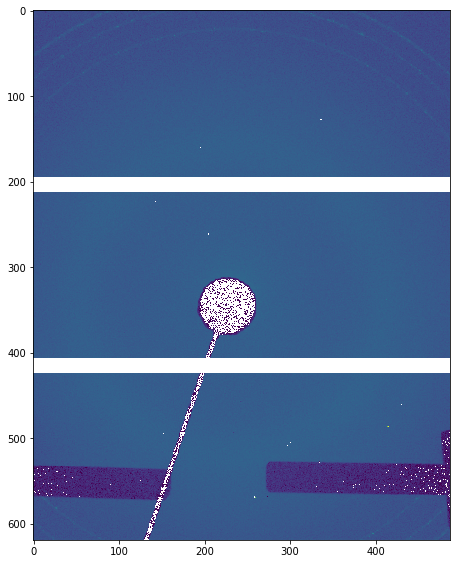

1048575


In [73]:
row_maxtsi = df.loc[df.tsi.idxmax()]
print row_maxtsi
print row_maxtsi.imagename
imagedata = get_imagedata(row_maxtsi.imagename)
show_cbf(imagedata)
plt.show()
print imagedata.max()

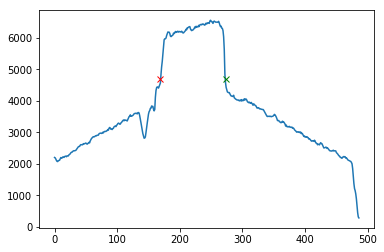

In [132]:
imagedata_shadow = ndimage.median_filter(imagedata[500:600,:], size=5)
# imagedata_shadow = imagedata[500:600,:]

# left = 100 + get_shadow_position(imagedata_shadow[:, 100:250])
# right = 250 + get_shadow_position(imagedata_shadow[:, 250:400])
left = np.sum(imagedata_shadow[:, 100:250], axis=0)
lefty = np.average([left.min(), left.max()])
right = np.sum(imagedata_shadow[:, 200:400], axis=0)
righty = np.average([right.min(), right.max()])
y = np.sum(imagedata_shadow, axis=0)
leftx = 100 + np.argmin(np.abs(left-lefty))
rightx = 200 + np.argmin(np.abs(right-righty))
plt.plot(y)
plt.plot(leftx, lefty, 'rx')
plt.plot(rightx, righty, 'gx')




[ 5 11  7  9  9  4 17  3  9  7 10 20  6  6  2  1  0  1  0  1  0  0  0  0
  0  0  0  1  0  0  0  1  0  1  4  3]
[2870 2970 3070 3170 3270 3370 3470 3570 3670 3770 3870 3970 4070 4170
 4270 4370 4470 4570 4670 4770 4870 4970 5070 5170 5270 5370 5470 5570
 5670 5770 5870 5970 6070 6170 6270 6370 6470]


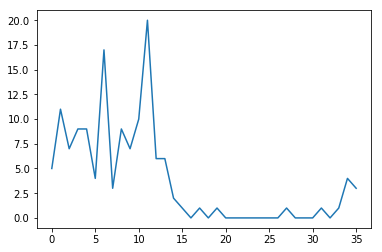

In [134]:
y = np.sum(imagedata_shadow[:, 250:400], axis=0)
# plt.plot(y)
bins = np.arange(y.min(), y.max(), 100)
hist, bins = np.histogram(y, bins=bins)
print hist
print bins
plt.plot(hist)
# plt.hist(hist, bins=bins)

In [595]:
# exploring left shadow position
# ideally one would use the distance between the shadows as a measure for the strain
# but the left shadow interferes with the shadow from the beamstop, so the left shadow position cannot be determined precisely
# => don't use left shadow
# in principle the right shadow alone would be enough to determine the current nominal strain
# but the shadow moves not only due to strain but also due to scanning
# so one has to compensate for the scanning movement
# print df.head()
# df2 = df[:1000]
# print df2.tail()
# print len(df2)
# df2['left_shadow_position'] = df2.imagename.apply(get_left_shadow_position)

In [213]:

df['right_shadow_position'] = df.imagename.apply(get_right_shadow_position)
print df.head()

nr8low_dyn_1_00008r10_00001.cbf
nr8low_dyn_1_00008r10_00002.cbf
nr8low_dyn_1_00008r10_00003.cbf
nr8low_dyn_1_00008r10_00004.cbf
nr8low_dyn_1_00008r10_00005.cbf
nr8low_dyn_1_00008r10_00006.cbf
nr8low_dyn_1_00008r10_00007.cbf
nr8low_dyn_1_00008r10_00008.cbf
nr8low_dyn_1_00008r10_00009.cbf
nr8low_dyn_1_00008r10_00010.cbf
nr8low_dyn_1_00008r10_00011.cbf
nr8low_dyn_1_00008r10_00012.cbf
nr8low_dyn_1_00008r10_00013.cbf
nr8low_dyn_1_00008r10_00014.cbf
nr8low_dyn_1_00008r10_00015.cbf
nr8low_dyn_1_00008r10_00016.cbf
nr8low_dyn_1_00008r10_00017.cbf
nr8low_dyn_1_00008r10_00018.cbf
nr8low_dyn_1_00008r10_00019.cbf
nr8low_dyn_1_00008r10_00020.cbf
nr8low_dyn_1_00008r10_00021.cbf
nr8low_dyn_1_00008r10_00022.cbf
nr8low_dyn_1_00008r10_00023.cbf
nr8low_dyn_1_00008r10_00024.cbf
nr8low_dyn_1_00008r10_00025.cbf
nr8low_dyn_1_00008r10_00026.cbf
nr8low_dyn_1_00008r10_00027.cbf
nr8low_dyn_1_00008r10_00028.cbf
nr8low_dyn_1_00008r10_00029.cbf
nr8low_dyn_1_00008r10_00030.cbf
nr8low_dyn_1_00008r10_00031.cbf
nr8low_d

nr8low_dyn_1_00008r10_00513.cbf
nr8low_dyn_1_00008r10_00514.cbf
nr8low_dyn_1_00008r10_00515.cbf
nr8low_dyn_1_00008r10_00516.cbf
nr8low_dyn_1_00008r10_00517.cbf
nr8low_dyn_1_00008r10_00518.cbf
nr8low_dyn_1_00008r10_00519.cbf
nr8low_dyn_1_00008r10_00520.cbf
nr8low_dyn_1_00008r10_00521.cbf
nr8low_dyn_1_00008r10_00522.cbf
nr8low_dyn_1_00008r10_00523.cbf
nr8low_dyn_1_00008r10_00524.cbf
nr8low_dyn_1_00008r10_00525.cbf
nr8low_dyn_1_00008r10_00526.cbf
nr8low_dyn_1_00008r10_00527.cbf
nr8low_dyn_1_00008r10_00528.cbf
nr8low_dyn_1_00008r10_00529.cbf
nr8low_dyn_1_00008r10_00530.cbf
nr8low_dyn_1_00008r10_00531.cbf
nr8low_dyn_1_00008r10_00532.cbf
nr8low_dyn_1_00008r10_00533.cbf
nr8low_dyn_1_00008r10_00534.cbf
nr8low_dyn_1_00008r10_00535.cbf
nr8low_dyn_1_00008r10_00536.cbf
nr8low_dyn_1_00008r10_00537.cbf
nr8low_dyn_1_00008r10_00538.cbf
nr8low_dyn_1_00008r10_00539.cbf
nr8low_dyn_1_00008r10_00540.cbf
nr8low_dyn_1_00008r10_00541.cbf
nr8low_dyn_1_00008r10_00542.cbf
nr8low_dyn_1_00008r10_00543.cbf
nr8low_d

nr8low_dyn_1_00008r10_01025.cbf
nr8low_dyn_1_00008r10_01026.cbf
nr8low_dyn_1_00008r10_01027.cbf
nr8low_dyn_1_00008r10_01028.cbf
nr8low_dyn_1_00008r10_01029.cbf
nr8low_dyn_1_00008r10_01030.cbf
nr8low_dyn_1_00008r10_01031.cbf
nr8low_dyn_1_00008r10_01032.cbf
nr8low_dyn_1_00008r10_01033.cbf
nr8low_dyn_1_00008r10_01034.cbf
nr8low_dyn_1_00008r10_01035.cbf
nr8low_dyn_1_00008r10_01036.cbf
nr8low_dyn_1_00008r10_01037.cbf
nr8low_dyn_1_00008r10_01038.cbf
nr8low_dyn_1_00008r10_01039.cbf
nr8low_dyn_1_00008r10_01040.cbf
nr8low_dyn_1_00008r10_01041.cbf
nr8low_dyn_1_00008r10_01042.cbf
nr8low_dyn_1_00008r10_01043.cbf
nr8low_dyn_1_00008r10_01044.cbf
nr8low_dyn_1_00008r10_01045.cbf
nr8low_dyn_1_00008r10_01046.cbf
nr8low_dyn_1_00008r10_01047.cbf
nr8low_dyn_1_00008r10_01048.cbf
nr8low_dyn_1_00008r10_01049.cbf
nr8low_dyn_1_00008r10_01050.cbf
nr8low_dyn_1_00008r10_01051.cbf
nr8low_dyn_1_00008r10_01052.cbf
nr8low_dyn_1_00008r10_01053.cbf
nr8low_dyn_1_00008r10_01054.cbf
nr8low_dyn_1_00008r10_01055.cbf
nr8low_d

nr8low_dyn_1_00008r10_01537.cbf
nr8low_dyn_1_00008r10_01538.cbf
nr8low_dyn_1_00008r10_01539.cbf
nr8low_dyn_1_00008r10_01540.cbf
nr8low_dyn_1_00008r10_01541.cbf
nr8low_dyn_1_00008r10_01542.cbf
nr8low_dyn_1_00008r10_01543.cbf
nr8low_dyn_1_00008r10_01544.cbf
nr8low_dyn_1_00008r10_01545.cbf
nr8low_dyn_1_00008r10_01546.cbf
nr8low_dyn_1_00008r10_01547.cbf
nr8low_dyn_1_00008r10_01548.cbf
nr8low_dyn_1_00008r10_01549.cbf
nr8low_dyn_1_00008r10_01550.cbf
nr8low_dyn_1_00008r10_01551.cbf
nr8low_dyn_1_00008r10_01552.cbf
nr8low_dyn_1_00008r10_01553.cbf
nr8low_dyn_1_00008r10_01554.cbf
nr8low_dyn_1_00008r10_01555.cbf
nr8low_dyn_1_00008r10_01556.cbf
nr8low_dyn_1_00008r10_01557.cbf
nr8low_dyn_1_00008r10_01558.cbf
nr8low_dyn_1_00008r10_01559.cbf
nr8low_dyn_1_00008r10_01560.cbf
nr8low_dyn_1_00008r10_01561.cbf
nr8low_dyn_1_00008r10_01562.cbf
nr8low_dyn_1_00008r10_01563.cbf
nr8low_dyn_1_00008r10_01564.cbf
nr8low_dyn_1_00008r10_01565.cbf
nr8low_dyn_1_00008r10_01566.cbf
nr8low_dyn_1_00008r10_01567.cbf
nr8low_d

nr8low_dyn_1_00008r10_02049.cbf
nr8low_dyn_1_00008r10_02050.cbf
nr8low_dyn_1_00008r10_02051.cbf
nr8low_dyn_1_00008r10_02052.cbf
nr8low_dyn_1_00008r10_02053.cbf
nr8low_dyn_1_00008r10_02054.cbf
nr8low_dyn_1_00008r10_02055.cbf
nr8low_dyn_1_00008r10_02056.cbf
nr8low_dyn_1_00008r10_02057.cbf
nr8low_dyn_1_00008r10_02058.cbf
nr8low_dyn_1_00008r10_02059.cbf
nr8low_dyn_1_00008r10_02060.cbf
nr8low_dyn_1_00008r10_02061.cbf
nr8low_dyn_1_00008r10_02062.cbf
nr8low_dyn_1_00008r10_02063.cbf
nr8low_dyn_1_00008r10_02064.cbf
nr8low_dyn_1_00008r10_02065.cbf
nr8low_dyn_1_00008r10_02066.cbf
nr8low_dyn_1_00008r10_02067.cbf
nr8low_dyn_1_00008r10_02068.cbf
nr8low_dyn_1_00008r10_02069.cbf
nr8low_dyn_1_00008r10_02070.cbf
nr8low_dyn_1_00008r10_02071.cbf
nr8low_dyn_1_00008r10_02072.cbf
nr8low_dyn_1_00008r10_02073.cbf
nr8low_dyn_1_00008r10_02074.cbf
nr8low_dyn_1_00008r10_02075.cbf
nr8low_dyn_1_00008r10_02076.cbf
nr8low_dyn_1_00008r10_02077.cbf
nr8low_dyn_1_00008r10_02078.cbf
nr8low_dyn_1_00008r10_02079.cbf
nr8low_d

nr8low_dyn_1_00008r10_02561.cbf
nr8low_dyn_1_00008r10_02562.cbf
nr8low_dyn_1_00008r10_02563.cbf
nr8low_dyn_1_00008r10_02564.cbf
nr8low_dyn_1_00008r10_02565.cbf
nr8low_dyn_1_00008r10_02566.cbf
nr8low_dyn_1_00008r10_02567.cbf
nr8low_dyn_1_00008r10_02568.cbf
nr8low_dyn_1_00008r10_02569.cbf
nr8low_dyn_1_00008r10_02570.cbf
nr8low_dyn_1_00008r10_02571.cbf
nr8low_dyn_1_00008r10_02572.cbf
nr8low_dyn_1_00008r10_02573.cbf
nr8low_dyn_1_00008r10_02574.cbf
nr8low_dyn_1_00008r10_02575.cbf
nr8low_dyn_1_00008r10_02576.cbf
nr8low_dyn_1_00008r10_02577.cbf
nr8low_dyn_1_00008r10_02578.cbf
nr8low_dyn_1_00008r10_02579.cbf
nr8low_dyn_1_00008r10_02580.cbf
nr8low_dyn_1_00008r10_02581.cbf
nr8low_dyn_1_00008r10_02582.cbf
nr8low_dyn_1_00008r10_02583.cbf
nr8low_dyn_1_00008r10_02584.cbf
nr8low_dyn_1_00008r10_02585.cbf
nr8low_dyn_1_00008r10_02586.cbf
nr8low_dyn_1_00008r10_02587.cbf
nr8low_dyn_1_00008r10_02588.cbf
nr8low_dyn_1_00008r10_02589.cbf
nr8low_dyn_1_00008r10_02590.cbf
nr8low_dyn_1_00008r10_02591.cbf
nr8low_d

nr8low_dyn_1_00008r11_00374.cbf
nr8low_dyn_1_00008r11_00375.cbf
nr8low_dyn_1_00008r11_00376.cbf
nr8low_dyn_1_00008r11_00377.cbf
nr8low_dyn_1_00008r11_00378.cbf
nr8low_dyn_1_00008r11_00379.cbf
nr8low_dyn_1_00008r11_00380.cbf
nr8low_dyn_1_00008r11_00381.cbf
nr8low_dyn_1_00008r11_00382.cbf
nr8low_dyn_1_00008r11_00383.cbf
nr8low_dyn_1_00008r11_00384.cbf
nr8low_dyn_1_00008r11_00385.cbf
nr8low_dyn_1_00008r11_00386.cbf
nr8low_dyn_1_00008r11_00387.cbf
nr8low_dyn_1_00008r11_00388.cbf
nr8low_dyn_1_00008r11_00389.cbf
nr8low_dyn_1_00008r11_00390.cbf
nr8low_dyn_1_00008r11_00391.cbf
nr8low_dyn_1_00008r11_00392.cbf
nr8low_dyn_1_00008r11_00393.cbf
nr8low_dyn_1_00008r11_00394.cbf
nr8low_dyn_1_00008r11_00395.cbf
nr8low_dyn_1_00008r11_00396.cbf
nr8low_dyn_1_00008r11_00397.cbf
nr8low_dyn_1_00008r11_00398.cbf
nr8low_dyn_1_00008r11_00399.cbf
nr8low_dyn_1_00008r11_00400.cbf
nr8low_dyn_1_00008r11_00401.cbf
nr8low_dyn_1_00008r11_00402.cbf
nr8low_dyn_1_00008r11_00403.cbf
nr8low_dyn_1_00008r11_00404.cbf
nr8low_d

nr8low_dyn_1_00008r11_00886.cbf
nr8low_dyn_1_00008r11_00887.cbf
nr8low_dyn_1_00008r11_00888.cbf
nr8low_dyn_1_00008r11_00889.cbf
nr8low_dyn_1_00008r11_00890.cbf
nr8low_dyn_1_00008r11_00891.cbf
nr8low_dyn_1_00008r11_00892.cbf
nr8low_dyn_1_00008r11_00893.cbf
nr8low_dyn_1_00008r11_00894.cbf
nr8low_dyn_1_00008r11_00895.cbf
nr8low_dyn_1_00008r11_00896.cbf
nr8low_dyn_1_00008r11_00897.cbf
nr8low_dyn_1_00008r11_00898.cbf
nr8low_dyn_1_00008r11_00899.cbf
nr8low_dyn_1_00008r11_00900.cbf
nr8low_dyn_1_00008r11_00901.cbf
nr8low_dyn_1_00008r11_00902.cbf
nr8low_dyn_1_00008r11_00903.cbf
nr8low_dyn_1_00008r11_00904.cbf
nr8low_dyn_1_00008r11_00905.cbf
nr8low_dyn_1_00008r11_00906.cbf
nr8low_dyn_1_00008r11_00907.cbf
nr8low_dyn_1_00008r11_00908.cbf
nr8low_dyn_1_00008r11_00909.cbf
nr8low_dyn_1_00008r11_00910.cbf
nr8low_dyn_1_00008r11_00911.cbf
nr8low_dyn_1_00008r11_00912.cbf
nr8low_dyn_1_00008r11_00913.cbf
nr8low_dyn_1_00008r11_00914.cbf
nr8low_dyn_1_00008r11_00915.cbf
nr8low_dyn_1_00008r11_00916.cbf
nr8low_d

nr8low_dyn_1_00008r11_01398.cbf
nr8low_dyn_1_00008r11_01399.cbf
nr8low_dyn_1_00008r11_01400.cbf
nr8low_dyn_1_00008r11_01401.cbf
nr8low_dyn_1_00008r11_01402.cbf
nr8low_dyn_1_00008r11_01403.cbf
nr8low_dyn_1_00008r11_01404.cbf
nr8low_dyn_1_00008r11_01405.cbf
nr8low_dyn_1_00008r11_01406.cbf
nr8low_dyn_1_00008r11_01407.cbf
nr8low_dyn_1_00008r11_01408.cbf
nr8low_dyn_1_00008r11_01409.cbf
nr8low_dyn_1_00008r11_01410.cbf
nr8low_dyn_1_00008r11_01411.cbf
nr8low_dyn_1_00008r11_01412.cbf
nr8low_dyn_1_00008r11_01413.cbf
nr8low_dyn_1_00008r11_01414.cbf
nr8low_dyn_1_00008r11_01415.cbf
nr8low_dyn_1_00008r11_01416.cbf
nr8low_dyn_1_00008r11_01417.cbf
nr8low_dyn_1_00008r11_01418.cbf
nr8low_dyn_1_00008r11_01419.cbf
nr8low_dyn_1_00008r11_01420.cbf
nr8low_dyn_1_00008r11_01421.cbf
nr8low_dyn_1_00008r11_01422.cbf
nr8low_dyn_1_00008r11_01423.cbf
nr8low_dyn_1_00008r11_01424.cbf
nr8low_dyn_1_00008r11_01425.cbf
nr8low_dyn_1_00008r11_01426.cbf
nr8low_dyn_1_00008r11_01427.cbf
nr8low_dyn_1_00008r11_01428.cbf
nr8low_d

nr8low_dyn_1_00008r11_01910.cbf
nr8low_dyn_1_00008r11_01911.cbf
nr8low_dyn_1_00008r11_01912.cbf
nr8low_dyn_1_00008r11_01913.cbf
nr8low_dyn_1_00008r11_01914.cbf
nr8low_dyn_1_00008r11_01915.cbf
nr8low_dyn_1_00008r11_01916.cbf
nr8low_dyn_1_00008r11_01917.cbf
nr8low_dyn_1_00008r11_01918.cbf
nr8low_dyn_1_00008r11_01919.cbf
nr8low_dyn_1_00008r11_01920.cbf
nr8low_dyn_1_00008r11_01921.cbf
nr8low_dyn_1_00008r11_01922.cbf
nr8low_dyn_1_00008r11_01923.cbf
nr8low_dyn_1_00008r11_01924.cbf
nr8low_dyn_1_00008r11_01925.cbf
nr8low_dyn_1_00008r11_01926.cbf
nr8low_dyn_1_00008r11_01927.cbf
nr8low_dyn_1_00008r11_01928.cbf
nr8low_dyn_1_00008r11_01929.cbf
nr8low_dyn_1_00008r11_01930.cbf
nr8low_dyn_1_00008r11_01931.cbf
nr8low_dyn_1_00008r11_01932.cbf
nr8low_dyn_1_00008r11_01933.cbf
nr8low_dyn_1_00008r11_01934.cbf
nr8low_dyn_1_00008r11_01935.cbf
nr8low_dyn_1_00008r11_01936.cbf
nr8low_dyn_1_00008r11_01937.cbf
nr8low_dyn_1_00008r11_01938.cbf
nr8low_dyn_1_00008r11_01939.cbf
nr8low_dyn_1_00008r11_01940.cbf
nr8low_d

nr8low_dyn_1_00008r11_02422.cbf
nr8low_dyn_1_00008r11_02423.cbf
nr8low_dyn_1_00008r11_02424.cbf
nr8low_dyn_1_00008r11_02425.cbf
nr8low_dyn_1_00008r11_02426.cbf
nr8low_dyn_1_00008r11_02427.cbf
nr8low_dyn_1_00008r11_02428.cbf
nr8low_dyn_1_00008r11_02429.cbf
nr8low_dyn_1_00008r11_02430.cbf
nr8low_dyn_1_00008r11_02431.cbf
nr8low_dyn_1_00008r11_02432.cbf
nr8low_dyn_1_00008r11_02433.cbf
nr8low_dyn_1_00008r11_02434.cbf
nr8low_dyn_1_00008r11_02435.cbf
nr8low_dyn_1_00008r11_02436.cbf
nr8low_dyn_1_00008r11_02437.cbf
nr8low_dyn_1_00008r11_02438.cbf
nr8low_dyn_1_00008r11_02439.cbf
nr8low_dyn_1_00008r11_02440.cbf
nr8low_dyn_1_00008r11_02441.cbf
nr8low_dyn_1_00008r11_02442.cbf
nr8low_dyn_1_00008r11_02443.cbf
nr8low_dyn_1_00008r11_02444.cbf
nr8low_dyn_1_00008r11_02445.cbf
nr8low_dyn_1_00008r11_02446.cbf
nr8low_dyn_1_00008r11_02447.cbf
nr8low_dyn_1_00008r11_02448.cbf
nr8low_dyn_1_00008r11_02449.cbf
nr8low_dyn_1_00008r11_02450.cbf
nr8low_dyn_1_00008r11_02451.cbf
nr8low_dyn_1_00008r11_02452.cbf
nr8low_d

nr8low_dyn_1_00008r12_00234.cbf
nr8low_dyn_1_00008r12_00235.cbf
nr8low_dyn_1_00008r12_00236.cbf
nr8low_dyn_1_00008r12_00237.cbf
nr8low_dyn_1_00008r12_00238.cbf
nr8low_dyn_1_00008r12_00239.cbf
nr8low_dyn_1_00008r12_00240.cbf
nr8low_dyn_1_00008r12_00241.cbf
nr8low_dyn_1_00008r12_00242.cbf
nr8low_dyn_1_00008r12_00243.cbf
nr8low_dyn_1_00008r12_00244.cbf
nr8low_dyn_1_00008r12_00245.cbf
nr8low_dyn_1_00008r12_00246.cbf
nr8low_dyn_1_00008r12_00247.cbf
nr8low_dyn_1_00008r12_00248.cbf
nr8low_dyn_1_00008r12_00249.cbf
nr8low_dyn_1_00008r12_00250.cbf
nr8low_dyn_1_00008r12_00251.cbf
nr8low_dyn_1_00008r12_00252.cbf
nr8low_dyn_1_00008r12_00253.cbf
nr8low_dyn_1_00008r12_00254.cbf
nr8low_dyn_1_00008r12_00255.cbf
nr8low_dyn_1_00008r12_00256.cbf
nr8low_dyn_1_00008r12_00257.cbf
nr8low_dyn_1_00008r12_00258.cbf
nr8low_dyn_1_00008r12_00259.cbf
nr8low_dyn_1_00008r12_00260.cbf
nr8low_dyn_1_00008r12_00261.cbf
nr8low_dyn_1_00008r12_00262.cbf
nr8low_dyn_1_00008r12_00263.cbf
nr8low_dyn_1_00008r12_00264.cbf
nr8low_d

nr8low_dyn_1_00008r12_00746.cbf
nr8low_dyn_1_00008r12_00747.cbf
nr8low_dyn_1_00008r12_00748.cbf
nr8low_dyn_1_00008r12_00749.cbf
nr8low_dyn_1_00008r12_00750.cbf
nr8low_dyn_1_00008r12_00751.cbf
nr8low_dyn_1_00008r12_00752.cbf
nr8low_dyn_1_00008r12_00753.cbf
nr8low_dyn_1_00008r12_00754.cbf
nr8low_dyn_1_00008r12_00755.cbf
nr8low_dyn_1_00008r12_00756.cbf
nr8low_dyn_1_00008r12_00757.cbf
nr8low_dyn_1_00008r12_00758.cbf
nr8low_dyn_1_00008r12_00759.cbf
nr8low_dyn_1_00008r12_00760.cbf
nr8low_dyn_1_00008r12_00761.cbf
nr8low_dyn_1_00008r12_00762.cbf
nr8low_dyn_1_00008r12_00763.cbf
nr8low_dyn_1_00008r12_00764.cbf
nr8low_dyn_1_00008r12_00765.cbf
nr8low_dyn_1_00008r12_00766.cbf
nr8low_dyn_1_00008r12_00767.cbf
nr8low_dyn_1_00008r12_00768.cbf
nr8low_dyn_1_00008r12_00769.cbf
nr8low_dyn_1_00008r12_00770.cbf
nr8low_dyn_1_00008r12_00771.cbf
nr8low_dyn_1_00008r12_00772.cbf
nr8low_dyn_1_00008r12_00773.cbf
nr8low_dyn_1_00008r12_00774.cbf
nr8low_dyn_1_00008r12_00775.cbf
nr8low_dyn_1_00008r12_00776.cbf
nr8low_d

nr8low_dyn_1_00008r12_01258.cbf
nr8low_dyn_1_00008r12_01259.cbf
nr8low_dyn_1_00008r12_01260.cbf
nr8low_dyn_1_00008r12_01261.cbf
nr8low_dyn_1_00008r12_01262.cbf
nr8low_dyn_1_00008r12_01263.cbf
nr8low_dyn_1_00008r12_01264.cbf
nr8low_dyn_1_00008r12_01265.cbf
nr8low_dyn_1_00008r12_01266.cbf
nr8low_dyn_1_00008r12_01267.cbf
nr8low_dyn_1_00008r12_01268.cbf
nr8low_dyn_1_00008r12_01269.cbf
nr8low_dyn_1_00008r12_01270.cbf
nr8low_dyn_1_00008r12_01271.cbf
nr8low_dyn_1_00008r12_01272.cbf
nr8low_dyn_1_00008r12_01273.cbf
nr8low_dyn_1_00008r12_01274.cbf
nr8low_dyn_1_00008r12_01275.cbf
nr8low_dyn_1_00008r12_01276.cbf
nr8low_dyn_1_00008r12_01277.cbf
nr8low_dyn_1_00008r12_01278.cbf
nr8low_dyn_1_00008r12_01279.cbf
nr8low_dyn_1_00008r12_01280.cbf
nr8low_dyn_1_00008r12_01281.cbf
nr8low_dyn_1_00008r12_01282.cbf
nr8low_dyn_1_00008r12_01283.cbf
nr8low_dyn_1_00008r12_01284.cbf
nr8low_dyn_1_00008r12_01285.cbf
nr8low_dyn_1_00008r12_01286.cbf
nr8low_dyn_1_00008r12_01287.cbf
nr8low_dyn_1_00008r12_01288.cbf
nr8low_d

nr8low_dyn_1_00008r12_01770.cbf
nr8low_dyn_1_00008r12_01771.cbf
nr8low_dyn_1_00008r12_01772.cbf
nr8low_dyn_1_00008r12_01773.cbf
nr8low_dyn_1_00008r12_01774.cbf
nr8low_dyn_1_00008r12_01775.cbf
nr8low_dyn_1_00008r12_01776.cbf
nr8low_dyn_1_00008r12_01777.cbf
nr8low_dyn_1_00008r12_01778.cbf
nr8low_dyn_1_00008r12_01779.cbf
nr8low_dyn_1_00008r12_01780.cbf
nr8low_dyn_1_00008r12_01781.cbf
nr8low_dyn_1_00008r12_01782.cbf
nr8low_dyn_1_00008r12_01783.cbf
nr8low_dyn_1_00008r12_01784.cbf
nr8low_dyn_1_00008r12_01785.cbf
nr8low_dyn_1_00008r12_01786.cbf
nr8low_dyn_1_00008r12_01787.cbf
nr8low_dyn_1_00008r12_01788.cbf
nr8low_dyn_1_00008r12_01789.cbf
nr8low_dyn_1_00008r12_01790.cbf
nr8low_dyn_1_00008r12_01791.cbf
nr8low_dyn_1_00008r12_01792.cbf
nr8low_dyn_1_00008r12_01793.cbf
nr8low_dyn_1_00008r12_01794.cbf
nr8low_dyn_1_00008r12_01795.cbf
nr8low_dyn_1_00008r12_01796.cbf
nr8low_dyn_1_00008r12_01797.cbf
nr8low_dyn_1_00008r12_01798.cbf
nr8low_dyn_1_00008r12_01799.cbf
nr8low_dyn_1_00008r12_01800.cbf
nr8low_d

nr8low_dyn_1_00008r12_02282.cbf
nr8low_dyn_1_00008r12_02283.cbf
nr8low_dyn_1_00008r12_02284.cbf
nr8low_dyn_1_00008r12_02285.cbf
nr8low_dyn_1_00008r12_02286.cbf
nr8low_dyn_1_00008r12_02287.cbf
nr8low_dyn_1_00008r12_02288.cbf
nr8low_dyn_1_00008r12_02289.cbf
nr8low_dyn_1_00008r12_02290.cbf
nr8low_dyn_1_00008r12_02291.cbf
nr8low_dyn_1_00008r12_02292.cbf
nr8low_dyn_1_00008r12_02293.cbf
nr8low_dyn_1_00008r12_02294.cbf
nr8low_dyn_1_00008r12_02295.cbf
nr8low_dyn_1_00008r12_02296.cbf
nr8low_dyn_1_00008r12_02297.cbf
nr8low_dyn_1_00008r12_02298.cbf
nr8low_dyn_1_00008r12_02299.cbf
nr8low_dyn_1_00008r12_02300.cbf
nr8low_dyn_1_00008r12_02301.cbf
nr8low_dyn_1_00008r12_02302.cbf
nr8low_dyn_1_00008r12_02303.cbf
nr8low_dyn_1_00008r12_02304.cbf
nr8low_dyn_1_00008r12_02305.cbf
nr8low_dyn_1_00008r12_02306.cbf
nr8low_dyn_1_00008r12_02307.cbf
nr8low_dyn_1_00008r12_02308.cbf
nr8low_dyn_1_00008r12_02309.cbf
nr8low_dyn_1_00008r12_02310.cbf
nr8low_dyn_1_00008r12_02311.cbf
nr8low_dyn_1_00008r12_02312.cbf
nr8low_d

nr8low_dyn_1_00008r13_00094.cbf
nr8low_dyn_1_00008r13_00095.cbf
nr8low_dyn_1_00008r13_00096.cbf
nr8low_dyn_1_00008r13_00097.cbf
nr8low_dyn_1_00008r13_00098.cbf
nr8low_dyn_1_00008r13_00099.cbf
nr8low_dyn_1_00008r13_00100.cbf
nr8low_dyn_1_00008r13_00101.cbf
nr8low_dyn_1_00008r13_00102.cbf
nr8low_dyn_1_00008r13_00103.cbf
nr8low_dyn_1_00008r13_00104.cbf
nr8low_dyn_1_00008r13_00105.cbf
nr8low_dyn_1_00008r13_00106.cbf
nr8low_dyn_1_00008r13_00107.cbf
nr8low_dyn_1_00008r13_00108.cbf
nr8low_dyn_1_00008r13_00109.cbf
nr8low_dyn_1_00008r13_00110.cbf
nr8low_dyn_1_00008r13_00111.cbf
nr8low_dyn_1_00008r13_00112.cbf
nr8low_dyn_1_00008r13_00113.cbf
nr8low_dyn_1_00008r13_00114.cbf
nr8low_dyn_1_00008r13_00115.cbf
nr8low_dyn_1_00008r13_00116.cbf
nr8low_dyn_1_00008r13_00117.cbf
nr8low_dyn_1_00008r13_00118.cbf
nr8low_dyn_1_00008r13_00119.cbf
nr8low_dyn_1_00008r13_00120.cbf
nr8low_dyn_1_00008r13_00121.cbf
nr8low_dyn_1_00008r13_00122.cbf
nr8low_dyn_1_00008r13_00123.cbf
nr8low_dyn_1_00008r13_00124.cbf
nr8low_d

nr8low_dyn_1_00008r13_00606.cbf
nr8low_dyn_1_00008r13_00607.cbf
nr8low_dyn_1_00008r13_00608.cbf
nr8low_dyn_1_00008r13_00609.cbf
nr8low_dyn_1_00008r13_00610.cbf
nr8low_dyn_1_00008r13_00611.cbf
nr8low_dyn_1_00008r13_00612.cbf
nr8low_dyn_1_00008r13_00613.cbf
nr8low_dyn_1_00008r13_00614.cbf
nr8low_dyn_1_00008r13_00615.cbf
nr8low_dyn_1_00008r13_00616.cbf
nr8low_dyn_1_00008r13_00617.cbf
nr8low_dyn_1_00008r13_00618.cbf
nr8low_dyn_1_00008r13_00619.cbf
nr8low_dyn_1_00008r13_00620.cbf
nr8low_dyn_1_00008r13_00621.cbf
nr8low_dyn_1_00008r13_00622.cbf
nr8low_dyn_1_00008r13_00623.cbf
nr8low_dyn_1_00008r13_00624.cbf
nr8low_dyn_1_00008r13_00625.cbf
nr8low_dyn_1_00008r13_00626.cbf
nr8low_dyn_1_00008r13_00627.cbf
nr8low_dyn_1_00008r13_00628.cbf
nr8low_dyn_1_00008r13_00629.cbf
nr8low_dyn_1_00008r13_00630.cbf
nr8low_dyn_1_00008r13_00631.cbf
nr8low_dyn_1_00008r13_00632.cbf
nr8low_dyn_1_00008r13_00633.cbf
nr8low_dyn_1_00008r13_00634.cbf
nr8low_dyn_1_00008r13_00635.cbf
nr8low_dyn_1_00008r13_00636.cbf
nr8low_d

nr8low_dyn_1_00008r13_01118.cbf
nr8low_dyn_1_00008r13_01119.cbf
nr8low_dyn_1_00008r13_01120.cbf
nr8low_dyn_1_00008r13_01121.cbf
nr8low_dyn_1_00008r13_01122.cbf
nr8low_dyn_1_00008r13_01123.cbf
nr8low_dyn_1_00008r13_01124.cbf
nr8low_dyn_1_00008r13_01125.cbf
nr8low_dyn_1_00008r13_01126.cbf
nr8low_dyn_1_00008r13_01127.cbf
nr8low_dyn_1_00008r13_01128.cbf
nr8low_dyn_1_00008r13_01129.cbf
nr8low_dyn_1_00008r13_01130.cbf
nr8low_dyn_1_00008r13_01131.cbf
nr8low_dyn_1_00008r13_01132.cbf
nr8low_dyn_1_00008r13_01133.cbf
nr8low_dyn_1_00008r13_01134.cbf
nr8low_dyn_1_00008r13_01135.cbf
nr8low_dyn_1_00008r13_01136.cbf
nr8low_dyn_1_00008r13_01137.cbf
nr8low_dyn_1_00008r13_01138.cbf
nr8low_dyn_1_00008r13_01139.cbf
nr8low_dyn_1_00008r13_01140.cbf
nr8low_dyn_1_00008r13_01141.cbf
nr8low_dyn_1_00008r13_01142.cbf
nr8low_dyn_1_00008r13_01143.cbf
nr8low_dyn_1_00008r13_01144.cbf
nr8low_dyn_1_00008r13_01145.cbf
nr8low_dyn_1_00008r13_01146.cbf
nr8low_dyn_1_00008r13_01147.cbf
nr8low_dyn_1_00008r13_01148.cbf
nr8low_d

nr8low_dyn_1_00008r13_01630.cbf
nr8low_dyn_1_00008r13_01631.cbf
nr8low_dyn_1_00008r13_01632.cbf
nr8low_dyn_1_00008r13_01633.cbf
nr8low_dyn_1_00008r13_01634.cbf
nr8low_dyn_1_00008r13_01635.cbf
nr8low_dyn_1_00008r13_01636.cbf
nr8low_dyn_1_00008r13_01637.cbf
nr8low_dyn_1_00008r13_01638.cbf
nr8low_dyn_1_00008r13_01639.cbf
nr8low_dyn_1_00008r13_01640.cbf
nr8low_dyn_1_00008r13_01641.cbf
nr8low_dyn_1_00008r13_01642.cbf
nr8low_dyn_1_00008r13_01643.cbf
nr8low_dyn_1_00008r13_01644.cbf
nr8low_dyn_1_00008r13_01645.cbf
nr8low_dyn_1_00008r13_01646.cbf
nr8low_dyn_1_00008r13_01647.cbf
nr8low_dyn_1_00008r13_01648.cbf
nr8low_dyn_1_00008r13_01649.cbf
nr8low_dyn_1_00008r13_01650.cbf
nr8low_dyn_1_00008r13_01651.cbf
nr8low_dyn_1_00008r13_01652.cbf
nr8low_dyn_1_00008r13_01653.cbf
nr8low_dyn_1_00008r13_01654.cbf
nr8low_dyn_1_00008r13_01655.cbf
nr8low_dyn_1_00008r13_01656.cbf
nr8low_dyn_1_00008r13_01657.cbf
nr8low_dyn_1_00008r13_01658.cbf
nr8low_dyn_1_00008r13_01659.cbf
nr8low_dyn_1_00008r13_01660.cbf
nr8low_d

nr8low_dyn_1_00008r13_02142.cbf
nr8low_dyn_1_00008r13_02143.cbf
nr8low_dyn_1_00008r13_02144.cbf
nr8low_dyn_1_00008r13_02145.cbf
nr8low_dyn_1_00008r13_02146.cbf
nr8low_dyn_1_00008r13_02147.cbf
nr8low_dyn_1_00008r13_02148.cbf
nr8low_dyn_1_00008r13_02149.cbf
nr8low_dyn_1_00008r13_02150.cbf
nr8low_dyn_1_00008r13_02151.cbf
nr8low_dyn_1_00008r13_02152.cbf
nr8low_dyn_1_00008r13_02153.cbf
nr8low_dyn_1_00008r13_02154.cbf
nr8low_dyn_1_00008r13_02155.cbf
nr8low_dyn_1_00008r13_02156.cbf
nr8low_dyn_1_00008r13_02157.cbf
nr8low_dyn_1_00008r13_02158.cbf
nr8low_dyn_1_00008r13_02159.cbf
nr8low_dyn_1_00008r13_02160.cbf
nr8low_dyn_1_00008r13_02161.cbf
nr8low_dyn_1_00008r13_02162.cbf
nr8low_dyn_1_00008r13_02163.cbf
nr8low_dyn_1_00008r13_02164.cbf
nr8low_dyn_1_00008r13_02165.cbf
nr8low_dyn_1_00008r13_02166.cbf
nr8low_dyn_1_00008r13_02167.cbf
nr8low_dyn_1_00008r13_02168.cbf
nr8low_dyn_1_00008r13_02169.cbf
nr8low_dyn_1_00008r13_02170.cbf
nr8low_dyn_1_00008r13_02171.cbf
nr8low_dyn_1_00008r13_02172.cbf
nr8low_d

nr8low_dyn_1_00008r13_02654.cbf
nr8low_dyn_1_00008r13_02655.cbf
nr8low_dyn_1_00008r13_02656.cbf
nr8low_dyn_1_00008r13_02657.cbf
nr8low_dyn_1_00008r13_02658.cbf
nr8low_dyn_1_00008r13_02659.cbf
nr8low_dyn_1_00008r13_02660.cbf
nr8low_dyn_1_00008r13_02661.cbf
nr8low_dyn_1_00008r13_02662.cbf
nr8low_dyn_1_00008r13_02663.cbf
nr8low_dyn_1_00008r13_02664.cbf
nr8low_dyn_1_00008r13_02665.cbf
nr8low_dyn_1_00008r13_02666.cbf
nr8low_dyn_1_00008r13_02667.cbf
nr8low_dyn_1_00008r13_02668.cbf
nr8low_dyn_1_00008r13_02669.cbf
nr8low_dyn_1_00008r13_02670.cbf
nr8low_dyn_1_00008r13_02671.cbf
nr8low_dyn_1_00008r13_02672.cbf
nr8low_dyn_1_00008r13_02673.cbf
nr8low_dyn_1_00008r13_02674.cbf
nr8low_dyn_1_00008r13_02675.cbf
nr8low_dyn_1_00008r13_02676.cbf
nr8low_dyn_1_00008r13_02677.cbf
nr8low_dyn_1_00008r13_02678.cbf
nr8low_dyn_1_00008r13_02679.cbf
nr8low_dyn_1_00008r13_02680.cbf
nr8low_dyn_1_00008r13_02681.cbf
nr8low_dyn_1_00008r13_02682.cbf
nr8low_dyn_1_00008r13_02683.cbf
nr8low_dyn_1_00008r13_02684.cbf
nr8low_d

nr8low_dyn_1_00008r14_00466.cbf
nr8low_dyn_1_00008r14_00467.cbf
nr8low_dyn_1_00008r14_00468.cbf
nr8low_dyn_1_00008r14_00469.cbf
nr8low_dyn_1_00008r14_00470.cbf
nr8low_dyn_1_00008r14_00471.cbf
nr8low_dyn_1_00008r14_00472.cbf
nr8low_dyn_1_00008r14_00473.cbf
nr8low_dyn_1_00008r14_00474.cbf
nr8low_dyn_1_00008r14_00475.cbf
nr8low_dyn_1_00008r14_00476.cbf
nr8low_dyn_1_00008r14_00477.cbf
nr8low_dyn_1_00008r14_00478.cbf
nr8low_dyn_1_00008r14_00479.cbf
nr8low_dyn_1_00008r14_00480.cbf
nr8low_dyn_1_00008r14_00481.cbf
nr8low_dyn_1_00008r14_00482.cbf
nr8low_dyn_1_00008r14_00483.cbf
nr8low_dyn_1_00008r14_00484.cbf
nr8low_dyn_1_00008r14_00485.cbf
nr8low_dyn_1_00008r14_00486.cbf
nr8low_dyn_1_00008r14_00487.cbf
nr8low_dyn_1_00008r14_00488.cbf
nr8low_dyn_1_00008r14_00489.cbf
nr8low_dyn_1_00008r14_00490.cbf
nr8low_dyn_1_00008r14_00491.cbf
nr8low_dyn_1_00008r14_00492.cbf
nr8low_dyn_1_00008r14_00493.cbf
nr8low_dyn_1_00008r14_00494.cbf
nr8low_dyn_1_00008r14_00495.cbf
nr8low_dyn_1_00008r14_00496.cbf
nr8low_d

nr8low_dyn_1_00008r14_00978.cbf
nr8low_dyn_1_00008r14_00979.cbf
nr8low_dyn_1_00008r14_00980.cbf
nr8low_dyn_1_00008r14_00981.cbf
nr8low_dyn_1_00008r14_00982.cbf
nr8low_dyn_1_00008r14_00983.cbf
nr8low_dyn_1_00008r14_00984.cbf
nr8low_dyn_1_00008r14_00985.cbf
nr8low_dyn_1_00008r14_00986.cbf
nr8low_dyn_1_00008r14_00987.cbf
nr8low_dyn_1_00008r14_00988.cbf
nr8low_dyn_1_00008r14_00989.cbf
nr8low_dyn_1_00008r14_00990.cbf
nr8low_dyn_1_00008r14_00991.cbf
nr8low_dyn_1_00008r14_00992.cbf
nr8low_dyn_1_00008r14_00993.cbf
nr8low_dyn_1_00008r14_00994.cbf
nr8low_dyn_1_00008r14_00995.cbf
nr8low_dyn_1_00008r14_00996.cbf
nr8low_dyn_1_00008r14_00997.cbf
nr8low_dyn_1_00008r14_00998.cbf
nr8low_dyn_1_00008r14_00999.cbf
nr8low_dyn_1_00008r14_01000.cbf
nr8low_dyn_1_00008r14_01001.cbf
nr8low_dyn_1_00008r14_01002.cbf
nr8low_dyn_1_00008r14_01003.cbf
nr8low_dyn_1_00008r14_01004.cbf
nr8low_dyn_1_00008r14_01005.cbf
nr8low_dyn_1_00008r14_01006.cbf
nr8low_dyn_1_00008r14_01007.cbf
nr8low_dyn_1_00008r14_01008.cbf
nr8low_d

nr8low_dyn_1_00008r14_01490.cbf
nr8low_dyn_1_00008r14_01491.cbf
nr8low_dyn_1_00008r14_01492.cbf
nr8low_dyn_1_00008r14_01493.cbf
nr8low_dyn_1_00008r14_01494.cbf
nr8low_dyn_1_00008r14_01495.cbf
nr8low_dyn_1_00008r14_01496.cbf
nr8low_dyn_1_00008r14_01497.cbf
nr8low_dyn_1_00008r14_01498.cbf
nr8low_dyn_1_00008r14_01499.cbf
nr8low_dyn_1_00008r14_01500.cbf
nr8low_dyn_1_00008r14_01501.cbf
nr8low_dyn_1_00008r14_01502.cbf
nr8low_dyn_1_00008r14_01503.cbf
nr8low_dyn_1_00008r14_01504.cbf
nr8low_dyn_1_00008r14_01505.cbf
nr8low_dyn_1_00008r14_01506.cbf
nr8low_dyn_1_00008r14_01507.cbf
nr8low_dyn_1_00008r14_01508.cbf
nr8low_dyn_1_00008r14_01509.cbf
nr8low_dyn_1_00008r14_01510.cbf
nr8low_dyn_1_00008r14_01511.cbf
nr8low_dyn_1_00008r14_01512.cbf
nr8low_dyn_1_00008r14_01513.cbf
nr8low_dyn_1_00008r14_01514.cbf
nr8low_dyn_1_00008r14_01515.cbf
nr8low_dyn_1_00008r14_01516.cbf
nr8low_dyn_1_00008r14_01517.cbf
nr8low_dyn_1_00008r14_01518.cbf
nr8low_dyn_1_00008r14_01519.cbf
nr8low_dyn_1_00008r14_01520.cbf
nr8low_d

nr8low_dyn_1_00008r14_02002.cbf
nr8low_dyn_1_00008r14_02003.cbf
nr8low_dyn_1_00008r14_02004.cbf
nr8low_dyn_1_00008r14_02005.cbf
nr8low_dyn_1_00008r14_02006.cbf
nr8low_dyn_1_00008r14_02007.cbf
nr8low_dyn_1_00008r14_02008.cbf
nr8low_dyn_1_00008r14_02009.cbf
nr8low_dyn_1_00008r14_02010.cbf
nr8low_dyn_1_00008r14_02011.cbf
nr8low_dyn_1_00008r14_02012.cbf
nr8low_dyn_1_00008r14_02013.cbf
nr8low_dyn_1_00008r14_02014.cbf
nr8low_dyn_1_00008r14_02015.cbf
nr8low_dyn_1_00008r14_02016.cbf
nr8low_dyn_1_00008r14_02017.cbf
nr8low_dyn_1_00008r14_02018.cbf
nr8low_dyn_1_00008r14_02019.cbf
nr8low_dyn_1_00008r14_02020.cbf
nr8low_dyn_1_00008r14_02021.cbf
nr8low_dyn_1_00008r14_02022.cbf
nr8low_dyn_1_00008r14_02023.cbf
nr8low_dyn_1_00008r14_02024.cbf
nr8low_dyn_1_00008r14_02025.cbf
nr8low_dyn_1_00008r14_02026.cbf
nr8low_dyn_1_00008r14_02027.cbf
nr8low_dyn_1_00008r14_02028.cbf
nr8low_dyn_1_00008r14_02029.cbf
nr8low_dyn_1_00008r14_02030.cbf
nr8low_dyn_1_00008r14_02031.cbf
nr8low_dyn_1_00008r14_02032.cbf
nr8low_d

nr8low_dyn_1_00008r14_02514.cbf
nr8low_dyn_1_00008r14_02515.cbf
nr8low_dyn_1_00008r14_02516.cbf
nr8low_dyn_1_00008r14_02517.cbf
nr8low_dyn_1_00008r14_02518.cbf
nr8low_dyn_1_00008r14_02519.cbf
nr8low_dyn_1_00008r14_02520.cbf
nr8low_dyn_1_00008r14_02521.cbf
nr8low_dyn_1_00008r14_02522.cbf
nr8low_dyn_1_00008r14_02523.cbf
nr8low_dyn_1_00008r14_02524.cbf
nr8low_dyn_1_00008r14_02525.cbf
nr8low_dyn_1_00008r14_02526.cbf
nr8low_dyn_1_00008r14_02527.cbf
nr8low_dyn_1_00008r14_02528.cbf
nr8low_dyn_1_00008r14_02529.cbf
nr8low_dyn_1_00008r14_02530.cbf
nr8low_dyn_1_00008r14_02531.cbf
nr8low_dyn_1_00008r14_02532.cbf
nr8low_dyn_1_00008r14_02533.cbf
nr8low_dyn_1_00008r14_02534.cbf
nr8low_dyn_1_00008r14_02535.cbf
nr8low_dyn_1_00008r14_02536.cbf
nr8low_dyn_1_00008r14_02537.cbf
nr8low_dyn_1_00008r14_02538.cbf
nr8low_dyn_1_00008r14_02539.cbf
nr8low_dyn_1_00008r14_02540.cbf
nr8low_dyn_1_00008r14_02541.cbf
nr8low_dyn_1_00008r14_02542.cbf
nr8low_dyn_1_00008r14_02543.cbf
nr8low_dyn_1_00008r14_02544.cbf
nr8low_d

nr8low_dyn_1_00008r15_00326.cbf
nr8low_dyn_1_00008r15_00327.cbf
nr8low_dyn_1_00008r15_00328.cbf
nr8low_dyn_1_00008r15_00329.cbf
nr8low_dyn_1_00008r15_00330.cbf
nr8low_dyn_1_00008r15_00331.cbf
nr8low_dyn_1_00008r15_00332.cbf
nr8low_dyn_1_00008r15_00333.cbf
nr8low_dyn_1_00008r15_00334.cbf
nr8low_dyn_1_00008r15_00335.cbf
nr8low_dyn_1_00008r15_00336.cbf
nr8low_dyn_1_00008r15_00337.cbf
nr8low_dyn_1_00008r15_00338.cbf
nr8low_dyn_1_00008r15_00339.cbf
nr8low_dyn_1_00008r15_00340.cbf
nr8low_dyn_1_00008r15_00341.cbf
nr8low_dyn_1_00008r15_00342.cbf
nr8low_dyn_1_00008r15_00343.cbf
nr8low_dyn_1_00008r15_00344.cbf
nr8low_dyn_1_00008r15_00345.cbf
nr8low_dyn_1_00008r15_00346.cbf
nr8low_dyn_1_00008r15_00347.cbf
nr8low_dyn_1_00008r15_00348.cbf
nr8low_dyn_1_00008r15_00349.cbf
nr8low_dyn_1_00008r15_00350.cbf
nr8low_dyn_1_00008r15_00351.cbf
nr8low_dyn_1_00008r15_00352.cbf
nr8low_dyn_1_00008r15_00353.cbf
nr8low_dyn_1_00008r15_00354.cbf
nr8low_dyn_1_00008r15_00355.cbf
nr8low_dyn_1_00008r15_00356.cbf
nr8low_d

nr8low_dyn_1_00008r15_00838.cbf
nr8low_dyn_1_00008r15_00839.cbf
nr8low_dyn_1_00008r15_00840.cbf
nr8low_dyn_1_00008r15_00841.cbf
nr8low_dyn_1_00008r15_00842.cbf
nr8low_dyn_1_00008r15_00843.cbf
nr8low_dyn_1_00008r15_00844.cbf
nr8low_dyn_1_00008r15_00845.cbf
nr8low_dyn_1_00008r15_00846.cbf
nr8low_dyn_1_00008r15_00847.cbf
nr8low_dyn_1_00008r15_00848.cbf
nr8low_dyn_1_00008r15_00849.cbf
nr8low_dyn_1_00008r15_00850.cbf
nr8low_dyn_1_00008r15_00851.cbf
nr8low_dyn_1_00008r15_00852.cbf
nr8low_dyn_1_00008r15_00853.cbf
nr8low_dyn_1_00008r15_00854.cbf
nr8low_dyn_1_00008r15_00855.cbf
nr8low_dyn_1_00008r15_00856.cbf
nr8low_dyn_1_00008r15_00857.cbf
nr8low_dyn_1_00008r15_00858.cbf
nr8low_dyn_1_00008r15_00859.cbf
nr8low_dyn_1_00008r15_00860.cbf
nr8low_dyn_1_00008r15_00861.cbf
nr8low_dyn_1_00008r15_00862.cbf
nr8low_dyn_1_00008r15_00863.cbf
nr8low_dyn_1_00008r15_00864.cbf
nr8low_dyn_1_00008r15_00865.cbf
nr8low_dyn_1_00008r15_00866.cbf
nr8low_dyn_1_00008r15_00867.cbf
nr8low_dyn_1_00008r15_00868.cbf
nr8low_d

nr8low_dyn_1_00008r15_01350.cbf
nr8low_dyn_1_00008r15_01351.cbf
nr8low_dyn_1_00008r15_01352.cbf
nr8low_dyn_1_00008r15_01353.cbf
nr8low_dyn_1_00008r15_01354.cbf
nr8low_dyn_1_00008r15_01355.cbf
nr8low_dyn_1_00008r15_01356.cbf
nr8low_dyn_1_00008r15_01357.cbf
nr8low_dyn_1_00008r15_01358.cbf
nr8low_dyn_1_00008r15_01359.cbf
nr8low_dyn_1_00008r15_01360.cbf
nr8low_dyn_1_00008r15_01361.cbf
nr8low_dyn_1_00008r15_01362.cbf
nr8low_dyn_1_00008r15_01363.cbf
nr8low_dyn_1_00008r15_01364.cbf
nr8low_dyn_1_00008r15_01365.cbf
nr8low_dyn_1_00008r15_01366.cbf
nr8low_dyn_1_00008r15_01367.cbf
nr8low_dyn_1_00008r15_01368.cbf
nr8low_dyn_1_00008r15_01369.cbf
nr8low_dyn_1_00008r15_01370.cbf
nr8low_dyn_1_00008r15_01371.cbf
nr8low_dyn_1_00008r15_01372.cbf
nr8low_dyn_1_00008r15_01373.cbf
nr8low_dyn_1_00008r15_01374.cbf
nr8low_dyn_1_00008r15_01375.cbf
nr8low_dyn_1_00008r15_01376.cbf
nr8low_dyn_1_00008r15_01377.cbf
nr8low_dyn_1_00008r15_01378.cbf
nr8low_dyn_1_00008r15_01379.cbf
nr8low_dyn_1_00008r15_01380.cbf
nr8low_d

nr8low_dyn_1_00008r15_01862.cbf
nr8low_dyn_1_00008r15_01863.cbf
nr8low_dyn_1_00008r15_01864.cbf
nr8low_dyn_1_00008r15_01865.cbf
nr8low_dyn_1_00008r15_01866.cbf
nr8low_dyn_1_00008r15_01867.cbf
nr8low_dyn_1_00008r15_01868.cbf
nr8low_dyn_1_00008r15_01869.cbf
nr8low_dyn_1_00008r15_01870.cbf
nr8low_dyn_1_00008r15_01871.cbf
nr8low_dyn_1_00008r15_01872.cbf
nr8low_dyn_1_00008r15_01873.cbf
nr8low_dyn_1_00008r15_01874.cbf
nr8low_dyn_1_00008r15_01875.cbf
nr8low_dyn_1_00008r15_01876.cbf
nr8low_dyn_1_00008r15_01877.cbf
nr8low_dyn_1_00008r15_01878.cbf
nr8low_dyn_1_00008r15_01879.cbf
nr8low_dyn_1_00008r15_01880.cbf
nr8low_dyn_1_00008r15_01881.cbf
nr8low_dyn_1_00008r15_01882.cbf
nr8low_dyn_1_00008r15_01883.cbf
nr8low_dyn_1_00008r15_01884.cbf
nr8low_dyn_1_00008r15_01885.cbf
nr8low_dyn_1_00008r15_01886.cbf
nr8low_dyn_1_00008r15_01887.cbf
nr8low_dyn_1_00008r15_01888.cbf
nr8low_dyn_1_00008r15_01889.cbf
nr8low_dyn_1_00008r15_01890.cbf
nr8low_dyn_1_00008r15_01891.cbf
nr8low_dyn_1_00008r15_01892.cbf
nr8low_d

nr8low_dyn_1_00008r15_02374.cbf
nr8low_dyn_1_00008r15_02375.cbf
nr8low_dyn_1_00008r15_02376.cbf
nr8low_dyn_1_00008r15_02377.cbf
nr8low_dyn_1_00008r15_02378.cbf
nr8low_dyn_1_00008r15_02379.cbf
nr8low_dyn_1_00008r15_02380.cbf
nr8low_dyn_1_00008r15_02381.cbf
nr8low_dyn_1_00008r15_02382.cbf
nr8low_dyn_1_00008r15_02383.cbf
nr8low_dyn_1_00008r15_02384.cbf
nr8low_dyn_1_00008r15_02385.cbf
nr8low_dyn_1_00008r15_02386.cbf
nr8low_dyn_1_00008r15_02387.cbf
nr8low_dyn_1_00008r15_02388.cbf
nr8low_dyn_1_00008r15_02389.cbf
nr8low_dyn_1_00008r15_02390.cbf
nr8low_dyn_1_00008r15_02391.cbf
nr8low_dyn_1_00008r15_02392.cbf
nr8low_dyn_1_00008r15_02393.cbf
nr8low_dyn_1_00008r15_02394.cbf
nr8low_dyn_1_00008r15_02395.cbf
nr8low_dyn_1_00008r15_02396.cbf
nr8low_dyn_1_00008r15_02397.cbf
nr8low_dyn_1_00008r15_02398.cbf
nr8low_dyn_1_00008r15_02399.cbf
nr8low_dyn_1_00008r15_02400.cbf
nr8low_dyn_1_00008r15_02401.cbf
nr8low_dyn_1_00008r15_02402.cbf
nr8low_dyn_1_00008r15_02403.cbf
nr8low_dyn_1_00008r15_02404.cbf
nr8low_d

nr8low_dyn_1_00008r16_00186.cbf
nr8low_dyn_1_00008r16_00187.cbf
nr8low_dyn_1_00008r16_00188.cbf
nr8low_dyn_1_00008r16_00189.cbf
nr8low_dyn_1_00008r16_00190.cbf
nr8low_dyn_1_00008r16_00191.cbf
nr8low_dyn_1_00008r16_00192.cbf
nr8low_dyn_1_00008r16_00193.cbf
nr8low_dyn_1_00008r16_00194.cbf
nr8low_dyn_1_00008r16_00195.cbf
nr8low_dyn_1_00008r16_00196.cbf
nr8low_dyn_1_00008r16_00197.cbf
nr8low_dyn_1_00008r16_00198.cbf
nr8low_dyn_1_00008r16_00199.cbf
nr8low_dyn_1_00008r16_00200.cbf
nr8low_dyn_1_00008r16_00201.cbf
nr8low_dyn_1_00008r16_00202.cbf
nr8low_dyn_1_00008r16_00203.cbf
nr8low_dyn_1_00008r16_00204.cbf
nr8low_dyn_1_00008r16_00205.cbf
nr8low_dyn_1_00008r16_00206.cbf
nr8low_dyn_1_00008r16_00207.cbf
nr8low_dyn_1_00008r16_00208.cbf
nr8low_dyn_1_00008r16_00209.cbf
nr8low_dyn_1_00008r16_00210.cbf
nr8low_dyn_1_00008r16_00211.cbf
nr8low_dyn_1_00008r16_00212.cbf
nr8low_dyn_1_00008r16_00213.cbf
nr8low_dyn_1_00008r16_00214.cbf
nr8low_dyn_1_00008r16_00215.cbf
nr8low_dyn_1_00008r16_00216.cbf
nr8low_d

nr8low_dyn_1_00008r1_00373.cbf
nr8low_dyn_1_00008r1_00374.cbf
nr8low_dyn_1_00008r1_00375.cbf
nr8low_dyn_1_00008r1_00376.cbf
nr8low_dyn_1_00008r1_00377.cbf
nr8low_dyn_1_00008r1_00378.cbf
nr8low_dyn_1_00008r1_00379.cbf
nr8low_dyn_1_00008r1_00380.cbf
nr8low_dyn_1_00008r1_00381.cbf
nr8low_dyn_1_00008r1_00382.cbf
nr8low_dyn_1_00008r1_00383.cbf
nr8low_dyn_1_00008r1_00384.cbf
nr8low_dyn_1_00008r1_00385.cbf
nr8low_dyn_1_00008r1_00386.cbf
nr8low_dyn_1_00008r1_00387.cbf
nr8low_dyn_1_00008r1_00388.cbf
nr8low_dyn_1_00008r1_00389.cbf
nr8low_dyn_1_00008r1_00390.cbf
nr8low_dyn_1_00008r1_00391.cbf
nr8low_dyn_1_00008r1_00392.cbf
nr8low_dyn_1_00008r1_00393.cbf
nr8low_dyn_1_00008r1_00394.cbf
nr8low_dyn_1_00008r1_00395.cbf
nr8low_dyn_1_00008r1_00396.cbf
nr8low_dyn_1_00008r1_00397.cbf
nr8low_dyn_1_00008r1_00398.cbf
nr8low_dyn_1_00008r1_00399.cbf
nr8low_dyn_1_00008r1_00400.cbf
nr8low_dyn_1_00008r1_00401.cbf
nr8low_dyn_1_00008r1_00402.cbf
nr8low_dyn_1_00008r1_00403.cbf
nr8low_dyn_1_00008r1_00404.cbf
nr8low_d

nr8low_dyn_1_00008r1_00901.cbf
nr8low_dyn_1_00008r1_00902.cbf
nr8low_dyn_1_00008r1_00903.cbf
nr8low_dyn_1_00008r1_00904.cbf
nr8low_dyn_1_00008r1_00905.cbf
nr8low_dyn_1_00008r1_00906.cbf
nr8low_dyn_1_00008r1_00907.cbf
nr8low_dyn_1_00008r1_00908.cbf
nr8low_dyn_1_00008r1_00909.cbf
nr8low_dyn_1_00008r1_00910.cbf
nr8low_dyn_1_00008r1_00911.cbf
nr8low_dyn_1_00008r1_00912.cbf
nr8low_dyn_1_00008r1_00913.cbf
nr8low_dyn_1_00008r1_00914.cbf
nr8low_dyn_1_00008r1_00915.cbf
nr8low_dyn_1_00008r1_00916.cbf
nr8low_dyn_1_00008r1_00917.cbf
nr8low_dyn_1_00008r1_00918.cbf
nr8low_dyn_1_00008r1_00919.cbf
nr8low_dyn_1_00008r1_00920.cbf
nr8low_dyn_1_00008r1_00921.cbf
nr8low_dyn_1_00008r1_00922.cbf
nr8low_dyn_1_00008r1_00923.cbf
nr8low_dyn_1_00008r1_00924.cbf
nr8low_dyn_1_00008r1_00925.cbf
nr8low_dyn_1_00008r1_00926.cbf
nr8low_dyn_1_00008r1_00927.cbf
nr8low_dyn_1_00008r1_00928.cbf
nr8low_dyn_1_00008r1_00929.cbf
nr8low_dyn_1_00008r1_00930.cbf
nr8low_dyn_1_00008r1_00931.cbf
nr8low_dyn_1_00008r1_00932.cbf
nr8low_d

nr8low_dyn_1_00008r1_01429.cbf
nr8low_dyn_1_00008r1_01430.cbf
nr8low_dyn_1_00008r1_01431.cbf
nr8low_dyn_1_00008r1_01432.cbf
nr8low_dyn_1_00008r1_01433.cbf
nr8low_dyn_1_00008r1_01434.cbf
nr8low_dyn_1_00008r1_01435.cbf
nr8low_dyn_1_00008r1_01436.cbf
nr8low_dyn_1_00008r1_01437.cbf
nr8low_dyn_1_00008r1_01438.cbf
nr8low_dyn_1_00008r1_01439.cbf
nr8low_dyn_1_00008r1_01440.cbf
nr8low_dyn_1_00008r1_01441.cbf
nr8low_dyn_1_00008r1_01442.cbf
nr8low_dyn_1_00008r1_01443.cbf
nr8low_dyn_1_00008r1_01444.cbf
nr8low_dyn_1_00008r1_01445.cbf
nr8low_dyn_1_00008r1_01446.cbf
nr8low_dyn_1_00008r1_01447.cbf
nr8low_dyn_1_00008r1_01448.cbf
nr8low_dyn_1_00008r1_01449.cbf
nr8low_dyn_1_00008r1_01450.cbf
nr8low_dyn_1_00008r1_01451.cbf
nr8low_dyn_1_00008r1_01452.cbf
nr8low_dyn_1_00008r1_01453.cbf
nr8low_dyn_1_00008r1_01454.cbf
nr8low_dyn_1_00008r1_01455.cbf
nr8low_dyn_1_00008r1_01456.cbf
nr8low_dyn_1_00008r1_01457.cbf
nr8low_dyn_1_00008r1_01458.cbf
nr8low_dyn_1_00008r1_01459.cbf
nr8low_dyn_1_00008r1_01460.cbf
nr8low_d

nr8low_dyn_1_00008r1_01957.cbf
nr8low_dyn_1_00008r1_01958.cbf
nr8low_dyn_1_00008r1_01959.cbf
nr8low_dyn_1_00008r1_01960.cbf
nr8low_dyn_1_00008r1_01961.cbf
nr8low_dyn_1_00008r1_01962.cbf
nr8low_dyn_1_00008r1_01963.cbf
nr8low_dyn_1_00008r1_01964.cbf
nr8low_dyn_1_00008r1_01965.cbf
nr8low_dyn_1_00008r1_01966.cbf
nr8low_dyn_1_00008r1_01967.cbf
nr8low_dyn_1_00008r1_01968.cbf
nr8low_dyn_1_00008r1_01969.cbf
nr8low_dyn_1_00008r1_01970.cbf
nr8low_dyn_1_00008r1_01971.cbf
nr8low_dyn_1_00008r1_01972.cbf
nr8low_dyn_1_00008r1_01973.cbf
nr8low_dyn_1_00008r1_01974.cbf
nr8low_dyn_1_00008r1_01975.cbf
nr8low_dyn_1_00008r1_01976.cbf
nr8low_dyn_1_00008r1_01977.cbf
nr8low_dyn_1_00008r1_01978.cbf
nr8low_dyn_1_00008r1_01979.cbf
nr8low_dyn_1_00008r1_01980.cbf
nr8low_dyn_1_00008r1_01981.cbf
nr8low_dyn_1_00008r1_01982.cbf
nr8low_dyn_1_00008r1_01983.cbf
nr8low_dyn_1_00008r1_01984.cbf
nr8low_dyn_1_00008r1_01985.cbf
nr8low_dyn_1_00008r1_01986.cbf
nr8low_dyn_1_00008r1_01987.cbf
nr8low_dyn_1_00008r1_01988.cbf
nr8low_d

nr8low_dyn_1_00008r1_02485.cbf
nr8low_dyn_1_00008r1_02486.cbf
nr8low_dyn_1_00008r1_02487.cbf
nr8low_dyn_1_00008r1_02488.cbf
nr8low_dyn_1_00008r1_02489.cbf
nr8low_dyn_1_00008r1_02490.cbf
nr8low_dyn_1_00008r1_02491.cbf
nr8low_dyn_1_00008r1_02492.cbf
nr8low_dyn_1_00008r1_02493.cbf
nr8low_dyn_1_00008r1_02494.cbf
nr8low_dyn_1_00008r1_02495.cbf
nr8low_dyn_1_00008r1_02496.cbf
nr8low_dyn_1_00008r1_02497.cbf
nr8low_dyn_1_00008r1_02498.cbf
nr8low_dyn_1_00008r1_02499.cbf
nr8low_dyn_1_00008r1_02500.cbf
nr8low_dyn_1_00008r1_02501.cbf
nr8low_dyn_1_00008r1_02502.cbf
nr8low_dyn_1_00008r1_02503.cbf
nr8low_dyn_1_00008r1_02504.cbf
nr8low_dyn_1_00008r1_02505.cbf
nr8low_dyn_1_00008r1_02506.cbf
nr8low_dyn_1_00008r1_02507.cbf
nr8low_dyn_1_00008r1_02508.cbf
nr8low_dyn_1_00008r1_02509.cbf
nr8low_dyn_1_00008r1_02510.cbf
nr8low_dyn_1_00008r1_02511.cbf
nr8low_dyn_1_00008r1_02512.cbf
nr8low_dyn_1_00008r1_02513.cbf
nr8low_dyn_1_00008r1_02514.cbf
nr8low_dyn_1_00008r1_02515.cbf
nr8low_dyn_1_00008r1_02516.cbf
nr8low_d

nr8low_dyn_1_00008r2_00313.cbf
nr8low_dyn_1_00008r2_00314.cbf
nr8low_dyn_1_00008r2_00315.cbf
nr8low_dyn_1_00008r2_00316.cbf
nr8low_dyn_1_00008r2_00317.cbf
nr8low_dyn_1_00008r2_00318.cbf
nr8low_dyn_1_00008r2_00319.cbf
nr8low_dyn_1_00008r2_00320.cbf
nr8low_dyn_1_00008r2_00321.cbf
nr8low_dyn_1_00008r2_00322.cbf
nr8low_dyn_1_00008r2_00323.cbf
nr8low_dyn_1_00008r2_00324.cbf
nr8low_dyn_1_00008r2_00325.cbf
nr8low_dyn_1_00008r2_00326.cbf
nr8low_dyn_1_00008r2_00327.cbf
nr8low_dyn_1_00008r2_00328.cbf
nr8low_dyn_1_00008r2_00329.cbf
nr8low_dyn_1_00008r2_00330.cbf
nr8low_dyn_1_00008r2_00331.cbf
nr8low_dyn_1_00008r2_00332.cbf
nr8low_dyn_1_00008r2_00333.cbf
nr8low_dyn_1_00008r2_00334.cbf
nr8low_dyn_1_00008r2_00335.cbf
nr8low_dyn_1_00008r2_00336.cbf
nr8low_dyn_1_00008r2_00337.cbf
nr8low_dyn_1_00008r2_00338.cbf
nr8low_dyn_1_00008r2_00339.cbf
nr8low_dyn_1_00008r2_00340.cbf
nr8low_dyn_1_00008r2_00341.cbf
nr8low_dyn_1_00008r2_00342.cbf
nr8low_dyn_1_00008r2_00343.cbf
nr8low_dyn_1_00008r2_00344.cbf
nr8low_d

nr8low_dyn_1_00008r2_00841.cbf
nr8low_dyn_1_00008r2_00842.cbf
nr8low_dyn_1_00008r2_00843.cbf
nr8low_dyn_1_00008r2_00844.cbf
nr8low_dyn_1_00008r2_00845.cbf
nr8low_dyn_1_00008r2_00846.cbf
nr8low_dyn_1_00008r2_00847.cbf
nr8low_dyn_1_00008r2_00848.cbf
nr8low_dyn_1_00008r2_00849.cbf
nr8low_dyn_1_00008r2_00850.cbf
nr8low_dyn_1_00008r2_00851.cbf
nr8low_dyn_1_00008r2_00852.cbf
nr8low_dyn_1_00008r2_00853.cbf
nr8low_dyn_1_00008r2_00854.cbf
nr8low_dyn_1_00008r2_00855.cbf
nr8low_dyn_1_00008r2_00856.cbf
nr8low_dyn_1_00008r2_00857.cbf
nr8low_dyn_1_00008r2_00858.cbf
nr8low_dyn_1_00008r2_00859.cbf
nr8low_dyn_1_00008r2_00860.cbf
nr8low_dyn_1_00008r2_00861.cbf
nr8low_dyn_1_00008r2_00862.cbf
nr8low_dyn_1_00008r2_00863.cbf
nr8low_dyn_1_00008r2_00864.cbf
nr8low_dyn_1_00008r2_00865.cbf
nr8low_dyn_1_00008r2_00866.cbf
nr8low_dyn_1_00008r2_00867.cbf
nr8low_dyn_1_00008r2_00868.cbf
nr8low_dyn_1_00008r2_00869.cbf
nr8low_dyn_1_00008r2_00870.cbf
nr8low_dyn_1_00008r2_00871.cbf
nr8low_dyn_1_00008r2_00872.cbf
nr8low_d

nr8low_dyn_1_00008r2_01369.cbf
nr8low_dyn_1_00008r2_01370.cbf
nr8low_dyn_1_00008r2_01371.cbf
nr8low_dyn_1_00008r2_01372.cbf
nr8low_dyn_1_00008r2_01373.cbf
nr8low_dyn_1_00008r2_01374.cbf
nr8low_dyn_1_00008r2_01375.cbf
nr8low_dyn_1_00008r2_01376.cbf
nr8low_dyn_1_00008r2_01377.cbf
nr8low_dyn_1_00008r2_01378.cbf
nr8low_dyn_1_00008r2_01379.cbf
nr8low_dyn_1_00008r2_01380.cbf
nr8low_dyn_1_00008r2_01381.cbf
nr8low_dyn_1_00008r2_01382.cbf
nr8low_dyn_1_00008r2_01383.cbf
nr8low_dyn_1_00008r2_01384.cbf
nr8low_dyn_1_00008r2_01385.cbf
nr8low_dyn_1_00008r2_01386.cbf
nr8low_dyn_1_00008r2_01387.cbf
nr8low_dyn_1_00008r2_01388.cbf
nr8low_dyn_1_00008r2_01389.cbf
nr8low_dyn_1_00008r2_01390.cbf
nr8low_dyn_1_00008r2_01391.cbf
nr8low_dyn_1_00008r2_01392.cbf
nr8low_dyn_1_00008r2_01393.cbf
nr8low_dyn_1_00008r2_01394.cbf
nr8low_dyn_1_00008r2_01395.cbf
nr8low_dyn_1_00008r2_01396.cbf
nr8low_dyn_1_00008r2_01397.cbf
nr8low_dyn_1_00008r2_01398.cbf
nr8low_dyn_1_00008r2_01399.cbf
nr8low_dyn_1_00008r2_01400.cbf
nr8low_d

nr8low_dyn_1_00008r2_01897.cbf
nr8low_dyn_1_00008r2_01898.cbf
nr8low_dyn_1_00008r2_01899.cbf
nr8low_dyn_1_00008r2_01900.cbf
nr8low_dyn_1_00008r2_01901.cbf
nr8low_dyn_1_00008r2_01902.cbf
nr8low_dyn_1_00008r2_01903.cbf
nr8low_dyn_1_00008r2_01904.cbf
nr8low_dyn_1_00008r2_01905.cbf
nr8low_dyn_1_00008r2_01906.cbf
nr8low_dyn_1_00008r2_01907.cbf
nr8low_dyn_1_00008r2_01908.cbf
nr8low_dyn_1_00008r2_01909.cbf
nr8low_dyn_1_00008r2_01910.cbf
nr8low_dyn_1_00008r2_01911.cbf
nr8low_dyn_1_00008r2_01912.cbf
nr8low_dyn_1_00008r2_01913.cbf
nr8low_dyn_1_00008r2_01914.cbf
nr8low_dyn_1_00008r2_01915.cbf
nr8low_dyn_1_00008r2_01916.cbf
nr8low_dyn_1_00008r2_01917.cbf
nr8low_dyn_1_00008r2_01918.cbf
nr8low_dyn_1_00008r2_01919.cbf
nr8low_dyn_1_00008r2_01920.cbf
nr8low_dyn_1_00008r2_01921.cbf
nr8low_dyn_1_00008r2_01922.cbf
nr8low_dyn_1_00008r2_01923.cbf
nr8low_dyn_1_00008r2_01924.cbf
nr8low_dyn_1_00008r2_01925.cbf
nr8low_dyn_1_00008r2_01926.cbf
nr8low_dyn_1_00008r2_01927.cbf
nr8low_dyn_1_00008r2_01928.cbf
nr8low_d

nr8low_dyn_1_00008r2_02425.cbf
nr8low_dyn_1_00008r2_02426.cbf
nr8low_dyn_1_00008r2_02427.cbf
nr8low_dyn_1_00008r2_02428.cbf
nr8low_dyn_1_00008r2_02429.cbf
nr8low_dyn_1_00008r2_02430.cbf
nr8low_dyn_1_00008r2_02431.cbf
nr8low_dyn_1_00008r2_02432.cbf
nr8low_dyn_1_00008r2_02433.cbf
nr8low_dyn_1_00008r2_02434.cbf
nr8low_dyn_1_00008r2_02435.cbf
nr8low_dyn_1_00008r2_02436.cbf
nr8low_dyn_1_00008r2_02437.cbf
nr8low_dyn_1_00008r2_02438.cbf
nr8low_dyn_1_00008r2_02439.cbf
nr8low_dyn_1_00008r2_02440.cbf
nr8low_dyn_1_00008r2_02441.cbf
nr8low_dyn_1_00008r2_02442.cbf
nr8low_dyn_1_00008r2_02443.cbf
nr8low_dyn_1_00008r2_02444.cbf
nr8low_dyn_1_00008r2_02445.cbf
nr8low_dyn_1_00008r2_02446.cbf
nr8low_dyn_1_00008r2_02447.cbf
nr8low_dyn_1_00008r2_02448.cbf
nr8low_dyn_1_00008r2_02449.cbf
nr8low_dyn_1_00008r2_02450.cbf
nr8low_dyn_1_00008r2_02451.cbf
nr8low_dyn_1_00008r2_02452.cbf
nr8low_dyn_1_00008r2_02453.cbf
nr8low_dyn_1_00008r2_02454.cbf
nr8low_dyn_1_00008r2_02455.cbf
nr8low_dyn_1_00008r2_02456.cbf
nr8low_d

nr8low_dyn_1_00008r3_00253.cbf
nr8low_dyn_1_00008r3_00254.cbf
nr8low_dyn_1_00008r3_00255.cbf
nr8low_dyn_1_00008r3_00256.cbf
nr8low_dyn_1_00008r3_00257.cbf
nr8low_dyn_1_00008r3_00258.cbf
nr8low_dyn_1_00008r3_00259.cbf
nr8low_dyn_1_00008r3_00260.cbf
nr8low_dyn_1_00008r3_00261.cbf
nr8low_dyn_1_00008r3_00262.cbf
nr8low_dyn_1_00008r3_00263.cbf
nr8low_dyn_1_00008r3_00264.cbf
nr8low_dyn_1_00008r3_00265.cbf
nr8low_dyn_1_00008r3_00266.cbf
nr8low_dyn_1_00008r3_00267.cbf
nr8low_dyn_1_00008r3_00268.cbf
nr8low_dyn_1_00008r3_00269.cbf
nr8low_dyn_1_00008r3_00270.cbf
nr8low_dyn_1_00008r3_00271.cbf
nr8low_dyn_1_00008r3_00272.cbf
nr8low_dyn_1_00008r3_00273.cbf
nr8low_dyn_1_00008r3_00274.cbf
nr8low_dyn_1_00008r3_00275.cbf
nr8low_dyn_1_00008r3_00276.cbf
nr8low_dyn_1_00008r3_00277.cbf
nr8low_dyn_1_00008r3_00278.cbf
nr8low_dyn_1_00008r3_00279.cbf
nr8low_dyn_1_00008r3_00280.cbf
nr8low_dyn_1_00008r3_00281.cbf
nr8low_dyn_1_00008r3_00282.cbf
nr8low_dyn_1_00008r3_00283.cbf
nr8low_dyn_1_00008r3_00284.cbf
nr8low_d

nr8low_dyn_1_00008r3_00781.cbf
nr8low_dyn_1_00008r3_00782.cbf
nr8low_dyn_1_00008r3_00783.cbf
nr8low_dyn_1_00008r3_00784.cbf
nr8low_dyn_1_00008r3_00785.cbf
nr8low_dyn_1_00008r3_00786.cbf
nr8low_dyn_1_00008r3_00787.cbf
nr8low_dyn_1_00008r3_00788.cbf
nr8low_dyn_1_00008r3_00789.cbf
nr8low_dyn_1_00008r3_00790.cbf
nr8low_dyn_1_00008r3_00791.cbf
nr8low_dyn_1_00008r3_00792.cbf
nr8low_dyn_1_00008r3_00793.cbf
nr8low_dyn_1_00008r3_00794.cbf
nr8low_dyn_1_00008r3_00795.cbf
nr8low_dyn_1_00008r3_00796.cbf
nr8low_dyn_1_00008r3_00797.cbf
nr8low_dyn_1_00008r3_00798.cbf
nr8low_dyn_1_00008r3_00799.cbf
nr8low_dyn_1_00008r3_00800.cbf
nr8low_dyn_1_00008r3_00801.cbf
nr8low_dyn_1_00008r3_00802.cbf
nr8low_dyn_1_00008r3_00803.cbf
nr8low_dyn_1_00008r3_00804.cbf
nr8low_dyn_1_00008r3_00805.cbf
nr8low_dyn_1_00008r3_00806.cbf
nr8low_dyn_1_00008r3_00807.cbf
nr8low_dyn_1_00008r3_00808.cbf
nr8low_dyn_1_00008r3_00809.cbf
nr8low_dyn_1_00008r3_00810.cbf
nr8low_dyn_1_00008r3_00811.cbf
nr8low_dyn_1_00008r3_00812.cbf
nr8low_d

nr8low_dyn_1_00008r3_01309.cbf
nr8low_dyn_1_00008r3_01310.cbf
nr8low_dyn_1_00008r3_01311.cbf
nr8low_dyn_1_00008r3_01312.cbf
nr8low_dyn_1_00008r3_01313.cbf
nr8low_dyn_1_00008r3_01314.cbf
nr8low_dyn_1_00008r3_01315.cbf
nr8low_dyn_1_00008r3_01316.cbf
nr8low_dyn_1_00008r3_01317.cbf
nr8low_dyn_1_00008r3_01318.cbf
nr8low_dyn_1_00008r3_01319.cbf
nr8low_dyn_1_00008r3_01320.cbf
nr8low_dyn_1_00008r3_01321.cbf
nr8low_dyn_1_00008r3_01322.cbf
nr8low_dyn_1_00008r3_01323.cbf
nr8low_dyn_1_00008r3_01324.cbf
nr8low_dyn_1_00008r3_01325.cbf
nr8low_dyn_1_00008r3_01326.cbf
nr8low_dyn_1_00008r3_01327.cbf
nr8low_dyn_1_00008r3_01328.cbf
nr8low_dyn_1_00008r3_01329.cbf
nr8low_dyn_1_00008r3_01330.cbf
nr8low_dyn_1_00008r3_01331.cbf
nr8low_dyn_1_00008r3_01332.cbf
nr8low_dyn_1_00008r3_01333.cbf
nr8low_dyn_1_00008r3_01334.cbf
nr8low_dyn_1_00008r3_01335.cbf
nr8low_dyn_1_00008r3_01336.cbf
nr8low_dyn_1_00008r3_01337.cbf
nr8low_dyn_1_00008r3_01338.cbf
nr8low_dyn_1_00008r3_01339.cbf
nr8low_dyn_1_00008r3_01340.cbf
nr8low_d

nr8low_dyn_1_00008r3_01837.cbf
nr8low_dyn_1_00008r3_01838.cbf
nr8low_dyn_1_00008r3_01839.cbf
nr8low_dyn_1_00008r3_01840.cbf
nr8low_dyn_1_00008r3_01841.cbf
nr8low_dyn_1_00008r3_01842.cbf
nr8low_dyn_1_00008r3_01843.cbf
nr8low_dyn_1_00008r3_01844.cbf
nr8low_dyn_1_00008r3_01845.cbf
nr8low_dyn_1_00008r3_01846.cbf
nr8low_dyn_1_00008r3_01847.cbf
nr8low_dyn_1_00008r3_01848.cbf
nr8low_dyn_1_00008r3_01849.cbf
nr8low_dyn_1_00008r3_01850.cbf
nr8low_dyn_1_00008r3_01851.cbf
nr8low_dyn_1_00008r3_01852.cbf
nr8low_dyn_1_00008r3_01853.cbf
nr8low_dyn_1_00008r3_01854.cbf
nr8low_dyn_1_00008r3_01855.cbf
nr8low_dyn_1_00008r3_01856.cbf
nr8low_dyn_1_00008r3_01857.cbf
nr8low_dyn_1_00008r3_01858.cbf
nr8low_dyn_1_00008r3_01859.cbf
nr8low_dyn_1_00008r3_01860.cbf
nr8low_dyn_1_00008r3_01861.cbf
nr8low_dyn_1_00008r3_01862.cbf
nr8low_dyn_1_00008r3_01863.cbf
nr8low_dyn_1_00008r3_01864.cbf
nr8low_dyn_1_00008r3_01865.cbf
nr8low_dyn_1_00008r3_01866.cbf
nr8low_dyn_1_00008r3_01867.cbf
nr8low_dyn_1_00008r3_01868.cbf
nr8low_d

nr8low_dyn_1_00008r3_02365.cbf
nr8low_dyn_1_00008r3_02366.cbf
nr8low_dyn_1_00008r3_02367.cbf
nr8low_dyn_1_00008r3_02368.cbf
nr8low_dyn_1_00008r3_02369.cbf
nr8low_dyn_1_00008r3_02370.cbf
nr8low_dyn_1_00008r3_02371.cbf
nr8low_dyn_1_00008r3_02372.cbf
nr8low_dyn_1_00008r3_02373.cbf
nr8low_dyn_1_00008r3_02374.cbf
nr8low_dyn_1_00008r3_02375.cbf
nr8low_dyn_1_00008r3_02376.cbf
nr8low_dyn_1_00008r3_02377.cbf
nr8low_dyn_1_00008r3_02378.cbf
nr8low_dyn_1_00008r3_02379.cbf
nr8low_dyn_1_00008r3_02380.cbf
nr8low_dyn_1_00008r3_02381.cbf
nr8low_dyn_1_00008r3_02382.cbf
nr8low_dyn_1_00008r3_02383.cbf
nr8low_dyn_1_00008r3_02384.cbf
nr8low_dyn_1_00008r3_02385.cbf
nr8low_dyn_1_00008r3_02386.cbf
nr8low_dyn_1_00008r3_02387.cbf
nr8low_dyn_1_00008r3_02388.cbf
nr8low_dyn_1_00008r3_02389.cbf
nr8low_dyn_1_00008r3_02390.cbf
nr8low_dyn_1_00008r3_02391.cbf
nr8low_dyn_1_00008r3_02392.cbf
nr8low_dyn_1_00008r3_02393.cbf
nr8low_dyn_1_00008r3_02394.cbf
nr8low_dyn_1_00008r3_02395.cbf
nr8low_dyn_1_00008r3_02396.cbf
nr8low_d

nr8low_dyn_1_00008r4_00193.cbf
nr8low_dyn_1_00008r4_00194.cbf
nr8low_dyn_1_00008r4_00195.cbf
nr8low_dyn_1_00008r4_00196.cbf
nr8low_dyn_1_00008r4_00197.cbf
nr8low_dyn_1_00008r4_00198.cbf
nr8low_dyn_1_00008r4_00199.cbf
nr8low_dyn_1_00008r4_00200.cbf
nr8low_dyn_1_00008r4_00201.cbf
nr8low_dyn_1_00008r4_00202.cbf
nr8low_dyn_1_00008r4_00203.cbf
nr8low_dyn_1_00008r4_00204.cbf
nr8low_dyn_1_00008r4_00205.cbf
nr8low_dyn_1_00008r4_00206.cbf
nr8low_dyn_1_00008r4_00207.cbf
nr8low_dyn_1_00008r4_00208.cbf
nr8low_dyn_1_00008r4_00209.cbf
nr8low_dyn_1_00008r4_00210.cbf
nr8low_dyn_1_00008r4_00211.cbf
nr8low_dyn_1_00008r4_00212.cbf
nr8low_dyn_1_00008r4_00213.cbf
nr8low_dyn_1_00008r4_00214.cbf
nr8low_dyn_1_00008r4_00215.cbf
nr8low_dyn_1_00008r4_00216.cbf
nr8low_dyn_1_00008r4_00217.cbf
nr8low_dyn_1_00008r4_00218.cbf
nr8low_dyn_1_00008r4_00219.cbf
nr8low_dyn_1_00008r4_00220.cbf
nr8low_dyn_1_00008r4_00221.cbf
nr8low_dyn_1_00008r4_00222.cbf
nr8low_dyn_1_00008r4_00223.cbf
nr8low_dyn_1_00008r4_00224.cbf
nr8low_d

nr8low_dyn_1_00008r4_00721.cbf
nr8low_dyn_1_00008r4_00722.cbf
nr8low_dyn_1_00008r4_00723.cbf
nr8low_dyn_1_00008r4_00724.cbf
nr8low_dyn_1_00008r4_00725.cbf
nr8low_dyn_1_00008r4_00726.cbf
nr8low_dyn_1_00008r4_00727.cbf
nr8low_dyn_1_00008r4_00728.cbf
nr8low_dyn_1_00008r4_00729.cbf
nr8low_dyn_1_00008r4_00730.cbf
nr8low_dyn_1_00008r4_00731.cbf
nr8low_dyn_1_00008r4_00732.cbf
nr8low_dyn_1_00008r4_00733.cbf
nr8low_dyn_1_00008r4_00734.cbf
nr8low_dyn_1_00008r4_00735.cbf
nr8low_dyn_1_00008r4_00736.cbf
nr8low_dyn_1_00008r4_00737.cbf
nr8low_dyn_1_00008r4_00738.cbf
nr8low_dyn_1_00008r4_00739.cbf
nr8low_dyn_1_00008r4_00740.cbf
nr8low_dyn_1_00008r4_00741.cbf
nr8low_dyn_1_00008r4_00742.cbf
nr8low_dyn_1_00008r4_00743.cbf
nr8low_dyn_1_00008r4_00744.cbf
nr8low_dyn_1_00008r4_00745.cbf
nr8low_dyn_1_00008r4_00746.cbf
nr8low_dyn_1_00008r4_00747.cbf
nr8low_dyn_1_00008r4_00748.cbf
nr8low_dyn_1_00008r4_00749.cbf
nr8low_dyn_1_00008r4_00750.cbf
nr8low_dyn_1_00008r4_00751.cbf
nr8low_dyn_1_00008r4_00752.cbf
nr8low_d

nr8low_dyn_1_00008r4_01249.cbf
nr8low_dyn_1_00008r4_01250.cbf
nr8low_dyn_1_00008r4_01251.cbf
nr8low_dyn_1_00008r4_01252.cbf
nr8low_dyn_1_00008r4_01253.cbf
nr8low_dyn_1_00008r4_01254.cbf
nr8low_dyn_1_00008r4_01255.cbf
nr8low_dyn_1_00008r4_01256.cbf
nr8low_dyn_1_00008r4_01257.cbf
nr8low_dyn_1_00008r4_01258.cbf
nr8low_dyn_1_00008r4_01259.cbf
nr8low_dyn_1_00008r4_01260.cbf
nr8low_dyn_1_00008r4_01261.cbf
nr8low_dyn_1_00008r4_01262.cbf
nr8low_dyn_1_00008r4_01263.cbf
nr8low_dyn_1_00008r4_01264.cbf
nr8low_dyn_1_00008r4_01265.cbf
nr8low_dyn_1_00008r4_01266.cbf
nr8low_dyn_1_00008r4_01267.cbf
nr8low_dyn_1_00008r4_01268.cbf
nr8low_dyn_1_00008r4_01269.cbf
nr8low_dyn_1_00008r4_01270.cbf
nr8low_dyn_1_00008r4_01271.cbf
nr8low_dyn_1_00008r4_01272.cbf
nr8low_dyn_1_00008r4_01273.cbf
nr8low_dyn_1_00008r4_01274.cbf
nr8low_dyn_1_00008r4_01275.cbf
nr8low_dyn_1_00008r4_01276.cbf
nr8low_dyn_1_00008r4_01277.cbf
nr8low_dyn_1_00008r4_01278.cbf
nr8low_dyn_1_00008r4_01279.cbf
nr8low_dyn_1_00008r4_01280.cbf
nr8low_d

nr8low_dyn_1_00008r4_01777.cbf
nr8low_dyn_1_00008r4_01778.cbf
nr8low_dyn_1_00008r4_01779.cbf
nr8low_dyn_1_00008r4_01780.cbf
nr8low_dyn_1_00008r4_01781.cbf
nr8low_dyn_1_00008r4_01782.cbf
nr8low_dyn_1_00008r4_01783.cbf
nr8low_dyn_1_00008r4_01784.cbf
nr8low_dyn_1_00008r4_01785.cbf
nr8low_dyn_1_00008r4_01786.cbf
nr8low_dyn_1_00008r4_01787.cbf
nr8low_dyn_1_00008r4_01788.cbf
nr8low_dyn_1_00008r4_01789.cbf
nr8low_dyn_1_00008r4_01790.cbf
nr8low_dyn_1_00008r4_01791.cbf
nr8low_dyn_1_00008r4_01792.cbf
nr8low_dyn_1_00008r4_01793.cbf
nr8low_dyn_1_00008r4_01794.cbf
nr8low_dyn_1_00008r4_01795.cbf
nr8low_dyn_1_00008r4_01796.cbf
nr8low_dyn_1_00008r4_01797.cbf
nr8low_dyn_1_00008r4_01798.cbf
nr8low_dyn_1_00008r4_01799.cbf
nr8low_dyn_1_00008r4_01800.cbf
nr8low_dyn_1_00008r4_01801.cbf
nr8low_dyn_1_00008r4_01802.cbf
nr8low_dyn_1_00008r4_01803.cbf
nr8low_dyn_1_00008r4_01804.cbf
nr8low_dyn_1_00008r4_01805.cbf
nr8low_dyn_1_00008r4_01806.cbf
nr8low_dyn_1_00008r4_01807.cbf
nr8low_dyn_1_00008r4_01808.cbf
nr8low_d

nr8low_dyn_1_00008r4_02305.cbf
nr8low_dyn_1_00008r4_02306.cbf
nr8low_dyn_1_00008r4_02307.cbf
nr8low_dyn_1_00008r4_02308.cbf
nr8low_dyn_1_00008r4_02309.cbf
nr8low_dyn_1_00008r4_02310.cbf
nr8low_dyn_1_00008r4_02311.cbf
nr8low_dyn_1_00008r4_02312.cbf
nr8low_dyn_1_00008r4_02313.cbf
nr8low_dyn_1_00008r4_02314.cbf
nr8low_dyn_1_00008r4_02315.cbf
nr8low_dyn_1_00008r4_02316.cbf
nr8low_dyn_1_00008r4_02317.cbf
nr8low_dyn_1_00008r4_02318.cbf
nr8low_dyn_1_00008r4_02319.cbf
nr8low_dyn_1_00008r4_02320.cbf
nr8low_dyn_1_00008r4_02321.cbf
nr8low_dyn_1_00008r4_02322.cbf
nr8low_dyn_1_00008r4_02323.cbf
nr8low_dyn_1_00008r4_02324.cbf
nr8low_dyn_1_00008r4_02325.cbf
nr8low_dyn_1_00008r4_02326.cbf
nr8low_dyn_1_00008r4_02327.cbf
nr8low_dyn_1_00008r4_02328.cbf
nr8low_dyn_1_00008r4_02329.cbf
nr8low_dyn_1_00008r4_02330.cbf
nr8low_dyn_1_00008r4_02331.cbf
nr8low_dyn_1_00008r4_02332.cbf
nr8low_dyn_1_00008r4_02333.cbf
nr8low_dyn_1_00008r4_02334.cbf
nr8low_dyn_1_00008r4_02335.cbf
nr8low_dyn_1_00008r4_02336.cbf
nr8low_d

nr8low_dyn_1_00008r5_00133.cbf
nr8low_dyn_1_00008r5_00134.cbf
nr8low_dyn_1_00008r5_00135.cbf
nr8low_dyn_1_00008r5_00136.cbf
nr8low_dyn_1_00008r5_00137.cbf
nr8low_dyn_1_00008r5_00138.cbf
nr8low_dyn_1_00008r5_00139.cbf
nr8low_dyn_1_00008r5_00140.cbf
nr8low_dyn_1_00008r5_00141.cbf
nr8low_dyn_1_00008r5_00142.cbf
nr8low_dyn_1_00008r5_00143.cbf
nr8low_dyn_1_00008r5_00144.cbf
nr8low_dyn_1_00008r5_00145.cbf
nr8low_dyn_1_00008r5_00146.cbf
nr8low_dyn_1_00008r5_00147.cbf
nr8low_dyn_1_00008r5_00148.cbf
nr8low_dyn_1_00008r5_00149.cbf
nr8low_dyn_1_00008r5_00150.cbf
nr8low_dyn_1_00008r5_00151.cbf
nr8low_dyn_1_00008r5_00152.cbf
nr8low_dyn_1_00008r5_00153.cbf
nr8low_dyn_1_00008r5_00154.cbf
nr8low_dyn_1_00008r5_00155.cbf
nr8low_dyn_1_00008r5_00156.cbf
nr8low_dyn_1_00008r5_00157.cbf
nr8low_dyn_1_00008r5_00158.cbf
nr8low_dyn_1_00008r5_00159.cbf
nr8low_dyn_1_00008r5_00160.cbf
nr8low_dyn_1_00008r5_00161.cbf
nr8low_dyn_1_00008r5_00162.cbf
nr8low_dyn_1_00008r5_00163.cbf
nr8low_dyn_1_00008r5_00164.cbf
nr8low_d

nr8low_dyn_1_00008r5_00661.cbf
nr8low_dyn_1_00008r5_00662.cbf
nr8low_dyn_1_00008r5_00663.cbf
nr8low_dyn_1_00008r5_00664.cbf
nr8low_dyn_1_00008r5_00665.cbf
nr8low_dyn_1_00008r5_00666.cbf
nr8low_dyn_1_00008r5_00667.cbf
nr8low_dyn_1_00008r5_00668.cbf
nr8low_dyn_1_00008r5_00669.cbf
nr8low_dyn_1_00008r5_00670.cbf
nr8low_dyn_1_00008r5_00671.cbf
nr8low_dyn_1_00008r5_00672.cbf
nr8low_dyn_1_00008r5_00673.cbf
nr8low_dyn_1_00008r5_00674.cbf
nr8low_dyn_1_00008r5_00675.cbf
nr8low_dyn_1_00008r5_00676.cbf
nr8low_dyn_1_00008r5_00677.cbf
nr8low_dyn_1_00008r5_00678.cbf
nr8low_dyn_1_00008r5_00679.cbf
nr8low_dyn_1_00008r5_00680.cbf
nr8low_dyn_1_00008r5_00681.cbf
nr8low_dyn_1_00008r5_00682.cbf
nr8low_dyn_1_00008r5_00683.cbf
nr8low_dyn_1_00008r5_00684.cbf
nr8low_dyn_1_00008r5_00685.cbf
nr8low_dyn_1_00008r5_00686.cbf
nr8low_dyn_1_00008r5_00687.cbf
nr8low_dyn_1_00008r5_00688.cbf
nr8low_dyn_1_00008r5_00689.cbf
nr8low_dyn_1_00008r5_00690.cbf
nr8low_dyn_1_00008r5_00691.cbf
nr8low_dyn_1_00008r5_00692.cbf
nr8low_d

nr8low_dyn_1_00008r5_01189.cbf
nr8low_dyn_1_00008r5_01190.cbf
nr8low_dyn_1_00008r5_01191.cbf
nr8low_dyn_1_00008r5_01192.cbf
nr8low_dyn_1_00008r5_01193.cbf
nr8low_dyn_1_00008r5_01194.cbf
nr8low_dyn_1_00008r5_01195.cbf
nr8low_dyn_1_00008r5_01196.cbf
nr8low_dyn_1_00008r5_01197.cbf
nr8low_dyn_1_00008r5_01198.cbf
nr8low_dyn_1_00008r5_01199.cbf
nr8low_dyn_1_00008r5_01200.cbf
nr8low_dyn_1_00008r5_01201.cbf
nr8low_dyn_1_00008r5_01202.cbf
nr8low_dyn_1_00008r5_01203.cbf
nr8low_dyn_1_00008r5_01204.cbf
nr8low_dyn_1_00008r5_01205.cbf
nr8low_dyn_1_00008r5_01206.cbf
nr8low_dyn_1_00008r5_01207.cbf
nr8low_dyn_1_00008r5_01208.cbf
nr8low_dyn_1_00008r5_01209.cbf
nr8low_dyn_1_00008r5_01210.cbf
nr8low_dyn_1_00008r5_01211.cbf
nr8low_dyn_1_00008r5_01212.cbf
nr8low_dyn_1_00008r5_01213.cbf
nr8low_dyn_1_00008r5_01214.cbf
nr8low_dyn_1_00008r5_01215.cbf
nr8low_dyn_1_00008r5_01216.cbf
nr8low_dyn_1_00008r5_01217.cbf
nr8low_dyn_1_00008r5_01218.cbf
nr8low_dyn_1_00008r5_01219.cbf
nr8low_dyn_1_00008r5_01220.cbf
nr8low_d

nr8low_dyn_1_00008r5_01717.cbf
nr8low_dyn_1_00008r5_01718.cbf
nr8low_dyn_1_00008r5_01719.cbf
nr8low_dyn_1_00008r5_01720.cbf
nr8low_dyn_1_00008r5_01721.cbf
nr8low_dyn_1_00008r5_01722.cbf
nr8low_dyn_1_00008r5_01723.cbf
nr8low_dyn_1_00008r5_01724.cbf
nr8low_dyn_1_00008r5_01725.cbf
nr8low_dyn_1_00008r5_01726.cbf
nr8low_dyn_1_00008r5_01727.cbf
nr8low_dyn_1_00008r5_01728.cbf
nr8low_dyn_1_00008r5_01729.cbf
nr8low_dyn_1_00008r5_01730.cbf
nr8low_dyn_1_00008r5_01731.cbf
nr8low_dyn_1_00008r5_01732.cbf
nr8low_dyn_1_00008r5_01733.cbf
nr8low_dyn_1_00008r5_01734.cbf
nr8low_dyn_1_00008r5_01735.cbf
nr8low_dyn_1_00008r5_01736.cbf
nr8low_dyn_1_00008r5_01737.cbf
nr8low_dyn_1_00008r5_01738.cbf
nr8low_dyn_1_00008r5_01739.cbf
nr8low_dyn_1_00008r5_01740.cbf
nr8low_dyn_1_00008r5_01741.cbf
nr8low_dyn_1_00008r5_01742.cbf
nr8low_dyn_1_00008r5_01743.cbf
nr8low_dyn_1_00008r5_01744.cbf
nr8low_dyn_1_00008r5_01745.cbf
nr8low_dyn_1_00008r5_01746.cbf
nr8low_dyn_1_00008r5_01747.cbf
nr8low_dyn_1_00008r5_01748.cbf
nr8low_d

nr8low_dyn_1_00008r5_02245.cbf
nr8low_dyn_1_00008r5_02246.cbf
nr8low_dyn_1_00008r5_02247.cbf
nr8low_dyn_1_00008r5_02248.cbf
nr8low_dyn_1_00008r5_02249.cbf
nr8low_dyn_1_00008r5_02250.cbf
nr8low_dyn_1_00008r5_02251.cbf
nr8low_dyn_1_00008r5_02252.cbf
nr8low_dyn_1_00008r5_02253.cbf
nr8low_dyn_1_00008r5_02254.cbf
nr8low_dyn_1_00008r5_02255.cbf
nr8low_dyn_1_00008r5_02256.cbf
nr8low_dyn_1_00008r5_02257.cbf
nr8low_dyn_1_00008r5_02258.cbf
nr8low_dyn_1_00008r5_02259.cbf
nr8low_dyn_1_00008r5_02260.cbf
nr8low_dyn_1_00008r5_02261.cbf
nr8low_dyn_1_00008r5_02262.cbf
nr8low_dyn_1_00008r5_02263.cbf
nr8low_dyn_1_00008r5_02264.cbf
nr8low_dyn_1_00008r5_02265.cbf
nr8low_dyn_1_00008r5_02266.cbf
nr8low_dyn_1_00008r5_02267.cbf
nr8low_dyn_1_00008r5_02268.cbf
nr8low_dyn_1_00008r5_02269.cbf
nr8low_dyn_1_00008r5_02270.cbf
nr8low_dyn_1_00008r5_02271.cbf
nr8low_dyn_1_00008r5_02272.cbf
nr8low_dyn_1_00008r5_02273.cbf
nr8low_dyn_1_00008r5_02274.cbf
nr8low_dyn_1_00008r5_02275.cbf
nr8low_dyn_1_00008r5_02276.cbf
nr8low_d

nr8low_dyn_1_00008r6_00073.cbf
nr8low_dyn_1_00008r6_00074.cbf
nr8low_dyn_1_00008r6_00075.cbf
nr8low_dyn_1_00008r6_00076.cbf
nr8low_dyn_1_00008r6_00077.cbf
nr8low_dyn_1_00008r6_00078.cbf
nr8low_dyn_1_00008r6_00079.cbf
nr8low_dyn_1_00008r6_00080.cbf
nr8low_dyn_1_00008r6_00081.cbf
nr8low_dyn_1_00008r6_00082.cbf
nr8low_dyn_1_00008r6_00083.cbf
nr8low_dyn_1_00008r6_00084.cbf
nr8low_dyn_1_00008r6_00085.cbf
nr8low_dyn_1_00008r6_00086.cbf
nr8low_dyn_1_00008r6_00087.cbf
nr8low_dyn_1_00008r6_00088.cbf
nr8low_dyn_1_00008r6_00089.cbf
nr8low_dyn_1_00008r6_00090.cbf
nr8low_dyn_1_00008r6_00091.cbf
nr8low_dyn_1_00008r6_00092.cbf
nr8low_dyn_1_00008r6_00093.cbf
nr8low_dyn_1_00008r6_00094.cbf
nr8low_dyn_1_00008r6_00095.cbf
nr8low_dyn_1_00008r6_00096.cbf
nr8low_dyn_1_00008r6_00097.cbf
nr8low_dyn_1_00008r6_00098.cbf
nr8low_dyn_1_00008r6_00099.cbf
nr8low_dyn_1_00008r6_00100.cbf
nr8low_dyn_1_00008r6_00101.cbf
nr8low_dyn_1_00008r6_00102.cbf
nr8low_dyn_1_00008r6_00103.cbf
nr8low_dyn_1_00008r6_00104.cbf
nr8low_d

nr8low_dyn_1_00008r6_00601.cbf
nr8low_dyn_1_00008r6_00602.cbf
nr8low_dyn_1_00008r6_00603.cbf
nr8low_dyn_1_00008r6_00604.cbf
nr8low_dyn_1_00008r6_00605.cbf
nr8low_dyn_1_00008r6_00606.cbf
nr8low_dyn_1_00008r6_00607.cbf
nr8low_dyn_1_00008r6_00608.cbf
nr8low_dyn_1_00008r6_00609.cbf
nr8low_dyn_1_00008r6_00610.cbf
nr8low_dyn_1_00008r6_00611.cbf
nr8low_dyn_1_00008r6_00612.cbf
nr8low_dyn_1_00008r6_00613.cbf
nr8low_dyn_1_00008r6_00614.cbf
nr8low_dyn_1_00008r6_00615.cbf
nr8low_dyn_1_00008r6_00616.cbf
nr8low_dyn_1_00008r6_00617.cbf
nr8low_dyn_1_00008r6_00618.cbf
nr8low_dyn_1_00008r6_00619.cbf
nr8low_dyn_1_00008r6_00620.cbf
nr8low_dyn_1_00008r6_00621.cbf
nr8low_dyn_1_00008r6_00622.cbf
nr8low_dyn_1_00008r6_00623.cbf
nr8low_dyn_1_00008r6_00624.cbf
nr8low_dyn_1_00008r6_00625.cbf
nr8low_dyn_1_00008r6_00626.cbf
nr8low_dyn_1_00008r6_00627.cbf
nr8low_dyn_1_00008r6_00628.cbf
nr8low_dyn_1_00008r6_00629.cbf
nr8low_dyn_1_00008r6_00630.cbf
nr8low_dyn_1_00008r6_00631.cbf
nr8low_dyn_1_00008r6_00632.cbf
nr8low_d

nr8low_dyn_1_00008r6_01129.cbf
nr8low_dyn_1_00008r6_01130.cbf
nr8low_dyn_1_00008r6_01131.cbf
nr8low_dyn_1_00008r6_01132.cbf
nr8low_dyn_1_00008r6_01133.cbf
nr8low_dyn_1_00008r6_01134.cbf
nr8low_dyn_1_00008r6_01135.cbf
nr8low_dyn_1_00008r6_01136.cbf
nr8low_dyn_1_00008r6_01137.cbf
nr8low_dyn_1_00008r6_01138.cbf
nr8low_dyn_1_00008r6_01139.cbf
nr8low_dyn_1_00008r6_01140.cbf
nr8low_dyn_1_00008r6_01141.cbf
nr8low_dyn_1_00008r6_01142.cbf
nr8low_dyn_1_00008r6_01143.cbf
nr8low_dyn_1_00008r6_01144.cbf
nr8low_dyn_1_00008r6_01145.cbf
nr8low_dyn_1_00008r6_01146.cbf
nr8low_dyn_1_00008r6_01147.cbf
nr8low_dyn_1_00008r6_01148.cbf
nr8low_dyn_1_00008r6_01149.cbf
nr8low_dyn_1_00008r6_01150.cbf
nr8low_dyn_1_00008r6_01151.cbf
nr8low_dyn_1_00008r6_01152.cbf
nr8low_dyn_1_00008r6_01153.cbf
nr8low_dyn_1_00008r6_01154.cbf
nr8low_dyn_1_00008r6_01155.cbf
nr8low_dyn_1_00008r6_01156.cbf
nr8low_dyn_1_00008r6_01157.cbf
nr8low_dyn_1_00008r6_01158.cbf
nr8low_dyn_1_00008r6_01159.cbf
nr8low_dyn_1_00008r6_01160.cbf
nr8low_d

nr8low_dyn_1_00008r6_01657.cbf
nr8low_dyn_1_00008r6_01658.cbf
nr8low_dyn_1_00008r6_01659.cbf
nr8low_dyn_1_00008r6_01660.cbf
nr8low_dyn_1_00008r6_01661.cbf
nr8low_dyn_1_00008r6_01662.cbf
nr8low_dyn_1_00008r6_01663.cbf
nr8low_dyn_1_00008r6_01664.cbf
nr8low_dyn_1_00008r6_01665.cbf
nr8low_dyn_1_00008r6_01666.cbf
nr8low_dyn_1_00008r6_01667.cbf
nr8low_dyn_1_00008r6_01668.cbf
nr8low_dyn_1_00008r6_01669.cbf
nr8low_dyn_1_00008r6_01670.cbf
nr8low_dyn_1_00008r6_01671.cbf
nr8low_dyn_1_00008r6_01672.cbf
nr8low_dyn_1_00008r6_01673.cbf
nr8low_dyn_1_00008r6_01674.cbf
nr8low_dyn_1_00008r6_01675.cbf
nr8low_dyn_1_00008r6_01676.cbf
nr8low_dyn_1_00008r6_01677.cbf
nr8low_dyn_1_00008r6_01678.cbf
nr8low_dyn_1_00008r6_01679.cbf
nr8low_dyn_1_00008r6_01680.cbf
nr8low_dyn_1_00008r6_01681.cbf
nr8low_dyn_1_00008r6_01682.cbf
nr8low_dyn_1_00008r6_01683.cbf
nr8low_dyn_1_00008r6_01684.cbf
nr8low_dyn_1_00008r6_01685.cbf
nr8low_dyn_1_00008r6_01686.cbf
nr8low_dyn_1_00008r6_01687.cbf
nr8low_dyn_1_00008r6_01688.cbf
nr8low_d

nr8low_dyn_1_00008r6_02185.cbf
nr8low_dyn_1_00008r6_02186.cbf
nr8low_dyn_1_00008r6_02187.cbf
nr8low_dyn_1_00008r6_02188.cbf
nr8low_dyn_1_00008r6_02189.cbf
nr8low_dyn_1_00008r6_02190.cbf
nr8low_dyn_1_00008r6_02191.cbf
nr8low_dyn_1_00008r6_02192.cbf
nr8low_dyn_1_00008r6_02193.cbf
nr8low_dyn_1_00008r6_02194.cbf
nr8low_dyn_1_00008r6_02195.cbf
nr8low_dyn_1_00008r6_02196.cbf
nr8low_dyn_1_00008r6_02197.cbf
nr8low_dyn_1_00008r6_02198.cbf
nr8low_dyn_1_00008r6_02199.cbf
nr8low_dyn_1_00008r6_02200.cbf
nr8low_dyn_1_00008r6_02201.cbf
nr8low_dyn_1_00008r6_02202.cbf
nr8low_dyn_1_00008r6_02203.cbf
nr8low_dyn_1_00008r6_02204.cbf
nr8low_dyn_1_00008r6_02205.cbf
nr8low_dyn_1_00008r6_02206.cbf
nr8low_dyn_1_00008r6_02207.cbf
nr8low_dyn_1_00008r6_02208.cbf
nr8low_dyn_1_00008r6_02209.cbf
nr8low_dyn_1_00008r6_02210.cbf
nr8low_dyn_1_00008r6_02211.cbf
nr8low_dyn_1_00008r6_02212.cbf
nr8low_dyn_1_00008r6_02213.cbf
nr8low_dyn_1_00008r6_02214.cbf
nr8low_dyn_1_00008r6_02215.cbf
nr8low_dyn_1_00008r6_02216.cbf
nr8low_d

nr8low_dyn_1_00008r7_00013.cbf
nr8low_dyn_1_00008r7_00014.cbf
nr8low_dyn_1_00008r7_00015.cbf
nr8low_dyn_1_00008r7_00016.cbf
nr8low_dyn_1_00008r7_00017.cbf
nr8low_dyn_1_00008r7_00018.cbf
nr8low_dyn_1_00008r7_00019.cbf
nr8low_dyn_1_00008r7_00020.cbf
nr8low_dyn_1_00008r7_00021.cbf
nr8low_dyn_1_00008r7_00022.cbf
nr8low_dyn_1_00008r7_00023.cbf
nr8low_dyn_1_00008r7_00024.cbf
nr8low_dyn_1_00008r7_00025.cbf
nr8low_dyn_1_00008r7_00026.cbf
nr8low_dyn_1_00008r7_00027.cbf
nr8low_dyn_1_00008r7_00028.cbf
nr8low_dyn_1_00008r7_00029.cbf
nr8low_dyn_1_00008r7_00030.cbf
nr8low_dyn_1_00008r7_00031.cbf
nr8low_dyn_1_00008r7_00032.cbf
nr8low_dyn_1_00008r7_00033.cbf
nr8low_dyn_1_00008r7_00034.cbf
nr8low_dyn_1_00008r7_00035.cbf
nr8low_dyn_1_00008r7_00036.cbf
nr8low_dyn_1_00008r7_00037.cbf
nr8low_dyn_1_00008r7_00038.cbf
nr8low_dyn_1_00008r7_00039.cbf
nr8low_dyn_1_00008r7_00040.cbf
nr8low_dyn_1_00008r7_00041.cbf
nr8low_dyn_1_00008r7_00042.cbf
nr8low_dyn_1_00008r7_00043.cbf
nr8low_dyn_1_00008r7_00044.cbf
nr8low_d

nr8low_dyn_1_00008r7_00541.cbf
nr8low_dyn_1_00008r7_00542.cbf
nr8low_dyn_1_00008r7_00543.cbf
nr8low_dyn_1_00008r7_00544.cbf
nr8low_dyn_1_00008r7_00545.cbf
nr8low_dyn_1_00008r7_00546.cbf
nr8low_dyn_1_00008r7_00547.cbf
nr8low_dyn_1_00008r7_00548.cbf
nr8low_dyn_1_00008r7_00549.cbf
nr8low_dyn_1_00008r7_00550.cbf
nr8low_dyn_1_00008r7_00551.cbf
nr8low_dyn_1_00008r7_00552.cbf
nr8low_dyn_1_00008r7_00553.cbf
nr8low_dyn_1_00008r7_00554.cbf
nr8low_dyn_1_00008r7_00555.cbf
nr8low_dyn_1_00008r7_00556.cbf
nr8low_dyn_1_00008r7_00557.cbf
nr8low_dyn_1_00008r7_00558.cbf
nr8low_dyn_1_00008r7_00559.cbf
nr8low_dyn_1_00008r7_00560.cbf
nr8low_dyn_1_00008r7_00561.cbf
nr8low_dyn_1_00008r7_00562.cbf
nr8low_dyn_1_00008r7_00563.cbf
nr8low_dyn_1_00008r7_00564.cbf
nr8low_dyn_1_00008r7_00565.cbf
nr8low_dyn_1_00008r7_00566.cbf
nr8low_dyn_1_00008r7_00567.cbf
nr8low_dyn_1_00008r7_00568.cbf
nr8low_dyn_1_00008r7_00569.cbf
nr8low_dyn_1_00008r7_00570.cbf
nr8low_dyn_1_00008r7_00571.cbf
nr8low_dyn_1_00008r7_00572.cbf
nr8low_d

nr8low_dyn_1_00008r7_01069.cbf
nr8low_dyn_1_00008r7_01070.cbf
nr8low_dyn_1_00008r7_01071.cbf
nr8low_dyn_1_00008r7_01072.cbf
nr8low_dyn_1_00008r7_01073.cbf
nr8low_dyn_1_00008r7_01074.cbf
nr8low_dyn_1_00008r7_01075.cbf
nr8low_dyn_1_00008r7_01076.cbf
nr8low_dyn_1_00008r7_01077.cbf
nr8low_dyn_1_00008r7_01078.cbf
nr8low_dyn_1_00008r7_01079.cbf
nr8low_dyn_1_00008r7_01080.cbf
nr8low_dyn_1_00008r7_01081.cbf
nr8low_dyn_1_00008r7_01082.cbf
nr8low_dyn_1_00008r7_01083.cbf
nr8low_dyn_1_00008r7_01084.cbf
nr8low_dyn_1_00008r7_01085.cbf
nr8low_dyn_1_00008r7_01086.cbf
nr8low_dyn_1_00008r7_01087.cbf
nr8low_dyn_1_00008r7_01088.cbf
nr8low_dyn_1_00008r7_01089.cbf
nr8low_dyn_1_00008r7_01090.cbf
nr8low_dyn_1_00008r7_01091.cbf
nr8low_dyn_1_00008r7_01092.cbf
nr8low_dyn_1_00008r7_01093.cbf
nr8low_dyn_1_00008r7_01094.cbf
nr8low_dyn_1_00008r7_01095.cbf
nr8low_dyn_1_00008r7_01096.cbf
nr8low_dyn_1_00008r7_01097.cbf
nr8low_dyn_1_00008r7_01098.cbf
nr8low_dyn_1_00008r7_01099.cbf
nr8low_dyn_1_00008r7_01100.cbf
nr8low_d

nr8low_dyn_1_00008r7_01597.cbf
nr8low_dyn_1_00008r7_01598.cbf
nr8low_dyn_1_00008r7_01599.cbf
nr8low_dyn_1_00008r7_01600.cbf
nr8low_dyn_1_00008r7_01601.cbf
nr8low_dyn_1_00008r7_01602.cbf
nr8low_dyn_1_00008r7_01603.cbf
nr8low_dyn_1_00008r7_01604.cbf
nr8low_dyn_1_00008r7_01605.cbf
nr8low_dyn_1_00008r7_01606.cbf
nr8low_dyn_1_00008r7_01607.cbf
nr8low_dyn_1_00008r7_01608.cbf
nr8low_dyn_1_00008r7_01609.cbf
nr8low_dyn_1_00008r7_01610.cbf
nr8low_dyn_1_00008r7_01611.cbf
nr8low_dyn_1_00008r7_01612.cbf
nr8low_dyn_1_00008r7_01613.cbf
nr8low_dyn_1_00008r7_01614.cbf
nr8low_dyn_1_00008r7_01615.cbf
nr8low_dyn_1_00008r7_01616.cbf
nr8low_dyn_1_00008r7_01617.cbf
nr8low_dyn_1_00008r7_01618.cbf
nr8low_dyn_1_00008r7_01619.cbf
nr8low_dyn_1_00008r7_01620.cbf
nr8low_dyn_1_00008r7_01621.cbf
nr8low_dyn_1_00008r7_01622.cbf
nr8low_dyn_1_00008r7_01623.cbf
nr8low_dyn_1_00008r7_01624.cbf
nr8low_dyn_1_00008r7_01625.cbf
nr8low_dyn_1_00008r7_01626.cbf
nr8low_dyn_1_00008r7_01627.cbf
nr8low_dyn_1_00008r7_01628.cbf
nr8low_d

nr8low_dyn_1_00008r7_02125.cbf
nr8low_dyn_1_00008r7_02126.cbf
nr8low_dyn_1_00008r7_02127.cbf
nr8low_dyn_1_00008r7_02128.cbf
nr8low_dyn_1_00008r7_02129.cbf
nr8low_dyn_1_00008r7_02130.cbf
nr8low_dyn_1_00008r7_02131.cbf
nr8low_dyn_1_00008r7_02132.cbf
nr8low_dyn_1_00008r7_02133.cbf
nr8low_dyn_1_00008r7_02134.cbf
nr8low_dyn_1_00008r7_02135.cbf
nr8low_dyn_1_00008r7_02136.cbf
nr8low_dyn_1_00008r7_02137.cbf
nr8low_dyn_1_00008r7_02138.cbf
nr8low_dyn_1_00008r7_02139.cbf
nr8low_dyn_1_00008r7_02140.cbf
nr8low_dyn_1_00008r7_02141.cbf
nr8low_dyn_1_00008r7_02142.cbf
nr8low_dyn_1_00008r7_02143.cbf
nr8low_dyn_1_00008r7_02144.cbf
nr8low_dyn_1_00008r7_02145.cbf
nr8low_dyn_1_00008r7_02146.cbf
nr8low_dyn_1_00008r7_02147.cbf
nr8low_dyn_1_00008r7_02148.cbf
nr8low_dyn_1_00008r7_02149.cbf
nr8low_dyn_1_00008r7_02150.cbf
nr8low_dyn_1_00008r7_02151.cbf
nr8low_dyn_1_00008r7_02152.cbf
nr8low_dyn_1_00008r7_02153.cbf
nr8low_dyn_1_00008r7_02154.cbf
nr8low_dyn_1_00008r7_02155.cbf
nr8low_dyn_1_00008r7_02156.cbf
nr8low_d

nr8low_dyn_1_00008r7_02653.cbf
nr8low_dyn_1_00008r7_02654.cbf
nr8low_dyn_1_00008r7_02655.cbf
nr8low_dyn_1_00008r7_02656.cbf
nr8low_dyn_1_00008r7_02657.cbf
nr8low_dyn_1_00008r7_02658.cbf
nr8low_dyn_1_00008r7_02659.cbf
nr8low_dyn_1_00008r7_02660.cbf
nr8low_dyn_1_00008r7_02661.cbf
nr8low_dyn_1_00008r7_02662.cbf
nr8low_dyn_1_00008r7_02663.cbf
nr8low_dyn_1_00008r7_02664.cbf
nr8low_dyn_1_00008r7_02665.cbf
nr8low_dyn_1_00008r7_02666.cbf
nr8low_dyn_1_00008r7_02667.cbf
nr8low_dyn_1_00008r7_02668.cbf
nr8low_dyn_1_00008r7_02669.cbf
nr8low_dyn_1_00008r7_02670.cbf
nr8low_dyn_1_00008r7_02671.cbf
nr8low_dyn_1_00008r7_02672.cbf
nr8low_dyn_1_00008r7_02673.cbf
nr8low_dyn_1_00008r7_02674.cbf
nr8low_dyn_1_00008r7_02675.cbf
nr8low_dyn_1_00008r7_02676.cbf
nr8low_dyn_1_00008r7_02677.cbf
nr8low_dyn_1_00008r7_02678.cbf
nr8low_dyn_1_00008r7_02679.cbf
nr8low_dyn_1_00008r7_02680.cbf
nr8low_dyn_1_00008r7_02681.cbf
nr8low_dyn_1_00008r7_02682.cbf
nr8low_dyn_1_00008r7_02683.cbf
nr8low_dyn_1_00008r7_02684.cbf
nr8low_d

nr8low_dyn_1_00008r8_00481.cbf
nr8low_dyn_1_00008r8_00482.cbf
nr8low_dyn_1_00008r8_00483.cbf
nr8low_dyn_1_00008r8_00484.cbf
nr8low_dyn_1_00008r8_00485.cbf
nr8low_dyn_1_00008r8_00486.cbf
nr8low_dyn_1_00008r8_00487.cbf
nr8low_dyn_1_00008r8_00488.cbf
nr8low_dyn_1_00008r8_00489.cbf
nr8low_dyn_1_00008r8_00490.cbf
nr8low_dyn_1_00008r8_00491.cbf
nr8low_dyn_1_00008r8_00492.cbf
nr8low_dyn_1_00008r8_00493.cbf
nr8low_dyn_1_00008r8_00494.cbf
nr8low_dyn_1_00008r8_00495.cbf
nr8low_dyn_1_00008r8_00496.cbf
nr8low_dyn_1_00008r8_00497.cbf
nr8low_dyn_1_00008r8_00498.cbf
nr8low_dyn_1_00008r8_00499.cbf
nr8low_dyn_1_00008r8_00500.cbf
nr8low_dyn_1_00008r8_00501.cbf
nr8low_dyn_1_00008r8_00502.cbf
nr8low_dyn_1_00008r8_00503.cbf
nr8low_dyn_1_00008r8_00504.cbf
nr8low_dyn_1_00008r8_00505.cbf
nr8low_dyn_1_00008r8_00506.cbf
nr8low_dyn_1_00008r8_00507.cbf
nr8low_dyn_1_00008r8_00508.cbf
nr8low_dyn_1_00008r8_00509.cbf
nr8low_dyn_1_00008r8_00510.cbf
nr8low_dyn_1_00008r8_00511.cbf
nr8low_dyn_1_00008r8_00512.cbf
nr8low_d

nr8low_dyn_1_00008r8_01009.cbf
nr8low_dyn_1_00008r8_01010.cbf
nr8low_dyn_1_00008r8_01011.cbf
nr8low_dyn_1_00008r8_01012.cbf
nr8low_dyn_1_00008r8_01013.cbf
nr8low_dyn_1_00008r8_01014.cbf
nr8low_dyn_1_00008r8_01015.cbf
nr8low_dyn_1_00008r8_01016.cbf
nr8low_dyn_1_00008r8_01017.cbf
nr8low_dyn_1_00008r8_01018.cbf
nr8low_dyn_1_00008r8_01019.cbf
nr8low_dyn_1_00008r8_01020.cbf
nr8low_dyn_1_00008r8_01021.cbf
nr8low_dyn_1_00008r8_01022.cbf
nr8low_dyn_1_00008r8_01023.cbf
nr8low_dyn_1_00008r8_01024.cbf
nr8low_dyn_1_00008r8_01025.cbf
nr8low_dyn_1_00008r8_01026.cbf
nr8low_dyn_1_00008r8_01027.cbf
nr8low_dyn_1_00008r8_01028.cbf
nr8low_dyn_1_00008r8_01029.cbf
nr8low_dyn_1_00008r8_01030.cbf
nr8low_dyn_1_00008r8_01031.cbf
nr8low_dyn_1_00008r8_01032.cbf
nr8low_dyn_1_00008r8_01033.cbf
nr8low_dyn_1_00008r8_01034.cbf
nr8low_dyn_1_00008r8_01035.cbf
nr8low_dyn_1_00008r8_01036.cbf
nr8low_dyn_1_00008r8_01037.cbf
nr8low_dyn_1_00008r8_01038.cbf
nr8low_dyn_1_00008r8_01039.cbf
nr8low_dyn_1_00008r8_01040.cbf
nr8low_d

nr8low_dyn_1_00008r8_01537.cbf
nr8low_dyn_1_00008r8_01538.cbf
nr8low_dyn_1_00008r8_01539.cbf
nr8low_dyn_1_00008r8_01540.cbf
nr8low_dyn_1_00008r8_01541.cbf
nr8low_dyn_1_00008r8_01542.cbf
nr8low_dyn_1_00008r8_01543.cbf
nr8low_dyn_1_00008r8_01544.cbf
nr8low_dyn_1_00008r8_01545.cbf
nr8low_dyn_1_00008r8_01546.cbf
nr8low_dyn_1_00008r8_01547.cbf
nr8low_dyn_1_00008r8_01548.cbf
nr8low_dyn_1_00008r8_01549.cbf
nr8low_dyn_1_00008r8_01550.cbf
nr8low_dyn_1_00008r8_01551.cbf
nr8low_dyn_1_00008r8_01552.cbf
nr8low_dyn_1_00008r8_01553.cbf
nr8low_dyn_1_00008r8_01554.cbf
nr8low_dyn_1_00008r8_01555.cbf
nr8low_dyn_1_00008r8_01556.cbf
nr8low_dyn_1_00008r8_01557.cbf
nr8low_dyn_1_00008r8_01558.cbf
nr8low_dyn_1_00008r8_01559.cbf
nr8low_dyn_1_00008r8_01560.cbf
nr8low_dyn_1_00008r8_01561.cbf
nr8low_dyn_1_00008r8_01562.cbf
nr8low_dyn_1_00008r8_01563.cbf
nr8low_dyn_1_00008r8_01564.cbf
nr8low_dyn_1_00008r8_01565.cbf
nr8low_dyn_1_00008r8_01566.cbf
nr8low_dyn_1_00008r8_01567.cbf
nr8low_dyn_1_00008r8_01568.cbf
nr8low_d

nr8low_dyn_1_00008r8_02065.cbf
nr8low_dyn_1_00008r8_02066.cbf
nr8low_dyn_1_00008r8_02067.cbf
nr8low_dyn_1_00008r8_02068.cbf
nr8low_dyn_1_00008r8_02069.cbf
nr8low_dyn_1_00008r8_02070.cbf
nr8low_dyn_1_00008r8_02071.cbf
nr8low_dyn_1_00008r8_02072.cbf
nr8low_dyn_1_00008r8_02073.cbf
nr8low_dyn_1_00008r8_02074.cbf
nr8low_dyn_1_00008r8_02075.cbf
nr8low_dyn_1_00008r8_02076.cbf
nr8low_dyn_1_00008r8_02077.cbf
nr8low_dyn_1_00008r8_02078.cbf
nr8low_dyn_1_00008r8_02079.cbf
nr8low_dyn_1_00008r8_02080.cbf
nr8low_dyn_1_00008r8_02081.cbf
nr8low_dyn_1_00008r8_02082.cbf
nr8low_dyn_1_00008r8_02083.cbf
nr8low_dyn_1_00008r8_02084.cbf
nr8low_dyn_1_00008r8_02085.cbf
nr8low_dyn_1_00008r8_02086.cbf
nr8low_dyn_1_00008r8_02087.cbf
nr8low_dyn_1_00008r8_02088.cbf
nr8low_dyn_1_00008r8_02089.cbf
nr8low_dyn_1_00008r8_02090.cbf
nr8low_dyn_1_00008r8_02091.cbf
nr8low_dyn_1_00008r8_02092.cbf
nr8low_dyn_1_00008r8_02093.cbf
nr8low_dyn_1_00008r8_02094.cbf
nr8low_dyn_1_00008r8_02095.cbf
nr8low_dyn_1_00008r8_02096.cbf
nr8low_d

nr8low_dyn_1_00008r8_02593.cbf
nr8low_dyn_1_00008r8_02594.cbf
nr8low_dyn_1_00008r8_02595.cbf
nr8low_dyn_1_00008r8_02596.cbf
nr8low_dyn_1_00008r8_02597.cbf
nr8low_dyn_1_00008r8_02598.cbf
nr8low_dyn_1_00008r8_02599.cbf
nr8low_dyn_1_00008r8_02600.cbf
nr8low_dyn_1_00008r8_02601.cbf
nr8low_dyn_1_00008r8_02602.cbf
nr8low_dyn_1_00008r8_02603.cbf
nr8low_dyn_1_00008r8_02604.cbf
nr8low_dyn_1_00008r8_02605.cbf
nr8low_dyn_1_00008r8_02606.cbf
nr8low_dyn_1_00008r8_02607.cbf
nr8low_dyn_1_00008r8_02608.cbf
nr8low_dyn_1_00008r8_02609.cbf
nr8low_dyn_1_00008r8_02610.cbf
nr8low_dyn_1_00008r8_02611.cbf
nr8low_dyn_1_00008r8_02612.cbf
nr8low_dyn_1_00008r8_02613.cbf
nr8low_dyn_1_00008r8_02614.cbf
nr8low_dyn_1_00008r8_02615.cbf
nr8low_dyn_1_00008r8_02616.cbf
nr8low_dyn_1_00008r8_02617.cbf
nr8low_dyn_1_00008r8_02618.cbf
nr8low_dyn_1_00008r8_02619.cbf
nr8low_dyn_1_00008r8_02620.cbf
nr8low_dyn_1_00008r8_02621.cbf
nr8low_dyn_1_00008r8_02622.cbf
nr8low_dyn_1_00008r8_02623.cbf
nr8low_dyn_1_00008r8_02624.cbf
nr8low_d

nr8low_dyn_1_00008r9_00421.cbf
nr8low_dyn_1_00008r9_00422.cbf
nr8low_dyn_1_00008r9_00423.cbf
nr8low_dyn_1_00008r9_00424.cbf
nr8low_dyn_1_00008r9_00425.cbf
nr8low_dyn_1_00008r9_00426.cbf
nr8low_dyn_1_00008r9_00427.cbf
nr8low_dyn_1_00008r9_00428.cbf
nr8low_dyn_1_00008r9_00429.cbf
nr8low_dyn_1_00008r9_00430.cbf
nr8low_dyn_1_00008r9_00431.cbf
nr8low_dyn_1_00008r9_00432.cbf
nr8low_dyn_1_00008r9_00433.cbf
nr8low_dyn_1_00008r9_00434.cbf
nr8low_dyn_1_00008r9_00435.cbf
nr8low_dyn_1_00008r9_00436.cbf
nr8low_dyn_1_00008r9_00437.cbf
nr8low_dyn_1_00008r9_00438.cbf
nr8low_dyn_1_00008r9_00439.cbf
nr8low_dyn_1_00008r9_00440.cbf
nr8low_dyn_1_00008r9_00441.cbf
nr8low_dyn_1_00008r9_00442.cbf
nr8low_dyn_1_00008r9_00443.cbf
nr8low_dyn_1_00008r9_00444.cbf
nr8low_dyn_1_00008r9_00445.cbf
nr8low_dyn_1_00008r9_00446.cbf
nr8low_dyn_1_00008r9_00447.cbf
nr8low_dyn_1_00008r9_00448.cbf
nr8low_dyn_1_00008r9_00449.cbf
nr8low_dyn_1_00008r9_00450.cbf
nr8low_dyn_1_00008r9_00451.cbf
nr8low_dyn_1_00008r9_00452.cbf
nr8low_d

nr8low_dyn_1_00008r9_00949.cbf
nr8low_dyn_1_00008r9_00950.cbf
nr8low_dyn_1_00008r9_00951.cbf
nr8low_dyn_1_00008r9_00952.cbf
nr8low_dyn_1_00008r9_00953.cbf
nr8low_dyn_1_00008r9_00954.cbf
nr8low_dyn_1_00008r9_00955.cbf
nr8low_dyn_1_00008r9_00956.cbf
nr8low_dyn_1_00008r9_00957.cbf
nr8low_dyn_1_00008r9_00958.cbf
nr8low_dyn_1_00008r9_00959.cbf
nr8low_dyn_1_00008r9_00960.cbf
nr8low_dyn_1_00008r9_00961.cbf
nr8low_dyn_1_00008r9_00962.cbf
nr8low_dyn_1_00008r9_00963.cbf
nr8low_dyn_1_00008r9_00964.cbf
nr8low_dyn_1_00008r9_00965.cbf
nr8low_dyn_1_00008r9_00966.cbf
nr8low_dyn_1_00008r9_00967.cbf
nr8low_dyn_1_00008r9_00968.cbf
nr8low_dyn_1_00008r9_00969.cbf
nr8low_dyn_1_00008r9_00970.cbf
nr8low_dyn_1_00008r9_00971.cbf
nr8low_dyn_1_00008r9_00972.cbf
nr8low_dyn_1_00008r9_00973.cbf
nr8low_dyn_1_00008r9_00974.cbf
nr8low_dyn_1_00008r9_00975.cbf
nr8low_dyn_1_00008r9_00976.cbf
nr8low_dyn_1_00008r9_00977.cbf
nr8low_dyn_1_00008r9_00978.cbf
nr8low_dyn_1_00008r9_00979.cbf
nr8low_dyn_1_00008r9_00980.cbf
nr8low_d

nr8low_dyn_1_00008r9_01477.cbf
nr8low_dyn_1_00008r9_01478.cbf
nr8low_dyn_1_00008r9_01479.cbf
nr8low_dyn_1_00008r9_01480.cbf
nr8low_dyn_1_00008r9_01481.cbf
nr8low_dyn_1_00008r9_01482.cbf
nr8low_dyn_1_00008r9_01483.cbf
nr8low_dyn_1_00008r9_01484.cbf
nr8low_dyn_1_00008r9_01485.cbf
nr8low_dyn_1_00008r9_01486.cbf
nr8low_dyn_1_00008r9_01487.cbf
nr8low_dyn_1_00008r9_01488.cbf
nr8low_dyn_1_00008r9_01489.cbf
nr8low_dyn_1_00008r9_01490.cbf
nr8low_dyn_1_00008r9_01491.cbf
nr8low_dyn_1_00008r9_01492.cbf
nr8low_dyn_1_00008r9_01493.cbf
nr8low_dyn_1_00008r9_01494.cbf
nr8low_dyn_1_00008r9_01495.cbf
nr8low_dyn_1_00008r9_01496.cbf
nr8low_dyn_1_00008r9_01497.cbf
nr8low_dyn_1_00008r9_01498.cbf
nr8low_dyn_1_00008r9_01499.cbf
nr8low_dyn_1_00008r9_01500.cbf
nr8low_dyn_1_00008r9_01501.cbf
nr8low_dyn_1_00008r9_01502.cbf
nr8low_dyn_1_00008r9_01503.cbf
nr8low_dyn_1_00008r9_01504.cbf
nr8low_dyn_1_00008r9_01505.cbf
nr8low_dyn_1_00008r9_01506.cbf
nr8low_dyn_1_00008r9_01507.cbf
nr8low_dyn_1_00008r9_01508.cbf
nr8low_d

nr8low_dyn_1_00008r9_02005.cbf
nr8low_dyn_1_00008r9_02006.cbf
nr8low_dyn_1_00008r9_02007.cbf
nr8low_dyn_1_00008r9_02008.cbf
nr8low_dyn_1_00008r9_02009.cbf
nr8low_dyn_1_00008r9_02010.cbf
nr8low_dyn_1_00008r9_02011.cbf
nr8low_dyn_1_00008r9_02012.cbf
nr8low_dyn_1_00008r9_02013.cbf
nr8low_dyn_1_00008r9_02014.cbf
nr8low_dyn_1_00008r9_02015.cbf
nr8low_dyn_1_00008r9_02016.cbf
nr8low_dyn_1_00008r9_02017.cbf
nr8low_dyn_1_00008r9_02018.cbf
nr8low_dyn_1_00008r9_02019.cbf
nr8low_dyn_1_00008r9_02020.cbf
nr8low_dyn_1_00008r9_02021.cbf
nr8low_dyn_1_00008r9_02022.cbf
nr8low_dyn_1_00008r9_02023.cbf
nr8low_dyn_1_00008r9_02024.cbf
nr8low_dyn_1_00008r9_02025.cbf
nr8low_dyn_1_00008r9_02026.cbf
nr8low_dyn_1_00008r9_02027.cbf
nr8low_dyn_1_00008r9_02028.cbf
nr8low_dyn_1_00008r9_02029.cbf
nr8low_dyn_1_00008r9_02030.cbf
nr8low_dyn_1_00008r9_02031.cbf
nr8low_dyn_1_00008r9_02032.cbf
nr8low_dyn_1_00008r9_02033.cbf
nr8low_dyn_1_00008r9_02034.cbf
nr8low_dyn_1_00008r9_02035.cbf
nr8low_dyn_1_00008r9_02036.cbf
nr8low_d

nr8low_dyn_1_00008r9_02533.cbf
nr8low_dyn_1_00008r9_02534.cbf
nr8low_dyn_1_00008r9_02535.cbf
nr8low_dyn_1_00008r9_02536.cbf
nr8low_dyn_1_00008r9_02537.cbf
nr8low_dyn_1_00008r9_02538.cbf
nr8low_dyn_1_00008r9_02539.cbf
nr8low_dyn_1_00008r9_02540.cbf
nr8low_dyn_1_00008r9_02541.cbf
nr8low_dyn_1_00008r9_02542.cbf
nr8low_dyn_1_00008r9_02543.cbf
nr8low_dyn_1_00008r9_02544.cbf
nr8low_dyn_1_00008r9_02545.cbf
nr8low_dyn_1_00008r9_02546.cbf
nr8low_dyn_1_00008r9_02547.cbf
nr8low_dyn_1_00008r9_02548.cbf
nr8low_dyn_1_00008r9_02549.cbf
nr8low_dyn_1_00008r9_02550.cbf
nr8low_dyn_1_00008r9_02551.cbf
nr8low_dyn_1_00008r9_02552.cbf
nr8low_dyn_1_00008r9_02553.cbf
nr8low_dyn_1_00008r9_02554.cbf
nr8low_dyn_1_00008r9_02555.cbf
nr8low_dyn_1_00008r9_02556.cbf
nr8low_dyn_1_00008r9_02557.cbf
nr8low_dyn_1_00008r9_02558.cbf
nr8low_dyn_1_00008r9_02559.cbf
nr8low_dyn_1_00008r9_02560.cbf
nr8low_dyn_1_00008r9_02561.cbf
nr8low_dyn_1_00008r9_02562.cbf
nr8low_dyn_1_00008r9_02563.cbf
nr8low_dyn_1_00008r9_02564.cbf
nr8low_d

In [596]:
# df2['shadow_distance'] = df2['right_shadow_position'] - df2['left_shadow_position']
# print df2.head()
# turns out to be imprecise due to difficulties to determine left shadow position

nr8low_dyn_1_00008r8_00566.cbf
nr8low_dyn_1_00008r8_02566.cbf


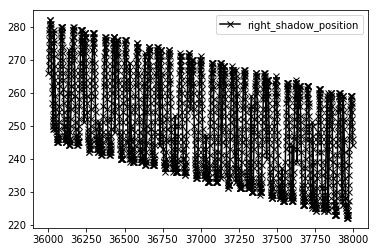

In [301]:
%matplotlib inline
import matplotlib.pyplot as plt
df_valid = df[df.valid ==True]
# print len(df)
# print len(df_valid)
df_valid.loc[36000:38000].plot(y='right_shadow_position', style='k-x')
print df_valid.imagename[36000]
print df_valid.imagename[38000]

### Find scan position in mm

In [313]:
df['image_scanrow_mm'] = df.image_scanrow.apply(lambda x: float(x)*scan_stepsize)
df['image_scancol_mm'] = df.image_scancol.apply(lambda x: float(x)*scan_stepsize)
# print df.head()

### Find shadow position in mm

In [312]:
df['right_shadow_position_mm'] = df.right_shadow_position.apply(lambda x: float(x)*pixelsize)
# print df.head()

### Correct shadow position for scan motion

nr8low_dyn_1_00008r1_00481.cbf


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:78: RuntimeWarning: divide by zero encountered in log


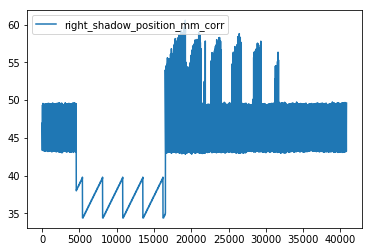

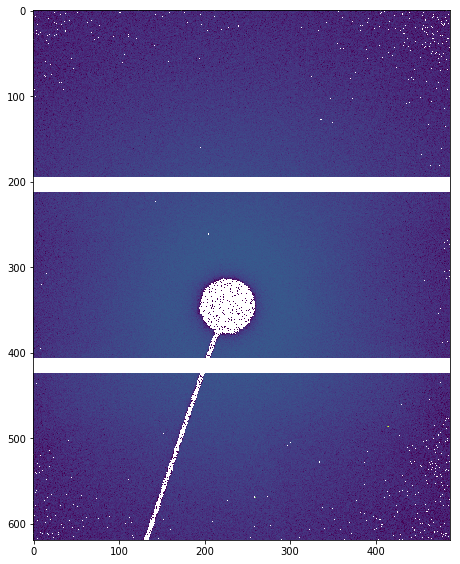

In [357]:
df['right_shadow_position_mm_corr'] = df.right_shadow_position_mm + 2.*df.image_scancol_mm
# print df.head()
df[:].plot(y='right_shadow_position_mm_corr')
imagedata = get_imagedata(df.imagename[17015])
print df.imagename[17015]
show_cbf(imagedata)
# df.plot(y='image_scancol_mm')

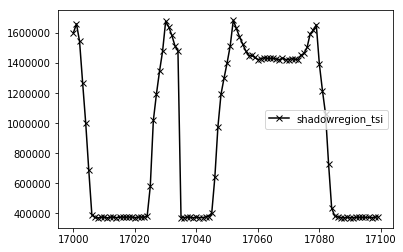

In [382]:
# df['shadowregion_tsi'] = df.imagename.apply(shadowregion_tsi)
df[17000:17100].plot(y='shadowregion_tsi', style='kx-')
# show_cbf(get_imagedata(df.imagename[17060]))

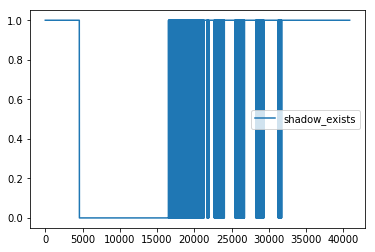

In [383]:
# all the same:
# df['shadow_exists'] = df.shadowregion_tsi.apply(lambda x: np.where(x>1e6, 1, 0))
# df.head()
# df['shadow_exists'] = np.where(df.shadowregion_tsi>1e6, 1, 0)
# df.head()
df['shadow_exists'] = (df.shadowregion_tsi>1e6).astype(int)
# df.head()
df.plot(y='shadow_exists')

### Mask out invalid images (too low tsi, no shadow)

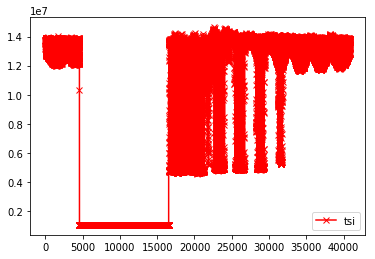

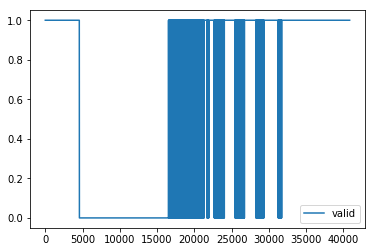

In [608]:
df.plot(y='tsi', style='r-x')
df['valid'] = (((df.tsi > .2e7) & df.shadow_exists) | (df.image_scanrow == 6)).astype(int)
df['valid'] = ((df.tsi > .2e7) & df.shadow_exists).astype(int)
df.plot(y='valid')
# show_cbf(get_imagedata(df.imagename[10000]))
# print df[5000:5050]
# print df.tail()

### Convert shadow position to nominal strain

42.868
49.76
25152


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:82: RuntimeWarning: divide by zero encountered in log


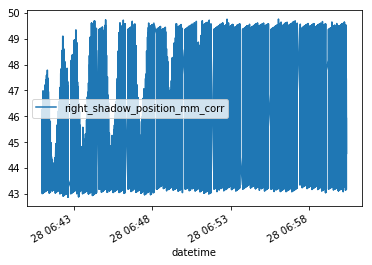

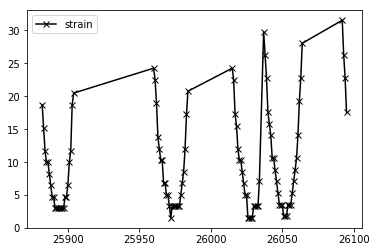

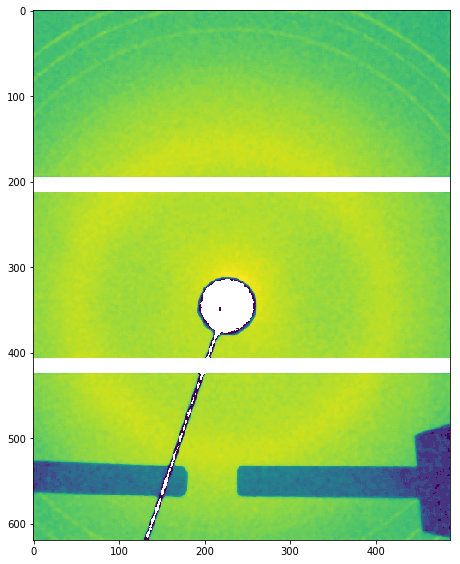

In [609]:
%matplotlib inline
df[df.valid==1].plot(x='datetime', y='right_shadow_position_mm_corr')
print df.right_shadow_position_mm_corr[df.valid==1].min()
print df.right_shadow_position_mm_corr[df.valid==1].max()
print len(df[df.valid==1])
df2 = df[df.valid==1]
df2['strain'] = shadow2strain(df2.right_shadow_position_mm_corr)
df2[11000:11100].plot(y='strain', style='k-x')
show_cbf(get_imagedata(df.imagename.loc[25900]))

### Assign strain gradient (loading or unloading)

In [610]:
# fumbling around with more complex determination of strain gradient 
# to avoid artefacts introduced from scanning or invalid shadows
# but this should do just fine, as a few wrong values don't affect the median as long as there are enough values close to the median
df2['strain_gradient'] = np.sign(np.gradient(df2.strain)).astype(int)
# df2.head()
# df2.tail()


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Explore method for degree of crystallinity computation from peak intensity

Int64Index([34076, 34077, 34078, 34079, 34080, 34081, 34082, 34083, 34084,
            34130, 34131, 34132, 34133],
           dtype='int64')


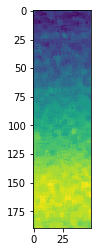

[25 26 27 28 29 30 70 71 72 73 74 75]


0.1858322838397173


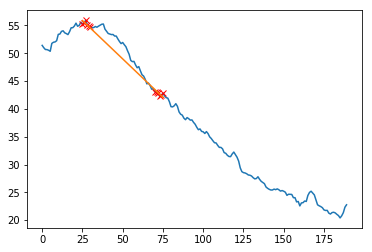

nr8low_dyn_1_00008r7_01348.cbf
0.196001197691551


In [662]:
%matplotlib inline
import matplotlib.pyplot as plt
# find an image with high crystallinity, i.e. large strain and located at the crack tip:
indices = df2.index[(df2.image_scanrow == 7) & (df2.image_scancol == 13) & (df2.strain > 62)]
# df.image_scanrow = df.image_scanrow.astype(int)
# df.image_scancol = df.image_scancol.astype(int)
# indices = df.index[(df.image_scanrow == 6)& (df.image_scancol == 13)]
# print df
print indices

# for idx in indices: # show those images that are under high strain at the crack tip
# #     print df2.imagename[idx], df2.strain[idx]
#     print idx, df.imagename[idx]
#     show_cbf(get_imagedata(df.imagename[idx])[0:200,:])
#     plt.show()
imagedata = get_imagedata(df.imagename[34082])
# show_cbf(imagedata)
imagedata = ndimage.median_filter(imagedata[:190,200:250], size=5)
# imagedata = imagedata[:190,200:250]
plt.imshow(np.log(imagedata))
plt.show()
y = np.average(imagedata,axis=1)[::-1]
plt.plot(y)
x1 = np.arange(25, 31)
x2 = np.arange(70, 76)
x3 = np.concatenate((x1, x2))
print x3
y3 = y[x3]
plt.plot(x3, y3, 'rx')
from lmfit.models import LinearModel
mod = LinearModel()
out = mod.fit(y3,x=x3)
xfit = np.arange(25,76)
yfit = out.eval(x=xfit)
plt.plot(xfit, yfit)
doc = np.sum(y[25:76]-yfit)/np.sum(y[25:31])
print doc
plt.show()
doc = get_doc(df.imagename[34082])
print doc


### Apply crystallinity calculation to all valid images

In [560]:
df2['doc'] = df2.imagename.apply(get_doc)


nr8low_dyn_1_00008r10_00001.cbf
nr8low_dyn_1_00008r10_00002.cbf
nr8low_dyn_1_00008r10_00003.cbf
nr8low_dyn_1_00008r10_00004.cbf
nr8low_dyn_1_00008r10_00005.cbf
nr8low_dyn_1_00008r10_00006.cbf
nr8low_dyn_1_00008r10_00007.cbf
nr8low_dyn_1_00008r10_00008.cbf
nr8low_dyn_1_00008r10_00009.cbf
nr8low_dyn_1_00008r10_00010.cbf
nr8low_dyn_1_00008r10_00011.cbf
nr8low_dyn_1_00008r10_00012.cbf
nr8low_dyn_1_00008r10_00013.cbf
nr8low_dyn_1_00008r10_00014.cbf
nr8low_dyn_1_00008r10_00015.cbf
nr8low_dyn_1_00008r10_00016.cbf
nr8low_dyn_1_00008r10_00017.cbf
nr8low_dyn_1_00008r10_00018.cbf
nr8low_dyn_1_00008r10_00019.cbf
nr8low_dyn_1_00008r10_00020.cbf
nr8low_dyn_1_00008r10_00021.cbf
nr8low_dyn_1_00008r10_00022.cbf
nr8low_dyn_1_00008r10_00023.cbf
nr8low_dyn_1_00008r10_00024.cbf
nr8low_dyn_1_00008r10_00025.cbf
nr8low_dyn_1_00008r10_00026.cbf
nr8low_dyn_1_00008r10_00027.cbf
nr8low_dyn_1_00008r10_00028.cbf
nr8low_dyn_1_00008r10_00029.cbf
nr8low_dyn_1_00008r10_00030.cbf
nr8low_dyn_1_00008r10_00031.cbf
nr8low_d

nr8low_dyn_1_00008r10_00257.cbf
nr8low_dyn_1_00008r10_00258.cbf
nr8low_dyn_1_00008r10_00259.cbf
nr8low_dyn_1_00008r10_00260.cbf
nr8low_dyn_1_00008r10_00261.cbf
nr8low_dyn_1_00008r10_00262.cbf
nr8low_dyn_1_00008r10_00263.cbf
nr8low_dyn_1_00008r10_00264.cbf
nr8low_dyn_1_00008r10_00265.cbf
nr8low_dyn_1_00008r10_00266.cbf
nr8low_dyn_1_00008r10_00267.cbf
nr8low_dyn_1_00008r10_00268.cbf
nr8low_dyn_1_00008r10_00269.cbf
nr8low_dyn_1_00008r10_00270.cbf
nr8low_dyn_1_00008r10_00271.cbf
nr8low_dyn_1_00008r10_00272.cbf
nr8low_dyn_1_00008r10_00273.cbf
nr8low_dyn_1_00008r10_00274.cbf
nr8low_dyn_1_00008r10_00275.cbf
nr8low_dyn_1_00008r10_00276.cbf
nr8low_dyn_1_00008r10_00277.cbf
nr8low_dyn_1_00008r10_00278.cbf
nr8low_dyn_1_00008r10_00279.cbf
nr8low_dyn_1_00008r10_00280.cbf
nr8low_dyn_1_00008r10_00281.cbf
nr8low_dyn_1_00008r10_00282.cbf
nr8low_dyn_1_00008r10_00283.cbf
nr8low_dyn_1_00008r10_00284.cbf
nr8low_dyn_1_00008r10_00285.cbf
nr8low_dyn_1_00008r10_00286.cbf
nr8low_dyn_1_00008r10_00287.cbf
nr8low_d

nr8low_dyn_1_00008r10_00513.cbf
nr8low_dyn_1_00008r10_00514.cbf
nr8low_dyn_1_00008r10_00515.cbf
nr8low_dyn_1_00008r10_00516.cbf
nr8low_dyn_1_00008r10_00517.cbf
nr8low_dyn_1_00008r10_00518.cbf
nr8low_dyn_1_00008r10_00519.cbf
nr8low_dyn_1_00008r10_00520.cbf
nr8low_dyn_1_00008r10_00521.cbf
nr8low_dyn_1_00008r10_00522.cbf
nr8low_dyn_1_00008r10_00523.cbf
nr8low_dyn_1_00008r10_00524.cbf
nr8low_dyn_1_00008r10_00525.cbf
nr8low_dyn_1_00008r10_00526.cbf
nr8low_dyn_1_00008r10_00527.cbf
nr8low_dyn_1_00008r10_00528.cbf
nr8low_dyn_1_00008r10_00529.cbf
nr8low_dyn_1_00008r10_00530.cbf
nr8low_dyn_1_00008r10_00531.cbf
nr8low_dyn_1_00008r10_00532.cbf
nr8low_dyn_1_00008r10_00533.cbf
nr8low_dyn_1_00008r10_00534.cbf
nr8low_dyn_1_00008r10_00535.cbf
nr8low_dyn_1_00008r10_00536.cbf
nr8low_dyn_1_00008r10_00537.cbf
nr8low_dyn_1_00008r10_00538.cbf
nr8low_dyn_1_00008r10_00539.cbf
nr8low_dyn_1_00008r10_00540.cbf
nr8low_dyn_1_00008r10_00541.cbf
nr8low_dyn_1_00008r10_00542.cbf
nr8low_dyn_1_00008r10_00543.cbf
nr8low_d

nr8low_dyn_1_00008r10_00769.cbf
nr8low_dyn_1_00008r10_00770.cbf
nr8low_dyn_1_00008r10_00771.cbf
nr8low_dyn_1_00008r10_00772.cbf
nr8low_dyn_1_00008r10_00773.cbf
nr8low_dyn_1_00008r10_00774.cbf
nr8low_dyn_1_00008r10_00775.cbf
nr8low_dyn_1_00008r10_00776.cbf
nr8low_dyn_1_00008r10_00777.cbf
nr8low_dyn_1_00008r10_00778.cbf
nr8low_dyn_1_00008r10_00779.cbf
nr8low_dyn_1_00008r10_00780.cbf
nr8low_dyn_1_00008r10_00781.cbf
nr8low_dyn_1_00008r10_00782.cbf
nr8low_dyn_1_00008r10_00783.cbf
nr8low_dyn_1_00008r10_00784.cbf
nr8low_dyn_1_00008r10_00785.cbf
nr8low_dyn_1_00008r10_00786.cbf
nr8low_dyn_1_00008r10_00787.cbf
nr8low_dyn_1_00008r10_00788.cbf
nr8low_dyn_1_00008r10_00789.cbf
nr8low_dyn_1_00008r10_00790.cbf
nr8low_dyn_1_00008r10_00791.cbf
nr8low_dyn_1_00008r10_00792.cbf
nr8low_dyn_1_00008r10_00793.cbf
nr8low_dyn_1_00008r10_00794.cbf
nr8low_dyn_1_00008r10_00795.cbf
nr8low_dyn_1_00008r10_00796.cbf
nr8low_dyn_1_00008r10_00797.cbf
nr8low_dyn_1_00008r10_00798.cbf
nr8low_dyn_1_00008r10_00799.cbf
nr8low_d

nr8low_dyn_1_00008r10_01025.cbf
nr8low_dyn_1_00008r10_01026.cbf
nr8low_dyn_1_00008r10_01027.cbf
nr8low_dyn_1_00008r10_01028.cbf
nr8low_dyn_1_00008r10_01029.cbf
nr8low_dyn_1_00008r10_01030.cbf
nr8low_dyn_1_00008r10_01031.cbf
nr8low_dyn_1_00008r10_01032.cbf
nr8low_dyn_1_00008r10_01033.cbf
nr8low_dyn_1_00008r10_01034.cbf
nr8low_dyn_1_00008r10_01035.cbf
nr8low_dyn_1_00008r10_01036.cbf
nr8low_dyn_1_00008r10_01037.cbf
nr8low_dyn_1_00008r10_01038.cbf
nr8low_dyn_1_00008r10_01039.cbf
nr8low_dyn_1_00008r10_01040.cbf
nr8low_dyn_1_00008r10_01041.cbf
nr8low_dyn_1_00008r10_01042.cbf
nr8low_dyn_1_00008r10_01043.cbf
nr8low_dyn_1_00008r10_01044.cbf
nr8low_dyn_1_00008r10_01045.cbf
nr8low_dyn_1_00008r10_01046.cbf
nr8low_dyn_1_00008r10_01047.cbf
nr8low_dyn_1_00008r10_01048.cbf
nr8low_dyn_1_00008r10_01049.cbf
nr8low_dyn_1_00008r10_01050.cbf
nr8low_dyn_1_00008r10_01051.cbf
nr8low_dyn_1_00008r10_01052.cbf
nr8low_dyn_1_00008r10_01053.cbf
nr8low_dyn_1_00008r10_01054.cbf
nr8low_dyn_1_00008r10_01055.cbf
nr8low_d

nr8low_dyn_1_00008r10_01281.cbf
nr8low_dyn_1_00008r10_01282.cbf
nr8low_dyn_1_00008r10_01283.cbf
nr8low_dyn_1_00008r10_01284.cbf
nr8low_dyn_1_00008r10_01285.cbf
nr8low_dyn_1_00008r10_01286.cbf
nr8low_dyn_1_00008r10_01287.cbf
nr8low_dyn_1_00008r10_01288.cbf
nr8low_dyn_1_00008r10_01289.cbf
nr8low_dyn_1_00008r10_01290.cbf
nr8low_dyn_1_00008r10_01291.cbf
nr8low_dyn_1_00008r10_01292.cbf
nr8low_dyn_1_00008r10_01293.cbf
nr8low_dyn_1_00008r10_01294.cbf
nr8low_dyn_1_00008r10_01295.cbf
nr8low_dyn_1_00008r10_01296.cbf
nr8low_dyn_1_00008r10_01297.cbf
nr8low_dyn_1_00008r10_01298.cbf
nr8low_dyn_1_00008r10_01299.cbf
nr8low_dyn_1_00008r10_01300.cbf
nr8low_dyn_1_00008r10_01301.cbf
nr8low_dyn_1_00008r10_01302.cbf
nr8low_dyn_1_00008r10_01303.cbf
nr8low_dyn_1_00008r10_01304.cbf
nr8low_dyn_1_00008r10_01305.cbf
nr8low_dyn_1_00008r10_01306.cbf
nr8low_dyn_1_00008r10_01307.cbf
nr8low_dyn_1_00008r10_01308.cbf
nr8low_dyn_1_00008r10_01309.cbf
nr8low_dyn_1_00008r10_01310.cbf
nr8low_dyn_1_00008r10_01311.cbf
nr8low_d

nr8low_dyn_1_00008r10_01537.cbf
nr8low_dyn_1_00008r10_01538.cbf
nr8low_dyn_1_00008r10_01539.cbf
nr8low_dyn_1_00008r10_01540.cbf
nr8low_dyn_1_00008r10_01541.cbf
nr8low_dyn_1_00008r10_01542.cbf
nr8low_dyn_1_00008r10_01543.cbf
nr8low_dyn_1_00008r10_01544.cbf
nr8low_dyn_1_00008r10_01545.cbf
nr8low_dyn_1_00008r10_01546.cbf
nr8low_dyn_1_00008r10_01547.cbf
nr8low_dyn_1_00008r10_01548.cbf
nr8low_dyn_1_00008r10_01549.cbf
nr8low_dyn_1_00008r10_01550.cbf
nr8low_dyn_1_00008r10_01551.cbf
nr8low_dyn_1_00008r10_01552.cbf
nr8low_dyn_1_00008r10_01553.cbf
nr8low_dyn_1_00008r10_01554.cbf
nr8low_dyn_1_00008r10_01555.cbf
nr8low_dyn_1_00008r10_01556.cbf
nr8low_dyn_1_00008r10_01557.cbf
nr8low_dyn_1_00008r10_01558.cbf
nr8low_dyn_1_00008r10_01559.cbf
nr8low_dyn_1_00008r10_01560.cbf
nr8low_dyn_1_00008r10_01561.cbf
nr8low_dyn_1_00008r10_01562.cbf
nr8low_dyn_1_00008r10_01563.cbf
nr8low_dyn_1_00008r10_01564.cbf
nr8low_dyn_1_00008r10_01565.cbf
nr8low_dyn_1_00008r10_01566.cbf
nr8low_dyn_1_00008r10_01567.cbf
nr8low_d

nr8low_dyn_1_00008r10_01793.cbf
nr8low_dyn_1_00008r10_01794.cbf
nr8low_dyn_1_00008r10_01795.cbf
nr8low_dyn_1_00008r10_01796.cbf
nr8low_dyn_1_00008r10_01797.cbf
nr8low_dyn_1_00008r10_01798.cbf
nr8low_dyn_1_00008r10_01799.cbf
nr8low_dyn_1_00008r10_01800.cbf
nr8low_dyn_1_00008r10_01801.cbf
nr8low_dyn_1_00008r10_01802.cbf
nr8low_dyn_1_00008r10_01803.cbf
nr8low_dyn_1_00008r10_01804.cbf
nr8low_dyn_1_00008r10_01805.cbf
nr8low_dyn_1_00008r10_01806.cbf
nr8low_dyn_1_00008r10_01807.cbf
nr8low_dyn_1_00008r10_01808.cbf
nr8low_dyn_1_00008r10_01809.cbf
nr8low_dyn_1_00008r10_01810.cbf
nr8low_dyn_1_00008r10_01811.cbf
nr8low_dyn_1_00008r10_01812.cbf
nr8low_dyn_1_00008r10_01813.cbf
nr8low_dyn_1_00008r10_01814.cbf
nr8low_dyn_1_00008r10_01815.cbf
nr8low_dyn_1_00008r10_01816.cbf
nr8low_dyn_1_00008r10_01817.cbf
nr8low_dyn_1_00008r10_01818.cbf
nr8low_dyn_1_00008r10_01819.cbf
nr8low_dyn_1_00008r10_01820.cbf
nr8low_dyn_1_00008r10_01821.cbf
nr8low_dyn_1_00008r10_01822.cbf
nr8low_dyn_1_00008r10_01823.cbf
nr8low_d

nr8low_dyn_1_00008r10_02049.cbf
nr8low_dyn_1_00008r10_02050.cbf
nr8low_dyn_1_00008r10_02051.cbf
nr8low_dyn_1_00008r10_02052.cbf
nr8low_dyn_1_00008r10_02053.cbf
nr8low_dyn_1_00008r10_02054.cbf
nr8low_dyn_1_00008r10_02055.cbf
nr8low_dyn_1_00008r10_02056.cbf
nr8low_dyn_1_00008r10_02057.cbf
nr8low_dyn_1_00008r10_02058.cbf
nr8low_dyn_1_00008r10_02059.cbf
nr8low_dyn_1_00008r10_02060.cbf
nr8low_dyn_1_00008r10_02061.cbf
nr8low_dyn_1_00008r10_02062.cbf
nr8low_dyn_1_00008r10_02063.cbf
nr8low_dyn_1_00008r10_02064.cbf
nr8low_dyn_1_00008r10_02065.cbf
nr8low_dyn_1_00008r10_02066.cbf
nr8low_dyn_1_00008r10_02067.cbf
nr8low_dyn_1_00008r10_02068.cbf
nr8low_dyn_1_00008r10_02069.cbf
nr8low_dyn_1_00008r10_02070.cbf
nr8low_dyn_1_00008r10_02071.cbf
nr8low_dyn_1_00008r10_02072.cbf
nr8low_dyn_1_00008r10_02073.cbf
nr8low_dyn_1_00008r10_02074.cbf
nr8low_dyn_1_00008r10_02075.cbf
nr8low_dyn_1_00008r10_02076.cbf
nr8low_dyn_1_00008r10_02077.cbf
nr8low_dyn_1_00008r10_02078.cbf
nr8low_dyn_1_00008r10_02079.cbf
nr8low_d

nr8low_dyn_1_00008r10_02305.cbf
nr8low_dyn_1_00008r10_02306.cbf
nr8low_dyn_1_00008r10_02307.cbf
nr8low_dyn_1_00008r10_02308.cbf
nr8low_dyn_1_00008r10_02309.cbf
nr8low_dyn_1_00008r10_02310.cbf
nr8low_dyn_1_00008r10_02311.cbf
nr8low_dyn_1_00008r10_02312.cbf
nr8low_dyn_1_00008r10_02313.cbf
nr8low_dyn_1_00008r10_02314.cbf
nr8low_dyn_1_00008r10_02315.cbf
nr8low_dyn_1_00008r10_02316.cbf
nr8low_dyn_1_00008r10_02317.cbf
nr8low_dyn_1_00008r10_02318.cbf
nr8low_dyn_1_00008r10_02319.cbf
nr8low_dyn_1_00008r10_02320.cbf
nr8low_dyn_1_00008r10_02321.cbf
nr8low_dyn_1_00008r10_02322.cbf
nr8low_dyn_1_00008r10_02323.cbf
nr8low_dyn_1_00008r10_02324.cbf
nr8low_dyn_1_00008r10_02325.cbf
nr8low_dyn_1_00008r10_02326.cbf
nr8low_dyn_1_00008r10_02327.cbf
nr8low_dyn_1_00008r10_02328.cbf
nr8low_dyn_1_00008r10_02329.cbf
nr8low_dyn_1_00008r10_02330.cbf
nr8low_dyn_1_00008r10_02331.cbf
nr8low_dyn_1_00008r10_02332.cbf
nr8low_dyn_1_00008r10_02333.cbf
nr8low_dyn_1_00008r10_02334.cbf
nr8low_dyn_1_00008r10_02335.cbf
nr8low_d

nr8low_dyn_1_00008r10_02561.cbf
nr8low_dyn_1_00008r10_02562.cbf
nr8low_dyn_1_00008r10_02563.cbf
nr8low_dyn_1_00008r10_02564.cbf
nr8low_dyn_1_00008r10_02565.cbf
nr8low_dyn_1_00008r10_02566.cbf
nr8low_dyn_1_00008r10_02567.cbf
nr8low_dyn_1_00008r10_02568.cbf
nr8low_dyn_1_00008r10_02569.cbf
nr8low_dyn_1_00008r10_02570.cbf
nr8low_dyn_1_00008r10_02571.cbf
nr8low_dyn_1_00008r10_02572.cbf
nr8low_dyn_1_00008r10_02573.cbf
nr8low_dyn_1_00008r10_02574.cbf
nr8low_dyn_1_00008r10_02575.cbf
nr8low_dyn_1_00008r10_02576.cbf
nr8low_dyn_1_00008r10_02577.cbf
nr8low_dyn_1_00008r10_02578.cbf
nr8low_dyn_1_00008r10_02579.cbf
nr8low_dyn_1_00008r10_02580.cbf
nr8low_dyn_1_00008r10_02581.cbf
nr8low_dyn_1_00008r10_02582.cbf
nr8low_dyn_1_00008r10_02583.cbf
nr8low_dyn_1_00008r10_02584.cbf
nr8low_dyn_1_00008r10_02585.cbf
nr8low_dyn_1_00008r10_02586.cbf
nr8low_dyn_1_00008r10_02587.cbf
nr8low_dyn_1_00008r10_02588.cbf
nr8low_dyn_1_00008r10_02589.cbf
nr8low_dyn_1_00008r10_02590.cbf
nr8low_dyn_1_00008r10_02591.cbf
nr8low_d

nr8low_dyn_1_00008r11_00117.cbf
nr8low_dyn_1_00008r11_00118.cbf
nr8low_dyn_1_00008r11_00119.cbf
nr8low_dyn_1_00008r11_00120.cbf
nr8low_dyn_1_00008r11_00121.cbf
nr8low_dyn_1_00008r11_00122.cbf
nr8low_dyn_1_00008r11_00123.cbf
nr8low_dyn_1_00008r11_00124.cbf
nr8low_dyn_1_00008r11_00125.cbf
nr8low_dyn_1_00008r11_00126.cbf
nr8low_dyn_1_00008r11_00127.cbf
nr8low_dyn_1_00008r11_00128.cbf
nr8low_dyn_1_00008r11_00129.cbf
nr8low_dyn_1_00008r11_00130.cbf
nr8low_dyn_1_00008r11_00131.cbf
nr8low_dyn_1_00008r11_00132.cbf
nr8low_dyn_1_00008r11_00133.cbf
nr8low_dyn_1_00008r11_00134.cbf
nr8low_dyn_1_00008r11_00135.cbf
nr8low_dyn_1_00008r11_00136.cbf
nr8low_dyn_1_00008r11_00137.cbf
nr8low_dyn_1_00008r11_00138.cbf
nr8low_dyn_1_00008r11_00139.cbf
nr8low_dyn_1_00008r11_00140.cbf
nr8low_dyn_1_00008r11_00141.cbf
nr8low_dyn_1_00008r11_00142.cbf
nr8low_dyn_1_00008r11_00143.cbf
nr8low_dyn_1_00008r11_00144.cbf
nr8low_dyn_1_00008r11_00145.cbf
nr8low_dyn_1_00008r11_00146.cbf
nr8low_dyn_1_00008r11_00147.cbf
nr8low_d

nr8low_dyn_1_00008r11_00374.cbf
nr8low_dyn_1_00008r11_00375.cbf
nr8low_dyn_1_00008r11_00376.cbf
nr8low_dyn_1_00008r11_00377.cbf
nr8low_dyn_1_00008r11_00378.cbf
nr8low_dyn_1_00008r11_00379.cbf
nr8low_dyn_1_00008r11_00380.cbf
nr8low_dyn_1_00008r11_00381.cbf
nr8low_dyn_1_00008r11_00382.cbf
nr8low_dyn_1_00008r11_00383.cbf
nr8low_dyn_1_00008r11_00384.cbf
nr8low_dyn_1_00008r11_00385.cbf
nr8low_dyn_1_00008r11_00386.cbf
nr8low_dyn_1_00008r11_00387.cbf
nr8low_dyn_1_00008r11_00388.cbf
nr8low_dyn_1_00008r11_00389.cbf
nr8low_dyn_1_00008r11_00390.cbf
nr8low_dyn_1_00008r11_00391.cbf
nr8low_dyn_1_00008r11_00392.cbf
nr8low_dyn_1_00008r11_00393.cbf
nr8low_dyn_1_00008r11_00394.cbf
nr8low_dyn_1_00008r11_00395.cbf
nr8low_dyn_1_00008r11_00396.cbf
nr8low_dyn_1_00008r11_00397.cbf
nr8low_dyn_1_00008r11_00398.cbf
nr8low_dyn_1_00008r11_00399.cbf
nr8low_dyn_1_00008r11_00400.cbf
nr8low_dyn_1_00008r11_00401.cbf
nr8low_dyn_1_00008r11_00402.cbf
nr8low_dyn_1_00008r11_00403.cbf
nr8low_dyn_1_00008r11_00404.cbf
nr8low_d

nr8low_dyn_1_00008r11_00630.cbf
nr8low_dyn_1_00008r11_00631.cbf
nr8low_dyn_1_00008r11_00632.cbf
nr8low_dyn_1_00008r11_00633.cbf
nr8low_dyn_1_00008r11_00634.cbf
nr8low_dyn_1_00008r11_00635.cbf
nr8low_dyn_1_00008r11_00636.cbf
nr8low_dyn_1_00008r11_00637.cbf
nr8low_dyn_1_00008r11_00638.cbf
nr8low_dyn_1_00008r11_00639.cbf
nr8low_dyn_1_00008r11_00640.cbf
nr8low_dyn_1_00008r11_00641.cbf
nr8low_dyn_1_00008r11_00642.cbf
nr8low_dyn_1_00008r11_00643.cbf
nr8low_dyn_1_00008r11_00644.cbf
nr8low_dyn_1_00008r11_00645.cbf
nr8low_dyn_1_00008r11_00646.cbf
nr8low_dyn_1_00008r11_00647.cbf
nr8low_dyn_1_00008r11_00648.cbf
nr8low_dyn_1_00008r11_00649.cbf
nr8low_dyn_1_00008r11_00650.cbf
nr8low_dyn_1_00008r11_00651.cbf
nr8low_dyn_1_00008r11_00652.cbf
nr8low_dyn_1_00008r11_00653.cbf
nr8low_dyn_1_00008r11_00654.cbf
nr8low_dyn_1_00008r11_00655.cbf
nr8low_dyn_1_00008r11_00656.cbf
nr8low_dyn_1_00008r11_00657.cbf
nr8low_dyn_1_00008r11_00658.cbf
nr8low_dyn_1_00008r11_00659.cbf
nr8low_dyn_1_00008r11_00660.cbf
nr8low_d

nr8low_dyn_1_00008r11_00886.cbf
nr8low_dyn_1_00008r11_00887.cbf
nr8low_dyn_1_00008r11_00888.cbf
nr8low_dyn_1_00008r11_00889.cbf
nr8low_dyn_1_00008r11_00890.cbf
nr8low_dyn_1_00008r11_00891.cbf
nr8low_dyn_1_00008r11_00892.cbf
nr8low_dyn_1_00008r11_00893.cbf
nr8low_dyn_1_00008r11_00894.cbf
nr8low_dyn_1_00008r11_00895.cbf
nr8low_dyn_1_00008r11_00896.cbf
nr8low_dyn_1_00008r11_00897.cbf
nr8low_dyn_1_00008r11_00898.cbf
nr8low_dyn_1_00008r11_00899.cbf
nr8low_dyn_1_00008r11_00900.cbf
nr8low_dyn_1_00008r11_00901.cbf
nr8low_dyn_1_00008r11_00902.cbf
nr8low_dyn_1_00008r11_00903.cbf
nr8low_dyn_1_00008r11_00904.cbf
nr8low_dyn_1_00008r11_00905.cbf
nr8low_dyn_1_00008r11_00906.cbf
nr8low_dyn_1_00008r11_00907.cbf
nr8low_dyn_1_00008r11_00908.cbf
nr8low_dyn_1_00008r11_00909.cbf
nr8low_dyn_1_00008r11_00910.cbf
nr8low_dyn_1_00008r11_00911.cbf
nr8low_dyn_1_00008r11_00912.cbf
nr8low_dyn_1_00008r11_00913.cbf
nr8low_dyn_1_00008r11_00914.cbf
nr8low_dyn_1_00008r11_00915.cbf
nr8low_dyn_1_00008r11_00916.cbf
nr8low_d

nr8low_dyn_1_00008r11_01142.cbf
nr8low_dyn_1_00008r11_01143.cbf
nr8low_dyn_1_00008r11_01144.cbf
nr8low_dyn_1_00008r11_01145.cbf
nr8low_dyn_1_00008r11_01146.cbf
nr8low_dyn_1_00008r11_01147.cbf
nr8low_dyn_1_00008r11_01148.cbf
nr8low_dyn_1_00008r11_01149.cbf
nr8low_dyn_1_00008r11_01150.cbf
nr8low_dyn_1_00008r11_01151.cbf
nr8low_dyn_1_00008r11_01152.cbf
nr8low_dyn_1_00008r11_01153.cbf
nr8low_dyn_1_00008r11_01154.cbf
nr8low_dyn_1_00008r11_01155.cbf
nr8low_dyn_1_00008r11_01156.cbf
nr8low_dyn_1_00008r11_01157.cbf
nr8low_dyn_1_00008r11_01158.cbf
nr8low_dyn_1_00008r11_01159.cbf
nr8low_dyn_1_00008r11_01160.cbf
nr8low_dyn_1_00008r11_01161.cbf
nr8low_dyn_1_00008r11_01162.cbf
nr8low_dyn_1_00008r11_01163.cbf
nr8low_dyn_1_00008r11_01164.cbf
nr8low_dyn_1_00008r11_01165.cbf
nr8low_dyn_1_00008r11_01166.cbf
nr8low_dyn_1_00008r11_01167.cbf
nr8low_dyn_1_00008r11_01168.cbf
nr8low_dyn_1_00008r11_01169.cbf
nr8low_dyn_1_00008r11_01170.cbf
nr8low_dyn_1_00008r11_01171.cbf
nr8low_dyn_1_00008r11_01172.cbf
nr8low_d

nr8low_dyn_1_00008r11_01398.cbf
nr8low_dyn_1_00008r11_01399.cbf
nr8low_dyn_1_00008r11_01400.cbf
nr8low_dyn_1_00008r11_01401.cbf
nr8low_dyn_1_00008r11_01402.cbf
nr8low_dyn_1_00008r11_01403.cbf
nr8low_dyn_1_00008r11_01404.cbf
nr8low_dyn_1_00008r11_01405.cbf
nr8low_dyn_1_00008r11_01406.cbf
nr8low_dyn_1_00008r11_01407.cbf
nr8low_dyn_1_00008r11_01408.cbf
nr8low_dyn_1_00008r11_01409.cbf
nr8low_dyn_1_00008r11_01410.cbf
nr8low_dyn_1_00008r11_01411.cbf
nr8low_dyn_1_00008r11_01412.cbf
nr8low_dyn_1_00008r11_01413.cbf
nr8low_dyn_1_00008r11_01414.cbf
nr8low_dyn_1_00008r11_01415.cbf
nr8low_dyn_1_00008r11_01416.cbf
nr8low_dyn_1_00008r11_01417.cbf
nr8low_dyn_1_00008r11_01418.cbf
nr8low_dyn_1_00008r11_01419.cbf
nr8low_dyn_1_00008r11_01420.cbf
nr8low_dyn_1_00008r11_01421.cbf
nr8low_dyn_1_00008r11_01422.cbf
nr8low_dyn_1_00008r11_01423.cbf
nr8low_dyn_1_00008r11_01424.cbf
nr8low_dyn_1_00008r11_01425.cbf
nr8low_dyn_1_00008r11_01426.cbf
nr8low_dyn_1_00008r11_01427.cbf
nr8low_dyn_1_00008r11_01428.cbf
nr8low_d

nr8low_dyn_1_00008r11_01654.cbf
nr8low_dyn_1_00008r11_01655.cbf
nr8low_dyn_1_00008r11_01656.cbf
nr8low_dyn_1_00008r11_01657.cbf
nr8low_dyn_1_00008r11_01658.cbf
nr8low_dyn_1_00008r11_01659.cbf
nr8low_dyn_1_00008r11_01660.cbf
nr8low_dyn_1_00008r11_01661.cbf
nr8low_dyn_1_00008r11_01662.cbf
nr8low_dyn_1_00008r11_01663.cbf
nr8low_dyn_1_00008r11_01664.cbf
nr8low_dyn_1_00008r11_01665.cbf
nr8low_dyn_1_00008r11_01666.cbf
nr8low_dyn_1_00008r11_01667.cbf
nr8low_dyn_1_00008r11_01668.cbf
nr8low_dyn_1_00008r11_01669.cbf
nr8low_dyn_1_00008r11_01670.cbf
nr8low_dyn_1_00008r11_01671.cbf
nr8low_dyn_1_00008r11_01672.cbf
nr8low_dyn_1_00008r11_01673.cbf
nr8low_dyn_1_00008r11_01674.cbf
nr8low_dyn_1_00008r11_01675.cbf
nr8low_dyn_1_00008r11_01676.cbf
nr8low_dyn_1_00008r11_01677.cbf
nr8low_dyn_1_00008r11_01678.cbf
nr8low_dyn_1_00008r11_01679.cbf
nr8low_dyn_1_00008r11_01680.cbf
nr8low_dyn_1_00008r11_01681.cbf
nr8low_dyn_1_00008r11_01682.cbf
nr8low_dyn_1_00008r11_01683.cbf
nr8low_dyn_1_00008r11_01684.cbf
nr8low_d

nr8low_dyn_1_00008r1_00097.cbf
nr8low_dyn_1_00008r1_00098.cbf
nr8low_dyn_1_00008r1_00099.cbf
nr8low_dyn_1_00008r1_00100.cbf
nr8low_dyn_1_00008r1_00104.cbf
nr8low_dyn_1_00008r1_00105.cbf
nr8low_dyn_1_00008r1_00106.cbf
nr8low_dyn_1_00008r1_00107.cbf
nr8low_dyn_1_00008r1_00108.cbf
nr8low_dyn_1_00008r1_00109.cbf
nr8low_dyn_1_00008r1_00110.cbf
nr8low_dyn_1_00008r1_00111.cbf
nr8low_dyn_1_00008r1_00112.cbf
nr8low_dyn_1_00008r1_00113.cbf
nr8low_dyn_1_00008r1_00114.cbf
nr8low_dyn_1_00008r1_00115.cbf
nr8low_dyn_1_00008r1_00116.cbf
nr8low_dyn_1_00008r1_00117.cbf
nr8low_dyn_1_00008r1_00118.cbf
nr8low_dyn_1_00008r1_00119.cbf
nr8low_dyn_1_00008r1_00120.cbf
nr8low_dyn_1_00008r1_00121.cbf
nr8low_dyn_1_00008r1_00122.cbf
nr8low_dyn_1_00008r1_00123.cbf
nr8low_dyn_1_00008r1_00124.cbf
nr8low_dyn_1_00008r1_00125.cbf
nr8low_dyn_1_00008r1_00126.cbf
nr8low_dyn_1_00008r1_00127.cbf
nr8low_dyn_1_00008r1_00128.cbf
nr8low_dyn_1_00008r1_00129.cbf
nr8low_dyn_1_00008r1_00130.cbf
nr8low_dyn_1_00008r1_00131.cbf
nr8low_d

nr8low_dyn_1_00008r1_00540.cbf
nr8low_dyn_1_00008r1_00541.cbf
nr8low_dyn_1_00008r1_00542.cbf
nr8low_dyn_1_00008r1_00543.cbf
nr8low_dyn_1_00008r1_00544.cbf
nr8low_dyn_1_00008r1_00545.cbf
nr8low_dyn_1_00008r1_00546.cbf
nr8low_dyn_1_00008r1_00547.cbf
nr8low_dyn_1_00008r1_00548.cbf
nr8low_dyn_1_00008r1_00569.cbf
nr8low_dyn_1_00008r1_00570.cbf
nr8low_dyn_1_00008r1_00571.cbf
nr8low_dyn_1_00008r1_00572.cbf
nr8low_dyn_1_00008r1_00573.cbf
nr8low_dyn_1_00008r1_00574.cbf
nr8low_dyn_1_00008r1_00575.cbf
nr8low_dyn_1_00008r1_00576.cbf
nr8low_dyn_1_00008r1_00577.cbf
nr8low_dyn_1_00008r1_00578.cbf
nr8low_dyn_1_00008r1_00579.cbf
nr8low_dyn_1_00008r1_00580.cbf
nr8low_dyn_1_00008r1_00581.cbf
nr8low_dyn_1_00008r1_00582.cbf
nr8low_dyn_1_00008r1_00583.cbf
nr8low_dyn_1_00008r1_00584.cbf
nr8low_dyn_1_00008r1_00585.cbf
nr8low_dyn_1_00008r1_00586.cbf
nr8low_dyn_1_00008r1_00587.cbf
nr8low_dyn_1_00008r1_00588.cbf
nr8low_dyn_1_00008r1_00589.cbf
nr8low_dyn_1_00008r1_00590.cbf
nr8low_dyn_1_00008r1_00591.cbf
nr8low_d

nr8low_dyn_1_00008r1_01124.cbf
nr8low_dyn_1_00008r1_01125.cbf
nr8low_dyn_1_00008r1_01126.cbf
nr8low_dyn_1_00008r1_01127.cbf
nr8low_dyn_1_00008r1_01169.cbf
nr8low_dyn_1_00008r1_01170.cbf
nr8low_dyn_1_00008r1_01171.cbf
nr8low_dyn_1_00008r1_01172.cbf
nr8low_dyn_1_00008r1_01173.cbf
nr8low_dyn_1_00008r1_01174.cbf
nr8low_dyn_1_00008r1_01175.cbf
nr8low_dyn_1_00008r1_01176.cbf
nr8low_dyn_1_00008r1_01177.cbf
nr8low_dyn_1_00008r1_01178.cbf
nr8low_dyn_1_00008r1_01179.cbf
nr8low_dyn_1_00008r1_01180.cbf
nr8low_dyn_1_00008r1_01181.cbf
nr8low_dyn_1_00008r1_01182.cbf
nr8low_dyn_1_00008r1_01183.cbf
nr8low_dyn_1_00008r1_01201.cbf
nr8low_dyn_1_00008r1_01202.cbf
nr8low_dyn_1_00008r1_01203.cbf
nr8low_dyn_1_00008r1_01204.cbf
nr8low_dyn_1_00008r1_01205.cbf
nr8low_dyn_1_00008r1_01206.cbf
nr8low_dyn_1_00008r1_01207.cbf
nr8low_dyn_1_00008r1_01246.cbf
nr8low_dyn_1_00008r1_01247.cbf
nr8low_dyn_1_00008r1_01248.cbf
nr8low_dyn_1_00008r1_01249.cbf
nr8low_dyn_1_00008r1_01250.cbf
nr8low_dyn_1_00008r1_01251.cbf
nr8low_d

nr8low_dyn_1_00008r1_01756.cbf
nr8low_dyn_1_00008r1_01757.cbf
nr8low_dyn_1_00008r1_01758.cbf
nr8low_dyn_1_00008r1_01759.cbf
nr8low_dyn_1_00008r1_01760.cbf
nr8low_dyn_1_00008r1_01761.cbf
nr8low_dyn_1_00008r1_01762.cbf
nr8low_dyn_1_00008r1_01763.cbf
nr8low_dyn_1_00008r1_01764.cbf
nr8low_dyn_1_00008r1_01765.cbf
nr8low_dyn_1_00008r1_01766.cbf
nr8low_dyn_1_00008r1_01767.cbf
nr8low_dyn_1_00008r1_01768.cbf
nr8low_dyn_1_00008r1_01769.cbf
nr8low_dyn_1_00008r1_01770.cbf
nr8low_dyn_1_00008r1_01771.cbf
nr8low_dyn_1_00008r1_01772.cbf
nr8low_dyn_1_00008r1_01773.cbf
nr8low_dyn_1_00008r1_01774.cbf
nr8low_dyn_1_00008r1_01775.cbf
nr8low_dyn_1_00008r1_01776.cbf
nr8low_dyn_1_00008r1_01777.cbf
nr8low_dyn_1_00008r1_01801.cbf
nr8low_dyn_1_00008r1_01802.cbf
nr8low_dyn_1_00008r1_01803.cbf
nr8low_dyn_1_00008r1_01825.cbf
nr8low_dyn_1_00008r1_01826.cbf
nr8low_dyn_1_00008r1_01827.cbf
nr8low_dyn_1_00008r1_01828.cbf
nr8low_dyn_1_00008r1_01829.cbf
nr8low_dyn_1_00008r1_01830.cbf
nr8low_dyn_1_00008r1_01831.cbf
nr8low_d

nr8low_dyn_1_00008r1_02144.cbf
nr8low_dyn_1_00008r1_02145.cbf
nr8low_dyn_1_00008r1_02146.cbf
nr8low_dyn_1_00008r1_02147.cbf
nr8low_dyn_1_00008r1_02148.cbf
nr8low_dyn_1_00008r1_02149.cbf
nr8low_dyn_1_00008r1_02150.cbf
nr8low_dyn_1_00008r1_02166.cbf
nr8low_dyn_1_00008r1_02167.cbf
nr8low_dyn_1_00008r1_02168.cbf
nr8low_dyn_1_00008r1_02169.cbf
nr8low_dyn_1_00008r1_02170.cbf
nr8low_dyn_1_00008r1_02171.cbf
nr8low_dyn_1_00008r1_02172.cbf
nr8low_dyn_1_00008r1_02173.cbf
nr8low_dyn_1_00008r1_02174.cbf
nr8low_dyn_1_00008r1_02175.cbf
nr8low_dyn_1_00008r1_02176.cbf
nr8low_dyn_1_00008r1_02177.cbf
nr8low_dyn_1_00008r1_02178.cbf
nr8low_dyn_1_00008r1_02179.cbf
nr8low_dyn_1_00008r1_02180.cbf
nr8low_dyn_1_00008r1_02181.cbf
nr8low_dyn_1_00008r1_02182.cbf
nr8low_dyn_1_00008r1_02183.cbf
nr8low_dyn_1_00008r1_02184.cbf
nr8low_dyn_1_00008r1_02185.cbf
nr8low_dyn_1_00008r1_02186.cbf
nr8low_dyn_1_00008r1_02187.cbf
nr8low_dyn_1_00008r1_02188.cbf
nr8low_dyn_1_00008r1_02189.cbf
nr8low_dyn_1_00008r1_02190.cbf
nr8low_d

nr8low_dyn_1_00008r1_02547.cbf
nr8low_dyn_1_00008r1_02548.cbf
nr8low_dyn_1_00008r1_02549.cbf
nr8low_dyn_1_00008r1_02550.cbf
nr8low_dyn_1_00008r1_02551.cbf
nr8low_dyn_1_00008r1_02552.cbf
nr8low_dyn_1_00008r1_02553.cbf
nr8low_dyn_1_00008r1_02554.cbf
nr8low_dyn_1_00008r1_02555.cbf
nr8low_dyn_1_00008r1_02556.cbf
nr8low_dyn_1_00008r1_02557.cbf
nr8low_dyn_1_00008r1_02558.cbf
nr8low_dyn_1_00008r1_02559.cbf
nr8low_dyn_1_00008r1_02560.cbf
nr8low_dyn_1_00008r1_02561.cbf
nr8low_dyn_1_00008r1_02562.cbf
nr8low_dyn_1_00008r1_02563.cbf
nr8low_dyn_1_00008r1_02564.cbf
nr8low_dyn_1_00008r1_02565.cbf
nr8low_dyn_1_00008r1_02566.cbf
nr8low_dyn_1_00008r1_02567.cbf
nr8low_dyn_1_00008r1_02568.cbf
nr8low_dyn_1_00008r1_02569.cbf
nr8low_dyn_1_00008r1_02570.cbf
nr8low_dyn_1_00008r1_02571.cbf
nr8low_dyn_1_00008r1_02572.cbf
nr8low_dyn_1_00008r1_02573.cbf
nr8low_dyn_1_00008r1_02574.cbf
nr8low_dyn_1_00008r1_02575.cbf
nr8low_dyn_1_00008r1_02576.cbf
nr8low_dyn_1_00008r1_02577.cbf
nr8low_dyn_1_00008r1_02578.cbf
nr8low_d

nr8low_dyn_1_00008r2_00254.cbf
nr8low_dyn_1_00008r2_00255.cbf
nr8low_dyn_1_00008r2_00256.cbf
nr8low_dyn_1_00008r2_00257.cbf
nr8low_dyn_1_00008r2_00258.cbf
nr8low_dyn_1_00008r2_00259.cbf
nr8low_dyn_1_00008r2_00260.cbf
nr8low_dyn_1_00008r2_00261.cbf
nr8low_dyn_1_00008r2_00262.cbf
nr8low_dyn_1_00008r2_00263.cbf
nr8low_dyn_1_00008r2_00264.cbf
nr8low_dyn_1_00008r2_00265.cbf
nr8low_dyn_1_00008r2_00266.cbf
nr8low_dyn_1_00008r2_00267.cbf
nr8low_dyn_1_00008r2_00268.cbf
nr8low_dyn_1_00008r2_00269.cbf
nr8low_dyn_1_00008r2_00270.cbf
nr8low_dyn_1_00008r2_00271.cbf
nr8low_dyn_1_00008r2_00272.cbf
nr8low_dyn_1_00008r2_00273.cbf
nr8low_dyn_1_00008r2_00274.cbf
nr8low_dyn_1_00008r2_00275.cbf
nr8low_dyn_1_00008r2_00276.cbf
nr8low_dyn_1_00008r2_00277.cbf
nr8low_dyn_1_00008r2_00278.cbf
nr8low_dyn_1_00008r2_00279.cbf
nr8low_dyn_1_00008r2_00280.cbf
nr8low_dyn_1_00008r2_00281.cbf
nr8low_dyn_1_00008r2_00282.cbf
nr8low_dyn_1_00008r2_00283.cbf
nr8low_dyn_1_00008r2_00284.cbf
nr8low_dyn_1_00008r2_00285.cbf
nr8low_d

nr8low_dyn_1_00008r2_00571.cbf
nr8low_dyn_1_00008r2_00572.cbf
nr8low_dyn_1_00008r2_00573.cbf
nr8low_dyn_1_00008r2_00574.cbf
nr8low_dyn_1_00008r2_00575.cbf
nr8low_dyn_1_00008r2_00576.cbf
nr8low_dyn_1_00008r2_00577.cbf
nr8low_dyn_1_00008r2_00578.cbf
nr8low_dyn_1_00008r2_00579.cbf
nr8low_dyn_1_00008r2_00580.cbf
nr8low_dyn_1_00008r2_00581.cbf
nr8low_dyn_1_00008r2_00582.cbf
nr8low_dyn_1_00008r2_00590.cbf
nr8low_dyn_1_00008r2_00591.cbf
nr8low_dyn_1_00008r2_00592.cbf
nr8low_dyn_1_00008r2_00593.cbf
nr8low_dyn_1_00008r2_00594.cbf
nr8low_dyn_1_00008r2_00595.cbf
nr8low_dyn_1_00008r2_00596.cbf
nr8low_dyn_1_00008r2_00597.cbf
nr8low_dyn_1_00008r2_00598.cbf
nr8low_dyn_1_00008r2_00599.cbf
nr8low_dyn_1_00008r2_00600.cbf
nr8low_dyn_1_00008r2_00601.cbf
nr8low_dyn_1_00008r2_00602.cbf
nr8low_dyn_1_00008r2_00603.cbf
nr8low_dyn_1_00008r2_00604.cbf
nr8low_dyn_1_00008r2_00605.cbf
nr8low_dyn_1_00008r2_00606.cbf
nr8low_dyn_1_00008r2_00620.cbf
nr8low_dyn_1_00008r2_00621.cbf
nr8low_dyn_1_00008r2_00622.cbf
nr8low_d

nr8low_dyn_1_00008r2_00995.cbf
nr8low_dyn_1_00008r2_00996.cbf
nr8low_dyn_1_00008r2_00997.cbf
nr8low_dyn_1_00008r2_00998.cbf
nr8low_dyn_1_00008r2_00999.cbf
nr8low_dyn_1_00008r2_01000.cbf
nr8low_dyn_1_00008r2_01005.cbf
nr8low_dyn_1_00008r2_01006.cbf
nr8low_dyn_1_00008r2_01007.cbf
nr8low_dyn_1_00008r2_01008.cbf
nr8low_dyn_1_00008r2_01009.cbf
nr8low_dyn_1_00008r2_01010.cbf
nr8low_dyn_1_00008r2_01011.cbf
nr8low_dyn_1_00008r2_01012.cbf
nr8low_dyn_1_00008r2_01013.cbf
nr8low_dyn_1_00008r2_01014.cbf
nr8low_dyn_1_00008r2_01015.cbf
nr8low_dyn_1_00008r2_01016.cbf
nr8low_dyn_1_00008r2_01017.cbf
nr8low_dyn_1_00008r2_01018.cbf
nr8low_dyn_1_00008r2_01019.cbf
nr8low_dyn_1_00008r2_01020.cbf
nr8low_dyn_1_00008r2_01021.cbf
nr8low_dyn_1_00008r2_01022.cbf
nr8low_dyn_1_00008r2_01023.cbf
nr8low_dyn_1_00008r2_01024.cbf
nr8low_dyn_1_00008r2_01025.cbf
nr8low_dyn_1_00008r2_01026.cbf
nr8low_dyn_1_00008r2_01027.cbf
nr8low_dyn_1_00008r2_01028.cbf
nr8low_dyn_1_00008r2_01061.cbf
nr8low_dyn_1_00008r2_01062.cbf
nr8low_d

nr8low_dyn_1_00008r2_01653.cbf
nr8low_dyn_1_00008r2_01654.cbf
nr8low_dyn_1_00008r2_01655.cbf
nr8low_dyn_1_00008r2_01656.cbf
nr8low_dyn_1_00008r2_01657.cbf
nr8low_dyn_1_00008r2_01658.cbf
nr8low_dyn_1_00008r2_01659.cbf
nr8low_dyn_1_00008r2_01660.cbf
nr8low_dyn_1_00008r2_01661.cbf
nr8low_dyn_1_00008r2_01662.cbf
nr8low_dyn_1_00008r2_01663.cbf
nr8low_dyn_1_00008r2_01664.cbf
nr8low_dyn_1_00008r2_01665.cbf
nr8low_dyn_1_00008r2_01666.cbf
nr8low_dyn_1_00008r2_01667.cbf
nr8low_dyn_1_00008r2_01668.cbf
nr8low_dyn_1_00008r2_01669.cbf
nr8low_dyn_1_00008r2_01670.cbf
nr8low_dyn_1_00008r2_01671.cbf
nr8low_dyn_1_00008r2_01672.cbf
nr8low_dyn_1_00008r2_01673.cbf
nr8low_dyn_1_00008r2_01674.cbf
nr8low_dyn_1_00008r2_01675.cbf
nr8low_dyn_1_00008r2_01701.cbf
nr8low_dyn_1_00008r2_01702.cbf
nr8low_dyn_1_00008r2_01703.cbf
nr8low_dyn_1_00008r2_01727.cbf
nr8low_dyn_1_00008r2_01728.cbf
nr8low_dyn_1_00008r2_01729.cbf
nr8low_dyn_1_00008r2_01730.cbf
nr8low_dyn_1_00008r2_01731.cbf
nr8low_dyn_1_00008r2_01732.cbf
nr8low_d

nr8low_dyn_1_00008r2_02073.cbf
nr8low_dyn_1_00008r2_02074.cbf
nr8low_dyn_1_00008r2_02075.cbf
nr8low_dyn_1_00008r2_02076.cbf
nr8low_dyn_1_00008r2_02077.cbf
nr8low_dyn_1_00008r2_02078.cbf
nr8low_dyn_1_00008r2_02079.cbf
nr8low_dyn_1_00008r2_02080.cbf
nr8low_dyn_1_00008r2_02081.cbf
nr8low_dyn_1_00008r2_02082.cbf
nr8low_dyn_1_00008r2_02083.cbf
nr8low_dyn_1_00008r2_02084.cbf
nr8low_dyn_1_00008r2_02085.cbf
nr8low_dyn_1_00008r2_02086.cbf
nr8low_dyn_1_00008r2_02087.cbf
nr8low_dyn_1_00008r2_02088.cbf
nr8low_dyn_1_00008r2_02089.cbf
nr8low_dyn_1_00008r2_02090.cbf
nr8low_dyn_1_00008r2_02091.cbf
nr8low_dyn_1_00008r2_02092.cbf
nr8low_dyn_1_00008r2_02093.cbf
nr8low_dyn_1_00008r2_02094.cbf
nr8low_dyn_1_00008r2_02095.cbf
nr8low_dyn_1_00008r2_02096.cbf
nr8low_dyn_1_00008r2_02097.cbf
nr8low_dyn_1_00008r2_02098.cbf
nr8low_dyn_1_00008r2_02099.cbf
nr8low_dyn_1_00008r2_02100.cbf
nr8low_dyn_1_00008r2_02101.cbf
nr8low_dyn_1_00008r2_02102.cbf
nr8low_dyn_1_00008r2_02103.cbf
nr8low_dyn_1_00008r2_02104.cbf
nr8low_d

nr8low_dyn_1_00008r2_02337.cbf
nr8low_dyn_1_00008r2_02338.cbf
nr8low_dyn_1_00008r2_02339.cbf
nr8low_dyn_1_00008r2_02340.cbf
nr8low_dyn_1_00008r2_02341.cbf
nr8low_dyn_1_00008r2_02342.cbf
nr8low_dyn_1_00008r2_02343.cbf
nr8low_dyn_1_00008r2_02344.cbf
nr8low_dyn_1_00008r2_02345.cbf
nr8low_dyn_1_00008r2_02346.cbf
nr8low_dyn_1_00008r2_02347.cbf
nr8low_dyn_1_00008r2_02348.cbf
nr8low_dyn_1_00008r2_02349.cbf
nr8low_dyn_1_00008r2_02350.cbf
nr8low_dyn_1_00008r2_02351.cbf
nr8low_dyn_1_00008r2_02352.cbf
nr8low_dyn_1_00008r2_02353.cbf
nr8low_dyn_1_00008r2_02354.cbf
nr8low_dyn_1_00008r2_02355.cbf
nr8low_dyn_1_00008r2_02356.cbf
nr8low_dyn_1_00008r2_02357.cbf
nr8low_dyn_1_00008r2_02358.cbf
nr8low_dyn_1_00008r2_02359.cbf
nr8low_dyn_1_00008r2_02360.cbf
nr8low_dyn_1_00008r2_02361.cbf
nr8low_dyn_1_00008r2_02362.cbf
nr8low_dyn_1_00008r2_02363.cbf
nr8low_dyn_1_00008r2_02364.cbf
nr8low_dyn_1_00008r2_02365.cbf
nr8low_dyn_1_00008r2_02366.cbf
nr8low_dyn_1_00008r2_02367.cbf
nr8low_dyn_1_00008r2_02368.cbf
nr8low_d

nr8low_dyn_1_00008r2_02618.cbf
nr8low_dyn_1_00008r2_02619.cbf
nr8low_dyn_1_00008r2_02620.cbf
nr8low_dyn_1_00008r2_02621.cbf
nr8low_dyn_1_00008r2_02622.cbf
nr8low_dyn_1_00008r2_02623.cbf
nr8low_dyn_1_00008r2_02624.cbf
nr8low_dyn_1_00008r2_02625.cbf
nr8low_dyn_1_00008r2_02626.cbf
nr8low_dyn_1_00008r2_02627.cbf
nr8low_dyn_1_00008r2_02628.cbf
nr8low_dyn_1_00008r2_02629.cbf
nr8low_dyn_1_00008r2_02630.cbf
nr8low_dyn_1_00008r2_02631.cbf
nr8low_dyn_1_00008r2_02632.cbf
nr8low_dyn_1_00008r2_02633.cbf
nr8low_dyn_1_00008r2_02634.cbf
nr8low_dyn_1_00008r2_02635.cbf
nr8low_dyn_1_00008r2_02636.cbf
nr8low_dyn_1_00008r2_02637.cbf
nr8low_dyn_1_00008r2_02638.cbf
nr8low_dyn_1_00008r2_02639.cbf
nr8low_dyn_1_00008r2_02640.cbf
nr8low_dyn_1_00008r2_02641.cbf
nr8low_dyn_1_00008r2_02642.cbf
nr8low_dyn_1_00008r2_02643.cbf
nr8low_dyn_1_00008r2_02644.cbf
nr8low_dyn_1_00008r2_02654.cbf
nr8low_dyn_1_00008r2_02655.cbf
nr8low_dyn_1_00008r2_02656.cbf
nr8low_dyn_1_00008r2_02657.cbf
nr8low_dyn_1_00008r2_02658.cbf
nr8low_d

nr8low_dyn_1_00008r3_00192.cbf
nr8low_dyn_1_00008r3_00193.cbf
nr8low_dyn_1_00008r3_00194.cbf
nr8low_dyn_1_00008r3_00195.cbf
nr8low_dyn_1_00008r3_00196.cbf
nr8low_dyn_1_00008r3_00197.cbf
nr8low_dyn_1_00008r3_00198.cbf
nr8low_dyn_1_00008r3_00199.cbf
nr8low_dyn_1_00008r3_00200.cbf
nr8low_dyn_1_00008r3_00201.cbf
nr8low_dyn_1_00008r3_00202.cbf
nr8low_dyn_1_00008r3_00203.cbf
nr8low_dyn_1_00008r3_00204.cbf
nr8low_dyn_1_00008r3_00205.cbf
nr8low_dyn_1_00008r3_00206.cbf
nr8low_dyn_1_00008r3_00207.cbf
nr8low_dyn_1_00008r3_00208.cbf
nr8low_dyn_1_00008r3_00209.cbf
nr8low_dyn_1_00008r3_00210.cbf
nr8low_dyn_1_00008r3_00211.cbf
nr8low_dyn_1_00008r3_00212.cbf
nr8low_dyn_1_00008r3_00213.cbf
nr8low_dyn_1_00008r3_00214.cbf
nr8low_dyn_1_00008r3_00215.cbf
nr8low_dyn_1_00008r3_00216.cbf
nr8low_dyn_1_00008r3_00217.cbf
nr8low_dyn_1_00008r3_00218.cbf
nr8low_dyn_1_00008r3_00219.cbf
nr8low_dyn_1_00008r3_00220.cbf
nr8low_dyn_1_00008r3_00221.cbf
nr8low_dyn_1_00008r3_00222.cbf
nr8low_dyn_1_00008r3_00223.cbf
nr8low_d

nr8low_dyn_1_00008r3_00456.cbf
nr8low_dyn_1_00008r3_00457.cbf
nr8low_dyn_1_00008r3_00458.cbf
nr8low_dyn_1_00008r3_00459.cbf
nr8low_dyn_1_00008r3_00460.cbf
nr8low_dyn_1_00008r3_00461.cbf
nr8low_dyn_1_00008r3_00462.cbf
nr8low_dyn_1_00008r3_00463.cbf
nr8low_dyn_1_00008r3_00464.cbf
nr8low_dyn_1_00008r3_00465.cbf
nr8low_dyn_1_00008r3_00466.cbf
nr8low_dyn_1_00008r3_00467.cbf
nr8low_dyn_1_00008r3_00468.cbf
nr8low_dyn_1_00008r3_00469.cbf
nr8low_dyn_1_00008r3_00470.cbf
nr8low_dyn_1_00008r3_00471.cbf
nr8low_dyn_1_00008r3_00472.cbf
nr8low_dyn_1_00008r3_00473.cbf
nr8low_dyn_1_00008r3_00474.cbf
nr8low_dyn_1_00008r3_00475.cbf
nr8low_dyn_1_00008r3_00476.cbf
nr8low_dyn_1_00008r3_00477.cbf
nr8low_dyn_1_00008r3_00478.cbf
nr8low_dyn_1_00008r3_00479.cbf
nr8low_dyn_1_00008r3_00480.cbf
nr8low_dyn_1_00008r3_00481.cbf
nr8low_dyn_1_00008r3_00482.cbf
nr8low_dyn_1_00008r3_00483.cbf
nr8low_dyn_1_00008r3_00484.cbf
nr8low_dyn_1_00008r3_00485.cbf
nr8low_dyn_1_00008r3_00486.cbf
nr8low_dyn_1_00008r3_00487.cbf
nr8low_d

nr8low_dyn_1_00008r3_00733.cbf
nr8low_dyn_1_00008r3_00734.cbf
nr8low_dyn_1_00008r3_00735.cbf
nr8low_dyn_1_00008r3_00736.cbf
nr8low_dyn_1_00008r3_00737.cbf
nr8low_dyn_1_00008r3_00738.cbf
nr8low_dyn_1_00008r3_00739.cbf
nr8low_dyn_1_00008r3_00740.cbf
nr8low_dyn_1_00008r3_00741.cbf
nr8low_dyn_1_00008r3_00742.cbf
nr8low_dyn_1_00008r3_00743.cbf
nr8low_dyn_1_00008r3_00744.cbf
nr8low_dyn_1_00008r3_00745.cbf
nr8low_dyn_1_00008r3_00746.cbf
nr8low_dyn_1_00008r3_00747.cbf
nr8low_dyn_1_00008r3_00748.cbf
nr8low_dyn_1_00008r3_00749.cbf
nr8low_dyn_1_00008r3_00750.cbf
nr8low_dyn_1_00008r3_00751.cbf
nr8low_dyn_1_00008r3_00752.cbf
nr8low_dyn_1_00008r3_00753.cbf
nr8low_dyn_1_00008r3_00754.cbf
nr8low_dyn_1_00008r3_00755.cbf
nr8low_dyn_1_00008r3_00756.cbf
nr8low_dyn_1_00008r3_00757.cbf
nr8low_dyn_1_00008r3_00758.cbf
nr8low_dyn_1_00008r3_00759.cbf
nr8low_dyn_1_00008r3_00760.cbf
nr8low_dyn_1_00008r3_00761.cbf
nr8low_dyn_1_00008r3_00762.cbf
nr8low_dyn_1_00008r3_00763.cbf
nr8low_dyn_1_00008r3_00764.cbf
nr8low_d

nr8low_dyn_1_00008r3_01181.cbf
nr8low_dyn_1_00008r3_01182.cbf
nr8low_dyn_1_00008r3_01183.cbf
nr8low_dyn_1_00008r3_01184.cbf
nr8low_dyn_1_00008r3_01201.cbf
nr8low_dyn_1_00008r3_01202.cbf
nr8low_dyn_1_00008r3_01203.cbf
nr8low_dyn_1_00008r3_01204.cbf
nr8low_dyn_1_00008r3_01205.cbf
nr8low_dyn_1_00008r3_01241.cbf
nr8low_dyn_1_00008r3_01242.cbf
nr8low_dyn_1_00008r3_01243.cbf
nr8low_dyn_1_00008r3_01244.cbf
nr8low_dyn_1_00008r3_01245.cbf
nr8low_dyn_1_00008r3_01246.cbf
nr8low_dyn_1_00008r3_01247.cbf
nr8low_dyn_1_00008r3_01248.cbf
nr8low_dyn_1_00008r3_01249.cbf
nr8low_dyn_1_00008r3_01250.cbf
nr8low_dyn_1_00008r3_01251.cbf
nr8low_dyn_1_00008r3_01252.cbf
nr8low_dyn_1_00008r3_01253.cbf
nr8low_dyn_1_00008r3_01254.cbf
nr8low_dyn_1_00008r3_01255.cbf
nr8low_dyn_1_00008r3_01256.cbf
nr8low_dyn_1_00008r3_01257.cbf
nr8low_dyn_1_00008r3_01258.cbf
nr8low_dyn_1_00008r3_01259.cbf
nr8low_dyn_1_00008r3_01260.cbf
nr8low_dyn_1_00008r3_01296.cbf
nr8low_dyn_1_00008r3_01297.cbf
nr8low_dyn_1_00008r3_01298.cbf
nr8low_d

nr8low_dyn_1_00008r3_01757.cbf
nr8low_dyn_1_00008r3_01758.cbf
nr8low_dyn_1_00008r3_01759.cbf
nr8low_dyn_1_00008r3_01760.cbf
nr8low_dyn_1_00008r3_01761.cbf
nr8low_dyn_1_00008r3_01762.cbf
nr8low_dyn_1_00008r3_01763.cbf
nr8low_dyn_1_00008r3_01764.cbf
nr8low_dyn_1_00008r3_01765.cbf
nr8low_dyn_1_00008r3_01766.cbf
nr8low_dyn_1_00008r3_01767.cbf
nr8low_dyn_1_00008r3_01768.cbf
nr8low_dyn_1_00008r3_01769.cbf
nr8low_dyn_1_00008r3_01770.cbf
nr8low_dyn_1_00008r3_01771.cbf
nr8low_dyn_1_00008r3_01772.cbf
nr8low_dyn_1_00008r3_01773.cbf
nr8low_dyn_1_00008r3_01797.cbf
nr8low_dyn_1_00008r3_01798.cbf
nr8low_dyn_1_00008r3_01799.cbf
nr8low_dyn_1_00008r3_01800.cbf
nr8low_dyn_1_00008r3_01820.cbf
nr8low_dyn_1_00008r3_01821.cbf
nr8low_dyn_1_00008r3_01822.cbf
nr8low_dyn_1_00008r3_01823.cbf
nr8low_dyn_1_00008r3_01824.cbf
nr8low_dyn_1_00008r3_01825.cbf
nr8low_dyn_1_00008r3_01826.cbf
nr8low_dyn_1_00008r3_01827.cbf
nr8low_dyn_1_00008r3_01828.cbf
nr8low_dyn_1_00008r3_01829.cbf
nr8low_dyn_1_00008r3_01830.cbf
nr8low_d

nr8low_dyn_1_00008r3_02125.cbf
nr8low_dyn_1_00008r3_02126.cbf
nr8low_dyn_1_00008r3_02127.cbf
nr8low_dyn_1_00008r3_02128.cbf
nr8low_dyn_1_00008r3_02129.cbf
nr8low_dyn_1_00008r3_02130.cbf
nr8low_dyn_1_00008r3_02131.cbf
nr8low_dyn_1_00008r3_02132.cbf
nr8low_dyn_1_00008r3_02133.cbf
nr8low_dyn_1_00008r3_02134.cbf
nr8low_dyn_1_00008r3_02135.cbf
nr8low_dyn_1_00008r3_02136.cbf
nr8low_dyn_1_00008r3_02137.cbf
nr8low_dyn_1_00008r3_02138.cbf
nr8low_dyn_1_00008r3_02139.cbf
nr8low_dyn_1_00008r3_02140.cbf
nr8low_dyn_1_00008r3_02141.cbf
nr8low_dyn_1_00008r3_02142.cbf
nr8low_dyn_1_00008r3_02143.cbf
nr8low_dyn_1_00008r3_02144.cbf
nr8low_dyn_1_00008r3_02145.cbf
nr8low_dyn_1_00008r3_02146.cbf
nr8low_dyn_1_00008r3_02147.cbf
nr8low_dyn_1_00008r3_02148.cbf
nr8low_dyn_1_00008r3_02149.cbf
nr8low_dyn_1_00008r3_02150.cbf
nr8low_dyn_1_00008r3_02151.cbf
nr8low_dyn_1_00008r3_02152.cbf
nr8low_dyn_1_00008r3_02153.cbf
nr8low_dyn_1_00008r3_02154.cbf
nr8low_dyn_1_00008r3_02155.cbf
nr8low_dyn_1_00008r3_02156.cbf
nr8low_d

nr8low_dyn_1_00008r3_02389.cbf
nr8low_dyn_1_00008r3_02390.cbf
nr8low_dyn_1_00008r3_02391.cbf
nr8low_dyn_1_00008r3_02392.cbf
nr8low_dyn_1_00008r3_02393.cbf
nr8low_dyn_1_00008r3_02394.cbf
nr8low_dyn_1_00008r3_02395.cbf
nr8low_dyn_1_00008r3_02396.cbf
nr8low_dyn_1_00008r3_02397.cbf
nr8low_dyn_1_00008r3_02398.cbf
nr8low_dyn_1_00008r3_02399.cbf
nr8low_dyn_1_00008r3_02400.cbf
nr8low_dyn_1_00008r3_02401.cbf
nr8low_dyn_1_00008r3_02402.cbf
nr8low_dyn_1_00008r3_02403.cbf
nr8low_dyn_1_00008r3_02404.cbf
nr8low_dyn_1_00008r3_02405.cbf
nr8low_dyn_1_00008r3_02406.cbf
nr8low_dyn_1_00008r3_02407.cbf
nr8low_dyn_1_00008r3_02408.cbf
nr8low_dyn_1_00008r3_02409.cbf
nr8low_dyn_1_00008r3_02410.cbf
nr8low_dyn_1_00008r3_02411.cbf
nr8low_dyn_1_00008r3_02412.cbf
nr8low_dyn_1_00008r3_02413.cbf
nr8low_dyn_1_00008r3_02414.cbf
nr8low_dyn_1_00008r3_02415.cbf
nr8low_dyn_1_00008r3_02416.cbf
nr8low_dyn_1_00008r3_02417.cbf
nr8low_dyn_1_00008r3_02418.cbf
nr8low_dyn_1_00008r3_02419.cbf
nr8low_dyn_1_00008r3_02420.cbf
nr8low_d

nr8low_dyn_1_00008r3_02653.cbf
nr8low_dyn_1_00008r3_02654.cbf
nr8low_dyn_1_00008r3_02655.cbf
nr8low_dyn_1_00008r3_02656.cbf
nr8low_dyn_1_00008r3_02657.cbf
nr8low_dyn_1_00008r3_02658.cbf
nr8low_dyn_1_00008r3_02659.cbf
nr8low_dyn_1_00008r3_02660.cbf
nr8low_dyn_1_00008r3_02661.cbf
nr8low_dyn_1_00008r3_02662.cbf
nr8low_dyn_1_00008r3_02663.cbf
nr8low_dyn_1_00008r3_02664.cbf
nr8low_dyn_1_00008r3_02665.cbf
nr8low_dyn_1_00008r3_02666.cbf
nr8low_dyn_1_00008r3_02667.cbf
nr8low_dyn_1_00008r3_02668.cbf
nr8low_dyn_1_00008r3_02669.cbf
nr8low_dyn_1_00008r3_02670.cbf
nr8low_dyn_1_00008r3_02671.cbf
nr8low_dyn_1_00008r3_02672.cbf
nr8low_dyn_1_00008r3_02673.cbf
nr8low_dyn_1_00008r3_02674.cbf
nr8low_dyn_1_00008r3_02675.cbf
nr8low_dyn_1_00008r3_02676.cbf
nr8low_dyn_1_00008r3_02677.cbf
nr8low_dyn_1_00008r3_02678.cbf
nr8low_dyn_1_00008r3_02679.cbf
nr8low_dyn_1_00008r3_02680.cbf
nr8low_dyn_1_00008r3_02681.cbf
nr8low_dyn_1_00008r3_02682.cbf
nr8low_dyn_1_00008r3_02683.cbf
nr8low_dyn_1_00008r3_02684.cbf
nr8low_d

nr8low_dyn_1_00008r4_00217.cbf
nr8low_dyn_1_00008r4_00218.cbf
nr8low_dyn_1_00008r4_00219.cbf
nr8low_dyn_1_00008r4_00220.cbf
nr8low_dyn_1_00008r4_00221.cbf
nr8low_dyn_1_00008r4_00222.cbf
nr8low_dyn_1_00008r4_00223.cbf
nr8low_dyn_1_00008r4_00224.cbf
nr8low_dyn_1_00008r4_00225.cbf
nr8low_dyn_1_00008r4_00226.cbf
nr8low_dyn_1_00008r4_00227.cbf
nr8low_dyn_1_00008r4_00228.cbf
nr8low_dyn_1_00008r4_00229.cbf
nr8low_dyn_1_00008r4_00230.cbf
nr8low_dyn_1_00008r4_00231.cbf
nr8low_dyn_1_00008r4_00232.cbf
nr8low_dyn_1_00008r4_00233.cbf
nr8low_dyn_1_00008r4_00234.cbf
nr8low_dyn_1_00008r4_00235.cbf
nr8low_dyn_1_00008r4_00236.cbf
nr8low_dyn_1_00008r4_00237.cbf
nr8low_dyn_1_00008r4_00238.cbf
nr8low_dyn_1_00008r4_00239.cbf
nr8low_dyn_1_00008r4_00240.cbf
nr8low_dyn_1_00008r4_00241.cbf
nr8low_dyn_1_00008r4_00242.cbf
nr8low_dyn_1_00008r4_00243.cbf
nr8low_dyn_1_00008r4_00244.cbf
nr8low_dyn_1_00008r4_00245.cbf
nr8low_dyn_1_00008r4_00246.cbf
nr8low_dyn_1_00008r4_00247.cbf
nr8low_dyn_1_00008r4_00248.cbf
nr8low_d

nr8low_dyn_1_00008r4_00481.cbf
nr8low_dyn_1_00008r4_00482.cbf
nr8low_dyn_1_00008r4_00483.cbf
nr8low_dyn_1_00008r4_00484.cbf
nr8low_dyn_1_00008r4_00485.cbf
nr8low_dyn_1_00008r4_00486.cbf
nr8low_dyn_1_00008r4_00487.cbf
nr8low_dyn_1_00008r4_00488.cbf
nr8low_dyn_1_00008r4_00489.cbf
nr8low_dyn_1_00008r4_00490.cbf
nr8low_dyn_1_00008r4_00491.cbf
nr8low_dyn_1_00008r4_00492.cbf
nr8low_dyn_1_00008r4_00493.cbf
nr8low_dyn_1_00008r4_00494.cbf
nr8low_dyn_1_00008r4_00495.cbf
nr8low_dyn_1_00008r4_00496.cbf
nr8low_dyn_1_00008r4_00497.cbf
nr8low_dyn_1_00008r4_00498.cbf
nr8low_dyn_1_00008r4_00499.cbf
nr8low_dyn_1_00008r4_00500.cbf
nr8low_dyn_1_00008r4_00501.cbf
nr8low_dyn_1_00008r4_00502.cbf
nr8low_dyn_1_00008r4_00503.cbf
nr8low_dyn_1_00008r4_00504.cbf
nr8low_dyn_1_00008r4_00505.cbf
nr8low_dyn_1_00008r4_00506.cbf
nr8low_dyn_1_00008r4_00507.cbf
nr8low_dyn_1_00008r4_00508.cbf
nr8low_dyn_1_00008r4_00509.cbf
nr8low_dyn_1_00008r4_00510.cbf
nr8low_dyn_1_00008r4_00511.cbf
nr8low_dyn_1_00008r4_00512.cbf
nr8low_d

nr8low_dyn_1_00008r4_00745.cbf
nr8low_dyn_1_00008r4_00746.cbf
nr8low_dyn_1_00008r4_00747.cbf
nr8low_dyn_1_00008r4_00748.cbf
nr8low_dyn_1_00008r4_00749.cbf
nr8low_dyn_1_00008r4_00750.cbf
nr8low_dyn_1_00008r4_00751.cbf
nr8low_dyn_1_00008r4_00752.cbf
nr8low_dyn_1_00008r4_00753.cbf
nr8low_dyn_1_00008r4_00754.cbf
nr8low_dyn_1_00008r4_00755.cbf
nr8low_dyn_1_00008r4_00756.cbf
nr8low_dyn_1_00008r4_00757.cbf
nr8low_dyn_1_00008r4_00758.cbf
nr8low_dyn_1_00008r4_00759.cbf
nr8low_dyn_1_00008r4_00760.cbf
nr8low_dyn_1_00008r4_00761.cbf
nr8low_dyn_1_00008r4_00762.cbf
nr8low_dyn_1_00008r4_00763.cbf
nr8low_dyn_1_00008r4_00764.cbf
nr8low_dyn_1_00008r4_00765.cbf
nr8low_dyn_1_00008r4_00766.cbf
nr8low_dyn_1_00008r4_00767.cbf
nr8low_dyn_1_00008r4_00768.cbf
nr8low_dyn_1_00008r4_00769.cbf
nr8low_dyn_1_00008r4_00770.cbf
nr8low_dyn_1_00008r4_00771.cbf
nr8low_dyn_1_00008r4_00772.cbf
nr8low_dyn_1_00008r4_00773.cbf
nr8low_dyn_1_00008r4_00774.cbf
nr8low_dyn_1_00008r4_00775.cbf
nr8low_dyn_1_00008r4_00776.cbf
nr8low_d

nr8low_dyn_1_00008r4_01127.cbf
nr8low_dyn_1_00008r4_01128.cbf
nr8low_dyn_1_00008r4_01129.cbf
nr8low_dyn_1_00008r4_01130.cbf
nr8low_dyn_1_00008r4_01131.cbf
nr8low_dyn_1_00008r4_01132.cbf
nr8low_dyn_1_00008r4_01133.cbf
nr8low_dyn_1_00008r4_01134.cbf
nr8low_dyn_1_00008r4_01135.cbf
nr8low_dyn_1_00008r4_01136.cbf
nr8low_dyn_1_00008r4_01164.cbf
nr8low_dyn_1_00008r4_01165.cbf
nr8low_dyn_1_00008r4_01166.cbf
nr8low_dyn_1_00008r4_01167.cbf
nr8low_dyn_1_00008r4_01168.cbf
nr8low_dyn_1_00008r4_01169.cbf
nr8low_dyn_1_00008r4_01170.cbf
nr8low_dyn_1_00008r4_01171.cbf
nr8low_dyn_1_00008r4_01172.cbf
nr8low_dyn_1_00008r4_01173.cbf
nr8low_dyn_1_00008r4_01174.cbf
nr8low_dyn_1_00008r4_01175.cbf
nr8low_dyn_1_00008r4_01176.cbf
nr8low_dyn_1_00008r4_01177.cbf
nr8low_dyn_1_00008r4_01178.cbf
nr8low_dyn_1_00008r4_01179.cbf
nr8low_dyn_1_00008r4_01180.cbf
nr8low_dyn_1_00008r4_01181.cbf
nr8low_dyn_1_00008r4_01182.cbf
nr8low_dyn_1_00008r4_01183.cbf
nr8low_dyn_1_00008r4_01184.cbf
nr8low_dyn_1_00008r4_01185.cbf
nr8low_d

nr8low_dyn_1_00008r4_01674.cbf
nr8low_dyn_1_00008r4_01675.cbf
nr8low_dyn_1_00008r4_01676.cbf
nr8low_dyn_1_00008r4_01677.cbf
nr8low_dyn_1_00008r4_01678.cbf
nr8low_dyn_1_00008r4_01679.cbf
nr8low_dyn_1_00008r4_01680.cbf
nr8low_dyn_1_00008r4_01681.cbf
nr8low_dyn_1_00008r4_01682.cbf
nr8low_dyn_1_00008r4_01683.cbf
nr8low_dyn_1_00008r4_01684.cbf
nr8low_dyn_1_00008r4_01685.cbf
nr8low_dyn_1_00008r4_01686.cbf
nr8low_dyn_1_00008r4_01687.cbf
nr8low_dyn_1_00008r4_01688.cbf
nr8low_dyn_1_00008r4_01689.cbf
nr8low_dyn_1_00008r4_01690.cbf
nr8low_dyn_1_00008r4_01691.cbf
nr8low_dyn_1_00008r4_01692.cbf
nr8low_dyn_1_00008r4_01693.cbf
nr8low_dyn_1_00008r4_01694.cbf
nr8low_dyn_1_00008r4_01695.cbf
nr8low_dyn_1_00008r4_01696.cbf
nr8low_dyn_1_00008r4_01697.cbf
nr8low_dyn_1_00008r4_01698.cbf
nr8low_dyn_1_00008r4_01699.cbf
nr8low_dyn_1_00008r4_01701.cbf
nr8low_dyn_1_00008r4_01702.cbf
nr8low_dyn_1_00008r4_01703.cbf
nr8low_dyn_1_00008r4_01704.cbf
nr8low_dyn_1_00008r4_01705.cbf
nr8low_dyn_1_00008r4_01706.cbf
nr8low_d

nr8low_dyn_1_00008r4_02051.cbf
nr8low_dyn_1_00008r4_02052.cbf
nr8low_dyn_1_00008r4_02053.cbf
nr8low_dyn_1_00008r4_02054.cbf
nr8low_dyn_1_00008r4_02055.cbf
nr8low_dyn_1_00008r4_02056.cbf
nr8low_dyn_1_00008r4_02057.cbf
nr8low_dyn_1_00008r4_02058.cbf
nr8low_dyn_1_00008r4_02059.cbf
nr8low_dyn_1_00008r4_02060.cbf
nr8low_dyn_1_00008r4_02061.cbf
nr8low_dyn_1_00008r4_02062.cbf
nr8low_dyn_1_00008r4_02063.cbf
nr8low_dyn_1_00008r4_02064.cbf
nr8low_dyn_1_00008r4_02065.cbf
nr8low_dyn_1_00008r4_02066.cbf
nr8low_dyn_1_00008r4_02067.cbf
nr8low_dyn_1_00008r4_02068.cbf
nr8low_dyn_1_00008r4_02069.cbf
nr8low_dyn_1_00008r4_02078.cbf
nr8low_dyn_1_00008r4_02079.cbf
nr8low_dyn_1_00008r4_02080.cbf
nr8low_dyn_1_00008r4_02081.cbf
nr8low_dyn_1_00008r4_02082.cbf
nr8low_dyn_1_00008r4_02083.cbf
nr8low_dyn_1_00008r4_02084.cbf
nr8low_dyn_1_00008r4_02085.cbf
nr8low_dyn_1_00008r4_02086.cbf
nr8low_dyn_1_00008r4_02087.cbf
nr8low_dyn_1_00008r4_02088.cbf
nr8low_dyn_1_00008r4_02089.cbf
nr8low_dyn_1_00008r4_02090.cbf
nr8low_d

nr8low_dyn_1_00008r4_02323.cbf
nr8low_dyn_1_00008r4_02324.cbf
nr8low_dyn_1_00008r4_02325.cbf
nr8low_dyn_1_00008r4_02326.cbf
nr8low_dyn_1_00008r4_02327.cbf
nr8low_dyn_1_00008r4_02328.cbf
nr8low_dyn_1_00008r4_02329.cbf
nr8low_dyn_1_00008r4_02330.cbf
nr8low_dyn_1_00008r4_02331.cbf
nr8low_dyn_1_00008r4_02332.cbf
nr8low_dyn_1_00008r4_02333.cbf
nr8low_dyn_1_00008r4_02334.cbf
nr8low_dyn_1_00008r4_02335.cbf
nr8low_dyn_1_00008r4_02336.cbf
nr8low_dyn_1_00008r4_02337.cbf
nr8low_dyn_1_00008r4_02338.cbf
nr8low_dyn_1_00008r4_02339.cbf
nr8low_dyn_1_00008r4_02340.cbf
nr8low_dyn_1_00008r4_02341.cbf
nr8low_dyn_1_00008r4_02342.cbf
nr8low_dyn_1_00008r4_02343.cbf
nr8low_dyn_1_00008r4_02344.cbf
nr8low_dyn_1_00008r4_02345.cbf
nr8low_dyn_1_00008r4_02346.cbf
nr8low_dyn_1_00008r4_02347.cbf
nr8low_dyn_1_00008r4_02348.cbf
nr8low_dyn_1_00008r4_02349.cbf
nr8low_dyn_1_00008r4_02350.cbf
nr8low_dyn_1_00008r4_02351.cbf
nr8low_dyn_1_00008r4_02352.cbf
nr8low_dyn_1_00008r4_02353.cbf
nr8low_dyn_1_00008r4_02354.cbf
nr8low_d

nr8low_dyn_1_00008r4_02587.cbf
nr8low_dyn_1_00008r4_02588.cbf
nr8low_dyn_1_00008r4_02589.cbf
nr8low_dyn_1_00008r4_02590.cbf
nr8low_dyn_1_00008r4_02591.cbf
nr8low_dyn_1_00008r4_02592.cbf
nr8low_dyn_1_00008r4_02593.cbf
nr8low_dyn_1_00008r4_02594.cbf
nr8low_dyn_1_00008r4_02595.cbf
nr8low_dyn_1_00008r4_02596.cbf
nr8low_dyn_1_00008r4_02597.cbf
nr8low_dyn_1_00008r4_02598.cbf
nr8low_dyn_1_00008r4_02599.cbf
nr8low_dyn_1_00008r4_02600.cbf
nr8low_dyn_1_00008r4_02601.cbf
nr8low_dyn_1_00008r4_02602.cbf
nr8low_dyn_1_00008r4_02603.cbf
nr8low_dyn_1_00008r4_02604.cbf
nr8low_dyn_1_00008r4_02605.cbf
nr8low_dyn_1_00008r4_02606.cbf
nr8low_dyn_1_00008r4_02607.cbf
nr8low_dyn_1_00008r4_02608.cbf
nr8low_dyn_1_00008r4_02609.cbf
nr8low_dyn_1_00008r4_02610.cbf
nr8low_dyn_1_00008r4_02611.cbf
nr8low_dyn_1_00008r4_02612.cbf
nr8low_dyn_1_00008r4_02613.cbf
nr8low_dyn_1_00008r4_02614.cbf
nr8low_dyn_1_00008r4_02615.cbf
nr8low_dyn_1_00008r4_02616.cbf
nr8low_dyn_1_00008r4_02617.cbf
nr8low_dyn_1_00008r4_02618.cbf
nr8low_d

nr8low_dyn_1_00008r5_00151.cbf
nr8low_dyn_1_00008r5_00152.cbf
nr8low_dyn_1_00008r5_00153.cbf
nr8low_dyn_1_00008r5_00154.cbf
nr8low_dyn_1_00008r5_00155.cbf
nr8low_dyn_1_00008r5_00156.cbf
nr8low_dyn_1_00008r5_00157.cbf
nr8low_dyn_1_00008r5_00158.cbf
nr8low_dyn_1_00008r5_00159.cbf
nr8low_dyn_1_00008r5_00160.cbf
nr8low_dyn_1_00008r5_00161.cbf
nr8low_dyn_1_00008r5_00162.cbf
nr8low_dyn_1_00008r5_00163.cbf
nr8low_dyn_1_00008r5_00164.cbf
nr8low_dyn_1_00008r5_00165.cbf
nr8low_dyn_1_00008r5_00166.cbf
nr8low_dyn_1_00008r5_00167.cbf
nr8low_dyn_1_00008r5_00168.cbf
nr8low_dyn_1_00008r5_00169.cbf
nr8low_dyn_1_00008r5_00170.cbf
nr8low_dyn_1_00008r5_00171.cbf
nr8low_dyn_1_00008r5_00172.cbf
nr8low_dyn_1_00008r5_00173.cbf
nr8low_dyn_1_00008r5_00174.cbf
nr8low_dyn_1_00008r5_00175.cbf
nr8low_dyn_1_00008r5_00176.cbf
nr8low_dyn_1_00008r5_00177.cbf
nr8low_dyn_1_00008r5_00178.cbf
nr8low_dyn_1_00008r5_00179.cbf
nr8low_dyn_1_00008r5_00180.cbf
nr8low_dyn_1_00008r5_00181.cbf
nr8low_dyn_1_00008r5_00182.cbf
nr8low_d

nr8low_dyn_1_00008r5_00415.cbf
nr8low_dyn_1_00008r5_00416.cbf
nr8low_dyn_1_00008r5_00417.cbf
nr8low_dyn_1_00008r5_00418.cbf
nr8low_dyn_1_00008r5_00419.cbf
nr8low_dyn_1_00008r5_00420.cbf
nr8low_dyn_1_00008r5_00421.cbf
nr8low_dyn_1_00008r5_00422.cbf
nr8low_dyn_1_00008r5_00423.cbf
nr8low_dyn_1_00008r5_00424.cbf
nr8low_dyn_1_00008r5_00425.cbf
nr8low_dyn_1_00008r5_00426.cbf
nr8low_dyn_1_00008r5_00427.cbf
nr8low_dyn_1_00008r5_00428.cbf
nr8low_dyn_1_00008r5_00429.cbf
nr8low_dyn_1_00008r5_00430.cbf
nr8low_dyn_1_00008r5_00431.cbf
nr8low_dyn_1_00008r5_00432.cbf
nr8low_dyn_1_00008r5_00433.cbf
nr8low_dyn_1_00008r5_00434.cbf
nr8low_dyn_1_00008r5_00435.cbf
nr8low_dyn_1_00008r5_00436.cbf
nr8low_dyn_1_00008r5_00437.cbf
nr8low_dyn_1_00008r5_00438.cbf
nr8low_dyn_1_00008r5_00439.cbf
nr8low_dyn_1_00008r5_00440.cbf
nr8low_dyn_1_00008r5_00441.cbf
nr8low_dyn_1_00008r5_00442.cbf
nr8low_dyn_1_00008r5_00443.cbf
nr8low_dyn_1_00008r5_00444.cbf
nr8low_dyn_1_00008r5_00445.cbf
nr8low_dyn_1_00008r5_00446.cbf
nr8low_d

nr8low_dyn_1_00008r5_00679.cbf
nr8low_dyn_1_00008r5_00680.cbf
nr8low_dyn_1_00008r5_00681.cbf
nr8low_dyn_1_00008r5_00682.cbf
nr8low_dyn_1_00008r5_00683.cbf
nr8low_dyn_1_00008r5_00684.cbf
nr8low_dyn_1_00008r5_00685.cbf
nr8low_dyn_1_00008r5_00686.cbf
nr8low_dyn_1_00008r5_00687.cbf
nr8low_dyn_1_00008r5_00688.cbf
nr8low_dyn_1_00008r5_00689.cbf
nr8low_dyn_1_00008r5_00690.cbf
nr8low_dyn_1_00008r5_00691.cbf
nr8low_dyn_1_00008r5_00692.cbf
nr8low_dyn_1_00008r5_00693.cbf
nr8low_dyn_1_00008r5_00694.cbf
nr8low_dyn_1_00008r5_00695.cbf
nr8low_dyn_1_00008r5_00696.cbf
nr8low_dyn_1_00008r5_00697.cbf
nr8low_dyn_1_00008r5_00698.cbf
nr8low_dyn_1_00008r5_00699.cbf
nr8low_dyn_1_00008r5_00700.cbf
nr8low_dyn_1_00008r5_00701.cbf
nr8low_dyn_1_00008r5_00702.cbf
nr8low_dyn_1_00008r5_00703.cbf
nr8low_dyn_1_00008r5_00704.cbf
nr8low_dyn_1_00008r5_00705.cbf
nr8low_dyn_1_00008r5_00706.cbf
nr8low_dyn_1_00008r5_00707.cbf
nr8low_dyn_1_00008r5_00708.cbf
nr8low_dyn_1_00008r5_00709.cbf
nr8low_dyn_1_00008r5_00710.cbf
nr8low_d

nr8low_dyn_1_00008r5_00952.cbf
nr8low_dyn_1_00008r5_00953.cbf
nr8low_dyn_1_00008r5_00954.cbf
nr8low_dyn_1_00008r5_00955.cbf
nr8low_dyn_1_00008r5_00956.cbf
nr8low_dyn_1_00008r5_00957.cbf
nr8low_dyn_1_00008r5_00958.cbf
nr8low_dyn_1_00008r5_00959.cbf
nr8low_dyn_1_00008r5_00960.cbf
nr8low_dyn_1_00008r5_00961.cbf
nr8low_dyn_1_00008r5_00962.cbf
nr8low_dyn_1_00008r5_00973.cbf
nr8low_dyn_1_00008r5_00974.cbf
nr8low_dyn_1_00008r5_00975.cbf
nr8low_dyn_1_00008r5_00976.cbf
nr8low_dyn_1_00008r5_00977.cbf
nr8low_dyn_1_00008r5_00978.cbf
nr8low_dyn_1_00008r5_00979.cbf
nr8low_dyn_1_00008r5_00980.cbf
nr8low_dyn_1_00008r5_00981.cbf
nr8low_dyn_1_00008r5_00982.cbf
nr8low_dyn_1_00008r5_00983.cbf
nr8low_dyn_1_00008r5_00984.cbf
nr8low_dyn_1_00008r5_00985.cbf
nr8low_dyn_1_00008r5_00986.cbf
nr8low_dyn_1_00008r5_00987.cbf
nr8low_dyn_1_00008r5_00988.cbf
nr8low_dyn_1_00008r5_00989.cbf
nr8low_dyn_1_00008r5_00990.cbf
nr8low_dyn_1_00008r5_00991.cbf
nr8low_dyn_1_00008r5_00992.cbf
nr8low_dyn_1_00008r5_00993.cbf
nr8low_d

nr8low_dyn_1_00008r5_01349.cbf
nr8low_dyn_1_00008r5_01350.cbf
nr8low_dyn_1_00008r5_01351.cbf
nr8low_dyn_1_00008r5_01352.cbf
nr8low_dyn_1_00008r5_01353.cbf
nr8low_dyn_1_00008r5_01354.cbf
nr8low_dyn_1_00008r5_01355.cbf
nr8low_dyn_1_00008r5_01356.cbf
nr8low_dyn_1_00008r5_01357.cbf
nr8low_dyn_1_00008r5_01358.cbf
nr8low_dyn_1_00008r5_01359.cbf
nr8low_dyn_1_00008r5_01360.cbf
nr8low_dyn_1_00008r5_01361.cbf
nr8low_dyn_1_00008r5_01362.cbf
nr8low_dyn_1_00008r5_01363.cbf
nr8low_dyn_1_00008r5_01364.cbf
nr8low_dyn_1_00008r5_01365.cbf
nr8low_dyn_1_00008r5_01366.cbf
nr8low_dyn_1_00008r5_01390.cbf
nr8low_dyn_1_00008r5_01391.cbf
nr8low_dyn_1_00008r5_01392.cbf
nr8low_dyn_1_00008r5_01393.cbf
nr8low_dyn_1_00008r5_01394.cbf
nr8low_dyn_1_00008r5_01395.cbf
nr8low_dyn_1_00008r5_01396.cbf
nr8low_dyn_1_00008r5_01397.cbf
nr8low_dyn_1_00008r5_01398.cbf
nr8low_dyn_1_00008r5_01399.cbf
nr8low_dyn_1_00008r5_01400.cbf
nr8low_dyn_1_00008r5_01412.cbf
nr8low_dyn_1_00008r5_01413.cbf
nr8low_dyn_1_00008r5_01414.cbf
nr8low_d

nr8low_dyn_1_00008r5_01764.cbf
nr8low_dyn_1_00008r5_01765.cbf
nr8low_dyn_1_00008r5_01766.cbf
nr8low_dyn_1_00008r5_01767.cbf
nr8low_dyn_1_00008r5_01768.cbf
nr8low_dyn_1_00008r5_01769.cbf
nr8low_dyn_1_00008r5_01770.cbf
nr8low_dyn_1_00008r5_01771.cbf
nr8low_dyn_1_00008r5_01772.cbf
nr8low_dyn_1_00008r5_01773.cbf
nr8low_dyn_1_00008r5_01774.cbf
nr8low_dyn_1_00008r5_01775.cbf
nr8low_dyn_1_00008r5_01776.cbf
nr8low_dyn_1_00008r5_01777.cbf
nr8low_dyn_1_00008r5_01778.cbf
nr8low_dyn_1_00008r5_01779.cbf
nr8low_dyn_1_00008r5_01780.cbf
nr8low_dyn_1_00008r5_01781.cbf
nr8low_dyn_1_00008r5_01782.cbf
nr8low_dyn_1_00008r5_01783.cbf
nr8low_dyn_1_00008r5_01784.cbf
nr8low_dyn_1_00008r5_01785.cbf
nr8low_dyn_1_00008r5_01786.cbf
nr8low_dyn_1_00008r5_01787.cbf
nr8low_dyn_1_00008r5_01801.cbf
nr8low_dyn_1_00008r5_01802.cbf
nr8low_dyn_1_00008r5_01803.cbf
nr8low_dyn_1_00008r5_01804.cbf
nr8low_dyn_1_00008r5_01805.cbf
nr8low_dyn_1_00008r5_01806.cbf
nr8low_dyn_1_00008r5_01807.cbf
nr8low_dyn_1_00008r5_01808.cbf
nr8low_d

nr8low_dyn_1_00008r5_02085.cbf
nr8low_dyn_1_00008r5_02086.cbf
nr8low_dyn_1_00008r5_02087.cbf
nr8low_dyn_1_00008r5_02088.cbf
nr8low_dyn_1_00008r5_02089.cbf
nr8low_dyn_1_00008r5_02090.cbf
nr8low_dyn_1_00008r5_02091.cbf
nr8low_dyn_1_00008r5_02092.cbf
nr8low_dyn_1_00008r5_02093.cbf
nr8low_dyn_1_00008r5_02094.cbf
nr8low_dyn_1_00008r5_02095.cbf
nr8low_dyn_1_00008r5_02096.cbf
nr8low_dyn_1_00008r5_02097.cbf
nr8low_dyn_1_00008r5_02098.cbf
nr8low_dyn_1_00008r5_02099.cbf
nr8low_dyn_1_00008r5_02100.cbf
nr8low_dyn_1_00008r5_02101.cbf
nr8low_dyn_1_00008r5_02102.cbf
nr8low_dyn_1_00008r5_02103.cbf
nr8low_dyn_1_00008r5_02104.cbf
nr8low_dyn_1_00008r5_02105.cbf
nr8low_dyn_1_00008r5_02106.cbf
nr8low_dyn_1_00008r5_02107.cbf
nr8low_dyn_1_00008r5_02108.cbf
nr8low_dyn_1_00008r5_02109.cbf
nr8low_dyn_1_00008r5_02110.cbf
nr8low_dyn_1_00008r5_02111.cbf
nr8low_dyn_1_00008r5_02112.cbf
nr8low_dyn_1_00008r5_02113.cbf
nr8low_dyn_1_00008r5_02114.cbf
nr8low_dyn_1_00008r5_02115.cbf
nr8low_dyn_1_00008r5_02116.cbf
nr8low_d

nr8low_dyn_1_00008r5_02349.cbf
nr8low_dyn_1_00008r5_02350.cbf
nr8low_dyn_1_00008r5_02351.cbf
nr8low_dyn_1_00008r5_02352.cbf
nr8low_dyn_1_00008r5_02353.cbf
nr8low_dyn_1_00008r5_02354.cbf
nr8low_dyn_1_00008r5_02355.cbf
nr8low_dyn_1_00008r5_02356.cbf
nr8low_dyn_1_00008r5_02357.cbf
nr8low_dyn_1_00008r5_02358.cbf
nr8low_dyn_1_00008r5_02359.cbf
nr8low_dyn_1_00008r5_02360.cbf
nr8low_dyn_1_00008r5_02361.cbf
nr8low_dyn_1_00008r5_02362.cbf
nr8low_dyn_1_00008r5_02363.cbf
nr8low_dyn_1_00008r5_02364.cbf
nr8low_dyn_1_00008r5_02365.cbf
nr8low_dyn_1_00008r5_02366.cbf
nr8low_dyn_1_00008r5_02367.cbf
nr8low_dyn_1_00008r5_02368.cbf
nr8low_dyn_1_00008r5_02369.cbf
nr8low_dyn_1_00008r5_02370.cbf
nr8low_dyn_1_00008r5_02371.cbf
nr8low_dyn_1_00008r5_02372.cbf
nr8low_dyn_1_00008r5_02373.cbf
nr8low_dyn_1_00008r5_02374.cbf
nr8low_dyn_1_00008r5_02375.cbf
nr8low_dyn_1_00008r5_02376.cbf
nr8low_dyn_1_00008r5_02377.cbf
nr8low_dyn_1_00008r5_02378.cbf
nr8low_dyn_1_00008r5_02379.cbf
nr8low_dyn_1_00008r5_02380.cbf
nr8low_d

nr8low_dyn_1_00008r5_02613.cbf
nr8low_dyn_1_00008r5_02614.cbf
nr8low_dyn_1_00008r5_02615.cbf
nr8low_dyn_1_00008r5_02616.cbf
nr8low_dyn_1_00008r5_02617.cbf
nr8low_dyn_1_00008r5_02618.cbf
nr8low_dyn_1_00008r5_02619.cbf
nr8low_dyn_1_00008r5_02620.cbf
nr8low_dyn_1_00008r5_02621.cbf
nr8low_dyn_1_00008r5_02622.cbf
nr8low_dyn_1_00008r5_02623.cbf
nr8low_dyn_1_00008r5_02624.cbf
nr8low_dyn_1_00008r5_02625.cbf
nr8low_dyn_1_00008r5_02626.cbf
nr8low_dyn_1_00008r5_02627.cbf
nr8low_dyn_1_00008r5_02628.cbf
nr8low_dyn_1_00008r5_02629.cbf
nr8low_dyn_1_00008r5_02630.cbf
nr8low_dyn_1_00008r5_02631.cbf
nr8low_dyn_1_00008r5_02632.cbf
nr8low_dyn_1_00008r5_02633.cbf
nr8low_dyn_1_00008r5_02634.cbf
nr8low_dyn_1_00008r5_02635.cbf
nr8low_dyn_1_00008r5_02636.cbf
nr8low_dyn_1_00008r5_02637.cbf
nr8low_dyn_1_00008r5_02638.cbf
nr8low_dyn_1_00008r5_02639.cbf
nr8low_dyn_1_00008r5_02640.cbf
nr8low_dyn_1_00008r5_02641.cbf
nr8low_dyn_1_00008r5_02642.cbf
nr8low_dyn_1_00008r5_02643.cbf
nr8low_dyn_1_00008r5_02644.cbf
nr8low_d

nr8low_dyn_1_00008r6_00177.cbf
nr8low_dyn_1_00008r6_00178.cbf
nr8low_dyn_1_00008r6_00179.cbf
nr8low_dyn_1_00008r6_00180.cbf
nr8low_dyn_1_00008r6_00181.cbf
nr8low_dyn_1_00008r6_00182.cbf
nr8low_dyn_1_00008r6_00183.cbf
nr8low_dyn_1_00008r6_00184.cbf
nr8low_dyn_1_00008r6_00185.cbf
nr8low_dyn_1_00008r6_00186.cbf
nr8low_dyn_1_00008r6_00187.cbf
nr8low_dyn_1_00008r6_00188.cbf
nr8low_dyn_1_00008r6_00189.cbf
nr8low_dyn_1_00008r6_00190.cbf
nr8low_dyn_1_00008r6_00191.cbf
nr8low_dyn_1_00008r6_00192.cbf
nr8low_dyn_1_00008r6_00193.cbf
nr8low_dyn_1_00008r6_00194.cbf
nr8low_dyn_1_00008r6_00195.cbf
nr8low_dyn_1_00008r6_00196.cbf
nr8low_dyn_1_00008r6_00197.cbf
nr8low_dyn_1_00008r6_00198.cbf
nr8low_dyn_1_00008r6_00199.cbf
nr8low_dyn_1_00008r6_00200.cbf
nr8low_dyn_1_00008r6_00201.cbf
nr8low_dyn_1_00008r6_00202.cbf
nr8low_dyn_1_00008r6_00203.cbf
nr8low_dyn_1_00008r6_00204.cbf
nr8low_dyn_1_00008r6_00205.cbf
nr8low_dyn_1_00008r6_00206.cbf
nr8low_dyn_1_00008r6_00207.cbf
nr8low_dyn_1_00008r6_00208.cbf
nr8low_d

nr8low_dyn_1_00008r6_00441.cbf
nr8low_dyn_1_00008r6_00442.cbf
nr8low_dyn_1_00008r6_00443.cbf
nr8low_dyn_1_00008r6_00444.cbf
nr8low_dyn_1_00008r6_00445.cbf
nr8low_dyn_1_00008r6_00446.cbf
nr8low_dyn_1_00008r6_00447.cbf
nr8low_dyn_1_00008r6_00448.cbf
nr8low_dyn_1_00008r6_00449.cbf
nr8low_dyn_1_00008r6_00450.cbf
nr8low_dyn_1_00008r6_00451.cbf
nr8low_dyn_1_00008r6_00452.cbf
nr8low_dyn_1_00008r6_00453.cbf
nr8low_dyn_1_00008r6_00454.cbf
nr8low_dyn_1_00008r6_00455.cbf
nr8low_dyn_1_00008r6_00456.cbf
nr8low_dyn_1_00008r6_00457.cbf
nr8low_dyn_1_00008r6_00458.cbf
nr8low_dyn_1_00008r6_00459.cbf
nr8low_dyn_1_00008r6_00460.cbf
nr8low_dyn_1_00008r6_00461.cbf
nr8low_dyn_1_00008r6_00462.cbf
nr8low_dyn_1_00008r6_00463.cbf
nr8low_dyn_1_00008r6_00464.cbf
nr8low_dyn_1_00008r6_00465.cbf
nr8low_dyn_1_00008r6_00466.cbf
nr8low_dyn_1_00008r6_00467.cbf
nr8low_dyn_1_00008r6_00468.cbf
nr8low_dyn_1_00008r6_00469.cbf
nr8low_dyn_1_00008r6_00470.cbf
nr8low_dyn_1_00008r6_00471.cbf
nr8low_dyn_1_00008r6_00472.cbf
nr8low_d

nr8low_dyn_1_00008r6_00705.cbf
nr8low_dyn_1_00008r6_00706.cbf
nr8low_dyn_1_00008r6_00707.cbf
nr8low_dyn_1_00008r6_00708.cbf
nr8low_dyn_1_00008r6_00709.cbf
nr8low_dyn_1_00008r6_00710.cbf
nr8low_dyn_1_00008r6_00711.cbf
nr8low_dyn_1_00008r6_00712.cbf
nr8low_dyn_1_00008r6_00713.cbf
nr8low_dyn_1_00008r6_00714.cbf
nr8low_dyn_1_00008r6_00715.cbf
nr8low_dyn_1_00008r6_00716.cbf
nr8low_dyn_1_00008r6_00717.cbf
nr8low_dyn_1_00008r6_00718.cbf
nr8low_dyn_1_00008r6_00719.cbf
nr8low_dyn_1_00008r6_00720.cbf
nr8low_dyn_1_00008r6_00721.cbf
nr8low_dyn_1_00008r6_00722.cbf
nr8low_dyn_1_00008r6_00723.cbf
nr8low_dyn_1_00008r6_00724.cbf
nr8low_dyn_1_00008r6_00725.cbf
nr8low_dyn_1_00008r6_00726.cbf
nr8low_dyn_1_00008r6_00727.cbf
nr8low_dyn_1_00008r6_00728.cbf
nr8low_dyn_1_00008r6_00729.cbf
nr8low_dyn_1_00008r6_00730.cbf
nr8low_dyn_1_00008r6_00731.cbf
nr8low_dyn_1_00008r6_00732.cbf
nr8low_dyn_1_00008r6_00733.cbf
nr8low_dyn_1_00008r6_00734.cbf
nr8low_dyn_1_00008r6_00735.cbf
nr8low_dyn_1_00008r6_00736.cbf
nr8low_d

nr8low_dyn_1_00008r6_00969.cbf
nr8low_dyn_1_00008r6_00970.cbf
nr8low_dyn_1_00008r6_00971.cbf
nr8low_dyn_1_00008r6_00972.cbf
nr8low_dyn_1_00008r6_00973.cbf
nr8low_dyn_1_00008r6_00974.cbf
nr8low_dyn_1_00008r6_00975.cbf
nr8low_dyn_1_00008r6_00976.cbf
nr8low_dyn_1_00008r6_00977.cbf
nr8low_dyn_1_00008r6_00978.cbf
nr8low_dyn_1_00008r6_00979.cbf
nr8low_dyn_1_00008r6_00980.cbf
nr8low_dyn_1_00008r6_00981.cbf
nr8low_dyn_1_00008r6_00982.cbf
nr8low_dyn_1_00008r6_00983.cbf
nr8low_dyn_1_00008r6_00984.cbf
nr8low_dyn_1_00008r6_00985.cbf
nr8low_dyn_1_00008r6_00986.cbf
nr8low_dyn_1_00008r6_00987.cbf
nr8low_dyn_1_00008r6_00988.cbf
nr8low_dyn_1_00008r6_00989.cbf
nr8low_dyn_1_00008r6_00990.cbf
nr8low_dyn_1_00008r6_00991.cbf
nr8low_dyn_1_00008r6_00992.cbf
nr8low_dyn_1_00008r6_00993.cbf
nr8low_dyn_1_00008r6_00994.cbf
nr8low_dyn_1_00008r6_00995.cbf
nr8low_dyn_1_00008r6_00996.cbf
nr8low_dyn_1_00008r6_00997.cbf
nr8low_dyn_1_00008r6_00998.cbf
nr8low_dyn_1_00008r6_00999.cbf
nr8low_dyn_1_00008r6_01000.cbf
nr8low_d

nr8low_dyn_1_00008r6_01238.cbf
nr8low_dyn_1_00008r6_01239.cbf
nr8low_dyn_1_00008r6_01240.cbf
nr8low_dyn_1_00008r6_01241.cbf
nr8low_dyn_1_00008r6_01242.cbf
nr8low_dyn_1_00008r6_01243.cbf
nr8low_dyn_1_00008r6_01244.cbf
nr8low_dyn_1_00008r6_01245.cbf
nr8low_dyn_1_00008r6_01246.cbf
nr8low_dyn_1_00008r6_01247.cbf
nr8low_dyn_1_00008r6_01261.cbf
nr8low_dyn_1_00008r6_01262.cbf
nr8low_dyn_1_00008r6_01263.cbf
nr8low_dyn_1_00008r6_01264.cbf
nr8low_dyn_1_00008r6_01265.cbf
nr8low_dyn_1_00008r6_01266.cbf
nr8low_dyn_1_00008r6_01267.cbf
nr8low_dyn_1_00008r6_01268.cbf
nr8low_dyn_1_00008r6_01269.cbf
nr8low_dyn_1_00008r6_01270.cbf
nr8low_dyn_1_00008r6_01271.cbf
nr8low_dyn_1_00008r6_01272.cbf
nr8low_dyn_1_00008r6_01273.cbf
nr8low_dyn_1_00008r6_01274.cbf
nr8low_dyn_1_00008r6_01275.cbf
nr8low_dyn_1_00008r6_01276.cbf
nr8low_dyn_1_00008r6_01277.cbf
nr8low_dyn_1_00008r6_01278.cbf
nr8low_dyn_1_00008r6_01279.cbf
nr8low_dyn_1_00008r6_01280.cbf
nr8low_dyn_1_00008r6_01281.cbf
nr8low_dyn_1_00008r6_01282.cbf
nr8low_d

nr8low_dyn_1_00008r6_01577.cbf
nr8low_dyn_1_00008r6_01578.cbf
nr8low_dyn_1_00008r6_01579.cbf
nr8low_dyn_1_00008r6_01580.cbf
nr8low_dyn_1_00008r6_01581.cbf
nr8low_dyn_1_00008r6_01582.cbf
nr8low_dyn_1_00008r6_01583.cbf
nr8low_dyn_1_00008r6_01584.cbf
nr8low_dyn_1_00008r6_01585.cbf
nr8low_dyn_1_00008r6_01599.cbf
nr8low_dyn_1_00008r6_01600.cbf
nr8low_dyn_1_00008r6_01601.cbf
nr8low_dyn_1_00008r6_01602.cbf
nr8low_dyn_1_00008r6_01603.cbf
nr8low_dyn_1_00008r6_01604.cbf
nr8low_dyn_1_00008r6_01605.cbf
nr8low_dyn_1_00008r6_01606.cbf
nr8low_dyn_1_00008r6_01607.cbf
nr8low_dyn_1_00008r6_01608.cbf
nr8low_dyn_1_00008r6_01619.cbf
nr8low_dyn_1_00008r6_01620.cbf
nr8low_dyn_1_00008r6_01621.cbf
nr8low_dyn_1_00008r6_01622.cbf
nr8low_dyn_1_00008r6_01623.cbf
nr8low_dyn_1_00008r6_01624.cbf
nr8low_dyn_1_00008r6_01625.cbf
nr8low_dyn_1_00008r6_01626.cbf
nr8low_dyn_1_00008r6_01627.cbf
nr8low_dyn_1_00008r6_01628.cbf
nr8low_dyn_1_00008r6_01629.cbf
nr8low_dyn_1_00008r6_01630.cbf
nr8low_dyn_1_00008r6_01631.cbf
nr8low_d

nr8low_dyn_1_00008r6_01874.cbf
nr8low_dyn_1_00008r6_01875.cbf
nr8low_dyn_1_00008r6_01876.cbf
nr8low_dyn_1_00008r6_01877.cbf
nr8low_dyn_1_00008r6_01878.cbf
nr8low_dyn_1_00008r6_01879.cbf
nr8low_dyn_1_00008r6_01880.cbf
nr8low_dyn_1_00008r6_01881.cbf
nr8low_dyn_1_00008r6_01882.cbf
nr8low_dyn_1_00008r6_01883.cbf
nr8low_dyn_1_00008r6_01884.cbf
nr8low_dyn_1_00008r6_01885.cbf
nr8low_dyn_1_00008r6_01886.cbf
nr8low_dyn_1_00008r6_01887.cbf
nr8low_dyn_1_00008r6_01888.cbf
nr8low_dyn_1_00008r6_01889.cbf
nr8low_dyn_1_00008r6_01890.cbf
nr8low_dyn_1_00008r6_01891.cbf
nr8low_dyn_1_00008r6_01892.cbf
nr8low_dyn_1_00008r6_01893.cbf
nr8low_dyn_1_00008r6_01894.cbf
nr8low_dyn_1_00008r6_01895.cbf
nr8low_dyn_1_00008r6_01896.cbf
nr8low_dyn_1_00008r6_01897.cbf
nr8low_dyn_1_00008r6_01898.cbf
nr8low_dyn_1_00008r6_01899.cbf
nr8low_dyn_1_00008r6_01900.cbf
nr8low_dyn_1_00008r6_01901.cbf
nr8low_dyn_1_00008r6_01902.cbf
nr8low_dyn_1_00008r6_01903.cbf
nr8low_dyn_1_00008r6_01904.cbf
nr8low_dyn_1_00008r6_01905.cbf
nr8low_d

nr8low_dyn_1_00008r6_02138.cbf
nr8low_dyn_1_00008r6_02139.cbf
nr8low_dyn_1_00008r6_02140.cbf
nr8low_dyn_1_00008r6_02141.cbf
nr8low_dyn_1_00008r6_02142.cbf
nr8low_dyn_1_00008r6_02143.cbf
nr8low_dyn_1_00008r6_02144.cbf
nr8low_dyn_1_00008r6_02145.cbf
nr8low_dyn_1_00008r6_02146.cbf
nr8low_dyn_1_00008r6_02147.cbf
nr8low_dyn_1_00008r6_02148.cbf
nr8low_dyn_1_00008r6_02149.cbf
nr8low_dyn_1_00008r6_02150.cbf
nr8low_dyn_1_00008r6_02151.cbf
nr8low_dyn_1_00008r6_02152.cbf
nr8low_dyn_1_00008r6_02153.cbf
nr8low_dyn_1_00008r6_02154.cbf
nr8low_dyn_1_00008r6_02155.cbf
nr8low_dyn_1_00008r6_02156.cbf
nr8low_dyn_1_00008r6_02157.cbf
nr8low_dyn_1_00008r6_02158.cbf
nr8low_dyn_1_00008r6_02159.cbf
nr8low_dyn_1_00008r6_02160.cbf
nr8low_dyn_1_00008r6_02161.cbf
nr8low_dyn_1_00008r6_02162.cbf
nr8low_dyn_1_00008r6_02163.cbf
nr8low_dyn_1_00008r6_02164.cbf
nr8low_dyn_1_00008r6_02165.cbf
nr8low_dyn_1_00008r6_02166.cbf
nr8low_dyn_1_00008r6_02167.cbf
nr8low_dyn_1_00008r6_02168.cbf
nr8low_dyn_1_00008r6_02169.cbf
nr8low_d

nr8low_dyn_1_00008r6_02402.cbf
nr8low_dyn_1_00008r6_02403.cbf
nr8low_dyn_1_00008r6_02404.cbf
nr8low_dyn_1_00008r6_02405.cbf
nr8low_dyn_1_00008r6_02406.cbf
nr8low_dyn_1_00008r6_02407.cbf
nr8low_dyn_1_00008r6_02408.cbf
nr8low_dyn_1_00008r6_02409.cbf
nr8low_dyn_1_00008r6_02410.cbf
nr8low_dyn_1_00008r6_02411.cbf
nr8low_dyn_1_00008r6_02412.cbf
nr8low_dyn_1_00008r6_02413.cbf
nr8low_dyn_1_00008r6_02414.cbf
nr8low_dyn_1_00008r6_02415.cbf
nr8low_dyn_1_00008r6_02416.cbf
nr8low_dyn_1_00008r6_02417.cbf
nr8low_dyn_1_00008r6_02418.cbf
nr8low_dyn_1_00008r6_02419.cbf
nr8low_dyn_1_00008r6_02420.cbf
nr8low_dyn_1_00008r6_02421.cbf
nr8low_dyn_1_00008r6_02422.cbf
nr8low_dyn_1_00008r6_02423.cbf
nr8low_dyn_1_00008r6_02424.cbf
nr8low_dyn_1_00008r6_02425.cbf
nr8low_dyn_1_00008r6_02426.cbf
nr8low_dyn_1_00008r6_02427.cbf
nr8low_dyn_1_00008r6_02428.cbf
nr8low_dyn_1_00008r6_02429.cbf
nr8low_dyn_1_00008r6_02430.cbf
nr8low_dyn_1_00008r6_02431.cbf
nr8low_dyn_1_00008r6_02432.cbf
nr8low_dyn_1_00008r6_02433.cbf
nr8low_d

nr8low_dyn_1_00008r6_02666.cbf
nr8low_dyn_1_00008r6_02667.cbf
nr8low_dyn_1_00008r6_02668.cbf
nr8low_dyn_1_00008r6_02669.cbf
nr8low_dyn_1_00008r6_02670.cbf
nr8low_dyn_1_00008r6_02671.cbf
nr8low_dyn_1_00008r6_02672.cbf
nr8low_dyn_1_00008r6_02673.cbf
nr8low_dyn_1_00008r6_02674.cbf
nr8low_dyn_1_00008r6_02675.cbf
nr8low_dyn_1_00008r6_02676.cbf
nr8low_dyn_1_00008r6_02677.cbf
nr8low_dyn_1_00008r6_02678.cbf
nr8low_dyn_1_00008r6_02679.cbf
nr8low_dyn_1_00008r6_02680.cbf
nr8low_dyn_1_00008r6_02681.cbf
nr8low_dyn_1_00008r6_02682.cbf
nr8low_dyn_1_00008r6_02683.cbf
nr8low_dyn_1_00008r6_02684.cbf
nr8low_dyn_1_00008r6_02685.cbf
nr8low_dyn_1_00008r6_02686.cbf
nr8low_dyn_1_00008r6_02687.cbf
nr8low_dyn_1_00008r6_02688.cbf
nr8low_dyn_1_00008r6_02689.cbf
nr8low_dyn_1_00008r6_02690.cbf
nr8low_dyn_1_00008r6_02691.cbf
nr8low_dyn_1_00008r6_02692.cbf
nr8low_dyn_1_00008r6_02693.cbf
nr8low_dyn_1_00008r6_02694.cbf
nr8low_dyn_1_00008r6_02695.cbf
nr8low_dyn_1_00008r6_02696.cbf
nr8low_dyn_1_00008r6_02697.cbf
nr8low_d

nr8low_dyn_1_00008r7_00230.cbf
nr8low_dyn_1_00008r7_00231.cbf
nr8low_dyn_1_00008r7_00232.cbf
nr8low_dyn_1_00008r7_00233.cbf
nr8low_dyn_1_00008r7_00234.cbf
nr8low_dyn_1_00008r7_00235.cbf
nr8low_dyn_1_00008r7_00236.cbf
nr8low_dyn_1_00008r7_00237.cbf
nr8low_dyn_1_00008r7_00238.cbf
nr8low_dyn_1_00008r7_00239.cbf
nr8low_dyn_1_00008r7_00240.cbf
nr8low_dyn_1_00008r7_00241.cbf
nr8low_dyn_1_00008r7_00242.cbf
nr8low_dyn_1_00008r7_00243.cbf
nr8low_dyn_1_00008r7_00244.cbf
nr8low_dyn_1_00008r7_00245.cbf
nr8low_dyn_1_00008r7_00246.cbf
nr8low_dyn_1_00008r7_00247.cbf
nr8low_dyn_1_00008r7_00248.cbf
nr8low_dyn_1_00008r7_00249.cbf
nr8low_dyn_1_00008r7_00250.cbf
nr8low_dyn_1_00008r7_00251.cbf
nr8low_dyn_1_00008r7_00252.cbf
nr8low_dyn_1_00008r7_00253.cbf
nr8low_dyn_1_00008r7_00254.cbf
nr8low_dyn_1_00008r7_00255.cbf
nr8low_dyn_1_00008r7_00256.cbf
nr8low_dyn_1_00008r7_00257.cbf
nr8low_dyn_1_00008r7_00258.cbf
nr8low_dyn_1_00008r7_00259.cbf
nr8low_dyn_1_00008r7_00260.cbf
nr8low_dyn_1_00008r7_00261.cbf
nr8low_d

nr8low_dyn_1_00008r7_00494.cbf
nr8low_dyn_1_00008r7_00495.cbf
nr8low_dyn_1_00008r7_00496.cbf
nr8low_dyn_1_00008r7_00497.cbf
nr8low_dyn_1_00008r7_00498.cbf
nr8low_dyn_1_00008r7_00499.cbf
nr8low_dyn_1_00008r7_00500.cbf
nr8low_dyn_1_00008r7_00501.cbf
nr8low_dyn_1_00008r7_00502.cbf
nr8low_dyn_1_00008r7_00503.cbf
nr8low_dyn_1_00008r7_00504.cbf
nr8low_dyn_1_00008r7_00505.cbf
nr8low_dyn_1_00008r7_00506.cbf
nr8low_dyn_1_00008r7_00507.cbf
nr8low_dyn_1_00008r7_00508.cbf
nr8low_dyn_1_00008r7_00509.cbf
nr8low_dyn_1_00008r7_00510.cbf
nr8low_dyn_1_00008r7_00511.cbf
nr8low_dyn_1_00008r7_00512.cbf
nr8low_dyn_1_00008r7_00513.cbf
nr8low_dyn_1_00008r7_00514.cbf
nr8low_dyn_1_00008r7_00515.cbf
nr8low_dyn_1_00008r7_00516.cbf
nr8low_dyn_1_00008r7_00517.cbf
nr8low_dyn_1_00008r7_00518.cbf
nr8low_dyn_1_00008r7_00519.cbf
nr8low_dyn_1_00008r7_00520.cbf
nr8low_dyn_1_00008r7_00521.cbf
nr8low_dyn_1_00008r7_00522.cbf
nr8low_dyn_1_00008r7_00523.cbf
nr8low_dyn_1_00008r7_00524.cbf
nr8low_dyn_1_00008r7_00525.cbf
nr8low_d

nr8low_dyn_1_00008r7_00758.cbf
nr8low_dyn_1_00008r7_00759.cbf
nr8low_dyn_1_00008r7_00760.cbf
nr8low_dyn_1_00008r7_00761.cbf
nr8low_dyn_1_00008r7_00762.cbf
nr8low_dyn_1_00008r7_00763.cbf
nr8low_dyn_1_00008r7_00764.cbf
nr8low_dyn_1_00008r7_00765.cbf
nr8low_dyn_1_00008r7_00766.cbf
nr8low_dyn_1_00008r7_00767.cbf
nr8low_dyn_1_00008r7_00768.cbf
nr8low_dyn_1_00008r7_00769.cbf
nr8low_dyn_1_00008r7_00770.cbf
nr8low_dyn_1_00008r7_00771.cbf
nr8low_dyn_1_00008r7_00772.cbf
nr8low_dyn_1_00008r7_00773.cbf
nr8low_dyn_1_00008r7_00774.cbf
nr8low_dyn_1_00008r7_00775.cbf
nr8low_dyn_1_00008r7_00776.cbf
nr8low_dyn_1_00008r7_00777.cbf
nr8low_dyn_1_00008r7_00778.cbf
nr8low_dyn_1_00008r7_00779.cbf
nr8low_dyn_1_00008r7_00780.cbf
nr8low_dyn_1_00008r7_00781.cbf
nr8low_dyn_1_00008r7_00782.cbf
nr8low_dyn_1_00008r7_00783.cbf
nr8low_dyn_1_00008r7_00784.cbf
nr8low_dyn_1_00008r7_00785.cbf
nr8low_dyn_1_00008r7_00786.cbf
nr8low_dyn_1_00008r7_00787.cbf
nr8low_dyn_1_00008r7_00788.cbf
nr8low_dyn_1_00008r7_00789.cbf
nr8low_d

nr8low_dyn_1_00008r7_01022.cbf
nr8low_dyn_1_00008r7_01023.cbf
nr8low_dyn_1_00008r7_01024.cbf
nr8low_dyn_1_00008r7_01025.cbf
nr8low_dyn_1_00008r7_01026.cbf
nr8low_dyn_1_00008r7_01027.cbf
nr8low_dyn_1_00008r7_01028.cbf
nr8low_dyn_1_00008r7_01029.cbf
nr8low_dyn_1_00008r7_01030.cbf
nr8low_dyn_1_00008r7_01031.cbf
nr8low_dyn_1_00008r7_01032.cbf
nr8low_dyn_1_00008r7_01033.cbf
nr8low_dyn_1_00008r7_01034.cbf
nr8low_dyn_1_00008r7_01035.cbf
nr8low_dyn_1_00008r7_01036.cbf
nr8low_dyn_1_00008r7_01037.cbf
nr8low_dyn_1_00008r7_01038.cbf
nr8low_dyn_1_00008r7_01039.cbf
nr8low_dyn_1_00008r7_01040.cbf
nr8low_dyn_1_00008r7_01041.cbf
nr8low_dyn_1_00008r7_01042.cbf
nr8low_dyn_1_00008r7_01043.cbf
nr8low_dyn_1_00008r7_01044.cbf
nr8low_dyn_1_00008r7_01045.cbf
nr8low_dyn_1_00008r7_01046.cbf
nr8low_dyn_1_00008r7_01047.cbf
nr8low_dyn_1_00008r7_01048.cbf
nr8low_dyn_1_00008r7_01049.cbf
nr8low_dyn_1_00008r7_01050.cbf
nr8low_dyn_1_00008r7_01051.cbf
nr8low_dyn_1_00008r7_01052.cbf
nr8low_dyn_1_00008r7_01053.cbf
nr8low_d

nr8low_dyn_1_00008r7_01286.cbf
nr8low_dyn_1_00008r7_01287.cbf
nr8low_dyn_1_00008r7_01288.cbf
nr8low_dyn_1_00008r7_01289.cbf
nr8low_dyn_1_00008r7_01290.cbf
nr8low_dyn_1_00008r7_01291.cbf
nr8low_dyn_1_00008r7_01292.cbf
nr8low_dyn_1_00008r7_01293.cbf
nr8low_dyn_1_00008r7_01294.cbf
nr8low_dyn_1_00008r7_01295.cbf
nr8low_dyn_1_00008r7_01296.cbf
nr8low_dyn_1_00008r7_01297.cbf
nr8low_dyn_1_00008r7_01298.cbf
nr8low_dyn_1_00008r7_01299.cbf
nr8low_dyn_1_00008r7_01300.cbf
nr8low_dyn_1_00008r7_01301.cbf
nr8low_dyn_1_00008r7_01302.cbf
nr8low_dyn_1_00008r7_01303.cbf
nr8low_dyn_1_00008r7_01304.cbf
nr8low_dyn_1_00008r7_01305.cbf
nr8low_dyn_1_00008r7_01306.cbf
nr8low_dyn_1_00008r7_01307.cbf
nr8low_dyn_1_00008r7_01308.cbf
nr8low_dyn_1_00008r7_01309.cbf
nr8low_dyn_1_00008r7_01310.cbf
nr8low_dyn_1_00008r7_01311.cbf
nr8low_dyn_1_00008r7_01312.cbf
nr8low_dyn_1_00008r7_01313.cbf
nr8low_dyn_1_00008r7_01314.cbf
nr8low_dyn_1_00008r7_01315.cbf
nr8low_dyn_1_00008r7_01316.cbf
nr8low_dyn_1_00008r7_01317.cbf
nr8low_d

nr8low_dyn_1_00008r7_01550.cbf
nr8low_dyn_1_00008r7_01551.cbf
nr8low_dyn_1_00008r7_01552.cbf
nr8low_dyn_1_00008r7_01553.cbf
nr8low_dyn_1_00008r7_01554.cbf
nr8low_dyn_1_00008r7_01555.cbf
nr8low_dyn_1_00008r7_01556.cbf
nr8low_dyn_1_00008r7_01557.cbf
nr8low_dyn_1_00008r7_01558.cbf
nr8low_dyn_1_00008r7_01559.cbf
nr8low_dyn_1_00008r7_01560.cbf
nr8low_dyn_1_00008r7_01561.cbf
nr8low_dyn_1_00008r7_01562.cbf
nr8low_dyn_1_00008r7_01563.cbf
nr8low_dyn_1_00008r7_01564.cbf
nr8low_dyn_1_00008r7_01565.cbf
nr8low_dyn_1_00008r7_01566.cbf
nr8low_dyn_1_00008r7_01567.cbf
nr8low_dyn_1_00008r7_01568.cbf
nr8low_dyn_1_00008r7_01569.cbf
nr8low_dyn_1_00008r7_01570.cbf
nr8low_dyn_1_00008r7_01571.cbf
nr8low_dyn_1_00008r7_01572.cbf
nr8low_dyn_1_00008r7_01573.cbf
nr8low_dyn_1_00008r7_01574.cbf
nr8low_dyn_1_00008r7_01575.cbf
nr8low_dyn_1_00008r7_01576.cbf
nr8low_dyn_1_00008r7_01577.cbf
nr8low_dyn_1_00008r7_01578.cbf
nr8low_dyn_1_00008r7_01579.cbf
nr8low_dyn_1_00008r7_01580.cbf
nr8low_dyn_1_00008r7_01581.cbf
nr8low_d

nr8low_dyn_1_00008r7_01814.cbf
nr8low_dyn_1_00008r7_01815.cbf
nr8low_dyn_1_00008r7_01816.cbf
nr8low_dyn_1_00008r7_01817.cbf
nr8low_dyn_1_00008r7_01818.cbf
nr8low_dyn_1_00008r7_01819.cbf
nr8low_dyn_1_00008r7_01820.cbf
nr8low_dyn_1_00008r7_01821.cbf
nr8low_dyn_1_00008r7_01822.cbf
nr8low_dyn_1_00008r7_01823.cbf
nr8low_dyn_1_00008r7_01824.cbf
nr8low_dyn_1_00008r7_01825.cbf
nr8low_dyn_1_00008r7_01826.cbf
nr8low_dyn_1_00008r7_01827.cbf
nr8low_dyn_1_00008r7_01828.cbf
nr8low_dyn_1_00008r7_01829.cbf
nr8low_dyn_1_00008r7_01830.cbf
nr8low_dyn_1_00008r7_01831.cbf
nr8low_dyn_1_00008r7_01832.cbf
nr8low_dyn_1_00008r7_01833.cbf
nr8low_dyn_1_00008r7_01834.cbf
nr8low_dyn_1_00008r7_01835.cbf
nr8low_dyn_1_00008r7_01836.cbf
nr8low_dyn_1_00008r7_01837.cbf
nr8low_dyn_1_00008r7_01838.cbf
nr8low_dyn_1_00008r7_01839.cbf
nr8low_dyn_1_00008r7_01840.cbf
nr8low_dyn_1_00008r7_01841.cbf
nr8low_dyn_1_00008r7_01842.cbf
nr8low_dyn_1_00008r7_01843.cbf
nr8low_dyn_1_00008r7_01844.cbf
nr8low_dyn_1_00008r7_01845.cbf
nr8low_d

nr8low_dyn_1_00008r7_02078.cbf
nr8low_dyn_1_00008r7_02079.cbf
nr8low_dyn_1_00008r7_02080.cbf
nr8low_dyn_1_00008r7_02081.cbf
nr8low_dyn_1_00008r7_02082.cbf
nr8low_dyn_1_00008r7_02083.cbf
nr8low_dyn_1_00008r7_02084.cbf
nr8low_dyn_1_00008r7_02085.cbf
nr8low_dyn_1_00008r7_02086.cbf
nr8low_dyn_1_00008r7_02087.cbf
nr8low_dyn_1_00008r7_02088.cbf
nr8low_dyn_1_00008r7_02089.cbf
nr8low_dyn_1_00008r7_02090.cbf
nr8low_dyn_1_00008r7_02091.cbf
nr8low_dyn_1_00008r7_02092.cbf
nr8low_dyn_1_00008r7_02093.cbf
nr8low_dyn_1_00008r7_02094.cbf
nr8low_dyn_1_00008r7_02095.cbf
nr8low_dyn_1_00008r7_02096.cbf
nr8low_dyn_1_00008r7_02097.cbf
nr8low_dyn_1_00008r7_02098.cbf
nr8low_dyn_1_00008r7_02099.cbf
nr8low_dyn_1_00008r7_02100.cbf
nr8low_dyn_1_00008r7_02101.cbf
nr8low_dyn_1_00008r7_02102.cbf
nr8low_dyn_1_00008r7_02103.cbf
nr8low_dyn_1_00008r7_02104.cbf
nr8low_dyn_1_00008r7_02105.cbf
nr8low_dyn_1_00008r7_02106.cbf
nr8low_dyn_1_00008r7_02107.cbf
nr8low_dyn_1_00008r7_02108.cbf
nr8low_dyn_1_00008r7_02109.cbf
nr8low_d

nr8low_dyn_1_00008r7_02342.cbf
nr8low_dyn_1_00008r7_02343.cbf
nr8low_dyn_1_00008r7_02344.cbf
nr8low_dyn_1_00008r7_02345.cbf
nr8low_dyn_1_00008r7_02346.cbf
nr8low_dyn_1_00008r7_02347.cbf
nr8low_dyn_1_00008r7_02348.cbf
nr8low_dyn_1_00008r7_02349.cbf
nr8low_dyn_1_00008r7_02350.cbf
nr8low_dyn_1_00008r7_02351.cbf
nr8low_dyn_1_00008r7_02352.cbf
nr8low_dyn_1_00008r7_02353.cbf
nr8low_dyn_1_00008r7_02354.cbf
nr8low_dyn_1_00008r7_02355.cbf
nr8low_dyn_1_00008r7_02356.cbf
nr8low_dyn_1_00008r7_02357.cbf
nr8low_dyn_1_00008r7_02358.cbf
nr8low_dyn_1_00008r7_02359.cbf
nr8low_dyn_1_00008r7_02360.cbf
nr8low_dyn_1_00008r7_02361.cbf
nr8low_dyn_1_00008r7_02362.cbf
nr8low_dyn_1_00008r7_02363.cbf
nr8low_dyn_1_00008r7_02364.cbf
nr8low_dyn_1_00008r7_02365.cbf
nr8low_dyn_1_00008r7_02366.cbf
nr8low_dyn_1_00008r7_02367.cbf
nr8low_dyn_1_00008r7_02368.cbf
nr8low_dyn_1_00008r7_02369.cbf
nr8low_dyn_1_00008r7_02370.cbf
nr8low_dyn_1_00008r7_02371.cbf
nr8low_dyn_1_00008r7_02372.cbf
nr8low_dyn_1_00008r7_02373.cbf
nr8low_d

nr8low_dyn_1_00008r7_02606.cbf
nr8low_dyn_1_00008r7_02607.cbf
nr8low_dyn_1_00008r7_02608.cbf
nr8low_dyn_1_00008r7_02609.cbf
nr8low_dyn_1_00008r7_02610.cbf
nr8low_dyn_1_00008r7_02611.cbf
nr8low_dyn_1_00008r7_02612.cbf
nr8low_dyn_1_00008r7_02613.cbf
nr8low_dyn_1_00008r7_02614.cbf
nr8low_dyn_1_00008r7_02615.cbf
nr8low_dyn_1_00008r7_02616.cbf
nr8low_dyn_1_00008r7_02617.cbf
nr8low_dyn_1_00008r7_02618.cbf
nr8low_dyn_1_00008r7_02619.cbf
nr8low_dyn_1_00008r7_02620.cbf
nr8low_dyn_1_00008r7_02621.cbf
nr8low_dyn_1_00008r7_02622.cbf
nr8low_dyn_1_00008r7_02623.cbf
nr8low_dyn_1_00008r7_02624.cbf
nr8low_dyn_1_00008r7_02625.cbf
nr8low_dyn_1_00008r7_02626.cbf
nr8low_dyn_1_00008r7_02627.cbf
nr8low_dyn_1_00008r7_02628.cbf
nr8low_dyn_1_00008r7_02629.cbf
nr8low_dyn_1_00008r7_02630.cbf
nr8low_dyn_1_00008r7_02631.cbf
nr8low_dyn_1_00008r7_02632.cbf
nr8low_dyn_1_00008r7_02633.cbf
nr8low_dyn_1_00008r7_02634.cbf
nr8low_dyn_1_00008r7_02635.cbf
nr8low_dyn_1_00008r7_02636.cbf
nr8low_dyn_1_00008r7_02637.cbf
nr8low_d

nr8low_dyn_1_00008r8_00170.cbf
nr8low_dyn_1_00008r8_00171.cbf
nr8low_dyn_1_00008r8_00172.cbf
nr8low_dyn_1_00008r8_00173.cbf
nr8low_dyn_1_00008r8_00174.cbf
nr8low_dyn_1_00008r8_00175.cbf
nr8low_dyn_1_00008r8_00176.cbf
nr8low_dyn_1_00008r8_00177.cbf
nr8low_dyn_1_00008r8_00178.cbf
nr8low_dyn_1_00008r8_00179.cbf
nr8low_dyn_1_00008r8_00180.cbf
nr8low_dyn_1_00008r8_00181.cbf
nr8low_dyn_1_00008r8_00182.cbf
nr8low_dyn_1_00008r8_00183.cbf
nr8low_dyn_1_00008r8_00184.cbf
nr8low_dyn_1_00008r8_00185.cbf
nr8low_dyn_1_00008r8_00186.cbf
nr8low_dyn_1_00008r8_00187.cbf
nr8low_dyn_1_00008r8_00188.cbf
nr8low_dyn_1_00008r8_00189.cbf
nr8low_dyn_1_00008r8_00190.cbf
nr8low_dyn_1_00008r8_00191.cbf
nr8low_dyn_1_00008r8_00192.cbf
nr8low_dyn_1_00008r8_00193.cbf
nr8low_dyn_1_00008r8_00194.cbf
nr8low_dyn_1_00008r8_00195.cbf
nr8low_dyn_1_00008r8_00196.cbf
nr8low_dyn_1_00008r8_00197.cbf
nr8low_dyn_1_00008r8_00198.cbf
nr8low_dyn_1_00008r8_00199.cbf
nr8low_dyn_1_00008r8_00200.cbf
nr8low_dyn_1_00008r8_00201.cbf
nr8low_d

nr8low_dyn_1_00008r8_00434.cbf
nr8low_dyn_1_00008r8_00435.cbf
nr8low_dyn_1_00008r8_00436.cbf
nr8low_dyn_1_00008r8_00437.cbf
nr8low_dyn_1_00008r8_00438.cbf
nr8low_dyn_1_00008r8_00439.cbf
nr8low_dyn_1_00008r8_00440.cbf
nr8low_dyn_1_00008r8_00441.cbf
nr8low_dyn_1_00008r8_00442.cbf
nr8low_dyn_1_00008r8_00443.cbf
nr8low_dyn_1_00008r8_00444.cbf
nr8low_dyn_1_00008r8_00445.cbf
nr8low_dyn_1_00008r8_00446.cbf
nr8low_dyn_1_00008r8_00447.cbf
nr8low_dyn_1_00008r8_00448.cbf
nr8low_dyn_1_00008r8_00449.cbf
nr8low_dyn_1_00008r8_00450.cbf
nr8low_dyn_1_00008r8_00451.cbf
nr8low_dyn_1_00008r8_00452.cbf
nr8low_dyn_1_00008r8_00453.cbf
nr8low_dyn_1_00008r8_00454.cbf
nr8low_dyn_1_00008r8_00455.cbf
nr8low_dyn_1_00008r8_00456.cbf
nr8low_dyn_1_00008r8_00457.cbf
nr8low_dyn_1_00008r8_00458.cbf
nr8low_dyn_1_00008r8_00459.cbf
nr8low_dyn_1_00008r8_00460.cbf
nr8low_dyn_1_00008r8_00461.cbf
nr8low_dyn_1_00008r8_00462.cbf
nr8low_dyn_1_00008r8_00463.cbf
nr8low_dyn_1_00008r8_00464.cbf
nr8low_dyn_1_00008r8_00465.cbf
nr8low_d

nr8low_dyn_1_00008r8_00698.cbf
nr8low_dyn_1_00008r8_00699.cbf
nr8low_dyn_1_00008r8_00700.cbf
nr8low_dyn_1_00008r8_00701.cbf
nr8low_dyn_1_00008r8_00702.cbf
nr8low_dyn_1_00008r8_00703.cbf
nr8low_dyn_1_00008r8_00704.cbf
nr8low_dyn_1_00008r8_00705.cbf
nr8low_dyn_1_00008r8_00706.cbf
nr8low_dyn_1_00008r8_00707.cbf
nr8low_dyn_1_00008r8_00708.cbf
nr8low_dyn_1_00008r8_00709.cbf
nr8low_dyn_1_00008r8_00710.cbf
nr8low_dyn_1_00008r8_00711.cbf
nr8low_dyn_1_00008r8_00712.cbf
nr8low_dyn_1_00008r8_00713.cbf
nr8low_dyn_1_00008r8_00714.cbf
nr8low_dyn_1_00008r8_00715.cbf
nr8low_dyn_1_00008r8_00716.cbf
nr8low_dyn_1_00008r8_00717.cbf
nr8low_dyn_1_00008r8_00718.cbf
nr8low_dyn_1_00008r8_00719.cbf
nr8low_dyn_1_00008r8_00720.cbf
nr8low_dyn_1_00008r8_00721.cbf
nr8low_dyn_1_00008r8_00722.cbf
nr8low_dyn_1_00008r8_00723.cbf
nr8low_dyn_1_00008r8_00724.cbf
nr8low_dyn_1_00008r8_00725.cbf
nr8low_dyn_1_00008r8_00726.cbf
nr8low_dyn_1_00008r8_00727.cbf
nr8low_dyn_1_00008r8_00728.cbf
nr8low_dyn_1_00008r8_00729.cbf
nr8low_d

nr8low_dyn_1_00008r8_00962.cbf
nr8low_dyn_1_00008r8_00963.cbf
nr8low_dyn_1_00008r8_00964.cbf
nr8low_dyn_1_00008r8_00965.cbf
nr8low_dyn_1_00008r8_00966.cbf
nr8low_dyn_1_00008r8_00967.cbf
nr8low_dyn_1_00008r8_00968.cbf
nr8low_dyn_1_00008r8_00969.cbf
nr8low_dyn_1_00008r8_00970.cbf
nr8low_dyn_1_00008r8_00971.cbf
nr8low_dyn_1_00008r8_00972.cbf
nr8low_dyn_1_00008r8_00973.cbf
nr8low_dyn_1_00008r8_00974.cbf
nr8low_dyn_1_00008r8_00975.cbf
nr8low_dyn_1_00008r8_00976.cbf
nr8low_dyn_1_00008r8_00977.cbf
nr8low_dyn_1_00008r8_00978.cbf
nr8low_dyn_1_00008r8_00979.cbf
nr8low_dyn_1_00008r8_00980.cbf
nr8low_dyn_1_00008r8_00981.cbf
nr8low_dyn_1_00008r8_00982.cbf
nr8low_dyn_1_00008r8_00983.cbf
nr8low_dyn_1_00008r8_00984.cbf
nr8low_dyn_1_00008r8_00985.cbf
nr8low_dyn_1_00008r8_00986.cbf
nr8low_dyn_1_00008r8_00987.cbf
nr8low_dyn_1_00008r8_00988.cbf
nr8low_dyn_1_00008r8_00989.cbf
nr8low_dyn_1_00008r8_00990.cbf
nr8low_dyn_1_00008r8_00991.cbf
nr8low_dyn_1_00008r8_00992.cbf
nr8low_dyn_1_00008r8_00993.cbf
nr8low_d

nr8low_dyn_1_00008r8_01226.cbf
nr8low_dyn_1_00008r8_01227.cbf
nr8low_dyn_1_00008r8_01228.cbf
nr8low_dyn_1_00008r8_01229.cbf
nr8low_dyn_1_00008r8_01230.cbf
nr8low_dyn_1_00008r8_01231.cbf
nr8low_dyn_1_00008r8_01232.cbf
nr8low_dyn_1_00008r8_01233.cbf
nr8low_dyn_1_00008r8_01234.cbf
nr8low_dyn_1_00008r8_01235.cbf
nr8low_dyn_1_00008r8_01236.cbf
nr8low_dyn_1_00008r8_01237.cbf
nr8low_dyn_1_00008r8_01238.cbf
nr8low_dyn_1_00008r8_01239.cbf
nr8low_dyn_1_00008r8_01240.cbf
nr8low_dyn_1_00008r8_01241.cbf
nr8low_dyn_1_00008r8_01242.cbf
nr8low_dyn_1_00008r8_01243.cbf
nr8low_dyn_1_00008r8_01244.cbf
nr8low_dyn_1_00008r8_01245.cbf
nr8low_dyn_1_00008r8_01246.cbf
nr8low_dyn_1_00008r8_01247.cbf
nr8low_dyn_1_00008r8_01248.cbf
nr8low_dyn_1_00008r8_01249.cbf
nr8low_dyn_1_00008r8_01250.cbf
nr8low_dyn_1_00008r8_01251.cbf
nr8low_dyn_1_00008r8_01252.cbf
nr8low_dyn_1_00008r8_01253.cbf
nr8low_dyn_1_00008r8_01254.cbf
nr8low_dyn_1_00008r8_01255.cbf
nr8low_dyn_1_00008r8_01256.cbf
nr8low_dyn_1_00008r8_01257.cbf
nr8low_d

nr8low_dyn_1_00008r8_01490.cbf
nr8low_dyn_1_00008r8_01491.cbf
nr8low_dyn_1_00008r8_01492.cbf
nr8low_dyn_1_00008r8_01493.cbf
nr8low_dyn_1_00008r8_01494.cbf
nr8low_dyn_1_00008r8_01495.cbf
nr8low_dyn_1_00008r8_01496.cbf
nr8low_dyn_1_00008r8_01497.cbf
nr8low_dyn_1_00008r8_01498.cbf
nr8low_dyn_1_00008r8_01499.cbf
nr8low_dyn_1_00008r8_01500.cbf
nr8low_dyn_1_00008r8_01501.cbf
nr8low_dyn_1_00008r8_01502.cbf
nr8low_dyn_1_00008r8_01503.cbf
nr8low_dyn_1_00008r8_01504.cbf
nr8low_dyn_1_00008r8_01505.cbf
nr8low_dyn_1_00008r8_01506.cbf
nr8low_dyn_1_00008r8_01507.cbf
nr8low_dyn_1_00008r8_01508.cbf
nr8low_dyn_1_00008r8_01509.cbf
nr8low_dyn_1_00008r8_01510.cbf
nr8low_dyn_1_00008r8_01511.cbf
nr8low_dyn_1_00008r8_01512.cbf
nr8low_dyn_1_00008r8_01513.cbf
nr8low_dyn_1_00008r8_01514.cbf
nr8low_dyn_1_00008r8_01515.cbf
nr8low_dyn_1_00008r8_01516.cbf
nr8low_dyn_1_00008r8_01517.cbf
nr8low_dyn_1_00008r8_01518.cbf
nr8low_dyn_1_00008r8_01519.cbf
nr8low_dyn_1_00008r8_01520.cbf
nr8low_dyn_1_00008r8_01521.cbf
nr8low_d

nr8low_dyn_1_00008r8_01754.cbf
nr8low_dyn_1_00008r8_01755.cbf
nr8low_dyn_1_00008r8_01756.cbf
nr8low_dyn_1_00008r8_01757.cbf
nr8low_dyn_1_00008r8_01758.cbf
nr8low_dyn_1_00008r8_01759.cbf
nr8low_dyn_1_00008r8_01760.cbf
nr8low_dyn_1_00008r8_01761.cbf
nr8low_dyn_1_00008r8_01762.cbf
nr8low_dyn_1_00008r8_01763.cbf
nr8low_dyn_1_00008r8_01764.cbf
nr8low_dyn_1_00008r8_01765.cbf
nr8low_dyn_1_00008r8_01766.cbf
nr8low_dyn_1_00008r8_01767.cbf
nr8low_dyn_1_00008r8_01768.cbf
nr8low_dyn_1_00008r8_01769.cbf
nr8low_dyn_1_00008r8_01770.cbf
nr8low_dyn_1_00008r8_01771.cbf
nr8low_dyn_1_00008r8_01772.cbf
nr8low_dyn_1_00008r8_01773.cbf
nr8low_dyn_1_00008r8_01774.cbf
nr8low_dyn_1_00008r8_01775.cbf
nr8low_dyn_1_00008r8_01776.cbf
nr8low_dyn_1_00008r8_01777.cbf
nr8low_dyn_1_00008r8_01778.cbf
nr8low_dyn_1_00008r8_01779.cbf
nr8low_dyn_1_00008r8_01780.cbf
nr8low_dyn_1_00008r8_01781.cbf
nr8low_dyn_1_00008r8_01782.cbf
nr8low_dyn_1_00008r8_01783.cbf
nr8low_dyn_1_00008r8_01784.cbf
nr8low_dyn_1_00008r8_01785.cbf
nr8low_d

nr8low_dyn_1_00008r8_02018.cbf
nr8low_dyn_1_00008r8_02019.cbf
nr8low_dyn_1_00008r8_02020.cbf
nr8low_dyn_1_00008r8_02021.cbf
nr8low_dyn_1_00008r8_02022.cbf
nr8low_dyn_1_00008r8_02023.cbf
nr8low_dyn_1_00008r8_02024.cbf
nr8low_dyn_1_00008r8_02025.cbf
nr8low_dyn_1_00008r8_02026.cbf
nr8low_dyn_1_00008r8_02027.cbf
nr8low_dyn_1_00008r8_02028.cbf
nr8low_dyn_1_00008r8_02029.cbf
nr8low_dyn_1_00008r8_02030.cbf
nr8low_dyn_1_00008r8_02031.cbf
nr8low_dyn_1_00008r8_02032.cbf
nr8low_dyn_1_00008r8_02033.cbf
nr8low_dyn_1_00008r8_02034.cbf
nr8low_dyn_1_00008r8_02035.cbf
nr8low_dyn_1_00008r8_02036.cbf
nr8low_dyn_1_00008r8_02037.cbf
nr8low_dyn_1_00008r8_02038.cbf
nr8low_dyn_1_00008r8_02039.cbf
nr8low_dyn_1_00008r8_02040.cbf
nr8low_dyn_1_00008r8_02041.cbf
nr8low_dyn_1_00008r8_02042.cbf
nr8low_dyn_1_00008r8_02043.cbf
nr8low_dyn_1_00008r8_02044.cbf
nr8low_dyn_1_00008r8_02045.cbf
nr8low_dyn_1_00008r8_02046.cbf
nr8low_dyn_1_00008r8_02047.cbf
nr8low_dyn_1_00008r8_02048.cbf
nr8low_dyn_1_00008r8_02049.cbf
nr8low_d

nr8low_dyn_1_00008r8_02282.cbf
nr8low_dyn_1_00008r8_02283.cbf
nr8low_dyn_1_00008r8_02284.cbf
nr8low_dyn_1_00008r8_02285.cbf
nr8low_dyn_1_00008r8_02286.cbf
nr8low_dyn_1_00008r8_02287.cbf
nr8low_dyn_1_00008r8_02288.cbf
nr8low_dyn_1_00008r8_02289.cbf
nr8low_dyn_1_00008r8_02290.cbf
nr8low_dyn_1_00008r8_02291.cbf
nr8low_dyn_1_00008r8_02292.cbf
nr8low_dyn_1_00008r8_02293.cbf
nr8low_dyn_1_00008r8_02294.cbf
nr8low_dyn_1_00008r8_02295.cbf
nr8low_dyn_1_00008r8_02296.cbf
nr8low_dyn_1_00008r8_02297.cbf
nr8low_dyn_1_00008r8_02298.cbf
nr8low_dyn_1_00008r8_02299.cbf
nr8low_dyn_1_00008r8_02300.cbf
nr8low_dyn_1_00008r8_02301.cbf
nr8low_dyn_1_00008r8_02302.cbf
nr8low_dyn_1_00008r8_02303.cbf
nr8low_dyn_1_00008r8_02304.cbf
nr8low_dyn_1_00008r8_02305.cbf
nr8low_dyn_1_00008r8_02306.cbf
nr8low_dyn_1_00008r8_02307.cbf
nr8low_dyn_1_00008r8_02308.cbf
nr8low_dyn_1_00008r8_02309.cbf
nr8low_dyn_1_00008r8_02310.cbf
nr8low_dyn_1_00008r8_02311.cbf
nr8low_dyn_1_00008r8_02312.cbf
nr8low_dyn_1_00008r8_02313.cbf
nr8low_d

nr8low_dyn_1_00008r8_02546.cbf
nr8low_dyn_1_00008r8_02547.cbf
nr8low_dyn_1_00008r8_02548.cbf
nr8low_dyn_1_00008r8_02549.cbf
nr8low_dyn_1_00008r8_02550.cbf
nr8low_dyn_1_00008r8_02551.cbf
nr8low_dyn_1_00008r8_02552.cbf
nr8low_dyn_1_00008r8_02553.cbf
nr8low_dyn_1_00008r8_02554.cbf
nr8low_dyn_1_00008r8_02555.cbf
nr8low_dyn_1_00008r8_02556.cbf
nr8low_dyn_1_00008r8_02557.cbf
nr8low_dyn_1_00008r8_02558.cbf
nr8low_dyn_1_00008r8_02559.cbf
nr8low_dyn_1_00008r8_02560.cbf
nr8low_dyn_1_00008r8_02561.cbf
nr8low_dyn_1_00008r8_02562.cbf
nr8low_dyn_1_00008r8_02563.cbf
nr8low_dyn_1_00008r8_02564.cbf
nr8low_dyn_1_00008r8_02565.cbf
nr8low_dyn_1_00008r8_02566.cbf
nr8low_dyn_1_00008r8_02567.cbf
nr8low_dyn_1_00008r8_02568.cbf
nr8low_dyn_1_00008r8_02569.cbf
nr8low_dyn_1_00008r8_02570.cbf
nr8low_dyn_1_00008r8_02571.cbf
nr8low_dyn_1_00008r8_02572.cbf
nr8low_dyn_1_00008r8_02573.cbf
nr8low_dyn_1_00008r8_02574.cbf
nr8low_dyn_1_00008r8_02575.cbf
nr8low_dyn_1_00008r8_02576.cbf
nr8low_dyn_1_00008r8_02577.cbf
nr8low_d

nr8low_dyn_1_00008r9_00110.cbf
nr8low_dyn_1_00008r9_00111.cbf
nr8low_dyn_1_00008r9_00112.cbf
nr8low_dyn_1_00008r9_00113.cbf
nr8low_dyn_1_00008r9_00114.cbf
nr8low_dyn_1_00008r9_00115.cbf
nr8low_dyn_1_00008r9_00116.cbf
nr8low_dyn_1_00008r9_00117.cbf
nr8low_dyn_1_00008r9_00118.cbf
nr8low_dyn_1_00008r9_00119.cbf
nr8low_dyn_1_00008r9_00120.cbf
nr8low_dyn_1_00008r9_00121.cbf
nr8low_dyn_1_00008r9_00122.cbf
nr8low_dyn_1_00008r9_00123.cbf
nr8low_dyn_1_00008r9_00124.cbf
nr8low_dyn_1_00008r9_00125.cbf
nr8low_dyn_1_00008r9_00126.cbf
nr8low_dyn_1_00008r9_00127.cbf
nr8low_dyn_1_00008r9_00128.cbf
nr8low_dyn_1_00008r9_00129.cbf
nr8low_dyn_1_00008r9_00130.cbf
nr8low_dyn_1_00008r9_00131.cbf
nr8low_dyn_1_00008r9_00132.cbf
nr8low_dyn_1_00008r9_00133.cbf
nr8low_dyn_1_00008r9_00134.cbf
nr8low_dyn_1_00008r9_00135.cbf
nr8low_dyn_1_00008r9_00136.cbf
nr8low_dyn_1_00008r9_00137.cbf
nr8low_dyn_1_00008r9_00138.cbf
nr8low_dyn_1_00008r9_00139.cbf
nr8low_dyn_1_00008r9_00140.cbf
nr8low_dyn_1_00008r9_00141.cbf
nr8low_d

nr8low_dyn_1_00008r9_00374.cbf
nr8low_dyn_1_00008r9_00375.cbf
nr8low_dyn_1_00008r9_00376.cbf
nr8low_dyn_1_00008r9_00377.cbf
nr8low_dyn_1_00008r9_00378.cbf
nr8low_dyn_1_00008r9_00379.cbf
nr8low_dyn_1_00008r9_00380.cbf
nr8low_dyn_1_00008r9_00381.cbf
nr8low_dyn_1_00008r9_00382.cbf
nr8low_dyn_1_00008r9_00383.cbf
nr8low_dyn_1_00008r9_00384.cbf
nr8low_dyn_1_00008r9_00385.cbf
nr8low_dyn_1_00008r9_00386.cbf
nr8low_dyn_1_00008r9_00387.cbf
nr8low_dyn_1_00008r9_00388.cbf
nr8low_dyn_1_00008r9_00389.cbf
nr8low_dyn_1_00008r9_00390.cbf
nr8low_dyn_1_00008r9_00391.cbf
nr8low_dyn_1_00008r9_00392.cbf
nr8low_dyn_1_00008r9_00393.cbf
nr8low_dyn_1_00008r9_00394.cbf
nr8low_dyn_1_00008r9_00395.cbf
nr8low_dyn_1_00008r9_00396.cbf
nr8low_dyn_1_00008r9_00397.cbf
nr8low_dyn_1_00008r9_00398.cbf
nr8low_dyn_1_00008r9_00399.cbf
nr8low_dyn_1_00008r9_00400.cbf
nr8low_dyn_1_00008r9_00401.cbf
nr8low_dyn_1_00008r9_00402.cbf
nr8low_dyn_1_00008r9_00403.cbf
nr8low_dyn_1_00008r9_00404.cbf
nr8low_dyn_1_00008r9_00405.cbf
nr8low_d

nr8low_dyn_1_00008r9_00638.cbf
nr8low_dyn_1_00008r9_00639.cbf
nr8low_dyn_1_00008r9_00640.cbf
nr8low_dyn_1_00008r9_00641.cbf
nr8low_dyn_1_00008r9_00642.cbf
nr8low_dyn_1_00008r9_00643.cbf
nr8low_dyn_1_00008r9_00644.cbf
nr8low_dyn_1_00008r9_00645.cbf
nr8low_dyn_1_00008r9_00646.cbf
nr8low_dyn_1_00008r9_00647.cbf
nr8low_dyn_1_00008r9_00648.cbf
nr8low_dyn_1_00008r9_00649.cbf
nr8low_dyn_1_00008r9_00650.cbf
nr8low_dyn_1_00008r9_00651.cbf
nr8low_dyn_1_00008r9_00652.cbf
nr8low_dyn_1_00008r9_00653.cbf
nr8low_dyn_1_00008r9_00654.cbf
nr8low_dyn_1_00008r9_00655.cbf
nr8low_dyn_1_00008r9_00656.cbf
nr8low_dyn_1_00008r9_00657.cbf
nr8low_dyn_1_00008r9_00658.cbf
nr8low_dyn_1_00008r9_00659.cbf
nr8low_dyn_1_00008r9_00660.cbf
nr8low_dyn_1_00008r9_00661.cbf
nr8low_dyn_1_00008r9_00662.cbf
nr8low_dyn_1_00008r9_00663.cbf
nr8low_dyn_1_00008r9_00664.cbf
nr8low_dyn_1_00008r9_00665.cbf
nr8low_dyn_1_00008r9_00666.cbf
nr8low_dyn_1_00008r9_00667.cbf
nr8low_dyn_1_00008r9_00668.cbf
nr8low_dyn_1_00008r9_00669.cbf
nr8low_d

nr8low_dyn_1_00008r9_00902.cbf
nr8low_dyn_1_00008r9_00903.cbf
nr8low_dyn_1_00008r9_00904.cbf
nr8low_dyn_1_00008r9_00905.cbf
nr8low_dyn_1_00008r9_00906.cbf
nr8low_dyn_1_00008r9_00907.cbf
nr8low_dyn_1_00008r9_00908.cbf
nr8low_dyn_1_00008r9_00909.cbf
nr8low_dyn_1_00008r9_00910.cbf
nr8low_dyn_1_00008r9_00911.cbf
nr8low_dyn_1_00008r9_00912.cbf
nr8low_dyn_1_00008r9_00913.cbf
nr8low_dyn_1_00008r9_00914.cbf
nr8low_dyn_1_00008r9_00915.cbf
nr8low_dyn_1_00008r9_00916.cbf
nr8low_dyn_1_00008r9_00917.cbf
nr8low_dyn_1_00008r9_00918.cbf
nr8low_dyn_1_00008r9_00919.cbf
nr8low_dyn_1_00008r9_00920.cbf
nr8low_dyn_1_00008r9_00921.cbf
nr8low_dyn_1_00008r9_00922.cbf
nr8low_dyn_1_00008r9_00923.cbf
nr8low_dyn_1_00008r9_00924.cbf
nr8low_dyn_1_00008r9_00925.cbf
nr8low_dyn_1_00008r9_00926.cbf
nr8low_dyn_1_00008r9_00927.cbf
nr8low_dyn_1_00008r9_00928.cbf
nr8low_dyn_1_00008r9_00929.cbf
nr8low_dyn_1_00008r9_00930.cbf
nr8low_dyn_1_00008r9_00931.cbf
nr8low_dyn_1_00008r9_00932.cbf
nr8low_dyn_1_00008r9_00933.cbf
nr8low_d

nr8low_dyn_1_00008r9_01166.cbf
nr8low_dyn_1_00008r9_01167.cbf
nr8low_dyn_1_00008r9_01168.cbf
nr8low_dyn_1_00008r9_01169.cbf
nr8low_dyn_1_00008r9_01170.cbf
nr8low_dyn_1_00008r9_01171.cbf
nr8low_dyn_1_00008r9_01172.cbf
nr8low_dyn_1_00008r9_01173.cbf
nr8low_dyn_1_00008r9_01174.cbf
nr8low_dyn_1_00008r9_01175.cbf
nr8low_dyn_1_00008r9_01176.cbf
nr8low_dyn_1_00008r9_01177.cbf
nr8low_dyn_1_00008r9_01178.cbf
nr8low_dyn_1_00008r9_01179.cbf
nr8low_dyn_1_00008r9_01180.cbf
nr8low_dyn_1_00008r9_01181.cbf
nr8low_dyn_1_00008r9_01182.cbf
nr8low_dyn_1_00008r9_01183.cbf
nr8low_dyn_1_00008r9_01184.cbf
nr8low_dyn_1_00008r9_01185.cbf
nr8low_dyn_1_00008r9_01186.cbf
nr8low_dyn_1_00008r9_01187.cbf
nr8low_dyn_1_00008r9_01188.cbf
nr8low_dyn_1_00008r9_01189.cbf
nr8low_dyn_1_00008r9_01190.cbf
nr8low_dyn_1_00008r9_01191.cbf
nr8low_dyn_1_00008r9_01192.cbf
nr8low_dyn_1_00008r9_01193.cbf
nr8low_dyn_1_00008r9_01194.cbf
nr8low_dyn_1_00008r9_01195.cbf
nr8low_dyn_1_00008r9_01196.cbf
nr8low_dyn_1_00008r9_01197.cbf
nr8low_d

nr8low_dyn_1_00008r9_01430.cbf
nr8low_dyn_1_00008r9_01431.cbf
nr8low_dyn_1_00008r9_01432.cbf
nr8low_dyn_1_00008r9_01433.cbf
nr8low_dyn_1_00008r9_01434.cbf
nr8low_dyn_1_00008r9_01435.cbf
nr8low_dyn_1_00008r9_01436.cbf
nr8low_dyn_1_00008r9_01437.cbf
nr8low_dyn_1_00008r9_01438.cbf
nr8low_dyn_1_00008r9_01439.cbf
nr8low_dyn_1_00008r9_01440.cbf
nr8low_dyn_1_00008r9_01441.cbf
nr8low_dyn_1_00008r9_01442.cbf
nr8low_dyn_1_00008r9_01443.cbf
nr8low_dyn_1_00008r9_01444.cbf
nr8low_dyn_1_00008r9_01445.cbf
nr8low_dyn_1_00008r9_01446.cbf
nr8low_dyn_1_00008r9_01447.cbf
nr8low_dyn_1_00008r9_01448.cbf
nr8low_dyn_1_00008r9_01449.cbf
nr8low_dyn_1_00008r9_01450.cbf
nr8low_dyn_1_00008r9_01451.cbf
nr8low_dyn_1_00008r9_01452.cbf
nr8low_dyn_1_00008r9_01453.cbf
nr8low_dyn_1_00008r9_01454.cbf
nr8low_dyn_1_00008r9_01455.cbf
nr8low_dyn_1_00008r9_01456.cbf
nr8low_dyn_1_00008r9_01457.cbf
nr8low_dyn_1_00008r9_01458.cbf
nr8low_dyn_1_00008r9_01459.cbf
nr8low_dyn_1_00008r9_01460.cbf
nr8low_dyn_1_00008r9_01461.cbf
nr8low_d

nr8low_dyn_1_00008r9_01694.cbf
nr8low_dyn_1_00008r9_01695.cbf
nr8low_dyn_1_00008r9_01696.cbf
nr8low_dyn_1_00008r9_01697.cbf
nr8low_dyn_1_00008r9_01698.cbf
nr8low_dyn_1_00008r9_01699.cbf
nr8low_dyn_1_00008r9_01700.cbf
nr8low_dyn_1_00008r9_01701.cbf
nr8low_dyn_1_00008r9_01702.cbf
nr8low_dyn_1_00008r9_01703.cbf
nr8low_dyn_1_00008r9_01704.cbf
nr8low_dyn_1_00008r9_01705.cbf
nr8low_dyn_1_00008r9_01706.cbf
nr8low_dyn_1_00008r9_01707.cbf
nr8low_dyn_1_00008r9_01708.cbf
nr8low_dyn_1_00008r9_01709.cbf
nr8low_dyn_1_00008r9_01710.cbf
nr8low_dyn_1_00008r9_01711.cbf
nr8low_dyn_1_00008r9_01712.cbf
nr8low_dyn_1_00008r9_01713.cbf
nr8low_dyn_1_00008r9_01714.cbf
nr8low_dyn_1_00008r9_01715.cbf
nr8low_dyn_1_00008r9_01716.cbf
nr8low_dyn_1_00008r9_01717.cbf
nr8low_dyn_1_00008r9_01718.cbf
nr8low_dyn_1_00008r9_01719.cbf
nr8low_dyn_1_00008r9_01720.cbf
nr8low_dyn_1_00008r9_01721.cbf
nr8low_dyn_1_00008r9_01722.cbf
nr8low_dyn_1_00008r9_01723.cbf
nr8low_dyn_1_00008r9_01724.cbf
nr8low_dyn_1_00008r9_01725.cbf
nr8low_d

nr8low_dyn_1_00008r9_01958.cbf
nr8low_dyn_1_00008r9_01959.cbf
nr8low_dyn_1_00008r9_01960.cbf
nr8low_dyn_1_00008r9_01961.cbf
nr8low_dyn_1_00008r9_01962.cbf
nr8low_dyn_1_00008r9_01963.cbf
nr8low_dyn_1_00008r9_01964.cbf
nr8low_dyn_1_00008r9_01965.cbf
nr8low_dyn_1_00008r9_01966.cbf
nr8low_dyn_1_00008r9_01967.cbf
nr8low_dyn_1_00008r9_01968.cbf
nr8low_dyn_1_00008r9_01969.cbf
nr8low_dyn_1_00008r9_01970.cbf
nr8low_dyn_1_00008r9_01971.cbf
nr8low_dyn_1_00008r9_01972.cbf
nr8low_dyn_1_00008r9_01973.cbf
nr8low_dyn_1_00008r9_01974.cbf
nr8low_dyn_1_00008r9_01975.cbf
nr8low_dyn_1_00008r9_01976.cbf
nr8low_dyn_1_00008r9_01977.cbf
nr8low_dyn_1_00008r9_01978.cbf
nr8low_dyn_1_00008r9_01979.cbf
nr8low_dyn_1_00008r9_01980.cbf
nr8low_dyn_1_00008r9_01981.cbf
nr8low_dyn_1_00008r9_01982.cbf
nr8low_dyn_1_00008r9_01983.cbf
nr8low_dyn_1_00008r9_01984.cbf
nr8low_dyn_1_00008r9_01985.cbf
nr8low_dyn_1_00008r9_01986.cbf
nr8low_dyn_1_00008r9_01987.cbf
nr8low_dyn_1_00008r9_01988.cbf
nr8low_dyn_1_00008r9_01989.cbf
nr8low_d

nr8low_dyn_1_00008r9_02222.cbf
nr8low_dyn_1_00008r9_02223.cbf
nr8low_dyn_1_00008r9_02224.cbf
nr8low_dyn_1_00008r9_02225.cbf
nr8low_dyn_1_00008r9_02226.cbf
nr8low_dyn_1_00008r9_02227.cbf
nr8low_dyn_1_00008r9_02228.cbf
nr8low_dyn_1_00008r9_02229.cbf
nr8low_dyn_1_00008r9_02230.cbf
nr8low_dyn_1_00008r9_02231.cbf
nr8low_dyn_1_00008r9_02232.cbf
nr8low_dyn_1_00008r9_02233.cbf
nr8low_dyn_1_00008r9_02234.cbf
nr8low_dyn_1_00008r9_02235.cbf
nr8low_dyn_1_00008r9_02236.cbf
nr8low_dyn_1_00008r9_02237.cbf
nr8low_dyn_1_00008r9_02238.cbf
nr8low_dyn_1_00008r9_02239.cbf
nr8low_dyn_1_00008r9_02240.cbf
nr8low_dyn_1_00008r9_02241.cbf
nr8low_dyn_1_00008r9_02242.cbf
nr8low_dyn_1_00008r9_02243.cbf
nr8low_dyn_1_00008r9_02244.cbf
nr8low_dyn_1_00008r9_02245.cbf
nr8low_dyn_1_00008r9_02246.cbf
nr8low_dyn_1_00008r9_02247.cbf
nr8low_dyn_1_00008r9_02248.cbf
nr8low_dyn_1_00008r9_02249.cbf
nr8low_dyn_1_00008r9_02250.cbf
nr8low_dyn_1_00008r9_02251.cbf
nr8low_dyn_1_00008r9_02252.cbf
nr8low_dyn_1_00008r9_02253.cbf
nr8low_d

nr8low_dyn_1_00008r9_02486.cbf
nr8low_dyn_1_00008r9_02487.cbf
nr8low_dyn_1_00008r9_02488.cbf
nr8low_dyn_1_00008r9_02489.cbf
nr8low_dyn_1_00008r9_02490.cbf
nr8low_dyn_1_00008r9_02491.cbf
nr8low_dyn_1_00008r9_02492.cbf
nr8low_dyn_1_00008r9_02493.cbf
nr8low_dyn_1_00008r9_02494.cbf
nr8low_dyn_1_00008r9_02495.cbf
nr8low_dyn_1_00008r9_02496.cbf
nr8low_dyn_1_00008r9_02497.cbf
nr8low_dyn_1_00008r9_02498.cbf
nr8low_dyn_1_00008r9_02499.cbf
nr8low_dyn_1_00008r9_02500.cbf
nr8low_dyn_1_00008r9_02501.cbf
nr8low_dyn_1_00008r9_02502.cbf
nr8low_dyn_1_00008r9_02503.cbf
nr8low_dyn_1_00008r9_02504.cbf
nr8low_dyn_1_00008r9_02505.cbf
nr8low_dyn_1_00008r9_02506.cbf
nr8low_dyn_1_00008r9_02507.cbf
nr8low_dyn_1_00008r9_02508.cbf
nr8low_dyn_1_00008r9_02509.cbf
nr8low_dyn_1_00008r9_02510.cbf
nr8low_dyn_1_00008r9_02511.cbf
nr8low_dyn_1_00008r9_02512.cbf
nr8low_dyn_1_00008r9_02513.cbf
nr8low_dyn_1_00008r9_02514.cbf
nr8low_dyn_1_00008r9_02515.cbf
nr8low_dyn_1_00008r9_02516.cbf
nr8low_dyn_1_00008r9_02517.cbf
nr8low_d

C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Compute crystallinity map

1
max doc:  0.6905152951983821
min doc:  -0.14656597380930578
strain between  0.0  and  14.0  strain gradient  1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

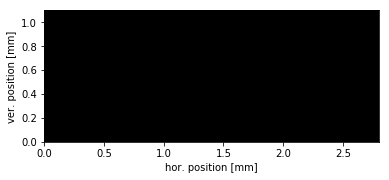

strain between  14.0  and  28.0  strain gradient  1
max. DOC at this strain:  0.600272688624906


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

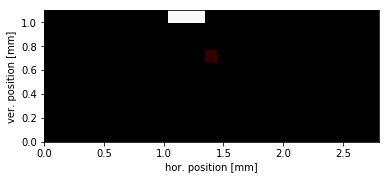

strain between  28.0  and  42.0  strain gradient  1
max. DOC at this strain:  0.7289833630567921


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

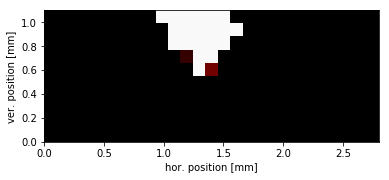

strain between  42.0  and  56.0  strain gradient  1
max. DOC at this strain:  0.898907641521935


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

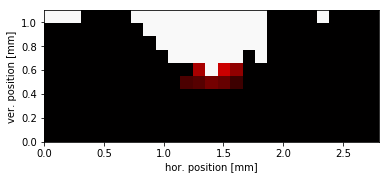

strain between  56.0  and  70.0  strain gradient  1
max. DOC at this strain:  0.9936979062725955


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

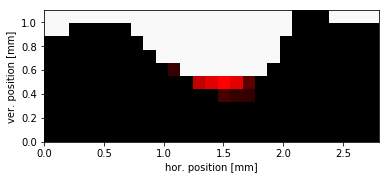

strain between  56.0  and  70.0  strain gradient  -1
max. DOC at this strain:  0.9301630281418278


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

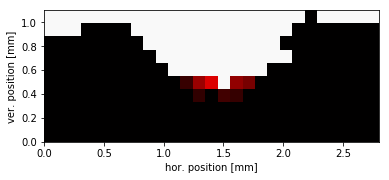

strain between  42.0  and  56.0  strain gradient  -1
max. DOC at this strain:  0.7266835470465581


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

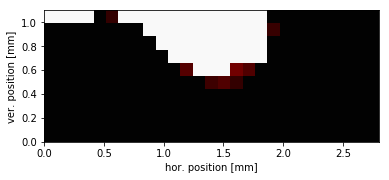

strain between  28.0  and  42.0  strain gradient  -1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

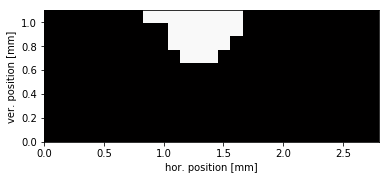

strain between  14.0  and  28.0  strain gradient  -1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

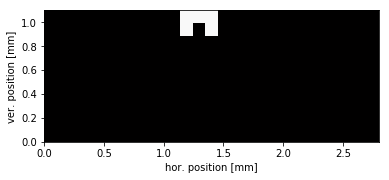

strain between  0.0  and  14.0  strain gradient  -1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

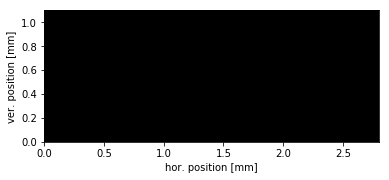

In [665]:
%matplotlib inline
import matplotlib
df2.image_scanrow = df2.image_scanrow.astype(int)
df2.image_scancol = df2.image_scancol.astype(int)
row_max = df2.image_scanrow.max()
row_min = df2.image_scanrow.min()
col_max = df2.image_scancol.max()
col_min = df2.image_scancol.min()
print row_min
n_rows = row_max - row_min + 1
n_cols = col_max - col_min + 1
doc_max = df2.doc.max()
print 'max doc: ', doc_max
doc_min = df2.doc.min()
print 'min doc: ', doc_min
m1 = np.zeros((n_rows-1, n_cols-1)) # cut off last row and last col as scan was interrupted during last row and nothing happens in last col
strain_levels = np.linspace(0, amplitude, strain_steps)
# print strain_levels
extent = np.array([0,n_cols, 0, n_rows])*scan_stepsize
n = 0
for not_strain_gradient in [-1, 1]:
    strain_steps_array = range(strain_steps-1)
    if not_strain_gradient == 1: strain_steps_array = strain_steps_array[::-1] # descending strain for unloading branch
    for i in strain_steps_array:
        print 'strain between ', strain_levels[i], ' and ', strain_levels[i+1], ' strain gradient ', str(-1*not_strain_gradient)
        temp = df2[(df2.strain >= strain_levels[i]) & (df2.strain < strain_levels[i+1]) & (df2.strain_gradient != not_strain_gradient)] # loading only
        for y in range(n_rows-1):
            for x in range(n_cols-1):
                temp2 = temp[(temp.image_scanrow == y + row_min) & (temp.image_scancol == x + col_min)]
#                 m1[y,x] = temp2.tsi.mean()
                if len(temp2) > 0:
                    doc = temp2.doc.median()
                    if doc < .2*doc_max: m1[y,x] = .5 # threshold for DOC to be displayed, smaller values are assumed to be due to noise
                    else: m1[y,x] = (doc/doc_max)*.5+.5 # scaling DOC from .5 (DOC = 0) to 1 (DOC = doc_max)
                    # keep m1 at 0 otherwise (if pixel is invalid)
                    # for efficiency, this kind of mapping colors could be done at array level later
#                 print 'number of images at this scan point: ', len(temp2)
        print 'max. DOC at this strain: ', m1.max()
#       print 'max. DOC at this strain: ', m1[1:,:-1].max()
#         print type(m1)
        plt.imshow(m1, vmin = .0, vmax = 1., cmap = doc_cmap, extent=extent)
        plt.xlabel('hor. position [mm]')
        plt.ylabel('ver. position [mm]')
        plt.savefig(make_png_name(n), bbox_inches='tight')
        plt.show()
        n += 1
        m1[:,:] = .0



### Turn series of png's into animated gif

In [660]:
import moviepy.editor as mpy
pngs = glob.glob(os.path.join(output_path, '*.png'))
fps = frequency*len(pngs)
clip = mpy.ImageSequenceClip(pngs, fps=fps)
clip.write_gif(os.path.join(output_path, 'docmap.gif'), fps=fps)


[MoviePy] Building file F:\beamlinedata\DESY\results\docmap.gif with imageio


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 57.14it/s]


                            imagename  image_scanrow  image_scancol  \
31578  nr8low_dyn_1_00008r6_01544.cbf              6             15   

                     datetime       tsi  right_shadow_position  valid  \
31578 2012-11-28 06:51:02.633  11173101                    266      1   

       image_scanrow_mm  image_scancol_mm  right_shadow_position_mm  \
31578               0.6               1.5                    45.752   

       right_shadow_position_mm_corr  shadowregion_tsi  shadow_exists  \
31578                         48.752           1346901              1   

            doc     strain  strain_gradient  
31578  0.690515  59.762043                1  


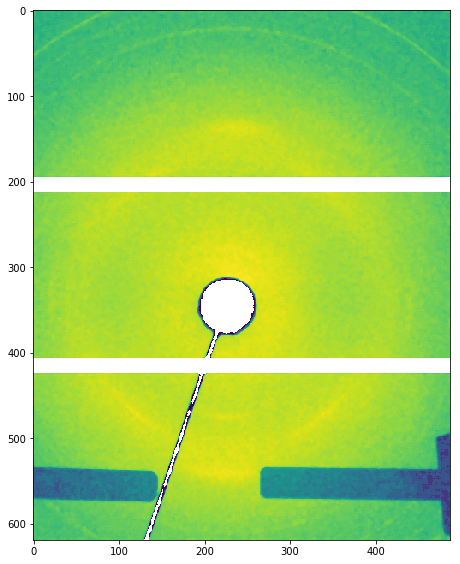

In [689]:
print df2[df2.doc==df2.doc.max()]
show_cbf(get_imagedata(df2.imagename[31578]))